## Import libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

from prophet import Prophet

from scipy.stats import shapiro, ks_2samp
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from scipy.stats import boxcox, norm, ks_2samp
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\holidays\deprecations\v1_incompatibility.py:40: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Holidays v0.67
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates that introduce breaking changes to our API. To ensure the stability of your projec

## Load data

In [2]:
df = pd.read_csv("../Datasets/class_products.csv", index_col=0)
df

ProductID Classification  DemandClass  QuantitySold   OrderDate
0             427              A  High demand            50  2003-07-11
1             427              A  High demand            50  2003-07-15
2             427              A  High demand            20  2003-07-14
3             427              A  High demand            25  2003-07-14
4             427              A  High demand            50  2003-07-18
...           ...            ...          ...           ...         ...
105265        387              C   Low demand             1  2005-01-24
105266        675              C   Low demand             1  2005-02-09
105267       4300              C   Low demand             1  2006-04-14
105268       2088              C   Low demand             0  2005-07-28
105269       2640              C   Low demand             0  2006-04-01

[105270 rows x 5 columns]

### Classify by demand

In [3]:
df['DemandClass'].unique()

array(['High demand', 'Low demand'], dtype=object)

In [4]:
df_high_demand = df[df['DemandClass'] == 'High demand']
df_low_demand = df[df['DemandClass'] == 'Low demand']

In [5]:
df_high_demand

ProductID Classification  DemandClass  QuantitySold   OrderDate
0             427              A  High demand            50  2003-07-11
1             427              A  High demand            50  2003-07-15
2             427              A  High demand            20  2003-07-14
3             427              A  High demand            25  2003-07-14
4             427              A  High demand            50  2003-07-18
...           ...            ...          ...           ...         ...
105204       4348              C  High demand            10  2006-04-06
105205       4216              C  High demand            10  2006-03-30
105206       4326              C  High demand            10  2006-03-30
105207       4215              C  High demand            10  2006-03-30
105208       4298              C  High demand            10  2006-03-30

[82051 rows x 5 columns]

In [6]:
df_low_demand

ProductID Classification DemandClass  QuantitySold   OrderDate
36321         771              A  Low demand             2  2003-07-15
36322         771              A  Low demand             5  2003-08-13
36323         771              A  Low demand             2  2003-08-14
36324         771              A  Low demand             5  2003-09-02
36325         771              A  Low demand             2  2003-09-10
...           ...            ...         ...           ...         ...
105265        387              C  Low demand             1  2005-01-24
105266        675              C  Low demand             1  2005-02-09
105267       4300              C  Low demand             1  2006-04-14
105268       2088              C  Low demand             0  2005-07-28
105269       2640              C  Low demand             0  2006-04-01

[23219 rows x 5 columns]

In [7]:
df_high_demand_A = df_high_demand[df_high_demand['Classification'] == 'A']
df_high_demand_B = df_high_demand[df_high_demand['Classification'] == 'B']
df_high_demand_C = df_high_demand[df_high_demand['Classification'] == 'C']

df_low_demand_A = df_low_demand[df_low_demand['Classification'] == 'A']
df_low_demand_B = df_low_demand[df_low_demand['Classification'] == 'B']
df_low_demand_C = df_low_demand[df_low_demand['Classification'] == 'C']

In [8]:
def selected_20_products(df):
    
    products_id = df['ProductID'].unique()
    print(len(products_id))
    selected_id = pd.Series(products_id).sample(frac=0.2, random_state=42)
    print(len(products_id)*0.2, len(selected_id))
    df_selected = df[df['ProductID'].isin(selected_id)]
    
    return df_selected
    

In [9]:
df_selected_high_demand_A = selected_20_products(df_high_demand_A)
df_selected_high_demand_A

438
87.60000000000001 88


ProductID Classification  DemandClass  QuantitySold   OrderDate
0            427              A  High demand            50  2003-07-11
1            427              A  High demand            50  2003-07-15
2            427              A  High demand            20  2003-07-14
3            427              A  High demand            25  2003-07-14
4            427              A  High demand            50  2003-07-18
...          ...            ...          ...           ...         ...
51016        637              A  High demand             5  2005-03-09
51017        637              A  High demand             3  2005-03-09
51018        637              A  High demand             1  2005-03-22
51019        637              A  High demand            16  2005-03-24
51020        637              A  High demand            10  2005-04-01

[10983 rows x 5 columns]

In [10]:
df_selected_high_demand_B = selected_20_products(df_high_demand_B)
df_selected_high_demand_C = selected_20_products(df_high_demand_C)
df_selected_low_demand_A = selected_20_products(df_low_demand_A)
df_selected_low_demand_B = selected_20_products(df_low_demand_B)
df_selected_low_demand_C = selected_20_products(df_low_demand_C)

928
185.60000000000002 186
827
165.4 165
11
2.2 2
497
99.4 99
1340
268.0 268


In [25]:
def outliers_median(df):
    
    if df.empty or df['QuantitySold'].dropna().empty:
        print("Warning: DataFrame is empty or has no valid QuantitySold values.")
        return df
    
    q1 = df['QuantitySold'].quantile(0.25)
    q3 = df['QuantitySold'].quantile(0.75)
    
    iqr = q3 -q1
    
    lim_inf = q1 -1.5*iqr
    lim_sup = q3 + 1.5*iqr
    
    outliers = df[(df['QuantitySold'] < lim_inf) | (df['QuantitySold'] > lim_sup)]

    perc_out = (len(outliers) / len(df['QuantitySold'])) * 100

    print(f'Percentage outliers:  {perc_out}') 
    
    
    mean = df['QuantitySold'].mean()
    median = df['QuantitySold'].median()
    
    print(f"Mean : {mean}, Median: {median}")
    
    df['QuantitySold_no_out'] = np.where((df['QuantitySold'] < lim_inf) | (df['QuantitySold'] > lim_sup),
                              df['QuantitySold'].median(), df['QuantitySold'])
    
    plt.figure(figsize=(18,5))
    plt.plot(df['QuantitySold'], linestyle="-", label = 'Sales')
    plt.plot(df['QuantitySold_no_out'], linestyle="-", label = 'Sales no outliers' )
    plt.axhline(y=mean, color='r', linestyle="--", label=f"Mean: {mean:.2f}")
    plt.title('Sales forecasting')
    plt.legend()
    plt.grid()
    plt.show()
    
    # subsitute outliers: 
    
    df['QuantitySold'] = df['QuantitySold_no_out']
    df.drop(columns=['QuantitySold_no_out'], inplace=True)
    
    return df

In [12]:
def check_normality(df):
    residuos = df['QuantitySold']

    # Filtrar valores no finitos (NaN, inf)
    residuos_clean = residuos[np.isfinite(residuos)]

    if len(residuos_clean) < 3:  # Requerido para las pruebas de normalidad
        print("Los datos no son suficientes o contienen valores no finitos para la prueba de normalidad.")
        return df  # Retornar el dataframe sin modificaciones si no son adecuados

    # Test de Kolmogorov-Smirnov
    mean_residuos = residuos_clean.mean()
    std_residuos = residuos_clean.std()
    ks_stat, p_ks = ks_2samp(residuos_clean, np.random.normal(loc=mean_residuos, scale=std_residuos, size=len(residuos_clean)))
    
    # Test de Shapiro-Wilk (para n < 5000)
    shapiro_stat, p_shapiro = shapiro(residuos_clean) if len(residuos_clean) < 5000 else (None, None)

    print(f"p-value Kolmogorov-Smirnov: {p_ks}")
    print(f"p-value Shapiro-Wilk: {p_shapiro}")

    # Si p-valor < 0.05 en ambos test, la serie no es normal -> aplicar Box-Cox
    if p_ks < 0.05 or (p_shapiro is not None and p_shapiro < 0.05):
        print("La serie NO es normal. Aplicando Box-Cox...")

        # Asegurarse de que los datos sean positivos
        if (residuos_clean <= 0).any():
            min_value = residuos_clean.min()
            print(f"Valor mínimo antes de ajuste: {min_value}")
            residuos_clean = residuos_clean - min_value + 1e-6  # Asegura que todos los valores sean positivos
            print(f"Valor mínimo después de ajuste: {residuos_clean.min()}")
        
        # Aplicar Box-Cox
        df['QuantitySold'] = residuos_clean.copy()
        df['QuantitySold'], lambda_bc = boxcox(df['QuantitySold'])
        print(f"Lambda de Box-Cox: {lambda_bc}")
    else:
        print("La serie es normal. No es necesario aplicar Box-Cox.")
    
    # Verificar la normalidad después de la transformación Box-Cox
    ks_stat, p_ks = ks_2samp(df['QuantitySold'], np.random.normal(loc=mean_residuos, scale=std_residuos, size=len(df['QuantitySold'])))
    shapiro_stat, p_shapiro = shapiro(df['QuantitySold']) if len(df['QuantitySold']) < 5000 else (None, None)

    print(f"p-value Kolmogorov-Smirnov después de Box-Cox: {p_ks}")
    print(f"p-value Shapiro-Wilk después de Box-Cox: {p_shapiro}")

    return df

In [13]:
def divide_train_test(df, test_size = 0.1):
    
    train = 1 - test_size
    train_size = round(len(df) * train)
    
    train_data = df[:train_size]
    test_data = df[train_size:]
    
    return train_data, test_data

In [14]:

def calculate_errors(real, pred):
    # Eliminar valores NaN en los datos de entrada
    valid_indices = ~np.isnan(real) & ~np.isnan(pred)
    real_clean = real[valid_indices]
    pred_clean = pred[valid_indices]
    
    # Si después de eliminar los NaN hay datos válidos
    if len(real_clean) > 0 and len(pred_clean) > 0:
        mae = mean_absolute_error(real_clean, pred_clean)
        mse = mean_squared_error(real_clean, pred_clean)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((real_clean - pred_clean) / real_clean)) * 100
    else:
        # Si no hay datos válidos, devolver NaN
        mae = mse = rmse = mape = np.nan
    
    return mae, mse, rmse, mape

In [15]:
def moving_average(train, test, span=10):
    
    train = train.copy()
    test = test.copy()
    train['EMA'] = train['QuantitySold'].ewm(span=span, adjust=False).mean()
    
    last_ema = train['EMA'].iloc[-1]
    test['EMA'] = last_ema
    
    return train, test

In [16]:
def arima (train, test, order=(1,2,1)):
    
    model = ARIMA(train['QuantitySold'], order = order)
    fit = model.fit()
    test['ARIMA_Pred'] = fit.forecast(steps = len(test))
    return train, test

In [17]:
def apply_sarimax( train, test, order = (2,1,2), seasonal_order=(1,1,1,12)):
    
    model = SARIMAX(train['QuantitySold'], order=order, seasonal_order=seasonal_order)
    fit = model.fit()
    
    test['SARIMAX_pred'] = fit.forecast(steps=len(test))
    
    return train, test

In [18]:
def apply_prophet(train, test, periods = 10):
    
    train = train.reset_index()
    test = test.reset_index()
    train = train.rename(columns={'OrderDate': 'ds', 'QuantitySold': 'y'})
    train['ds'] = pd.to_datetime(train['ds'])
    
    train = train.dropna(subset=['y'])
    
    # Verificar si después de eliminar nulos, el dataframe tiene suficientes datos
    if len(train) < 2:
        print("No hay suficientes datos no nulos en el dataframe para aplicar Prophet.")
        test['Prophet_Pred'] = 0
        
        return train, test
    
    model = Prophet()
    model.fit(train)
    
    future = pd.DataFrame({'ds': test['OrderDate']})
    future['ds'] = pd.to_datetime(future['ds'])
    forecast = model.predict(future)
    
    test['Prophet_Pred'] = forecast['yhat'].values
    test['Prophet_Pred'].fillna(0, inplace=True)
    
    train = train.set_index('ds')  
    test = test.set_index('OrderDate')
    
    return train, test

In [19]:
def evaluate_model(df, product, demand_class):
    errors = {'ProductID': [], 'Modelo': [], "MAE": [], "MSE": [], "RMSE": [], "MAPE": [], "Predictions": [] }
    pred_completas = pd.DataFrame()
    
    df_p = df[df['ProductID'] == product]
    
    df_p = df_p[['ProductID','OrderDate', 'QuantitySold']]
    
    df_p['OrderDate'] = pd.to_datetime(df_p['OrderDate'])
    
    df_p = df_p.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
    
    df_p = df_p.set_index('OrderDate')
    df_p = df_p.asfreq('W-MON')
    
    df_p['QuantitySold'] = df_p['QuantitySold'].interpolate()
    
    df_p = outliers_median(df_p)
    
    df_p = check_normality(df_p)
    
    train, test = divide_train_test(df_p)
    
    # Si es baja demanda, solo aplicamos media móvil
    if demand_class == 'Low demand':
        train, test = moving_average(train, test)
    else:
        # Si es alta demanda, aplicamos todos los modelos
        train, test = arima(train, test)
        train, test
        train, test = apply_sarimax(train, test)
        train, test
        train, test = apply_prophet(train, test)
        train, test
    
    # Evaluar los modelos
    modelos = {
    "EMA" if demand_class == 'Low demand' else "ARIMA": test['EMA'] if demand_class == 'Low demand' else test['ARIMA_Pred'],
    "SARIMAX": test['SARIMAX_pred'] if demand_class != 'Low demand' else None,
    "Prophet": test['Prophet_Pred'] if demand_class != 'Low demand' else None
}

    # Evaluar los modelos y calcular los errores
    for modelo, pred in modelos.items():
        if pred is not None:  # Solo evaluar modelos que no son None
            mae, mse, rmse, mape = calculate_errors(test['QuantitySold'], pred)
            errors["ProductID"].append(product)
            errors["Modelo"].append(modelo)
            errors["MAE"].append(mae)
            errors["MSE"].append(mse)
            errors["RMSE"].append(rmse)
            errors["MAPE"].append(mape)
            errors["Predictions"].append(pred.tolist())  # Guardar las predicciones

    # Concatenar las predicciones de cada producto
    pred_completas = pd.concat([pred_completas, test[['ProductID', 'OrderDate', 'QuantitySold', 'EMA', 'ARIMA_Pred', 'SARIMAX_Pred', 'Prophet_Pred']]], ignore_index=True)

    return pd.DataFrame(errors), pred_completas


In [20]:
def evaluate_model(df, product, demand_class):
    errors = {'ProductID': [], 'Modelo': [], "MAE": [], "MSE": [], "RMSE": [], "MAPE": [], "Predictions": [] }
    pred_completas = pd.DataFrame()
    
    # Filtrar el dataframe para el producto específico
    df_p = df[df['ProductID'] == product]
    
    # Asegurarnos de que 'ProductID' esté en el dataframe
    df_p = df_p[['ProductID', 'OrderDate', 'QuantitySold']]
    
    # Convertir 'OrderDate' a formato datetime
    df_p['OrderDate'] = pd.to_datetime(df_p['OrderDate'])
    
    # Agrupar por 'OrderDate' y sumar 'QuantitySold'
    df_p = df_p.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
    
    # Establecer 'OrderDate' como índice
    df_p = df_p.set_index('OrderDate')
    
    # Definir la frecuencia de las fechas
    df_p = df_p.asfreq('W-MON')
    
    # Interpolar valores faltantes en 'QuantitySold'
    df_p['QuantitySold'] = df_p['QuantitySold'].interpolate()
    
    # Aplicar el tratamiento de outliers y la verificación de normalidad
    df_p = outliers_median(df_p)
    #df_p = check_normality(df_p)
    
    # Dividir los datos en conjunto de entrenamiento y prueba
    train, test = divide_train_test(df_p)
    
    # Si es baja demanda, solo aplicamos la media móvil
    if demand_class == 'Low demand':
        train, test = moving_average(train, test)
        test['ARIMA_Pred'] = 0
        test['SARIMAX_pred'] = 0
        test['Prophet_Pred'] = 0
    else:
        # Si es alta demanda, aplicamos ARIMA, SARIMAX y Prophet
        train, test = arima(train, test)
        train, test = apply_sarimax(train, test)
        train, test = apply_prophet(train, test)
        test['EMA'] = 0
    
    # Agregar 'ProductID' de nuevo al dataframe test
    test['ProductID'] = product

    # Evaluar los modelos
    modelos = {
        "EMA" if demand_class == 'Low demand' else "ARIMA": test['EMA'] if demand_class == 'Low demand' else test['ARIMA_Pred'],
        "SARIMAX": test['SARIMAX_pred'] if demand_class != 'Low demand' else None,
        "Prophet": test['Prophet_Pred'] if demand_class != 'Low demand' else None
    }

    # Evaluar los modelos y calcular los errores
    for modelo, pred in modelos.items():
        if pred is not None:  # Solo evaluar modelos que no son None
            mae, mse, rmse, mape = calculate_errors(test['QuantitySold'], pred)
            errors["ProductID"].append(product)  # Añadir el 'ProductID' para cada error
            errors["Modelo"].append(modelo)
            errors["MAE"].append(mae)
            errors["MSE"].append(mse)
            errors["RMSE"].append(rmse)
            errors["MAPE"].append(mape)
            errors["Predictions"].append(pred.tolist())  # Guardar las predicciones

    # Concatenar las predicciones de cada producto
    pred_completas = pd.concat([pred_completas, test[['ProductID', 'QuantitySold', 'EMA', 'ARIMA_Pred', 'SARIMAX_pred', 'Prophet_Pred']]], ignore_index=True)
    
    return pd.DataFrame(errors), pred_completas


Processing Product ID: 3607
Rows found for Product 3607: 15
⚠️ Warning: No data available for Product 3607. Skipping.
Processing Product ID: 158
Rows found for Product 158: 22
High demand C .... 

Percentage outliers:  0.0
Mean : 16.870967741935484, Median: 20.0


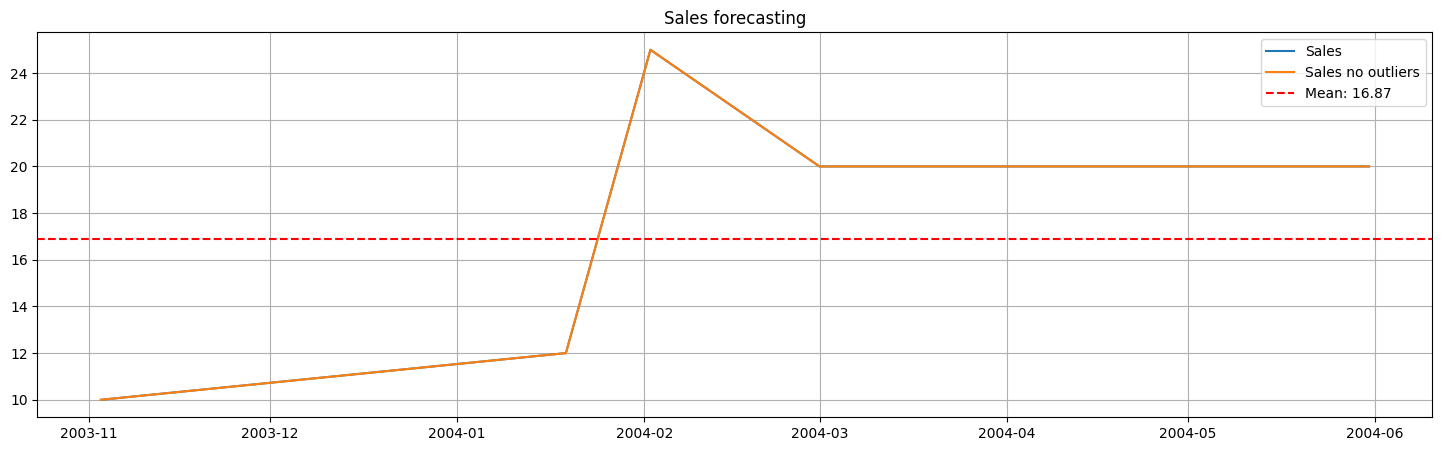

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs

Processing Product ID: 2638
Rows found for Product 2638: 2
⚠️ Warning: No data available for Product 2638. Skipping.
Processing Product ID: 3962
Rows found for Product 3962: 9
⚠️ Warning: No data available for Product 3962. Skipping.
Processing Product ID: 506
Rows found for Product 506: 15
⚠️ Warning: No data available for Product 506. Skipping.
Processing Product ID: 132
Rows found for Product 132: 24
High demand C .... 

Percentage outliers:  0.0
Mean : 11.681250000000002, Median: 10.551282051282051


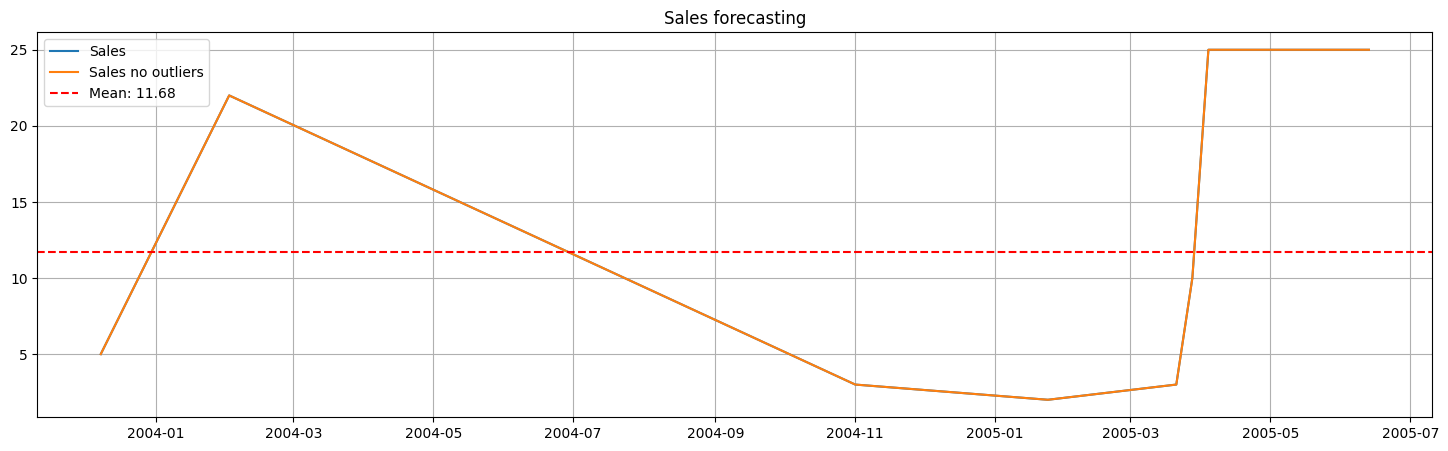

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Carlota\AppData\Local\Temp\ipykern

Processing Product ID: 3960
Rows found for Product 3960: 13
⚠️ Warning: No data available for Product 3960. Skipping.
Processing Product ID: 4314
Rows found for Product 4314: 3
⚠️ Warning: No data available for Product 4314. Skipping.
Processing Product ID: 671
Rows found for Product 671: 36
High demand C .... 

Percentage outliers:  15.555555555555555
Mean : 8.520833333333334, Median: 5.0


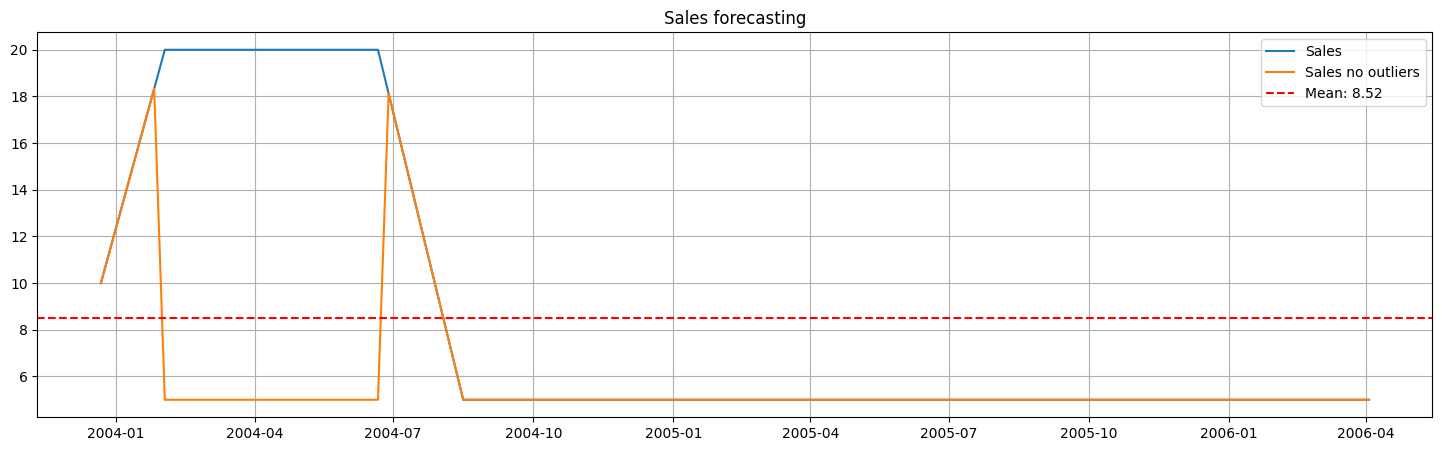

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMAX_pred'] = fit.forecast(steps=len(test))
19:09:42 - cmdstanpy - INFO - Chain [1] start processing
19:09:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\183863745.p

Processing Product ID: 3226
Rows found for Product 3226: 20
High demand C .... 

Percentage outliers:  0.0
Mean : 1.4375, Median: 1.417391304347826


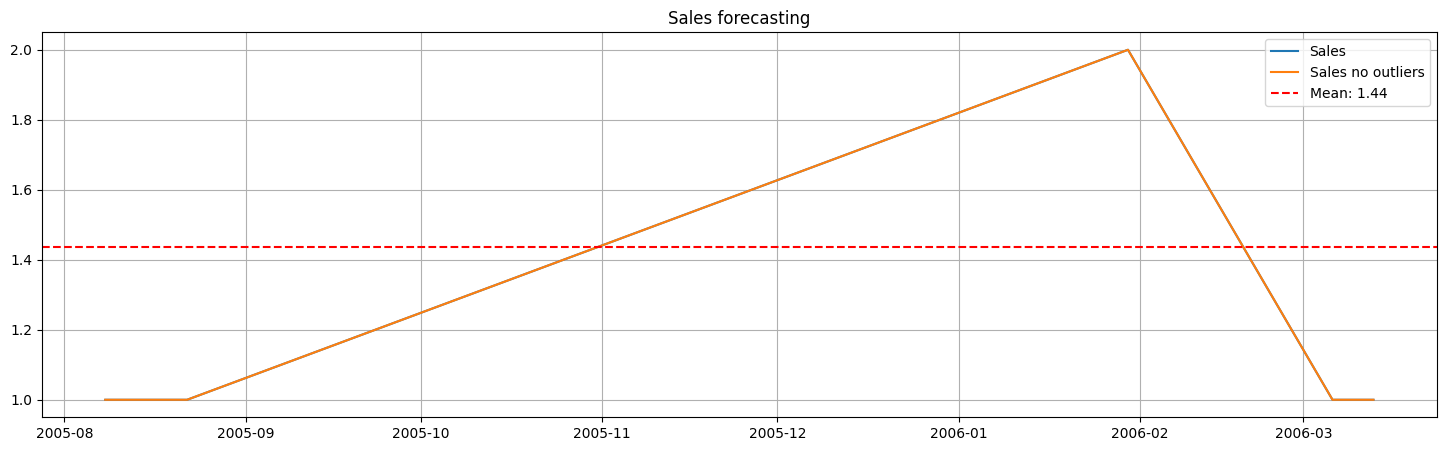

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs

Processing Product ID: 3216
Rows found for Product 3216: 7
⚠️ Warning: No data available for Product 3216. Skipping.
Processing Product ID: 1550
Rows found for Product 1550: 11
⚠️ Warning: No data available for Product 1550. Skipping.
Processing Product ID: 4321
Rows found for Product 4321: 7
⚠️ Warning: No data available for Product 4321. Skipping.
Processing Product ID: 4304
Rows found for Product 4304: 2
⚠️ Warning: No data available for Product 4304. Skipping.
Processing Product ID: 795
Rows found for Product 795: 28
High demand C .... 

Percentage outliers:  15.909090909090908
Mean : 11.52027027027027, Median: 10.0


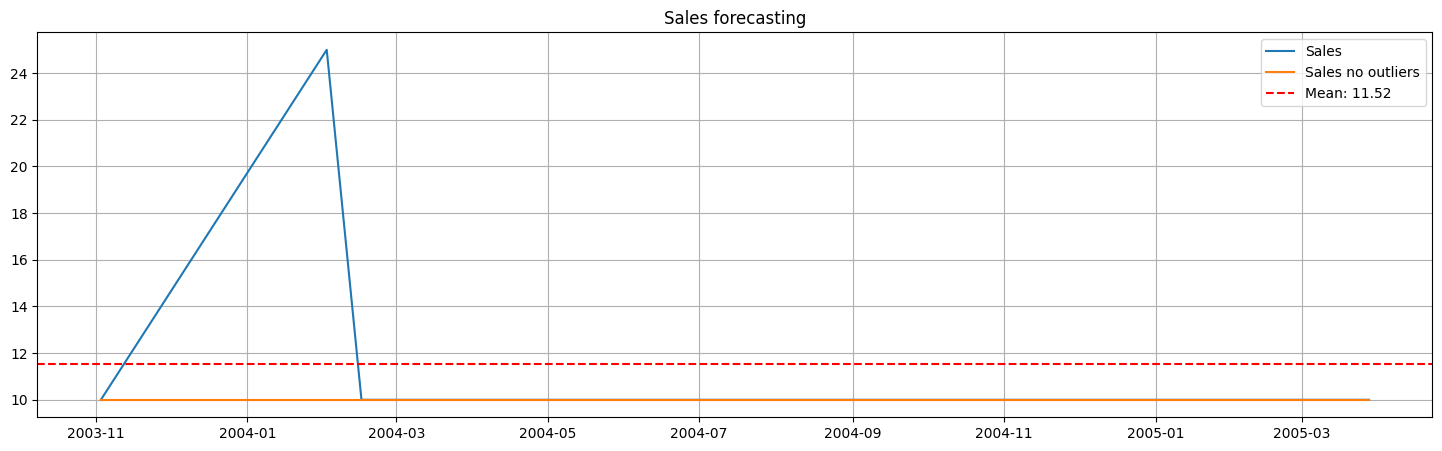

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1980210214.py:6: Setti

Processing Product ID: 2826
Rows found for Product 2826: 12
⚠️ Warning: No data available for Product 2826. Skipping.
Processing Product ID: 2268
Rows found for Product 2268: 14
⚠️ Warning: No data available for Product 2268. Skipping.
Processing Product ID: 611
Rows found for Product 611: 20
High demand C .... 

Percentage outliers:  18.181818181818183
Mean : 2.0725806451612905, Median: 1.0


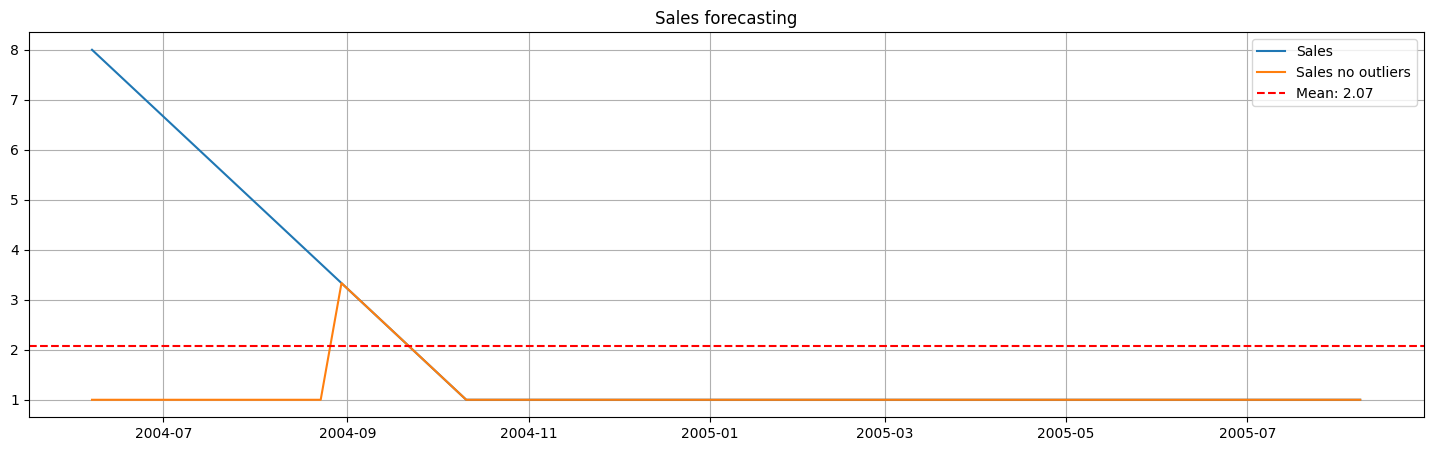

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Carlota\AppData\Local\Temp\ipy

Processing Product ID: 171
Rows found for Product 171: 14
⚠️ Warning: No data available for Product 171. Skipping.
Processing Product ID: 1111
Rows found for Product 1111: 24
High demand C .... 

Percentage outliers:  0.0
Mean : 23.488095238095237, Median: 9.6875


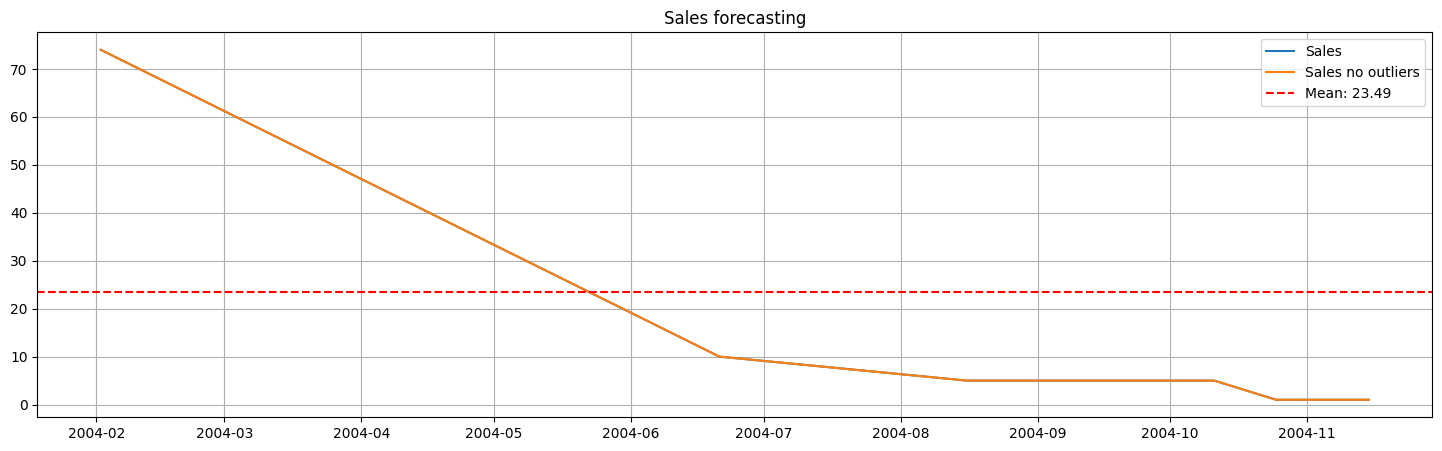

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1980210214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Processing Product ID: 37
Rows found for Product 37: 15
⚠️ Warning: No data available for Product 37. Skipping.
Processing Product ID: 1263
Rows found for Product 1263: 16
⚠️ Warning: No data available for Product 1263. Skipping.
Processing Product ID: 2825
Rows found for Product 2825: 15
⚠️ Warning: No data available for Product 2825. Skipping.
Processing Product ID: 3243
Rows found for Product 3243: 19
⚠️ Warning: No data available for Product 3243. Skipping.
Processing Product ID: 2094
Rows found for Product 2094: 3
⚠️ Warning: No data available for Product 2094. Skipping.
Processing Product ID: 1445
Rows found for Product 1445: 9
⚠️ Warning: No data available for Product 1445. Skipping.
Processing Product ID: 4371
Rows found for Product 4371: 1
⚠️ Warning: No data available for Product 4371. Skipping.
Processing Product ID: 4312
Rows found for Product 4312: 2
⚠️ Warning: No data available for Product 4312. Skipping.
Processing Product ID: 1524
Rows found for Product 1524: 6
⚠️ Warn

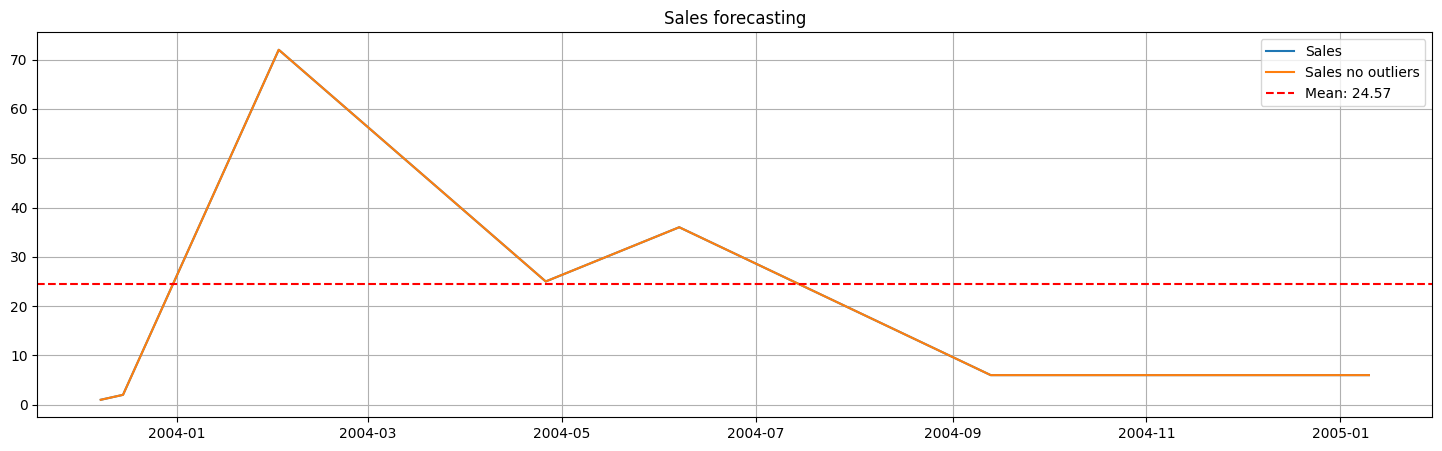

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Carlota\AppData\Local\Temp\ipykernel_132

Processing Product ID: 130
Rows found for Product 130: 20
High demand C .... 

Percentage outliers:  13.846153846153847
Mean : 5.607692307692307, Median: 4.184210526315789


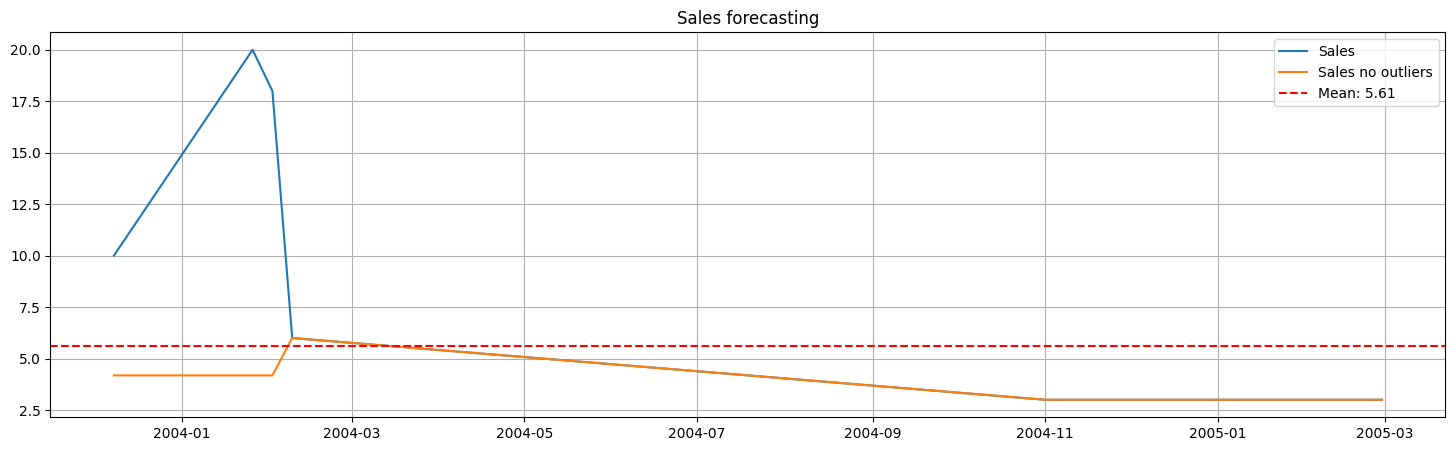

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Carlota\AppData\Local\Temp\ipykern

Processing Product ID: 3958
Rows found for Product 3958: 8
⚠️ Warning: No data available for Product 3958. Skipping.
Processing Product ID: 4130
Rows found for Product 4130: 8
⚠️ Warning: No data available for Product 4130. Skipping.
Processing Product ID: 4134
Rows found for Product 4134: 7
⚠️ Warning: No data available for Product 4134. Skipping.
Processing Product ID: 4400
Rows found for Product 4400: 1
⚠️ Warning: No data available for Product 4400. Skipping.
Processing Product ID: 4396
Rows found for Product 4396: 1
⚠️ Warning: No data available for Product 4396. Skipping.
Processing Product ID: 2605
Rows found for Product 2605: 7
⚠️ Warning: No data available for Product 2605. Skipping.
Processing Product ID: 2493
Rows found for Product 2493: 19
⚠️ Warning: No data available for Product 2493. Skipping.
Processing Product ID: 1963
Rows found for Product 1963: 11
⚠️ Warning: No data available for Product 1963. Skipping.
Processing Product ID: 3871
Rows found for Product 3871: 9
⚠️ 

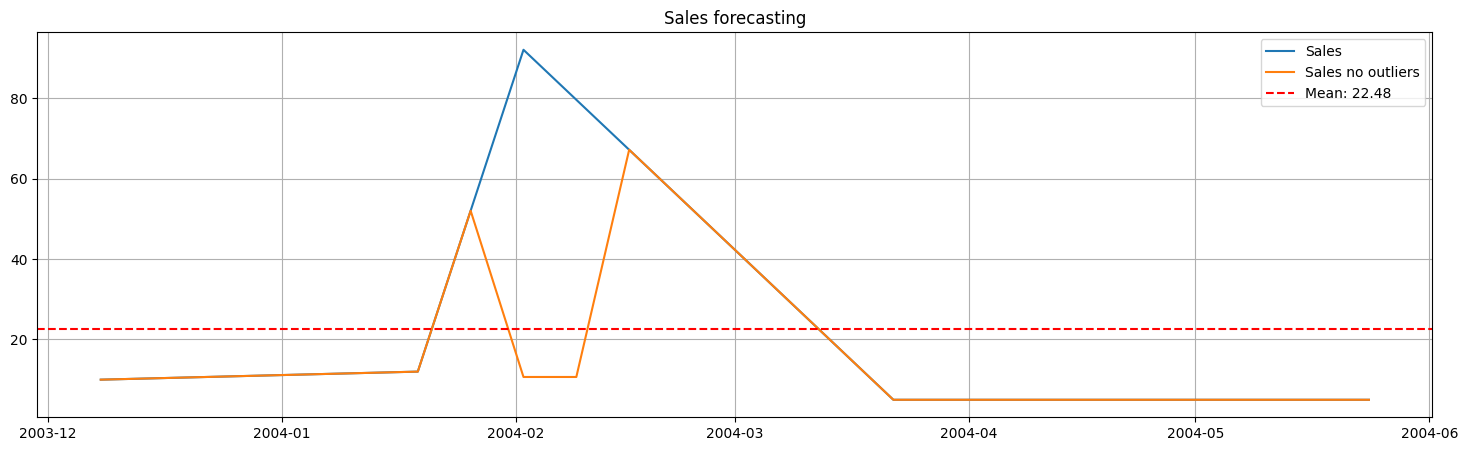

C:\Users\Carlota\AppData\Local\Temp\ipykernel_13256\1817521251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_Pred'] = fit.forecast(steps = len(test))
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%

Processing Product ID: 4404
Rows found for Product 4404: 1
⚠️ Warning: No data available for Product 4404. Skipping.
Processing Product ID: 3796
Rows found for Product 3796: 7
⚠️ Warning: No data available for Product 3796. Skipping.
Processing Product ID: 338
Rows found for Product 338: 17
⚠️ Warning: No data available for Product 338. Skipping.
Processing Product ID: 1354
Rows found for Product 1354: 9
⚠️ Warning: No data available for Product 1354. Skipping.
Processing Product ID: 3133
Rows found for Product 3133: 9
⚠️ Warning: No data available for Product 3133. Skipping.
Processing Product ID: 1433
Rows found for Product 1433: 4
⚠️ Warning: No data available for Product 1433. Skipping.
Processing Product ID: 4278
Rows found for Product 4278: 6
⚠️ Warning: No data available for Product 4278. Skipping.
Processing Product ID: 3587
Rows found for Product 3587: 3
⚠️ Warning: No data available for Product 3587. Skipping.
Processing Product ID: 2903
Rows found for Product 2903: 8
⚠️ Warn

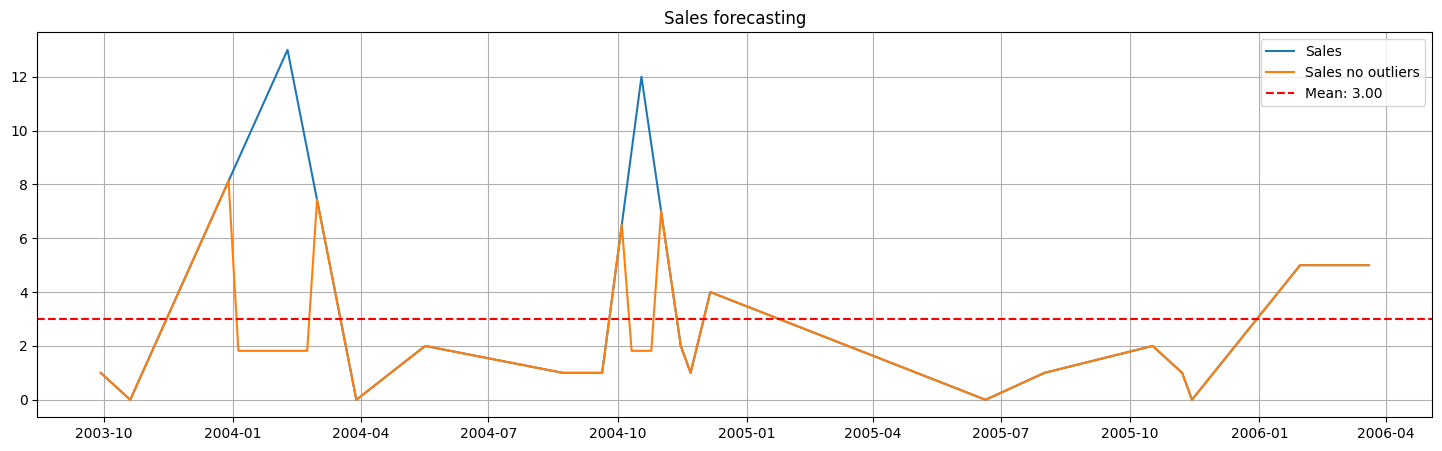

Processing Product ID: 3
Rows found for Product 3: 76
Low demand A .... 

Percentage outliers:  6.428571428571428
Mean : 2.087121212121212, Median: 1.7321428571428572


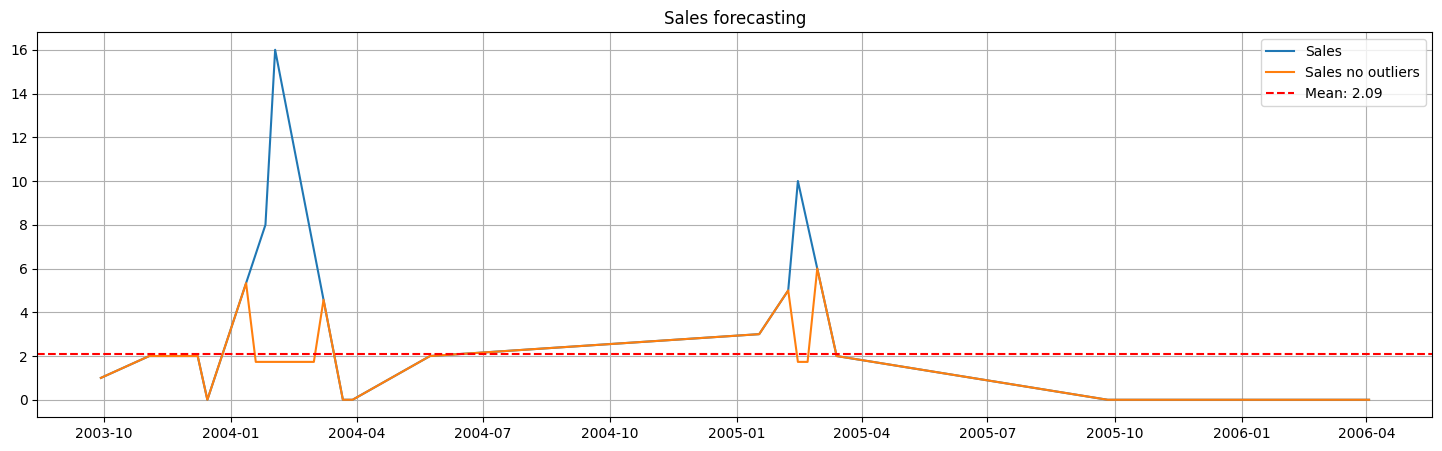

Processing Product ID: 332
Rows found for Product 332: 72
Low demand B ...

Percentage outliers:  5.714285714285714
Mean : 2.592, Median: 1.6666666666666667


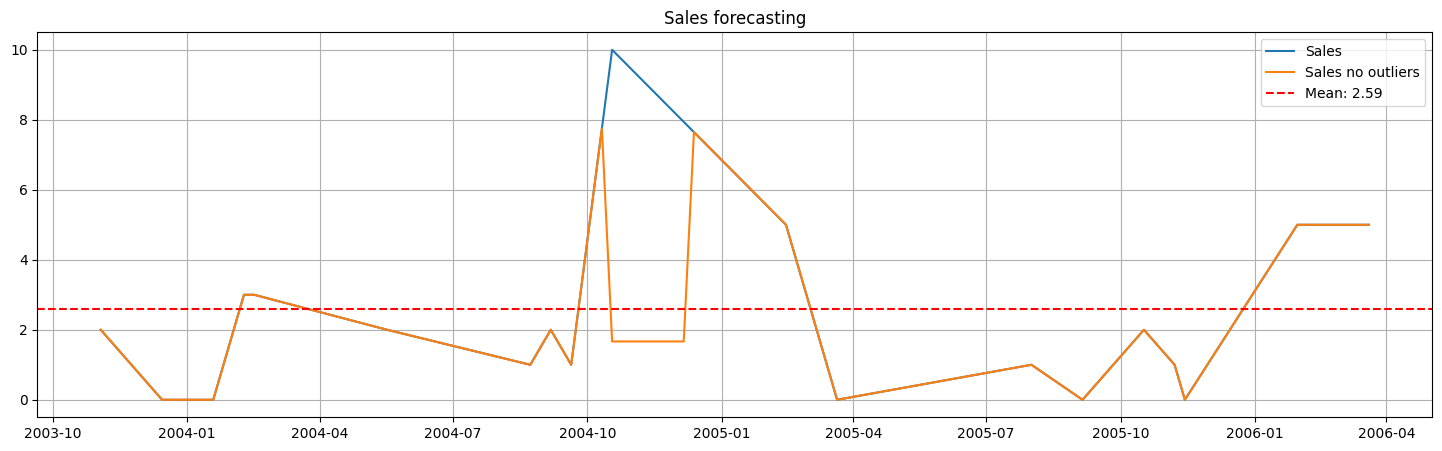

Processing Product ID: 1590
Rows found for Product 1590: 73
Low demand B ...

Percentage outliers:  0.0
Mean : 1.2263157894736842, Median: 0.4375


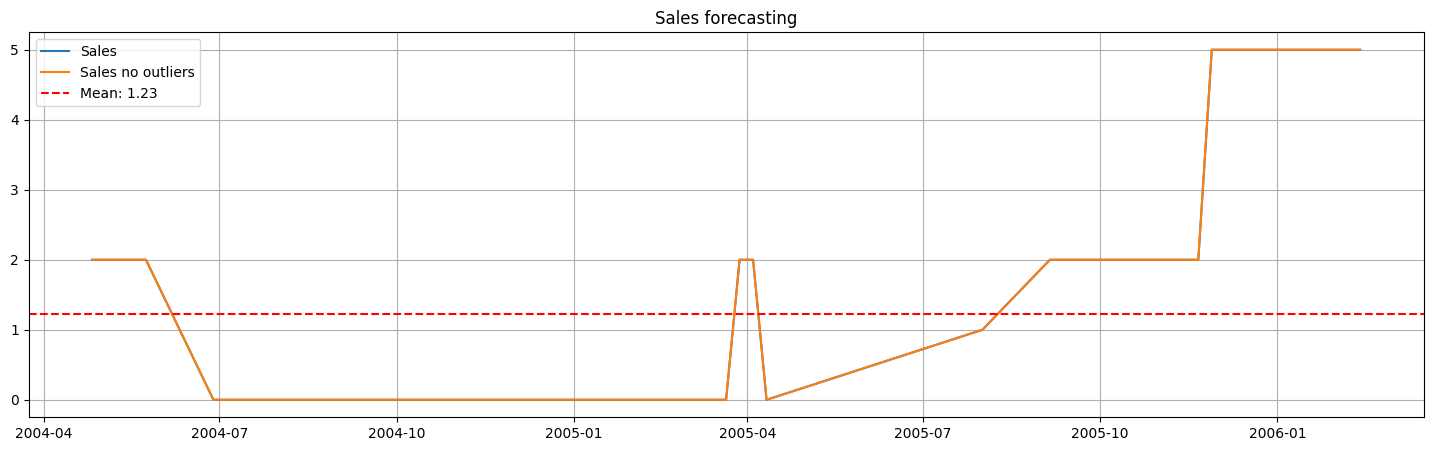

Processing Product ID: 1565
Rows found for Product 1565: 30
Low demand B ...

Percentage outliers:  5.454545454545454
Mean : 3.768181818181818, Median: 3.3875


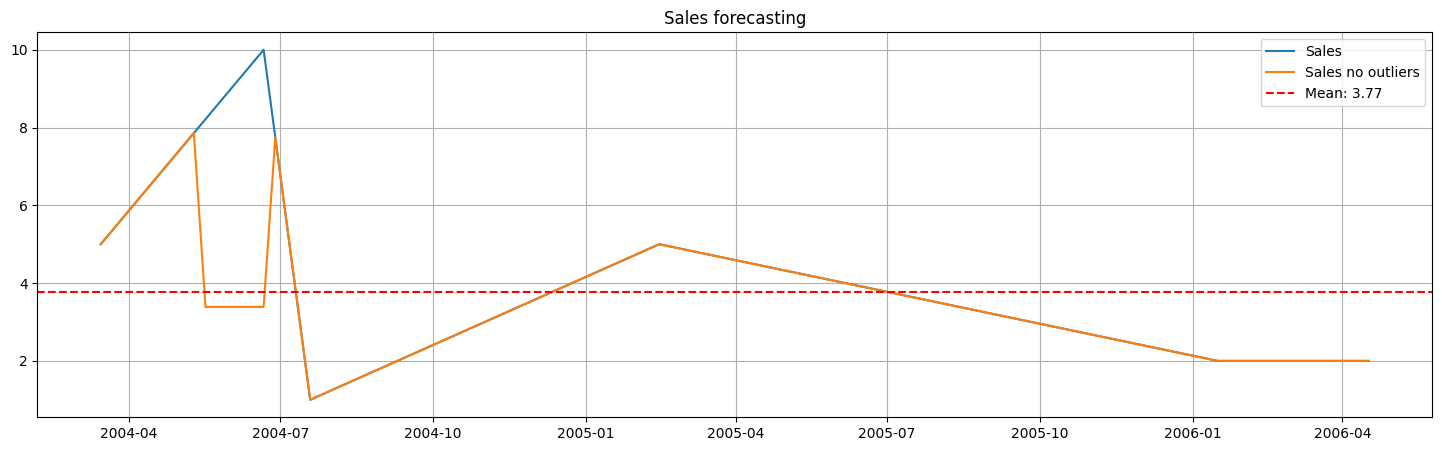

Processing Product ID: 1107
Rows found for Product 1107: 73
Low demand B ...

Percentage outliers:  3.875968992248062
Mean : 1.8837209302325582, Median: 1.5217391304347827


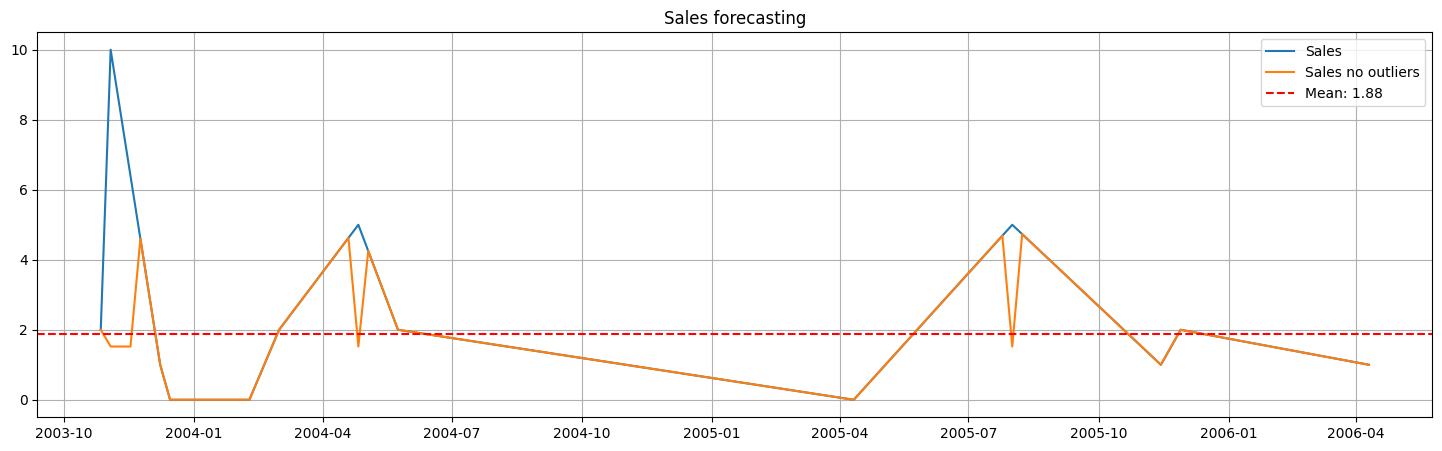

Processing Product ID: 1882
Rows found for Product 1882: 37
Low demand B ...

Percentage outliers:  13.095238095238097
Mean : 1.1538461538461537, Median: 1.0


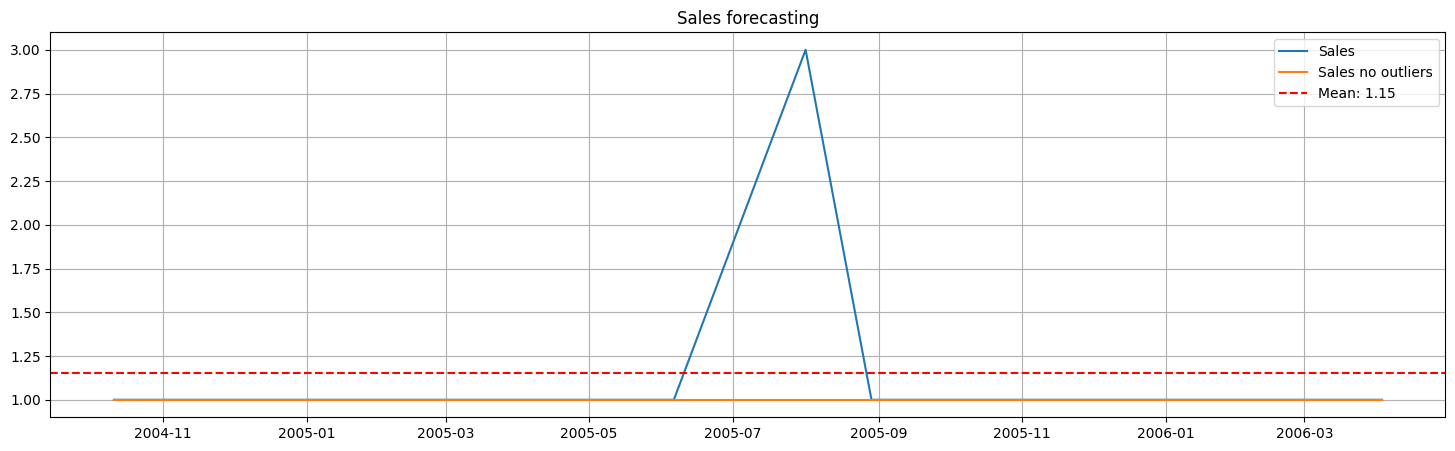

Processing Product ID: 1133
Rows found for Product 1133: 54
Low demand B ...

Percentage outliers:  0.78125
Mean : 4.34765625, Median: 3.966666666666667


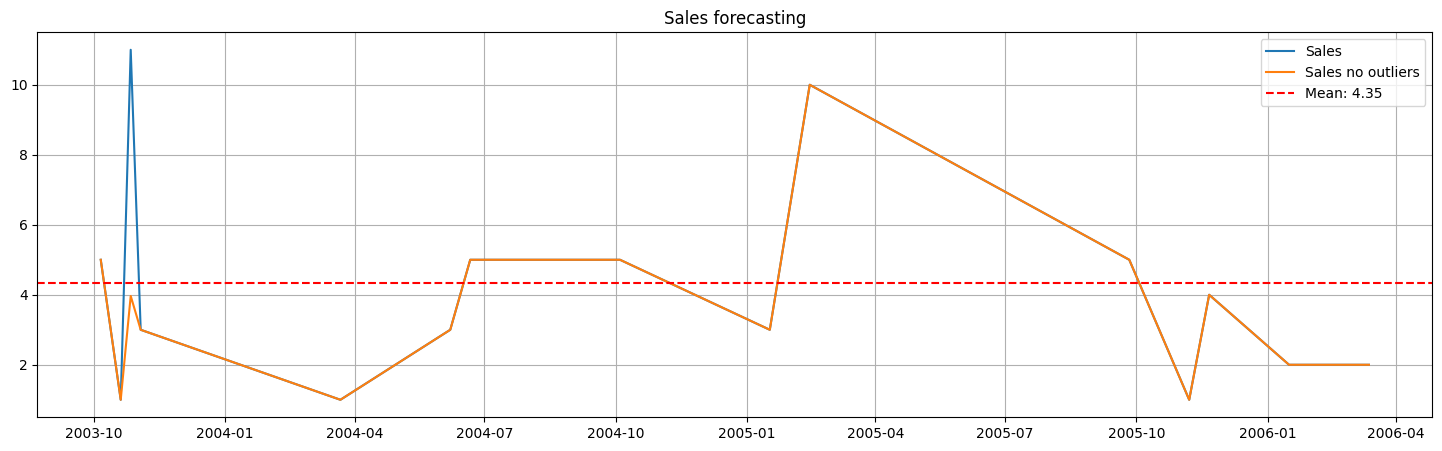

Processing Product ID: 1187
Rows found for Product 1187: 43
Low demand B ...

Percentage outliers:  8.73015873015873
Mean : 3.757936507936508, Median: 2.9772727272727275


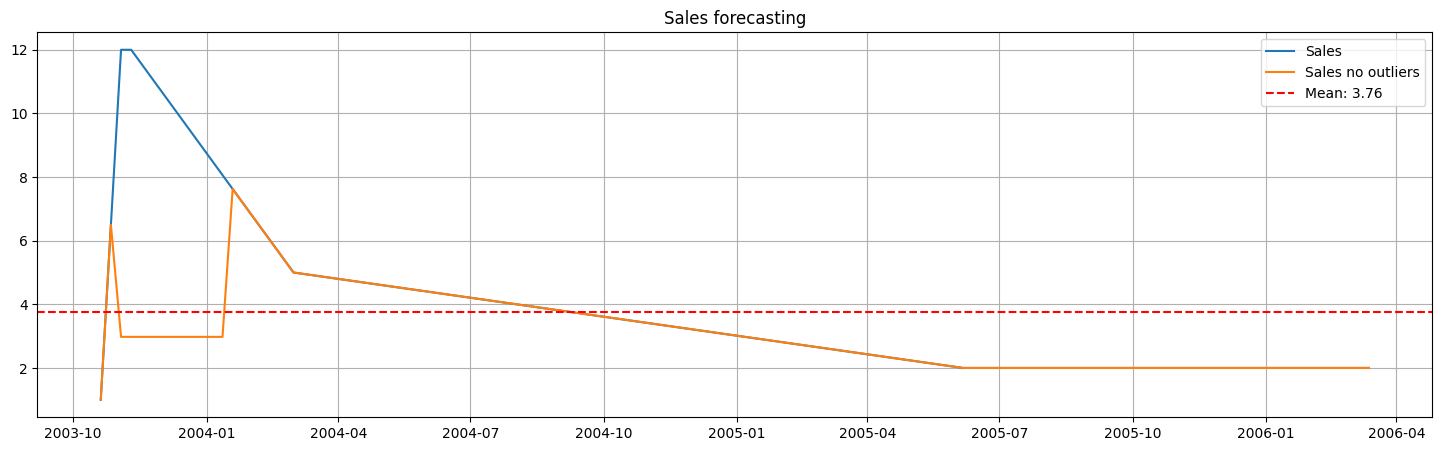

Processing Product ID: 212
Rows found for Product 212: 37
Low demand B ...

Percentage outliers:  0.0
Mean : 6.120689655172414, Median: 2.4444444444444446


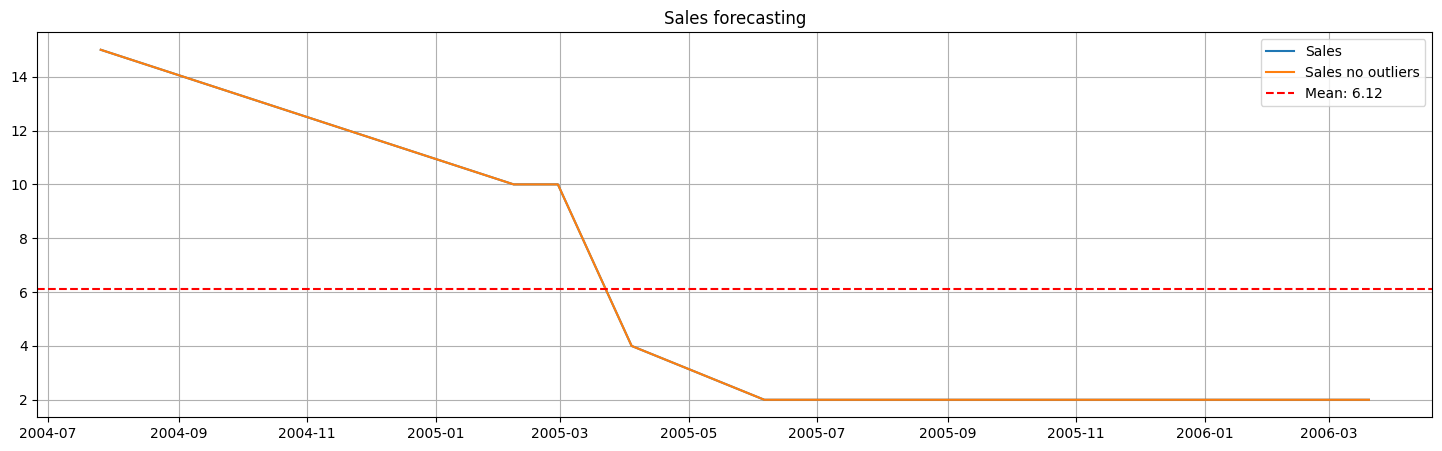

Processing Product ID: 268
Rows found for Product 268: 32
Low demand B ...

Percentage outliers:  2.2058823529411766
Mean : 6.9375, Median: 5.375


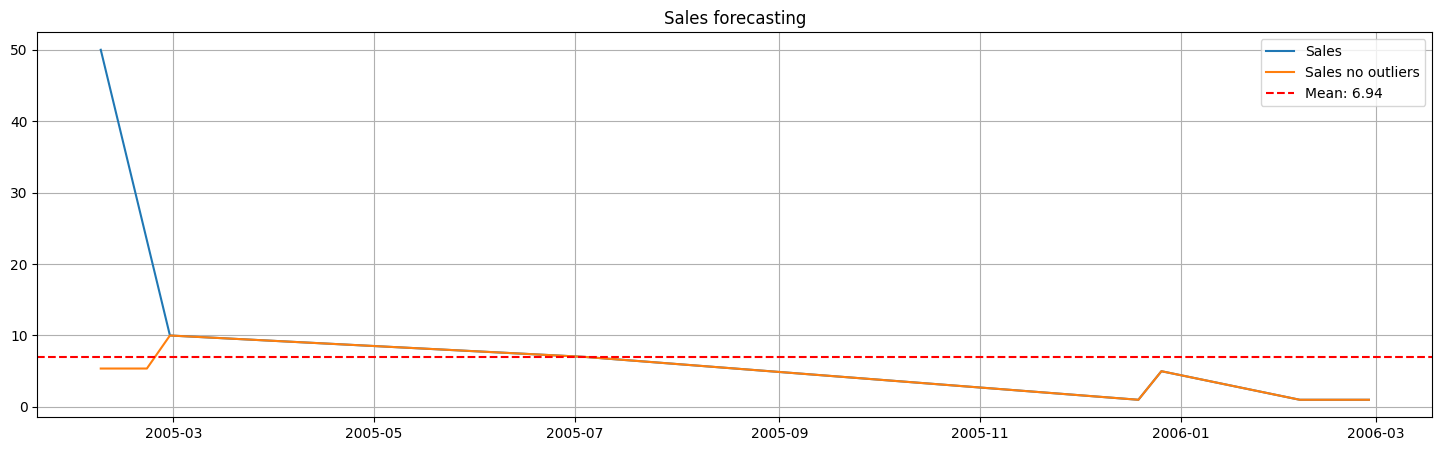

Processing Product ID: 218
Rows found for Product 218: 57
Low demand B ...

Percentage outliers:  0.0
Mean : 4.528925619834711, Median: 3.8076923076923084


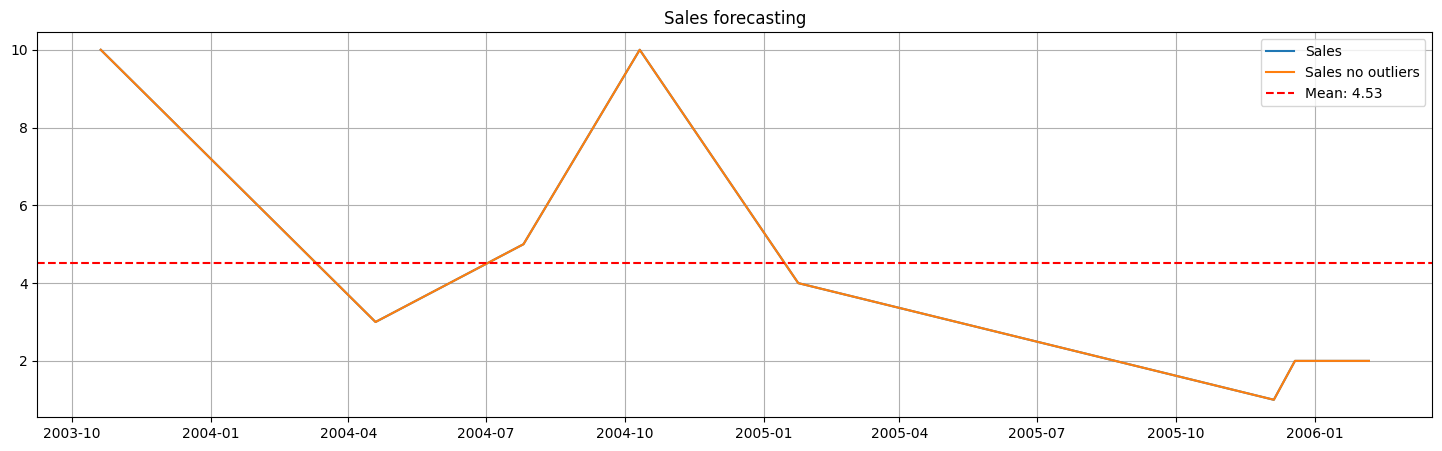

Processing Product ID: 1724
Rows found for Product 1724: 27
Low demand B ...

Percentage outliers:  0.0
Mean : 5.312500000000001, Median: 5.837662337662338


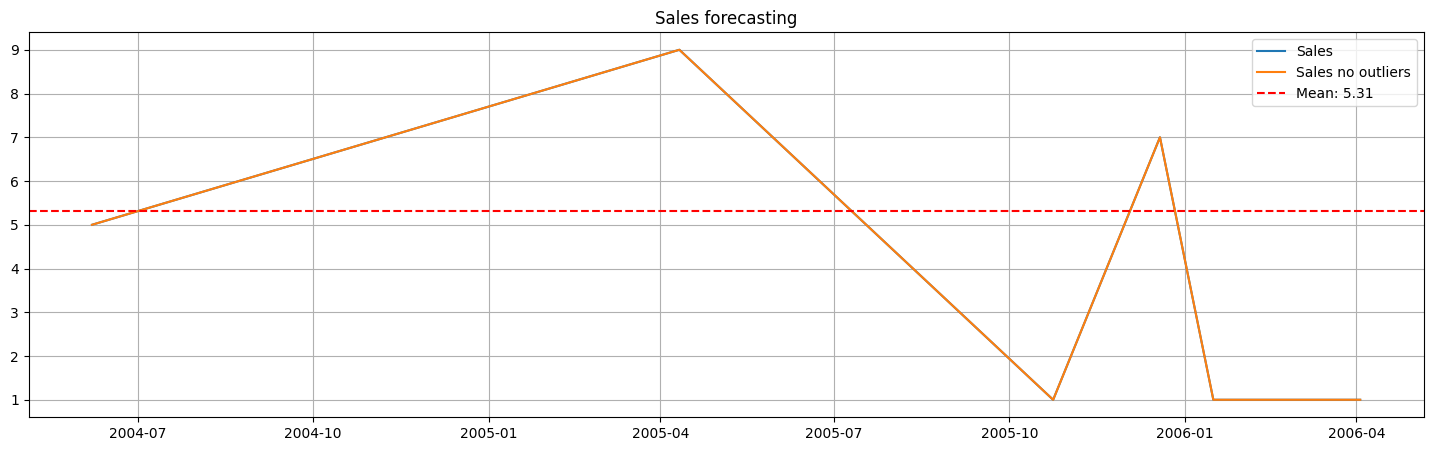

Processing Product ID: 2125
Rows found for Product 2125: 20
Low demand B ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


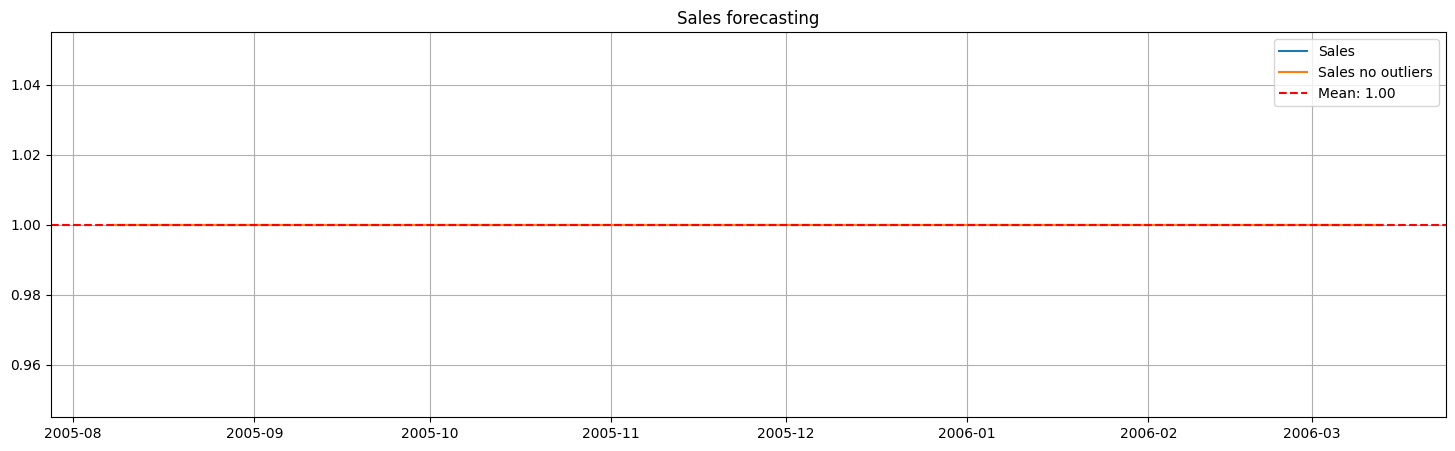

Processing Product ID: 1691
Rows found for Product 1691: 38
Low demand B ...

Percentage outliers:  0.0
Mean : 2.8701298701298703, Median: 4.0


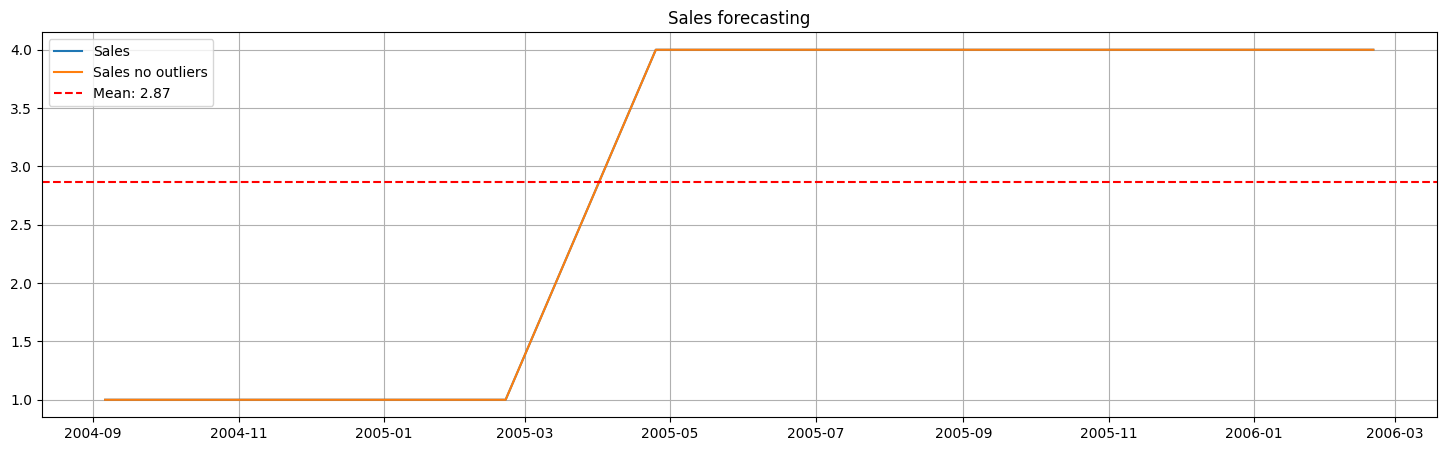

Processing Product ID: 2278
Rows found for Product 2278: 41
Low demand B ...

Percentage outliers:  1.5151515151515151
Mean : 5.822033898305085, Median: 8.0


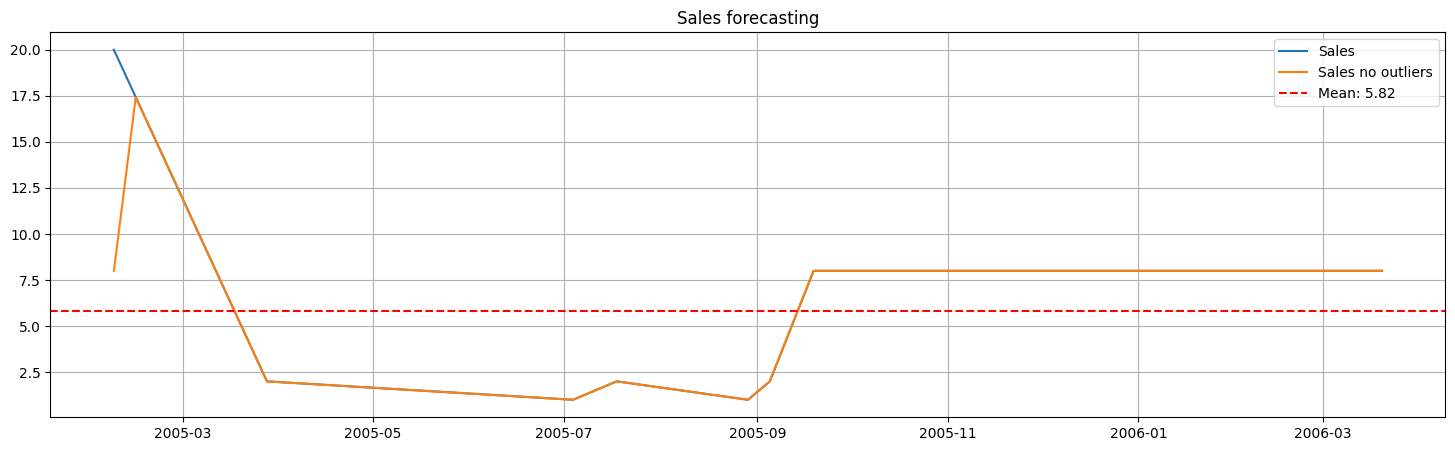

Processing Product ID: 732
Rows found for Product 732: 45
Low demand B ...

Percentage outliers:  0.0
Mean : 5.828571428571428, Median: 5.760869565217392


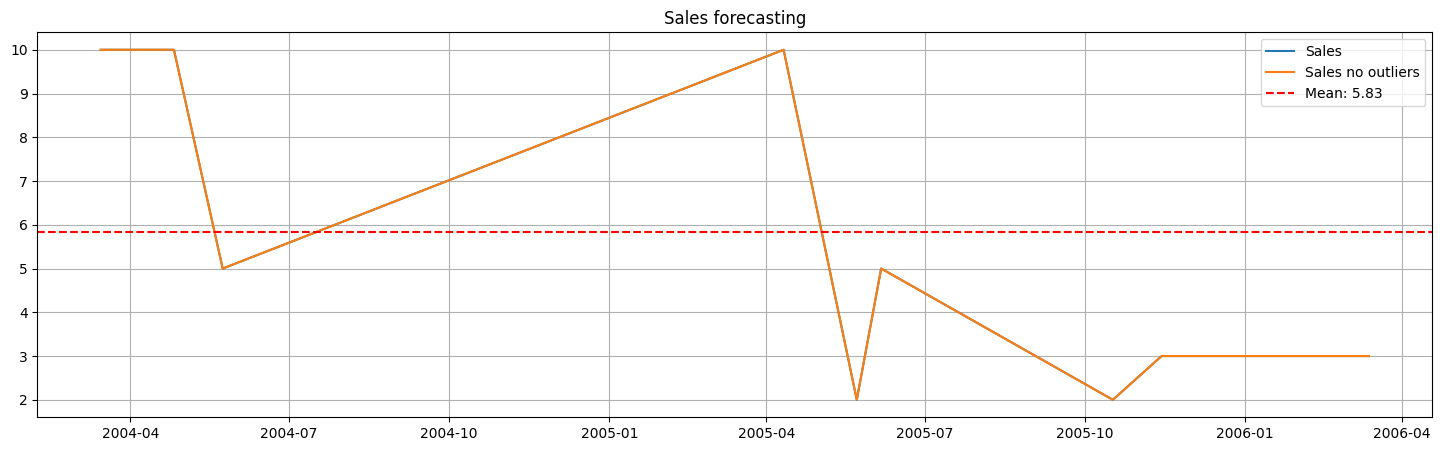

Processing Product ID: 1316
Rows found for Product 1316: 22
Low demand B ...

Percentage outliers:  0.0
Mean : 1.8, Median: 1.7000000000000002


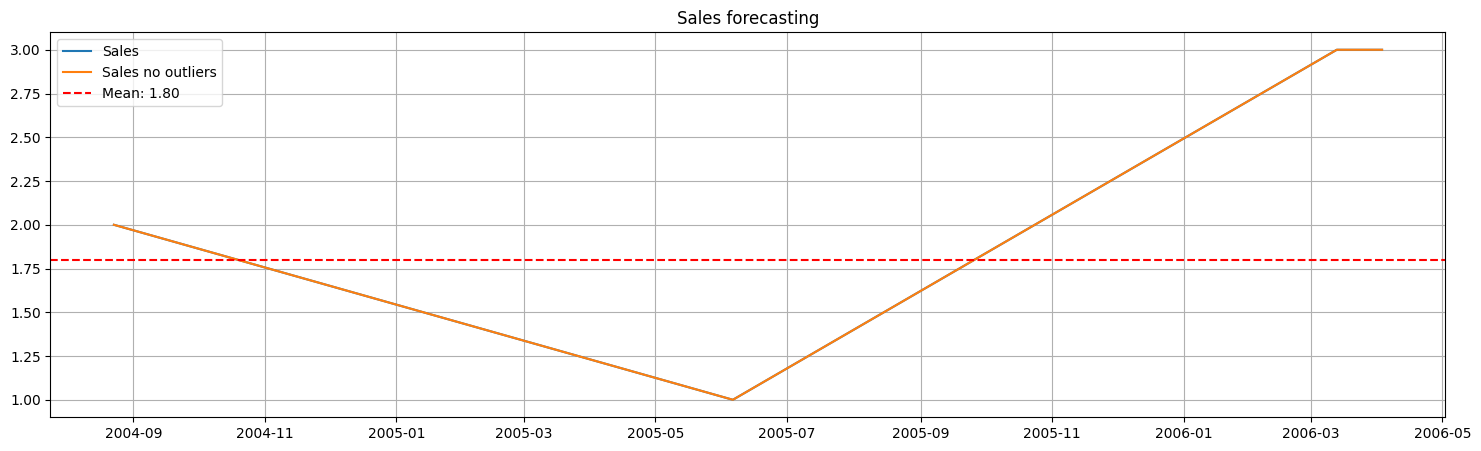

Processing Product ID: 1410
Rows found for Product 1410: 26
Low demand B ...

Processing Product ID: 641
Rows found for Product 641: 34
Low demand B ...

Percentage outliers:  10.687022900763358
Mean : 4.1880733944954125, Median: 4.0


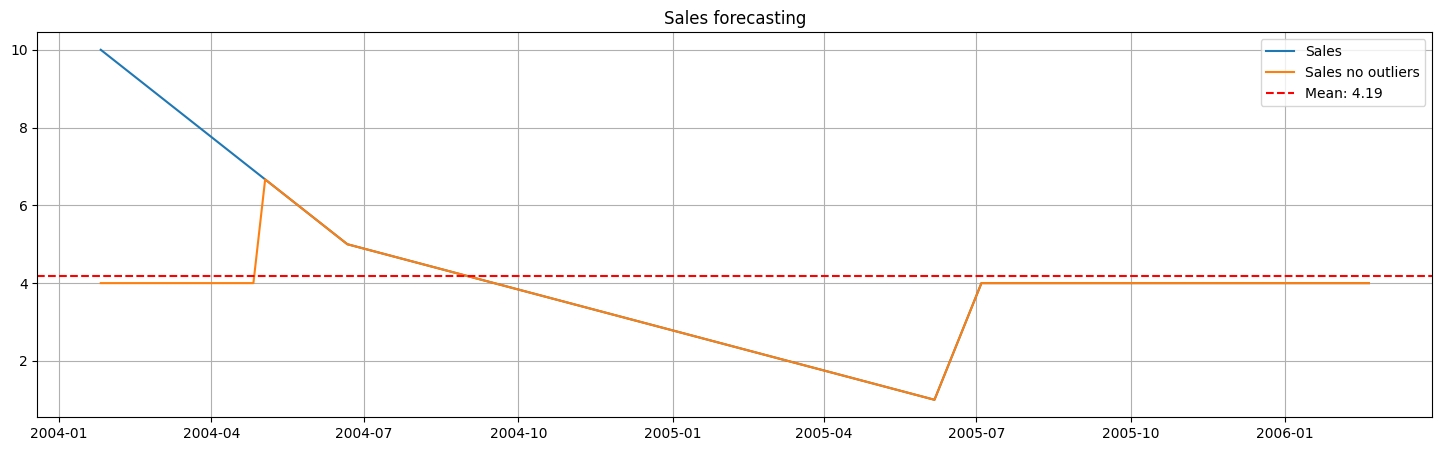

Processing Product ID: 1825
Rows found for Product 1825: 22
Low demand B ...

Percentage outliers:  0.0
Mean : 2.5058823529411764, Median: 2.5483870967741935


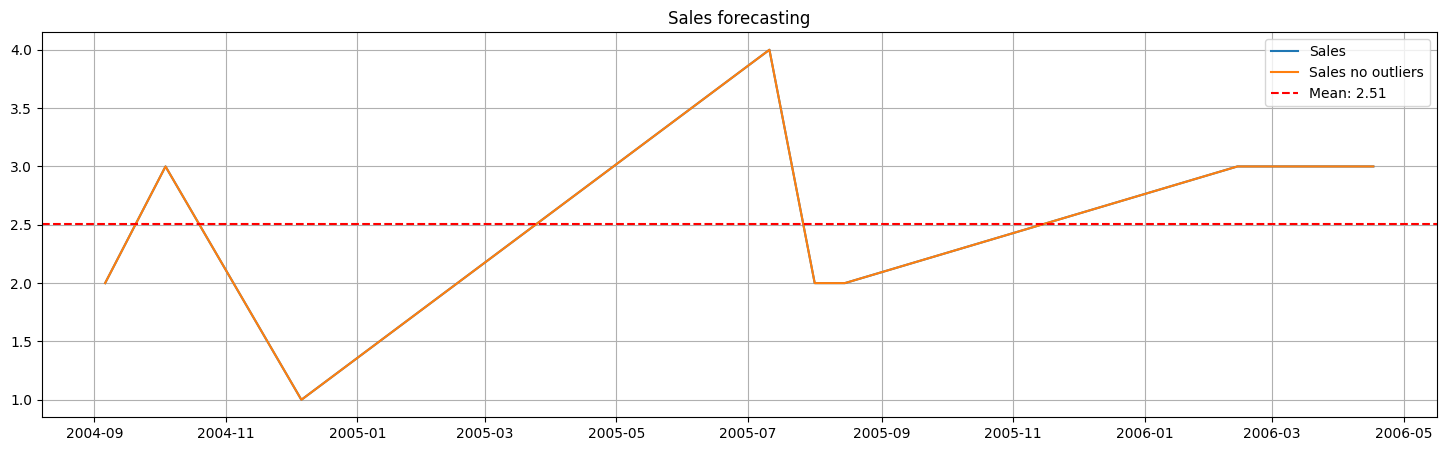

Processing Product ID: 2688
Rows found for Product 2688: 22
Low demand B ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


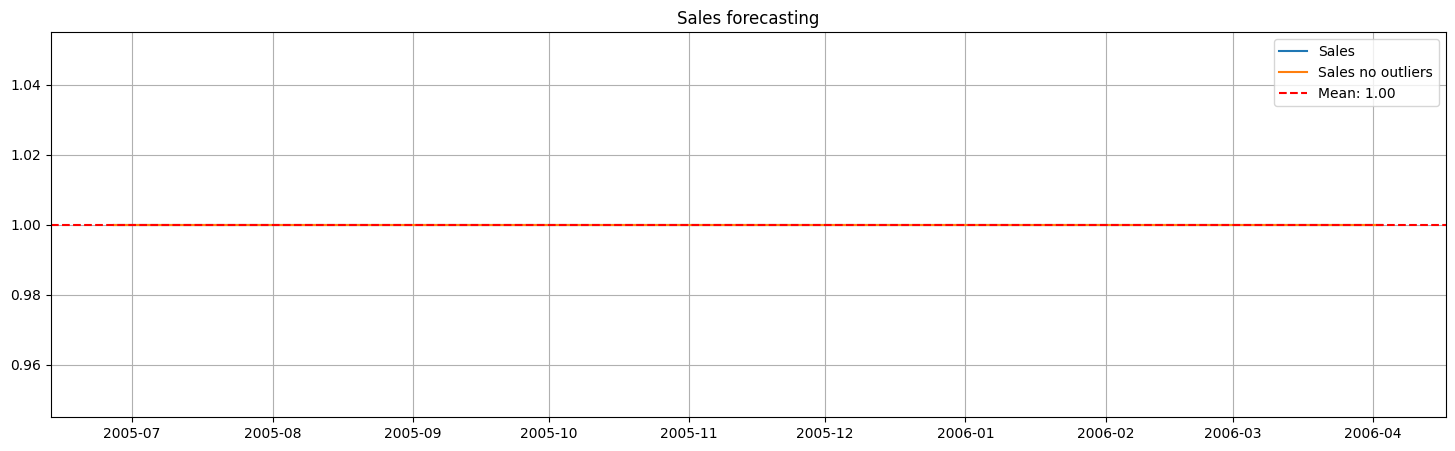

Processing Product ID: 1848
Rows found for Product 1848: 25
Low demand B ...

Percentage outliers:  2.4691358024691357
Mean : 2.087719298245614, Median: 1.0


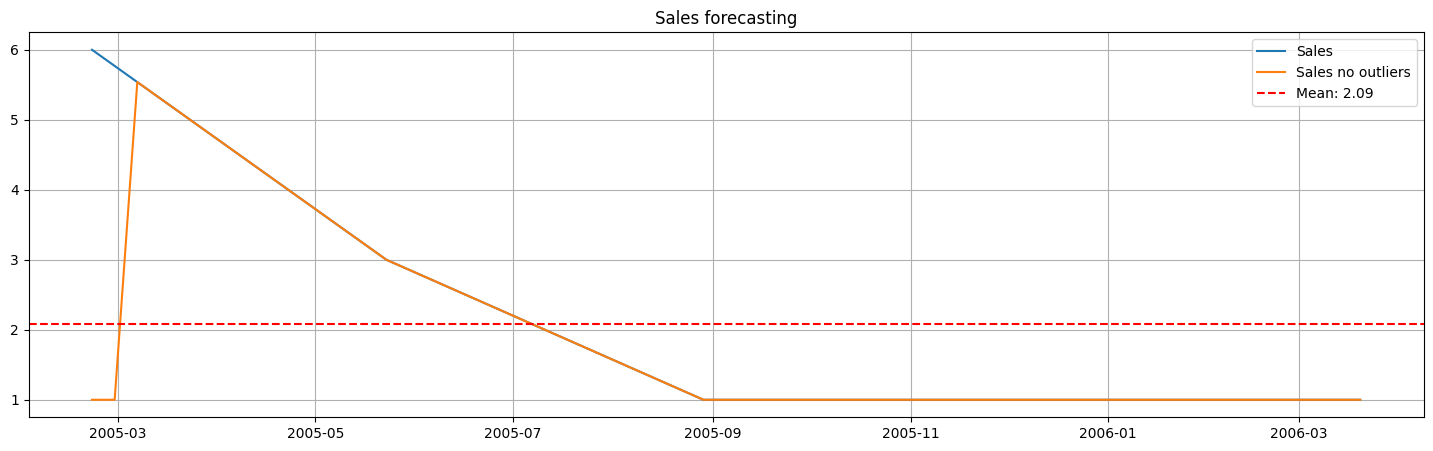

Processing Product ID: 1803
Rows found for Product 1803: 19
Low demand B ...

Percentage outliers:  0.0
Mean : 2.0, Median: 2.0


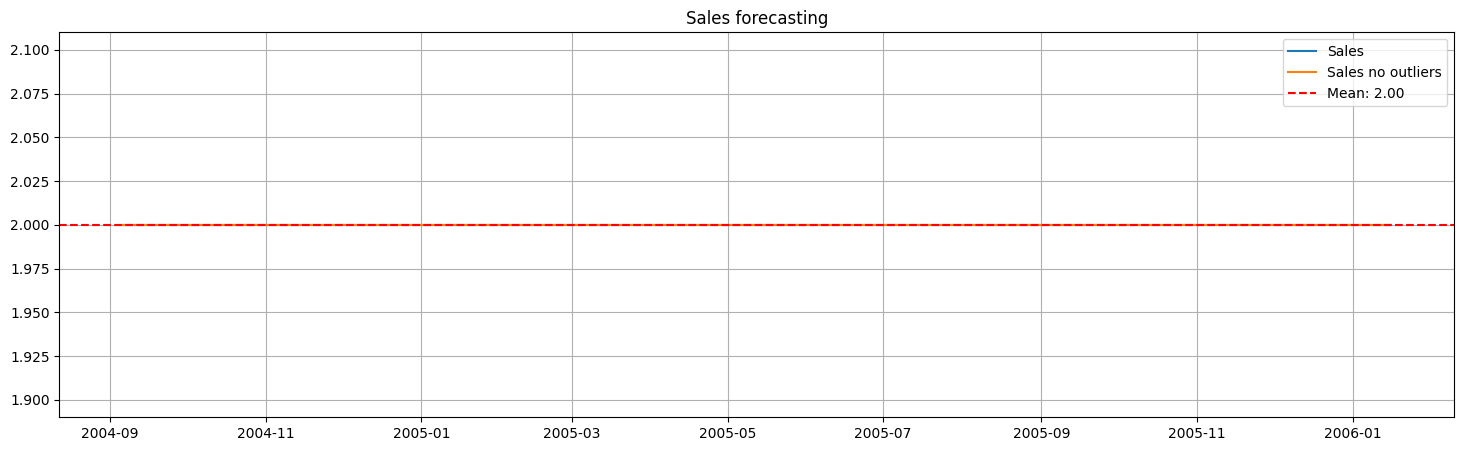

Processing Product ID: 1314
Rows found for Product 1314: 31
Low demand B ...

Percentage outliers:  0.8695652173913043
Mean : 2.599009900990099, Median: 2.6521739130434785


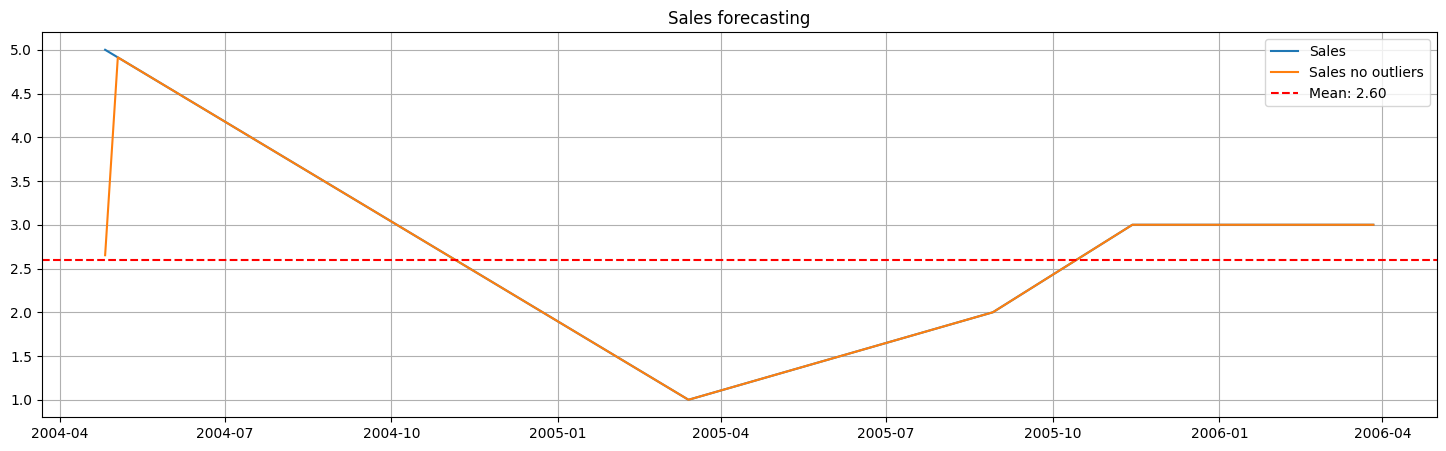

Processing Product ID: 3019
Rows found for Product 3019: 18
Low demand B ...

Percentage outliers:  0.0
Mean : 3.6470588235294117, Median: 2.3181818181818183


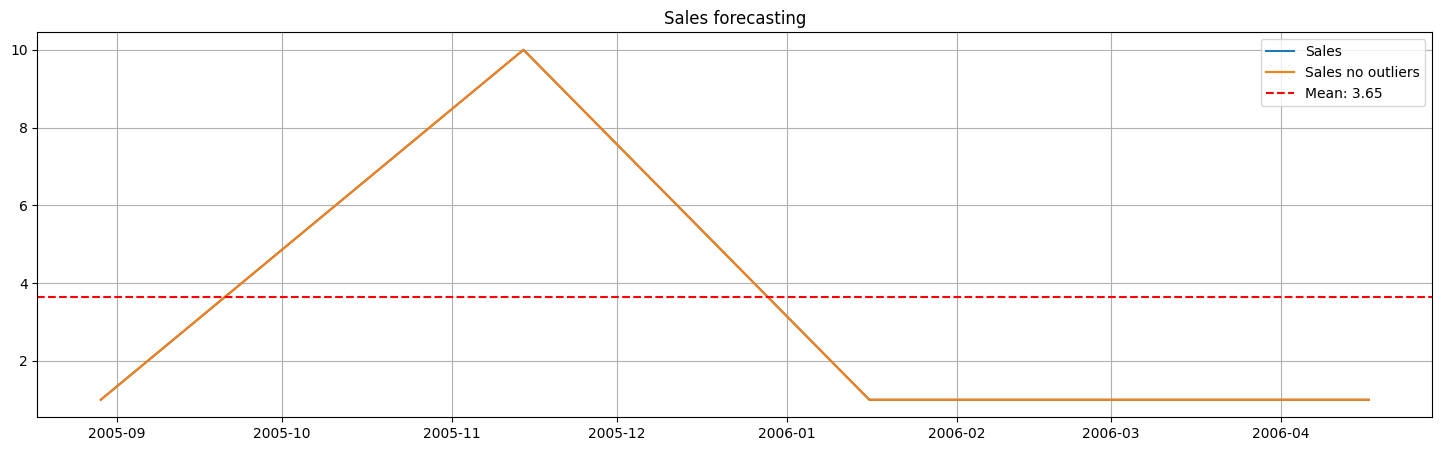

Processing Product ID: 1323
Rows found for Product 1323: 30
Low demand B ...

Percentage outliers:  0.0
Mean : 3.5714285714285716, Median: 2.8157894736842106


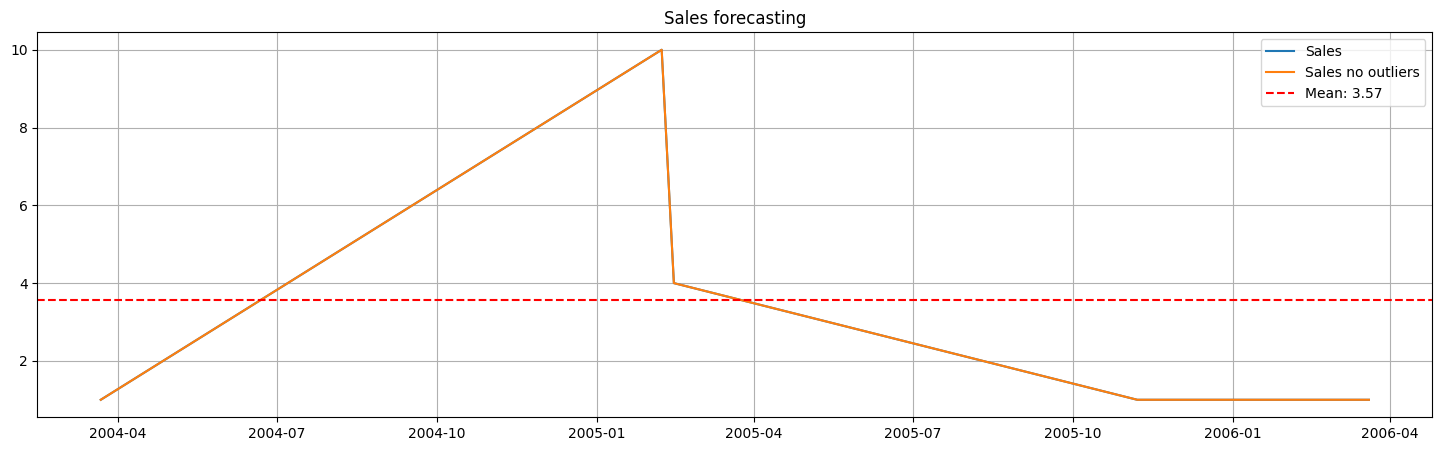

Processing Product ID: 2799
Rows found for Product 2799: 19
Low demand B ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


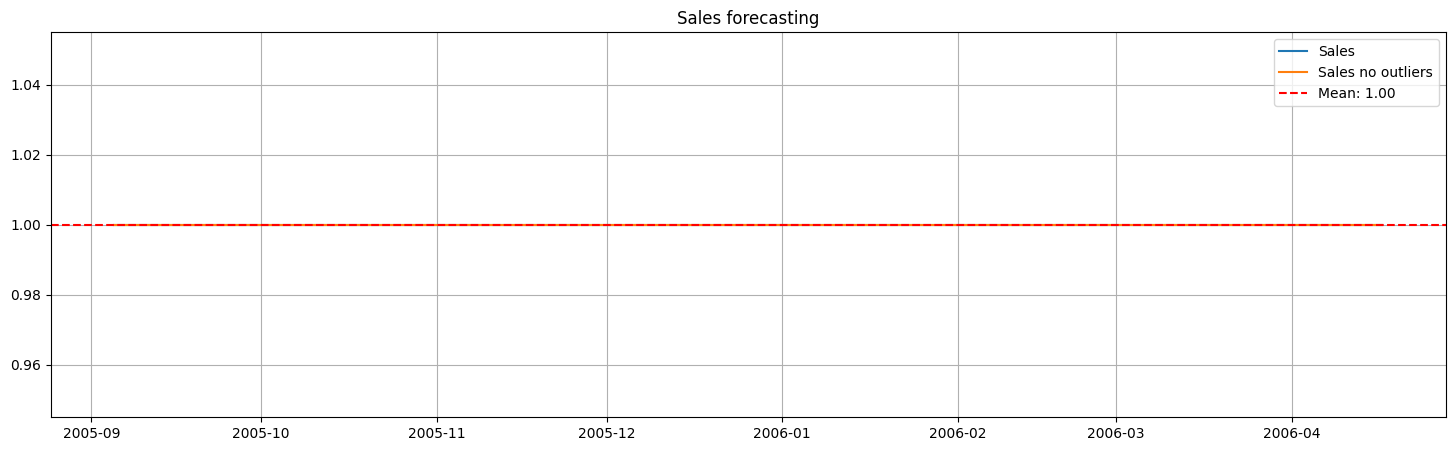

Processing Product ID: 1502
Rows found for Product 1502: 41
Low demand B ...

Percentage outliers:  0.0
Mean : 6.013761467889908, Median: 5.0


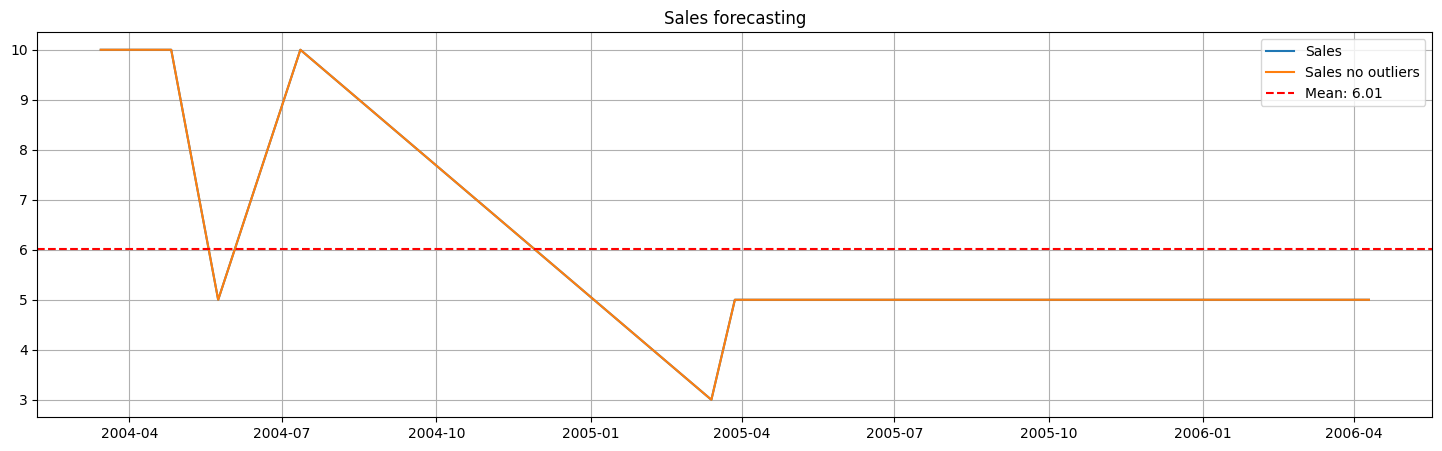

Processing Product ID: 2127
Rows found for Product 2127: 14
Low demand B ...

Processing Product ID: 768
Rows found for Product 768: 44
Low demand B ...

Percentage outliers:  0.0
Mean : 3.0284552845528454, Median: 2.887323943661972


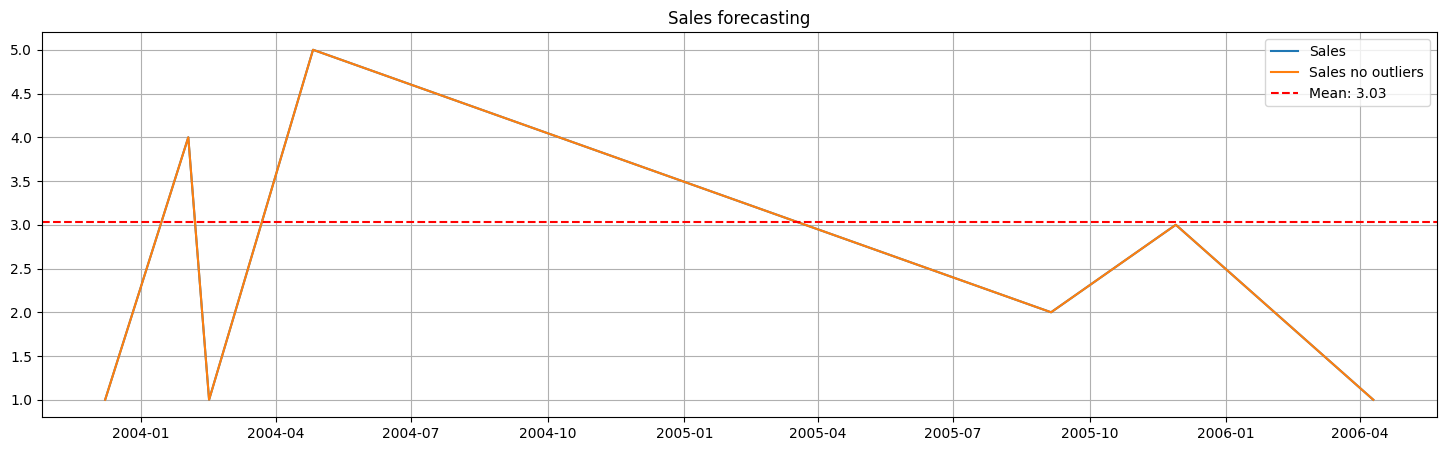

Processing Product ID: 2440
Rows found for Product 2440: 24
Low demand B ...

Percentage outliers:  2.2222222222222223
Mean : 2.1818181818181817, Median: 2.066666666666667


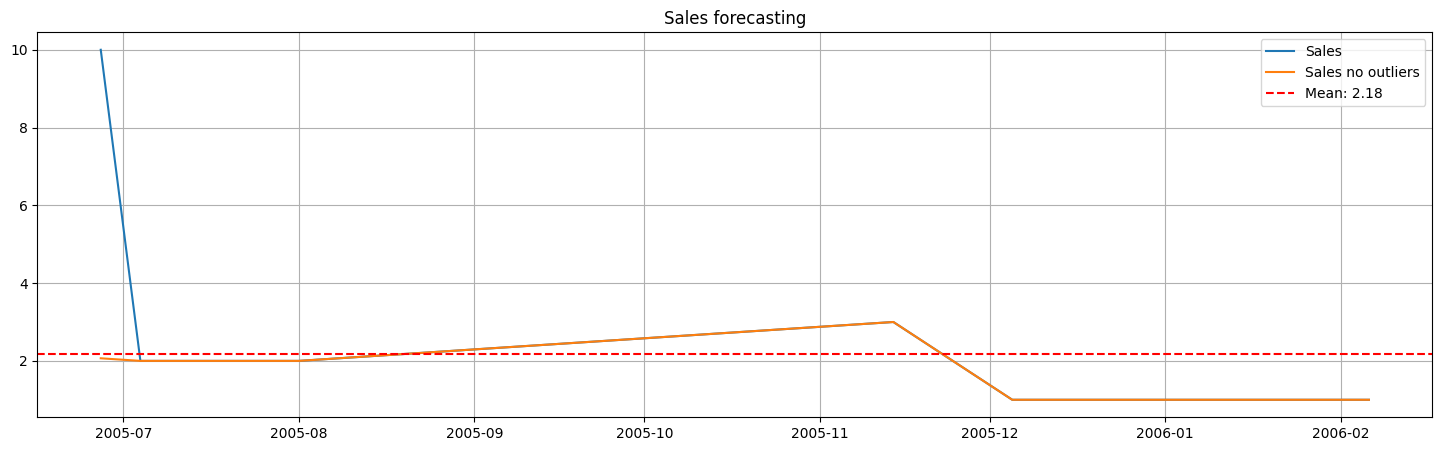

Processing Product ID: 2179
Rows found for Product 2179: 34
Low demand B ...

Percentage outliers:  0.0
Mean : 5.918367346938775, Median: 6.0


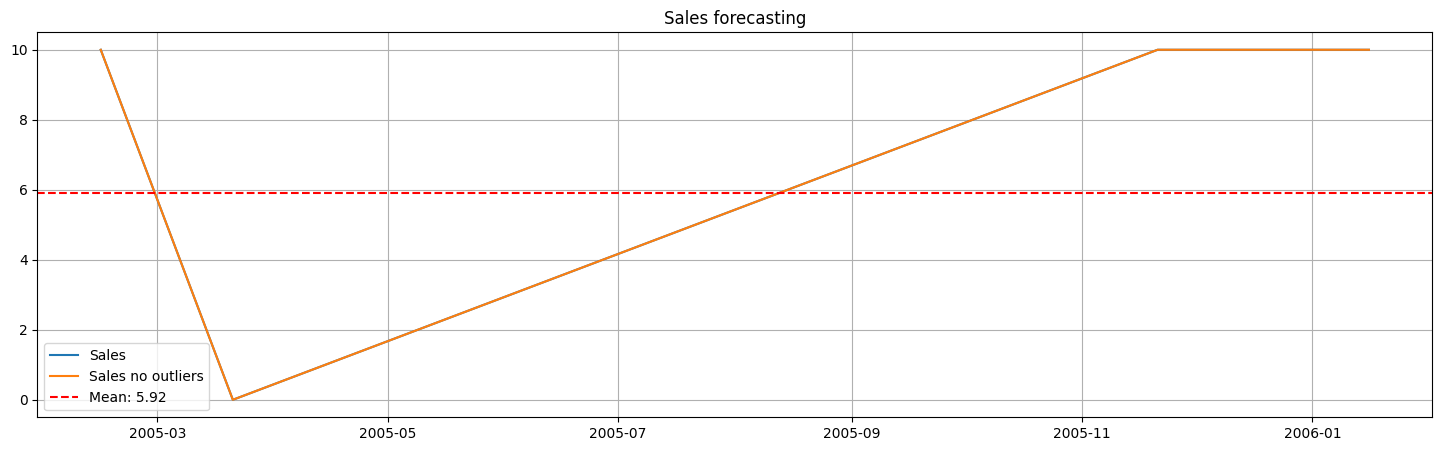

Processing Product ID: 1059
Rows found for Product 1059: 27
Low demand B ...

Percentage outliers:  0.0
Mean : 6.519736842105263, Median: 5.0


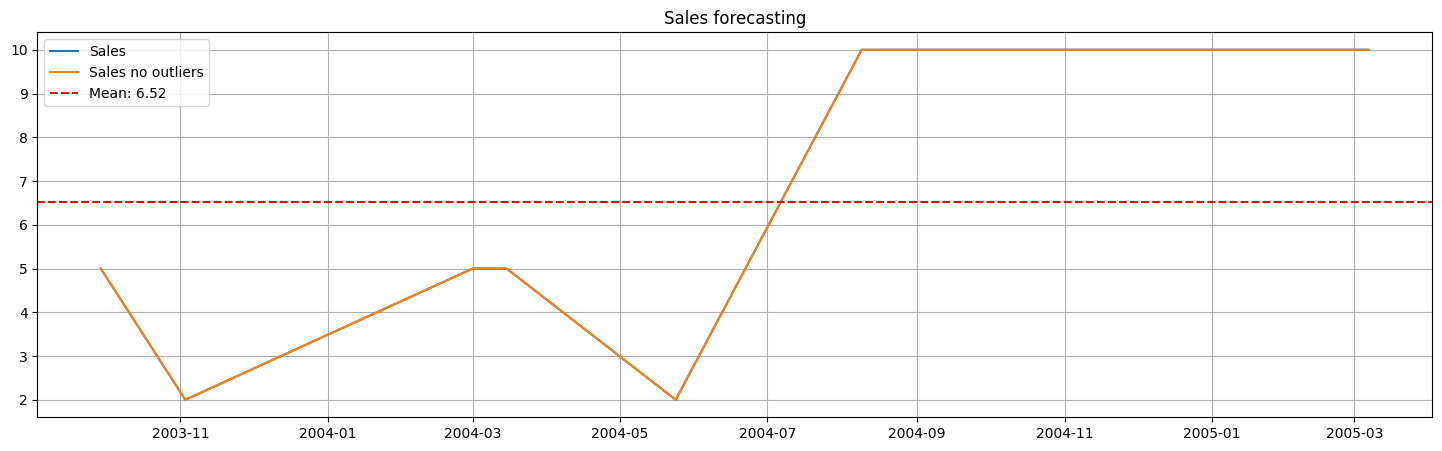

Processing Product ID: 1362
Rows found for Product 1362: 25
Low demand B ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


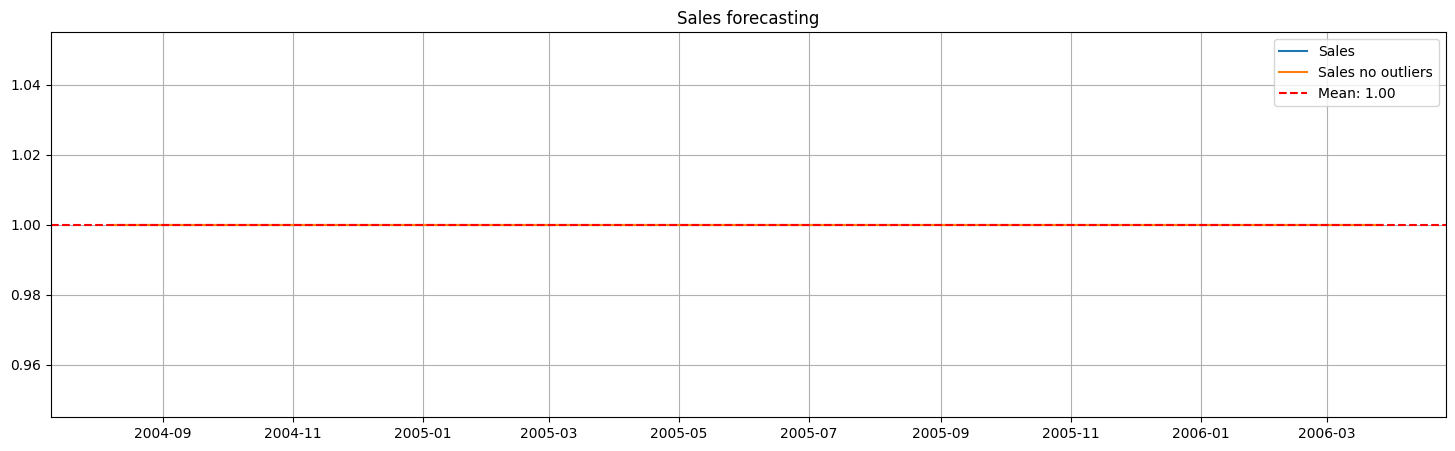

Processing Product ID: 2289
Rows found for Product 2289: 27
Low demand B ...

Percentage outliers:  1.5625
Mean : 1.7796610169491525, Median: 1.5263157894736843


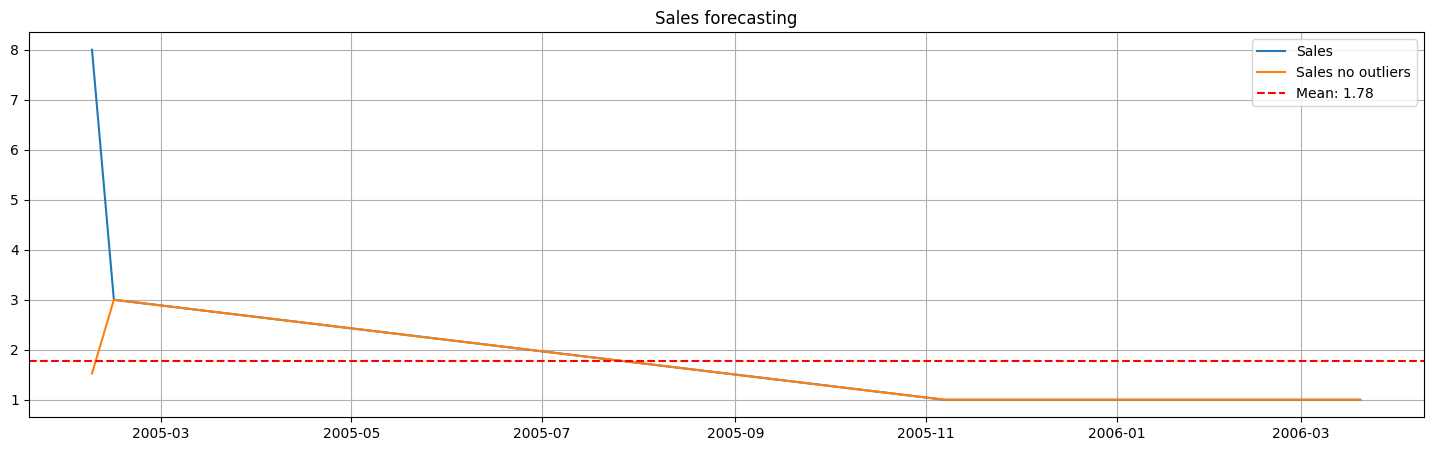

Processing Product ID: 2118
Rows found for Product 2118: 34
Low demand B ...

Percentage outliers:  14.084507042253522
Mean : 4.3478260869565215, Median: 5.0


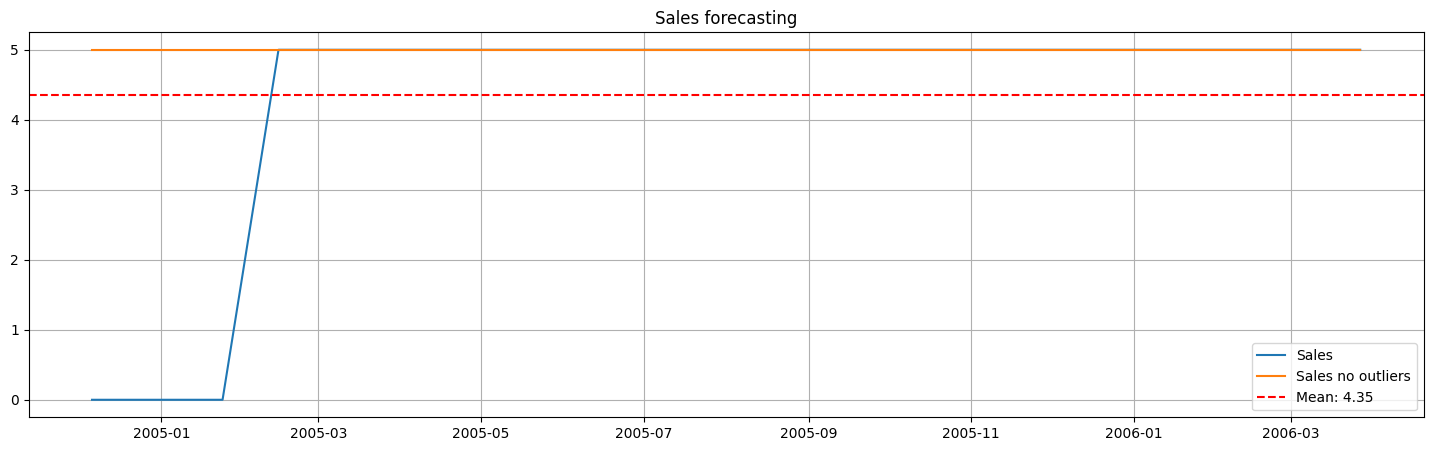

Processing Product ID: 594
Rows found for Product 594: 28
Low demand B ...

Percentage outliers:  0.0
Mean : 7.730769230769231, Median: 6.21875


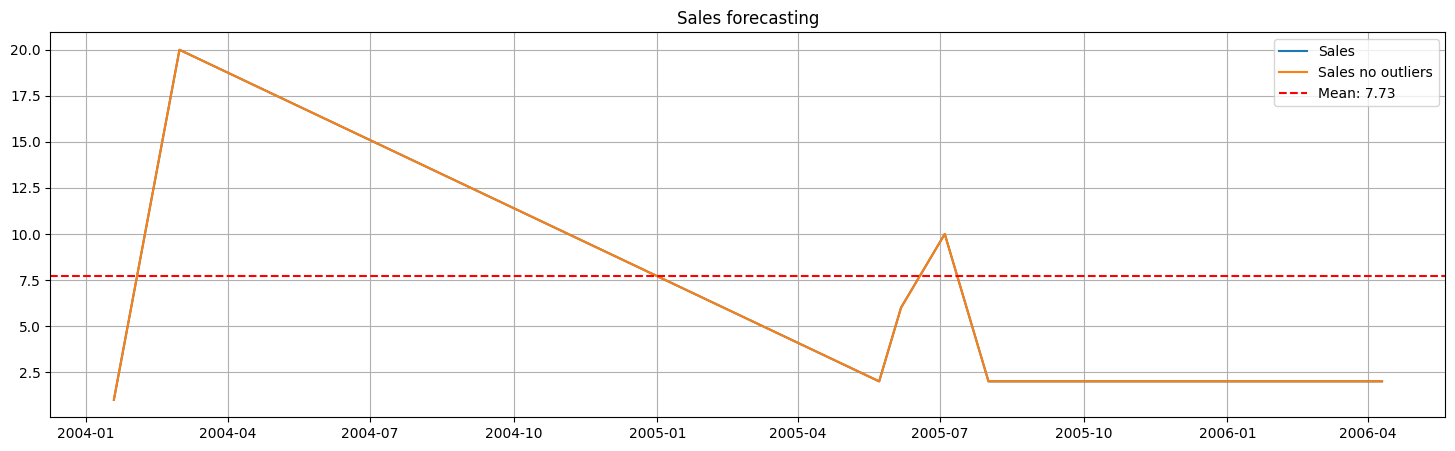

Processing Product ID: 1700
Rows found for Product 1700: 32
Low demand B ...

Percentage outliers:  0.0
Mean : 2.4444444444444446, Median: 2.5531914893617023


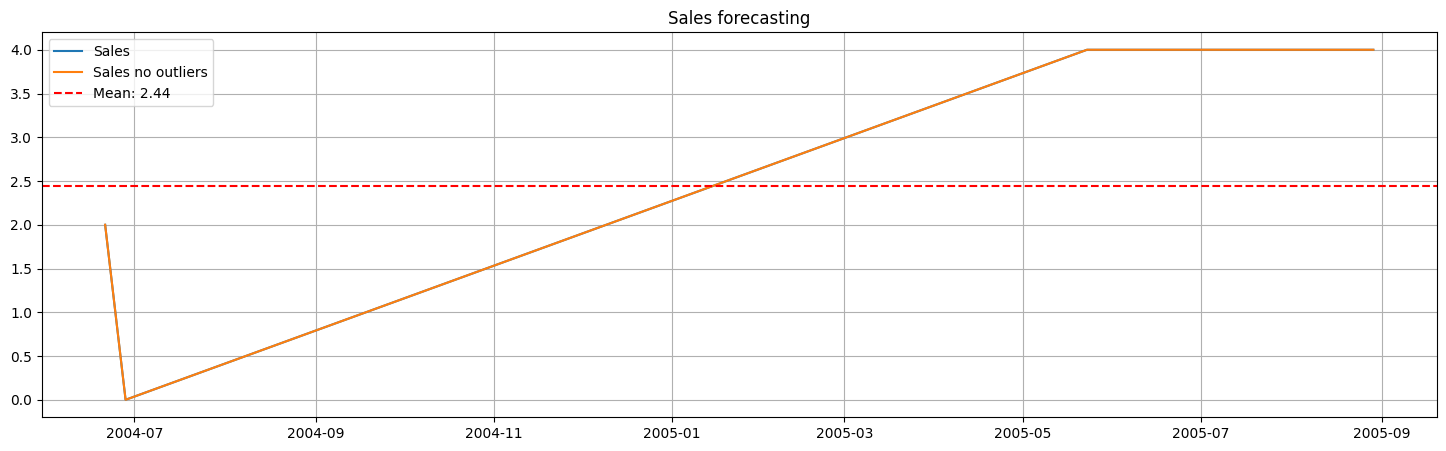

Processing Product ID: 888
Rows found for Product 888: 38
Low demand B ...

Percentage outliers:  3.7037037037037033
Mean : 1.7943548387096775, Median: 1.5831826401446656


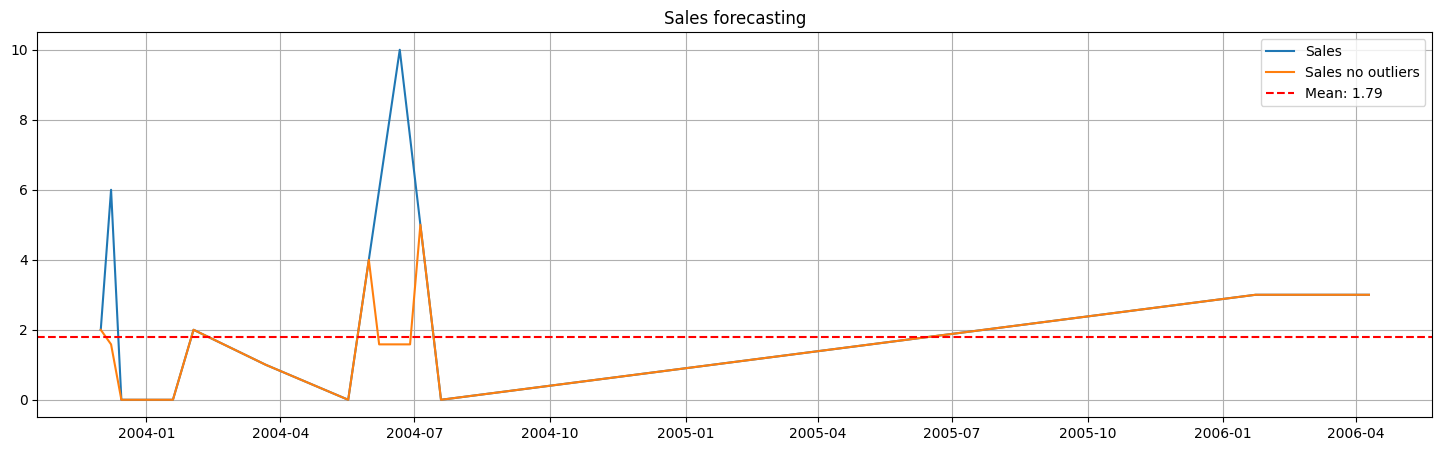

Processing Product ID: 1089
Rows found for Product 1089: 32
Low demand B ...

Percentage outliers:  4.225352112676056
Mean : 3.1838235294117645, Median: 2.809090909090909


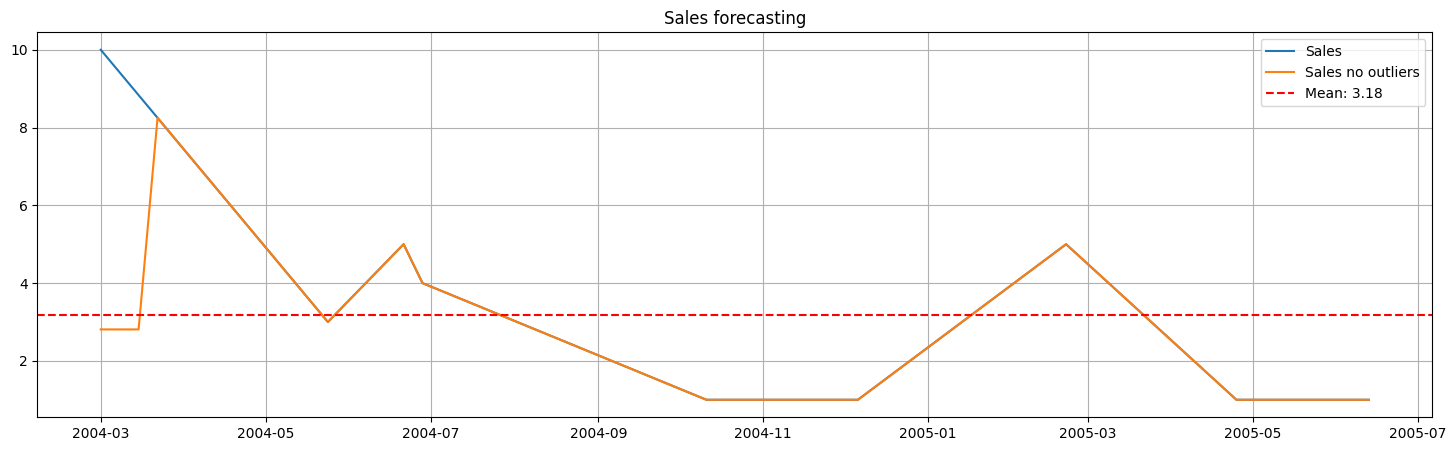

Processing Product ID: 2271
Rows found for Product 2271: 24
Low demand B ...

Percentage outliers:  0.0
Mean : 6.0625, Median: 6.770833333333333


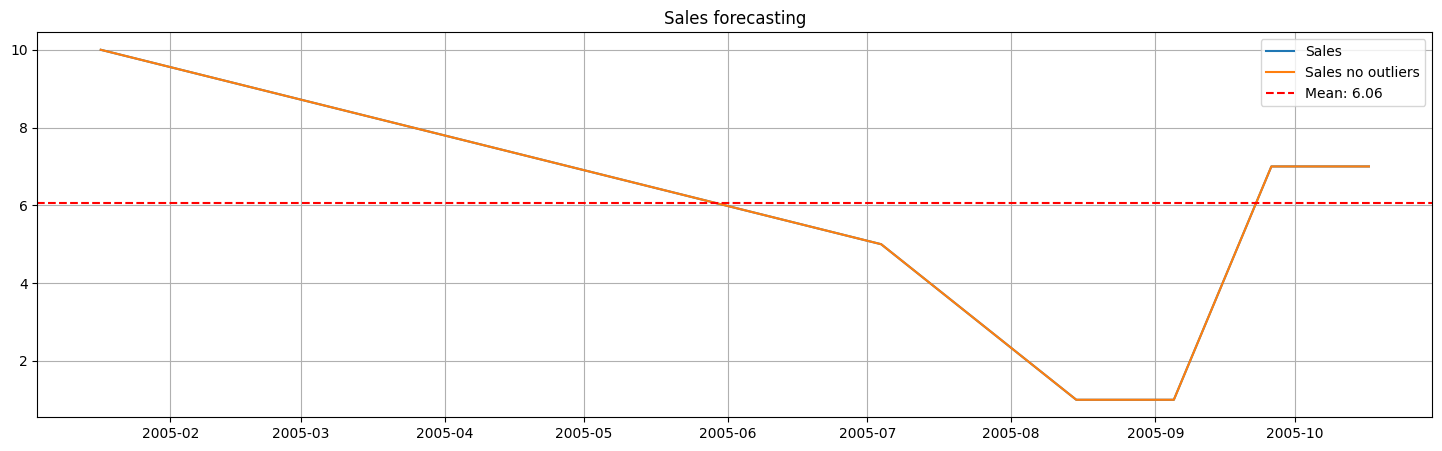

Processing Product ID: 1573
Rows found for Product 1573: 19
Low demand B ...

Percentage outliers:  0.0
Mean : 4.4772727272727275, Median: 4.911538461538462


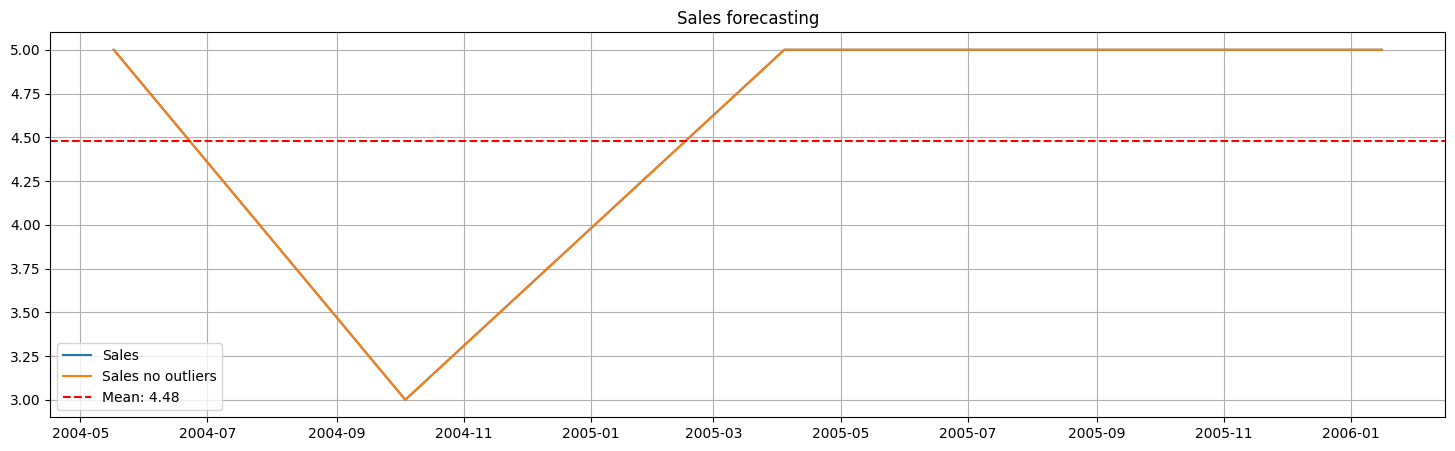

Processing Product ID: 2325
Rows found for Product 2325: 16
Low demand B ...

Percentage outliers:  0.0
Mean : 7.211864406779661, Median: 7.199999999999999


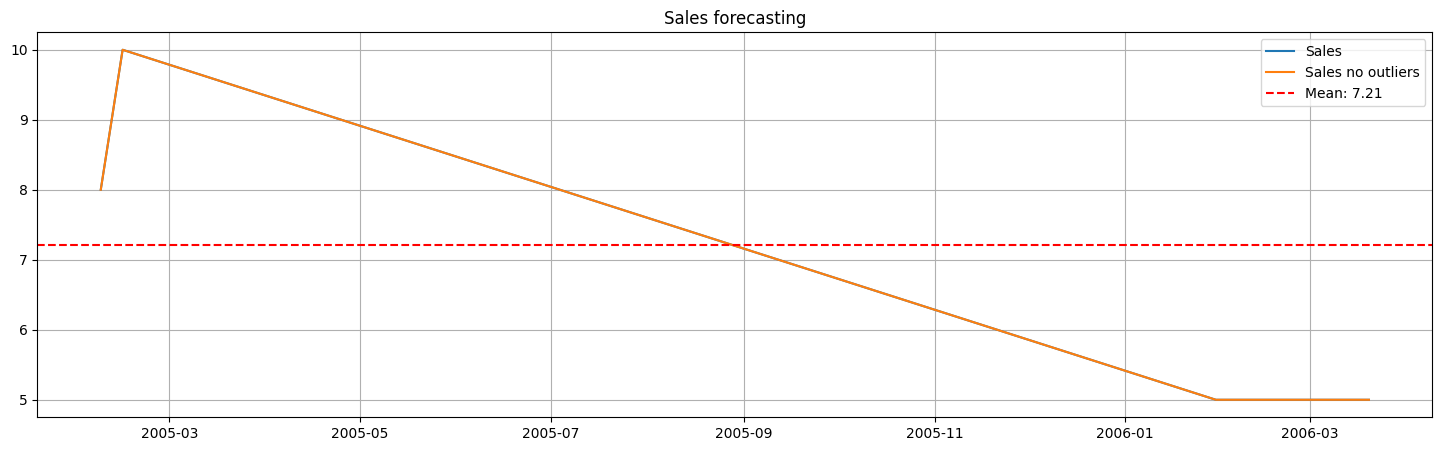

Processing Product ID: 2928
Rows found for Product 2928: 30
Low demand B ...

Percentage outliers:  0.0
Mean : 3.8048780487804876, Median: 5.0


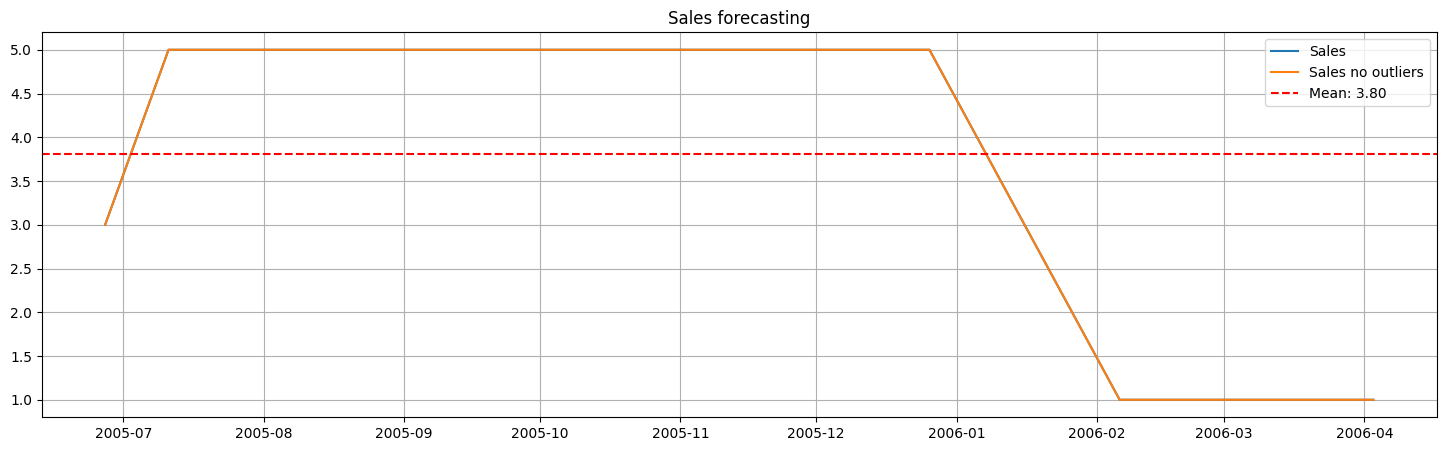

Processing Product ID: 2274
Rows found for Product 2274: 32
Low demand B ...

Percentage outliers:  0.0
Mean : 0.9130434782608697, Median: 0.8461538461538463


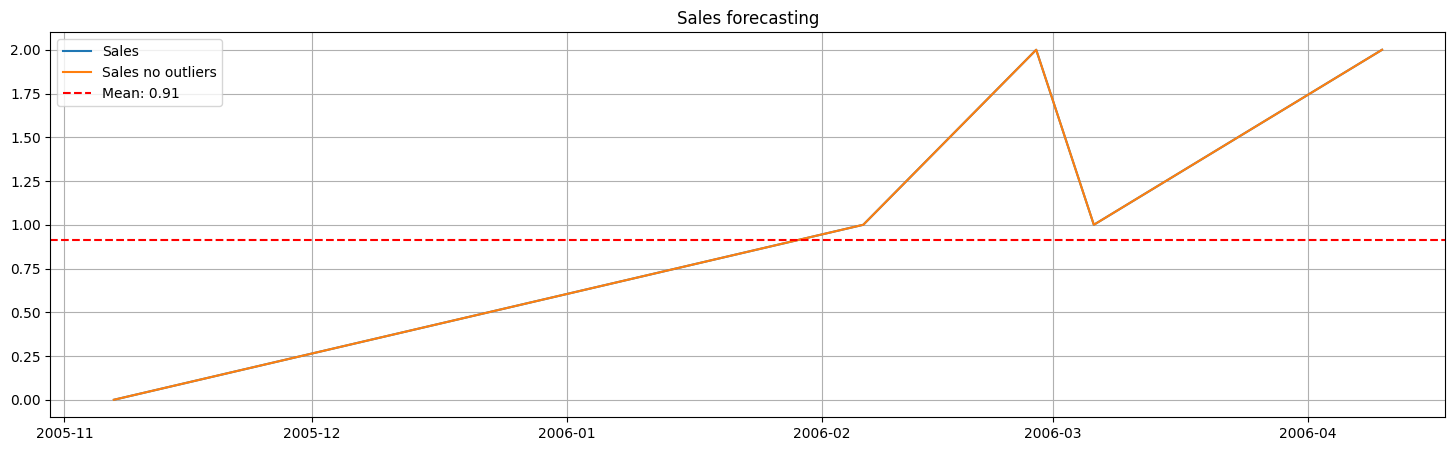

Processing Product ID: 479
Rows found for Product 479: 36
Low demand B ...

Percentage outliers:  0.0
Mean : 3.0121951219512195, Median: 2.3333333333333335


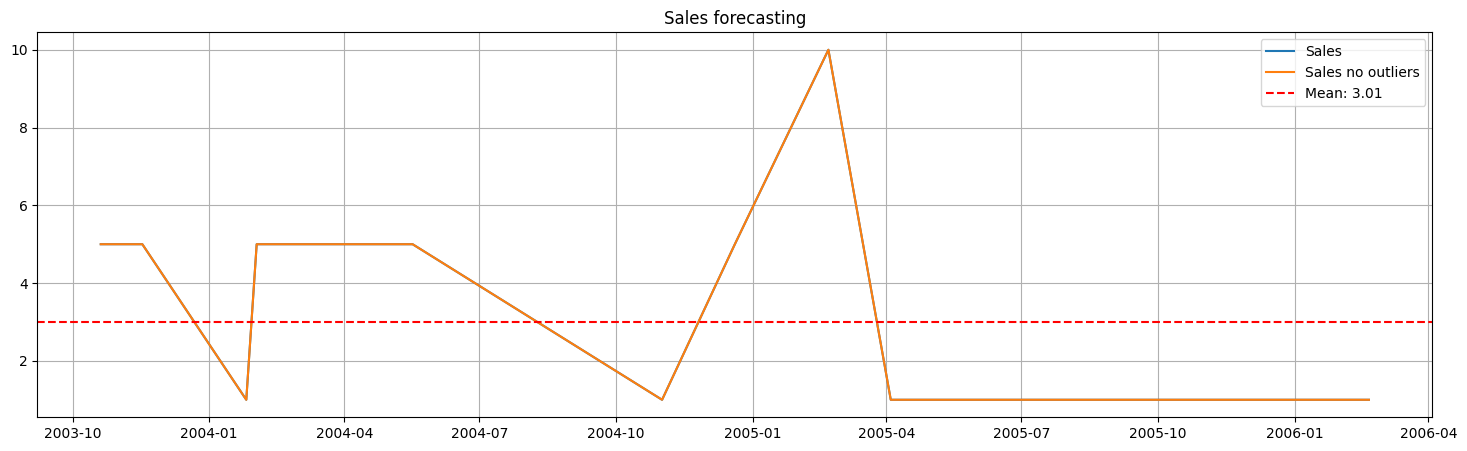

Processing Product ID: 2708
Rows found for Product 2708: 14
Low demand B ...

Percentage outliers:  0.0
Mean : 2.0, Median: 2.0


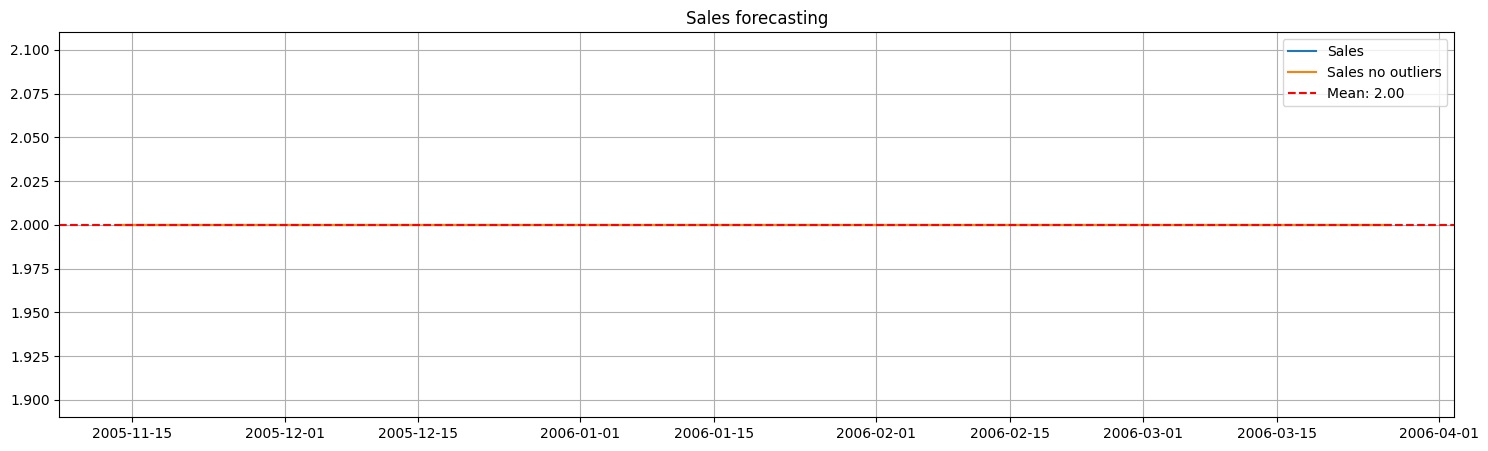

Processing Product ID: 2608
Rows found for Product 2608: 19
Low demand B ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


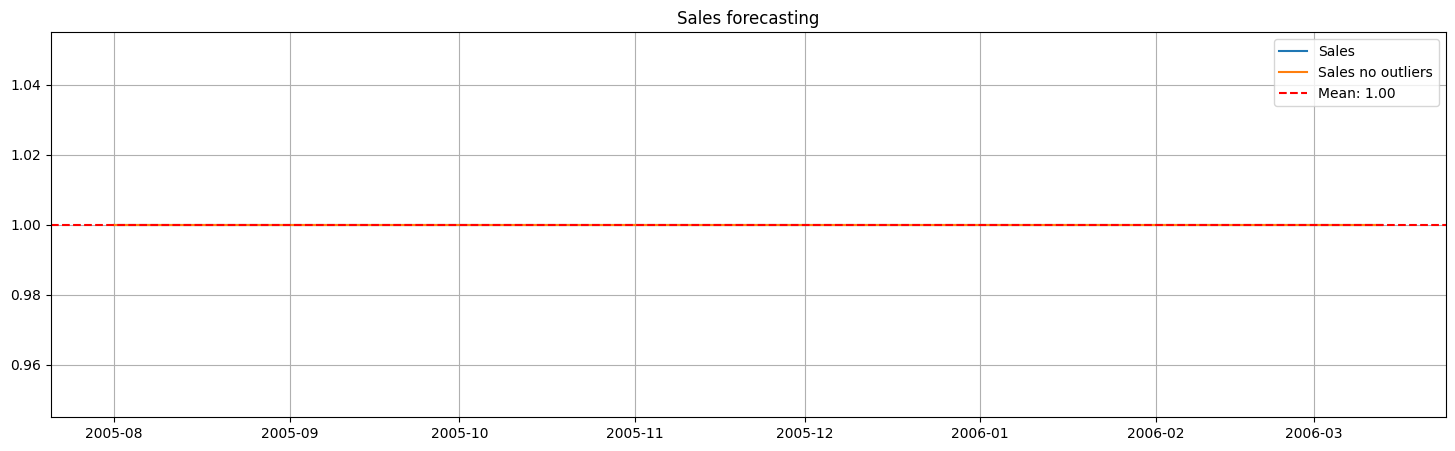

Processing Product ID: 1470
Rows found for Product 1470: 19
Low demand B ...

Percentage outliers:  0.0
Mean : 5.0, Median: 5.0


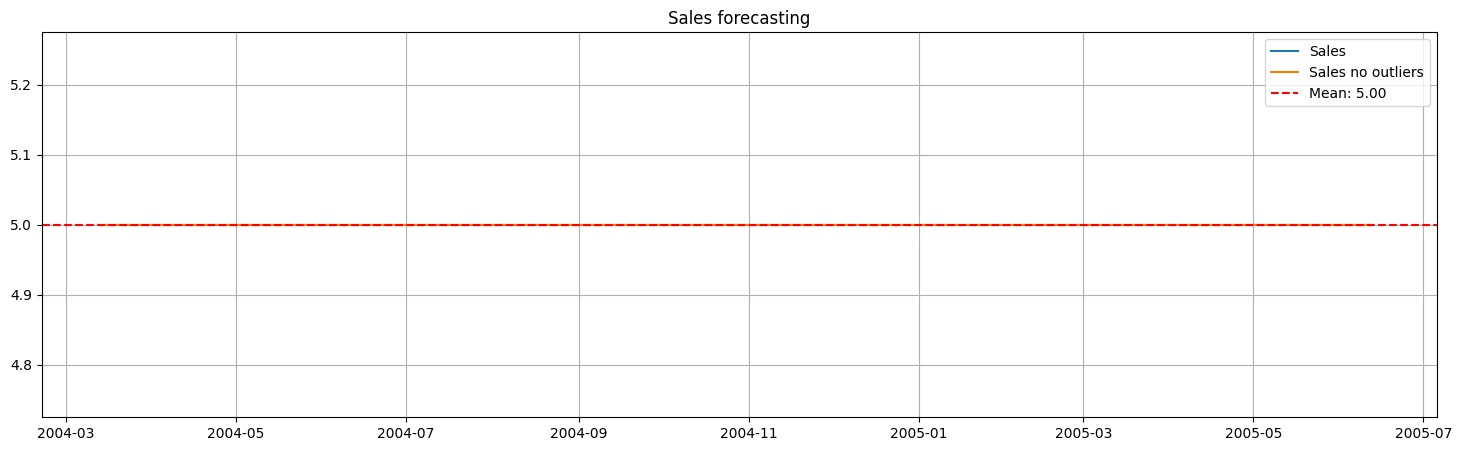

Processing Product ID: 1613
Rows found for Product 1613: 10
Low demand B ...

Percentage outliers:  0.0
Mean : 2.0625, Median: 1.5


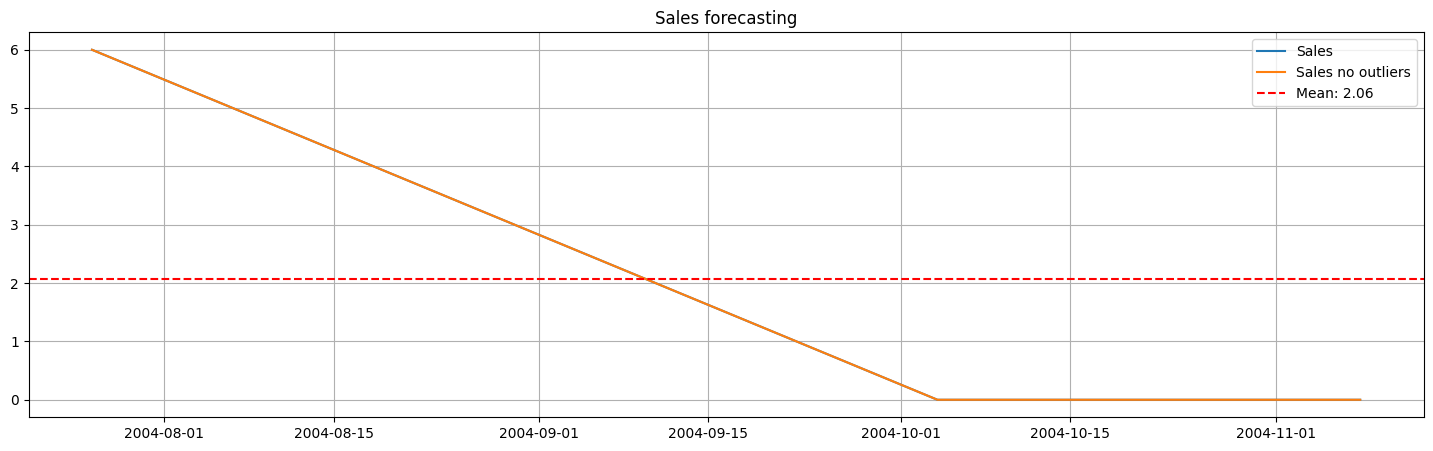

Processing Product ID: 642
Rows found for Product 642: 43
Low demand B ...

Percentage outliers:  4.651162790697675
Mean : 1.503875968992248, Median: 1.3170731707317074


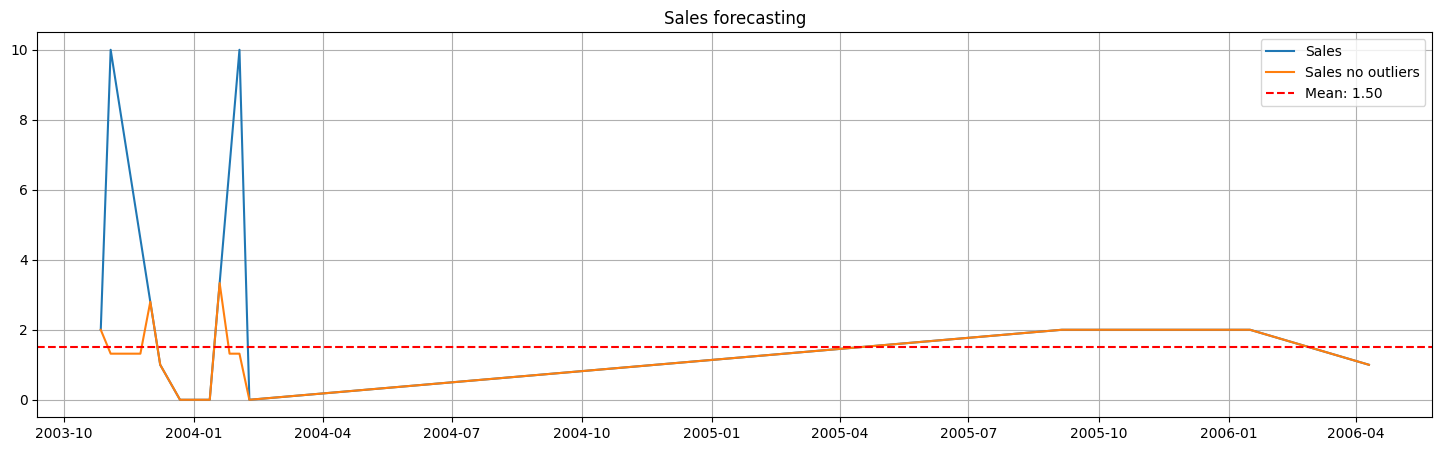

Processing Product ID: 2695
Rows found for Product 2695: 18
Low demand B ...

Percentage outliers:  0.0
Mean : 2.9390243902439024, Median: 3.142857142857143


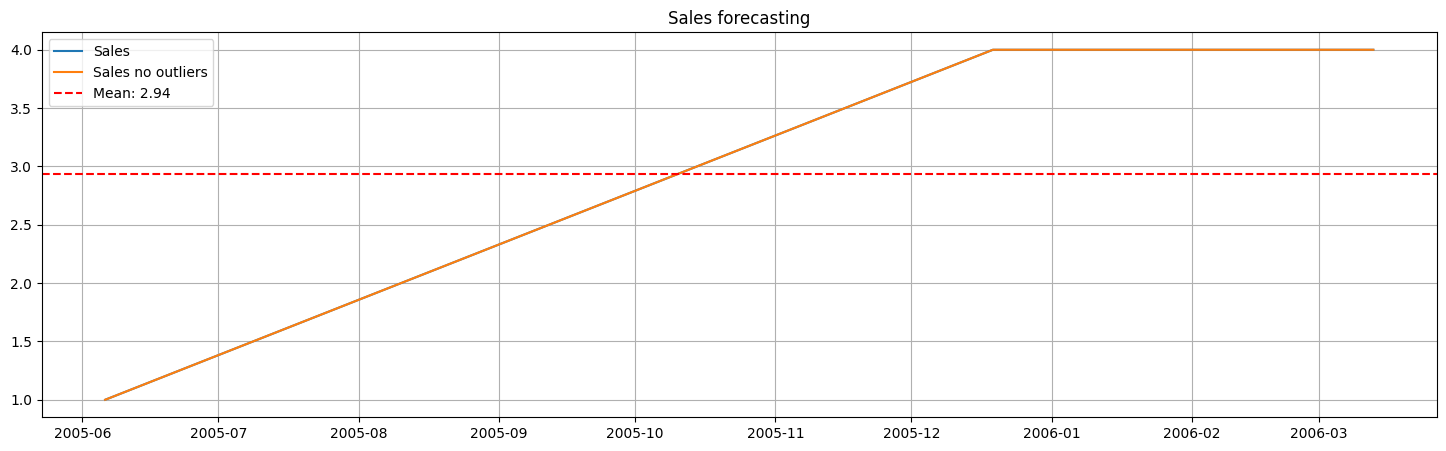

Processing Product ID: 1738
Rows found for Product 1738: 17
Low demand B ...

Percentage outliers:  0.0
Mean : 3.1428571428571423, Median: 2.791666666666667


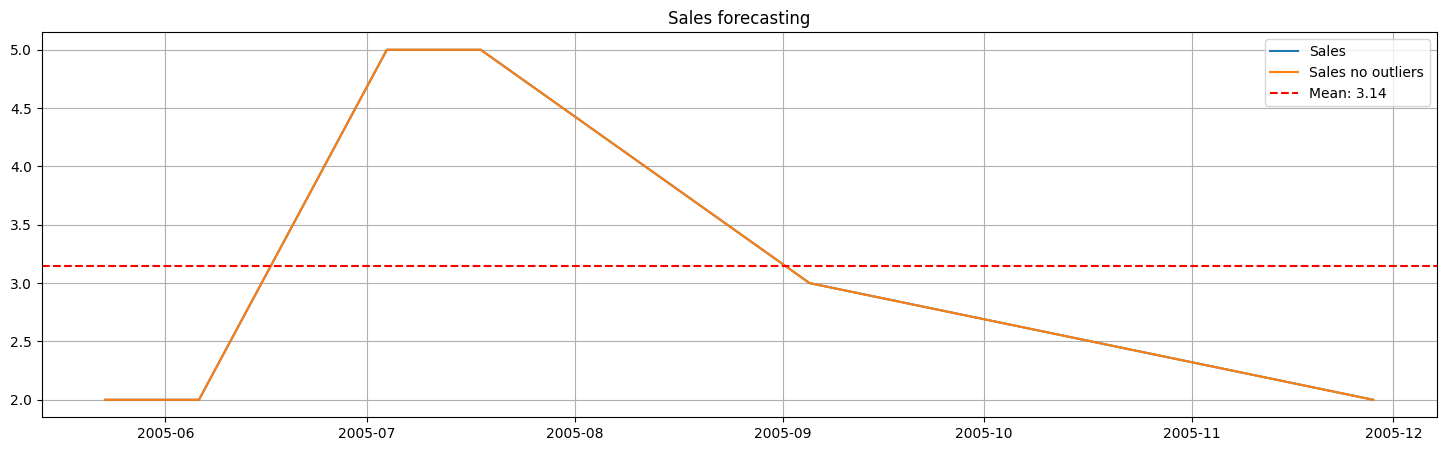

Processing Product ID: 2162
Rows found for Product 2162: 25
Low demand B ...

Percentage outliers:  0.0
Mean : 3.408333333333333, Median: 3.2727272727272725


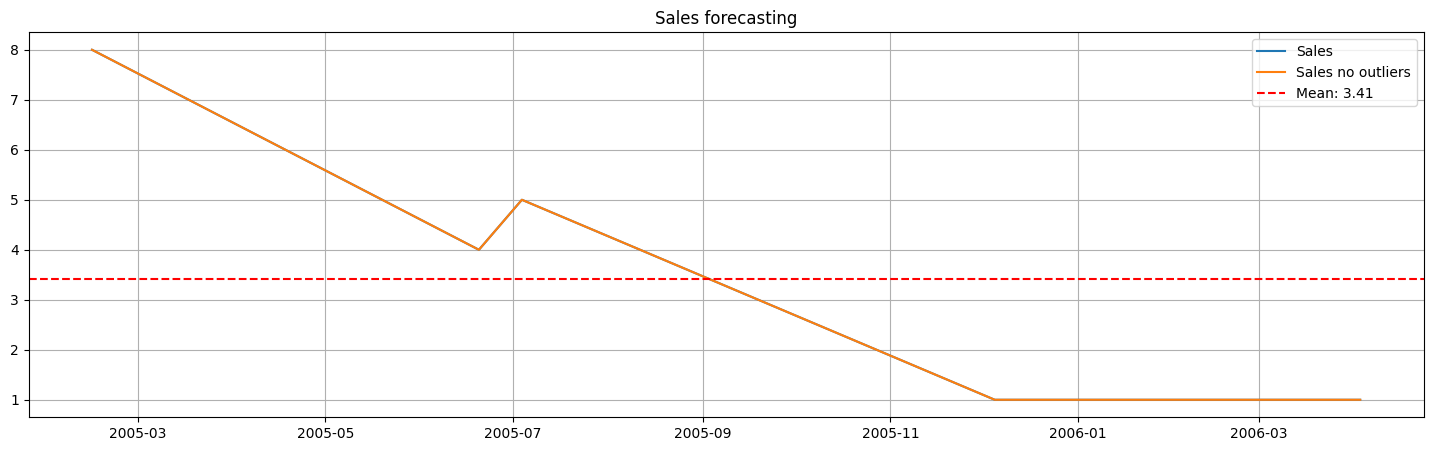

Processing Product ID: 288
Rows found for Product 288: 19
Low demand B ...

Percentage outliers:  0.0
Mean : 6.956521739130435, Median: 4.529411764705882


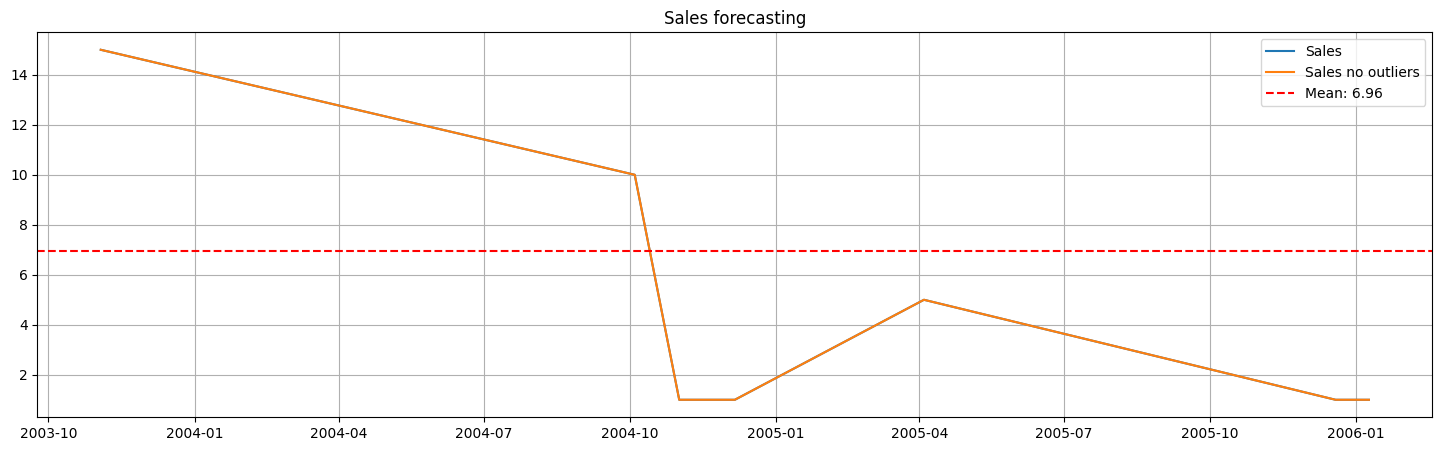

Processing Product ID: 3048
Rows found for Product 3048: 16
Low demand B ...

Percentage outliers:  0.0
Mean : 3.0, Median: 3.0


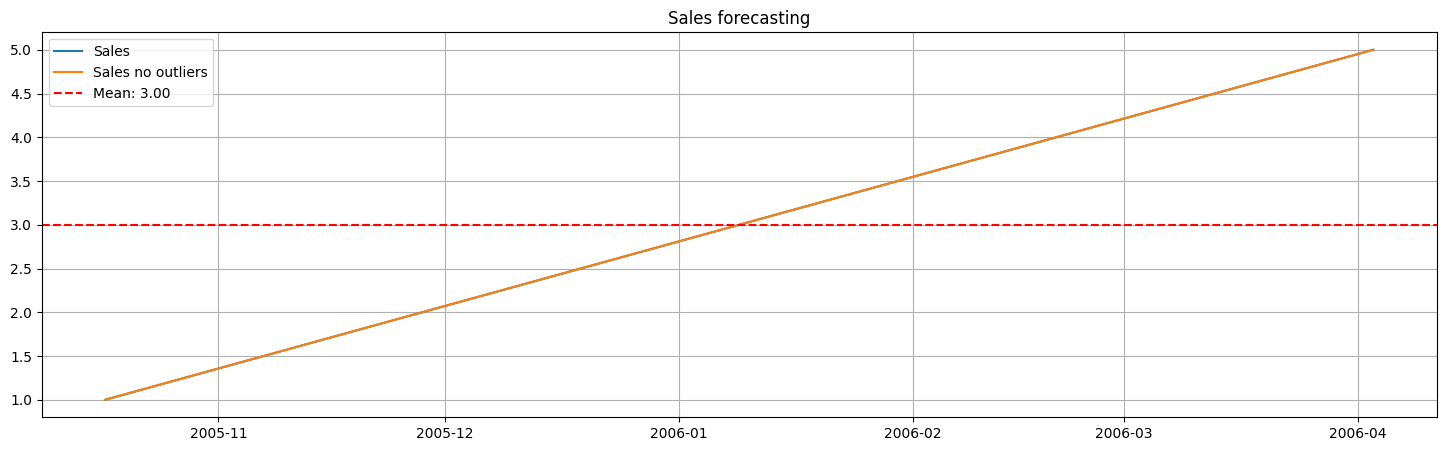

Processing Product ID: 605
Rows found for Product 605: 21
Low demand B ...

Percentage outliers:  3.6363636363636362
Mean : 5.163636363636364, Median: 4.154761904761904


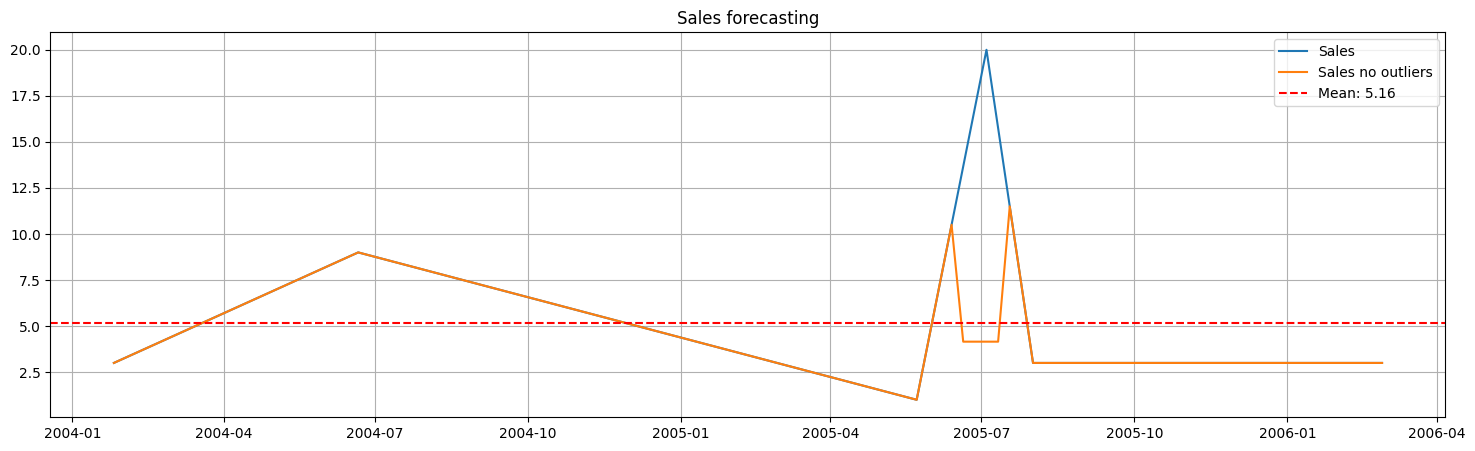

Processing Product ID: 1310
Rows found for Product 1310: 15
Low demand B ...

Percentage outliers:  8.333333333333332
Mean : 8.802631578947368, Median: 10.0


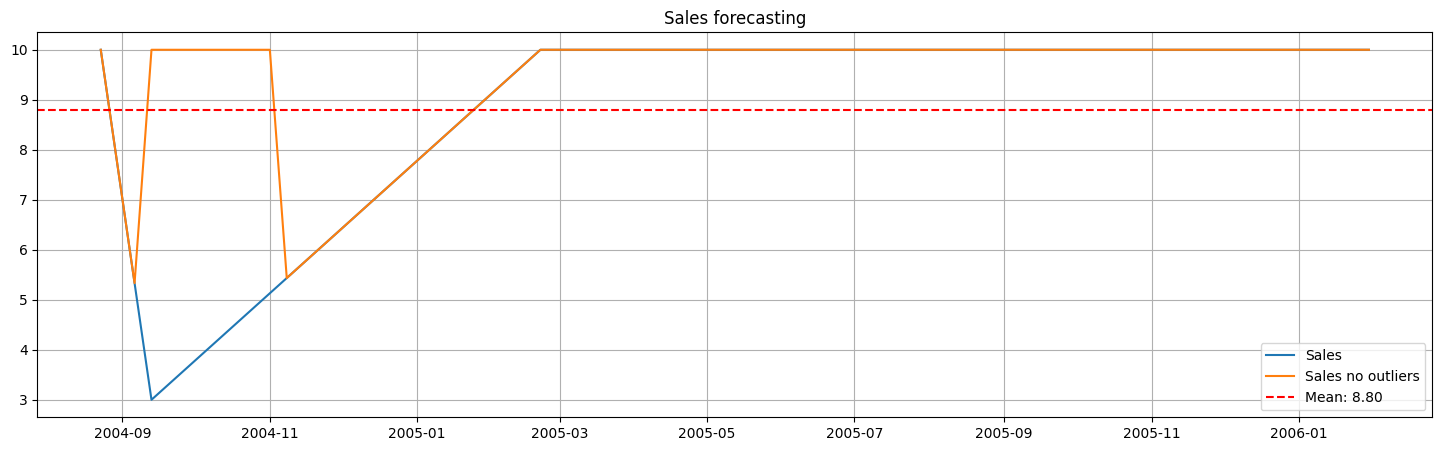

Processing Product ID: 2914
Rows found for Product 2914: 16
Low demand B ...

Percentage outliers:  17.94871794871795
Mean : 1.4705882352941178, Median: 1.0


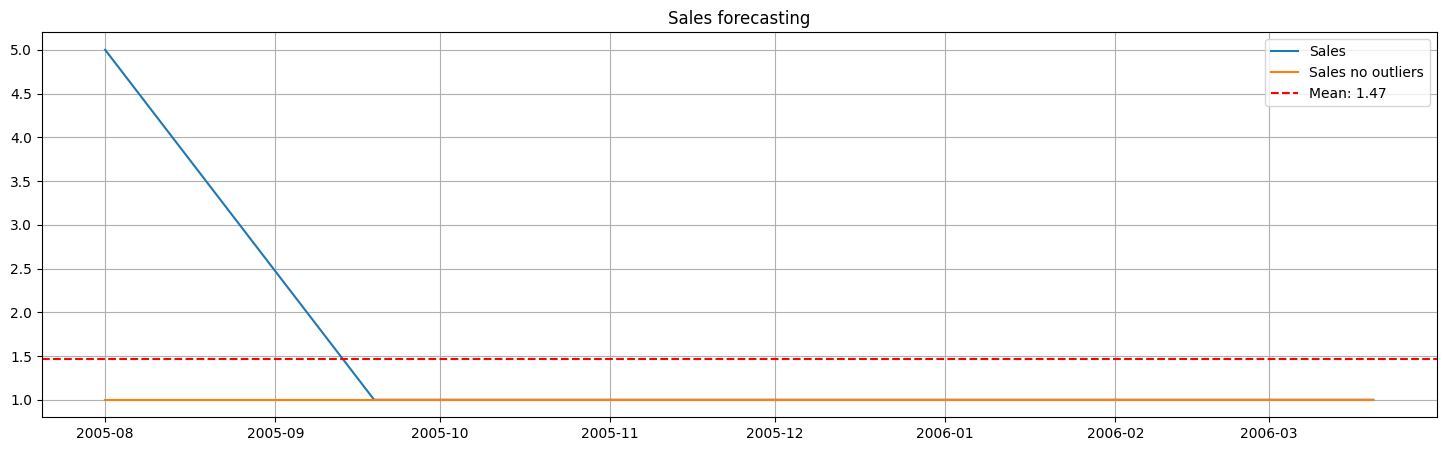

Processing Product ID: 2344
Rows found for Product 2344: 12
Low demand B ...

Percentage outliers:  3.125
Mean : 0.039473684210526314, Median: 0.0


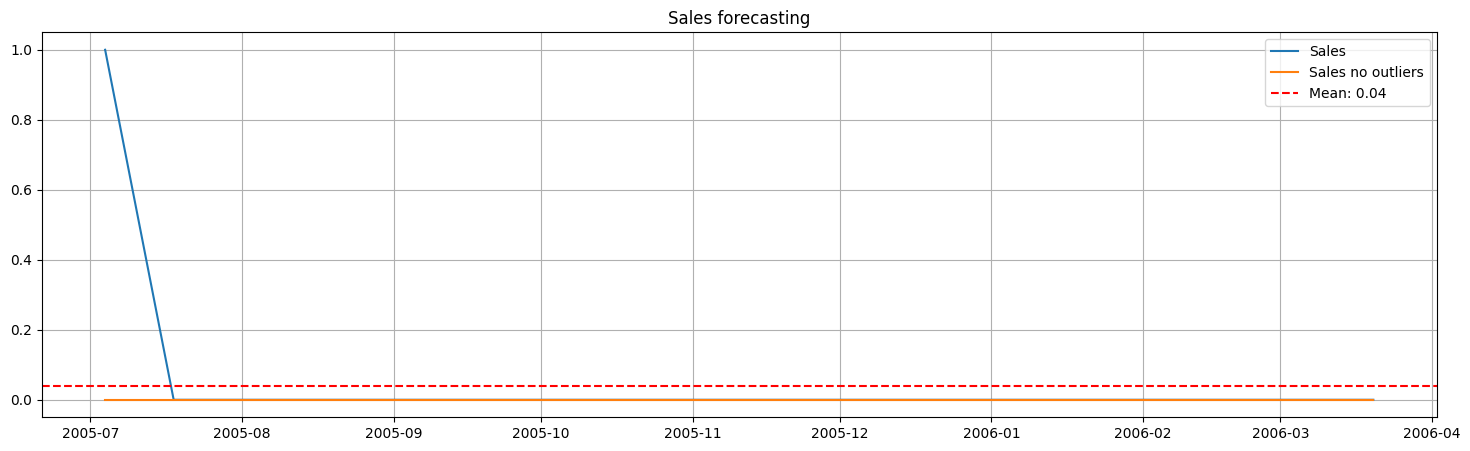

Processing Product ID: 2132
Rows found for Product 2132: 15
Low demand B ...

Percentage outliers:  2.7777777777777777
Mean : 1.7916666666666667, Median: 2.0


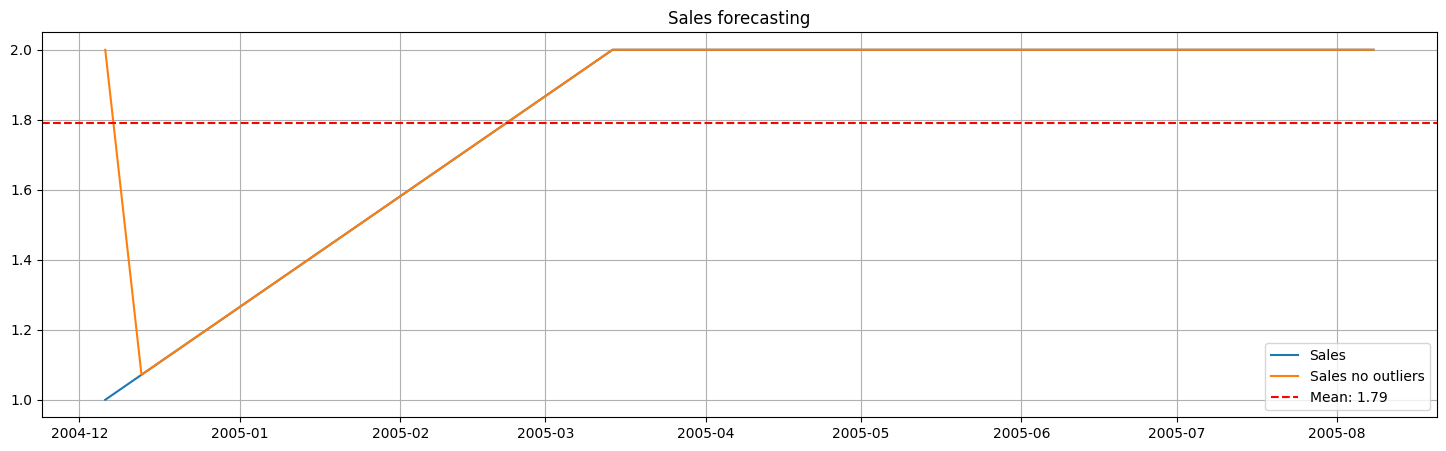

Processing Product ID: 2048
Rows found for Product 2048: 16
Low demand B ...

Percentage outliers:  0.0
Mean : 5.0, Median: 5.0


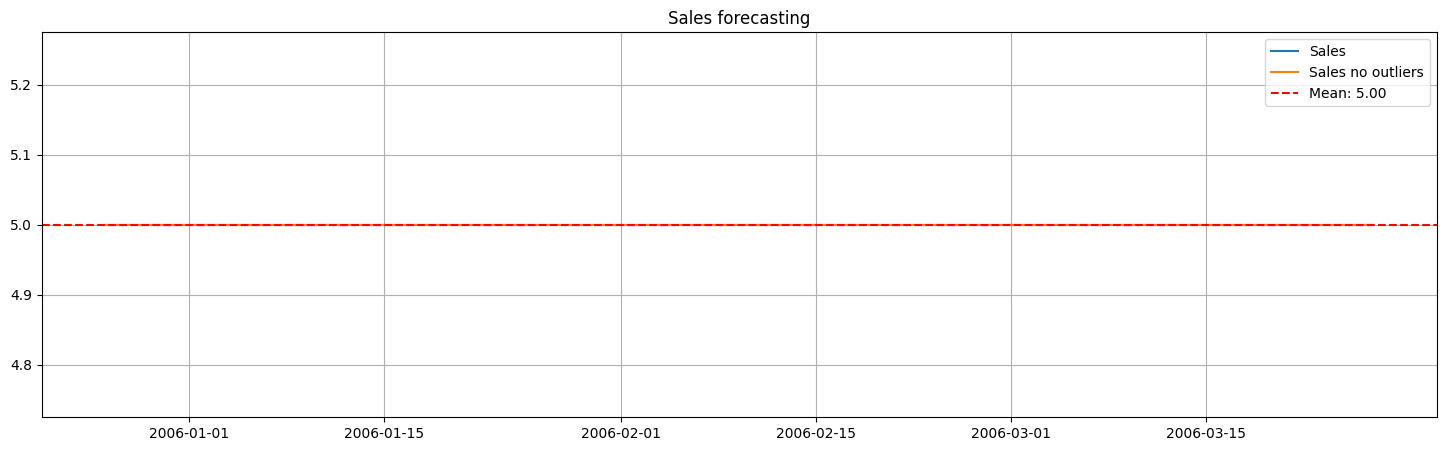

Processing Product ID: 1731
Rows found for Product 1731: 11
Low demand B ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


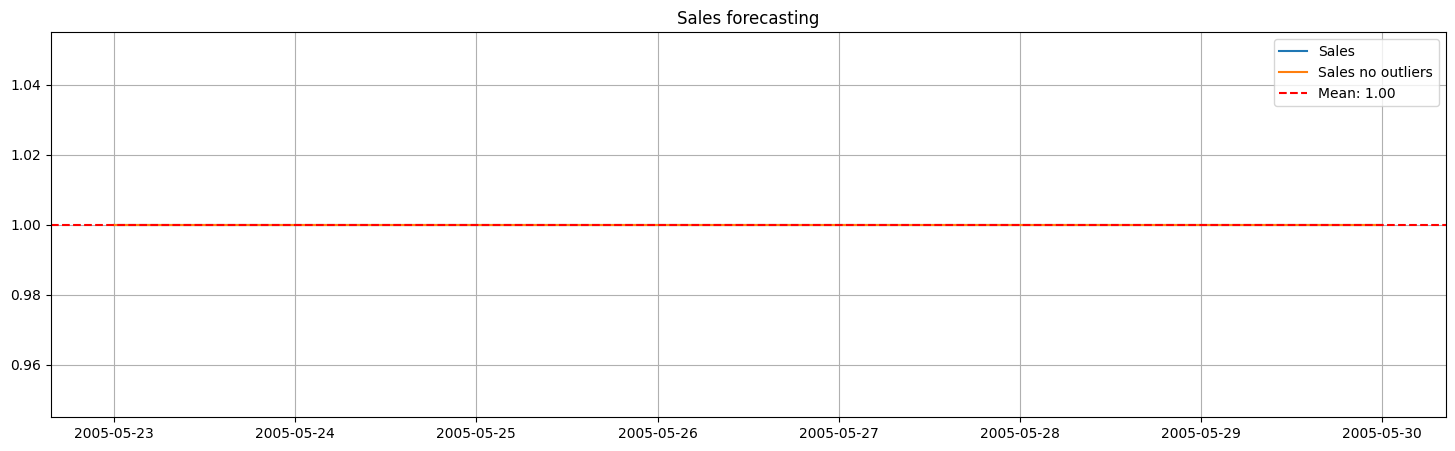

Processing Product ID: 12
Rows found for Product 12: 21
Low demand B ...

Percentage outliers:  0.0
Mean : 10.63978494623656, Median: 10.083333333333332


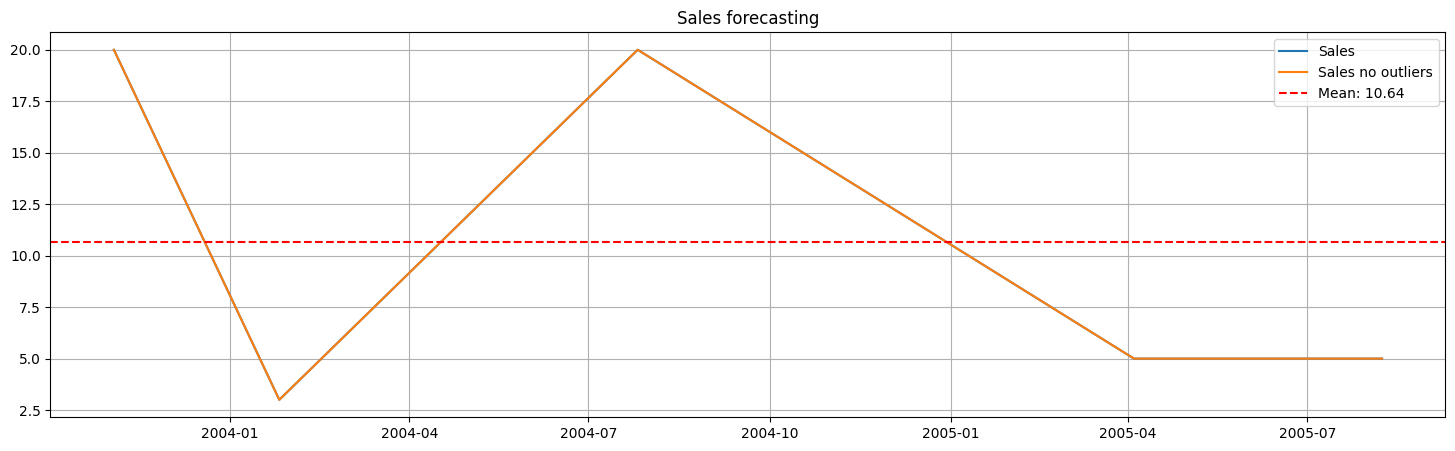

Processing Product ID: 3054
Rows found for Product 3054: 13
Low demand B ...

Percentage outliers:  0.0
Mean : 2.9393939393939394, Median: 3.2666666666666666


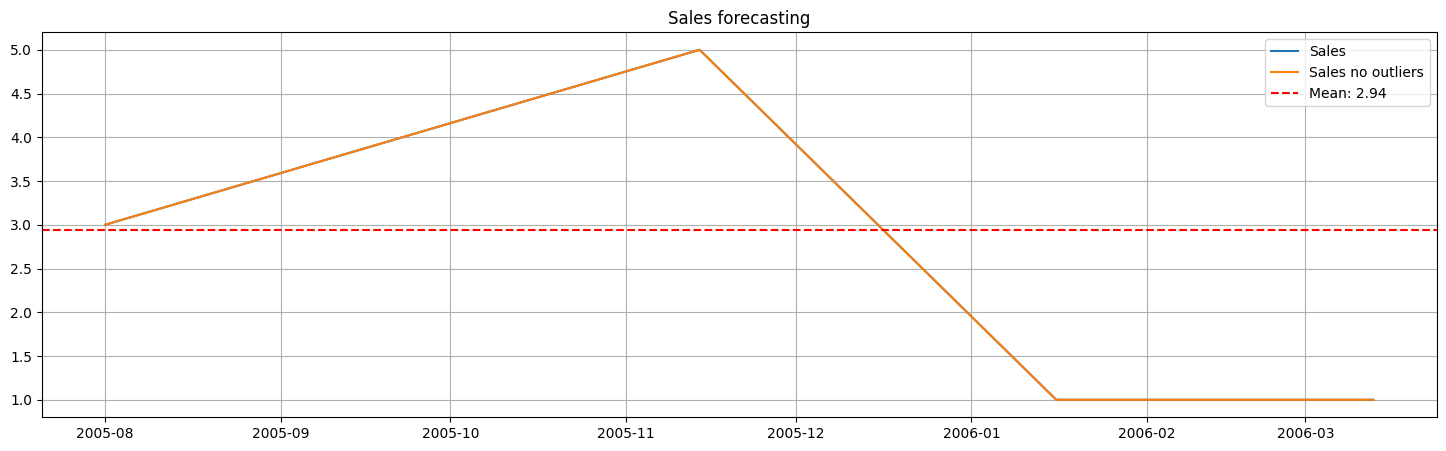

Processing Product ID: 3406
Rows found for Product 3406: 15
Low demand B ...

Percentage outliers:  0.0
Mean : 5.0, Median: 5.0


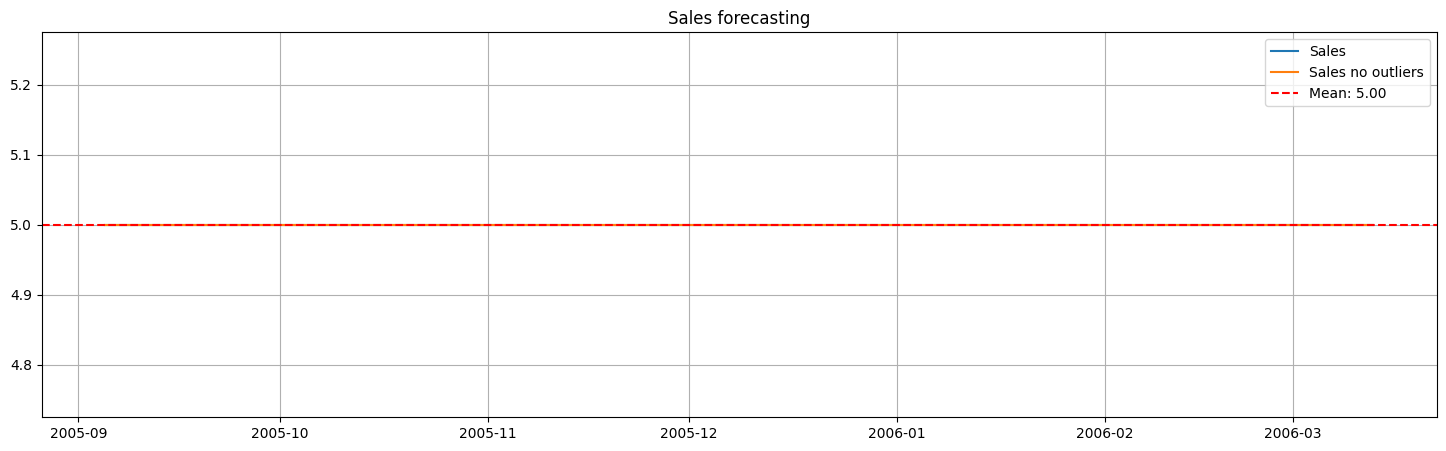

Processing Product ID: 3350
Rows found for Product 3350: 15
Low demand B ...

Percentage outliers:  0.0
Mean : 0.4423076923076923, Median: 0.125


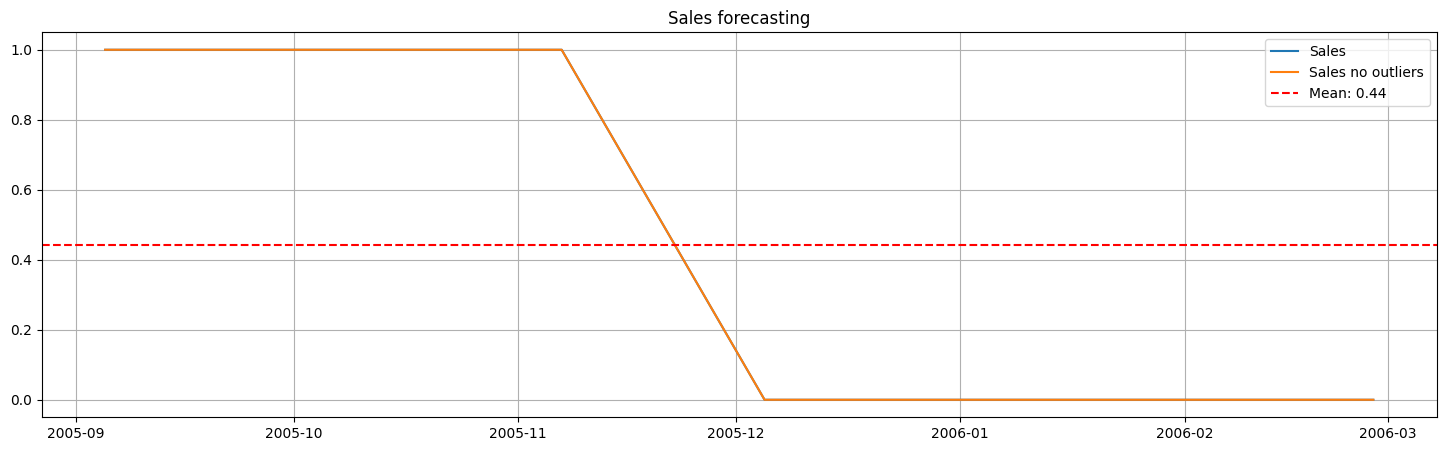

Processing Product ID: 2305
Rows found for Product 2305: 15
Low demand B ...

Percentage outliers:  0.0
Mean : 5.19811320754717, Median: 5.0


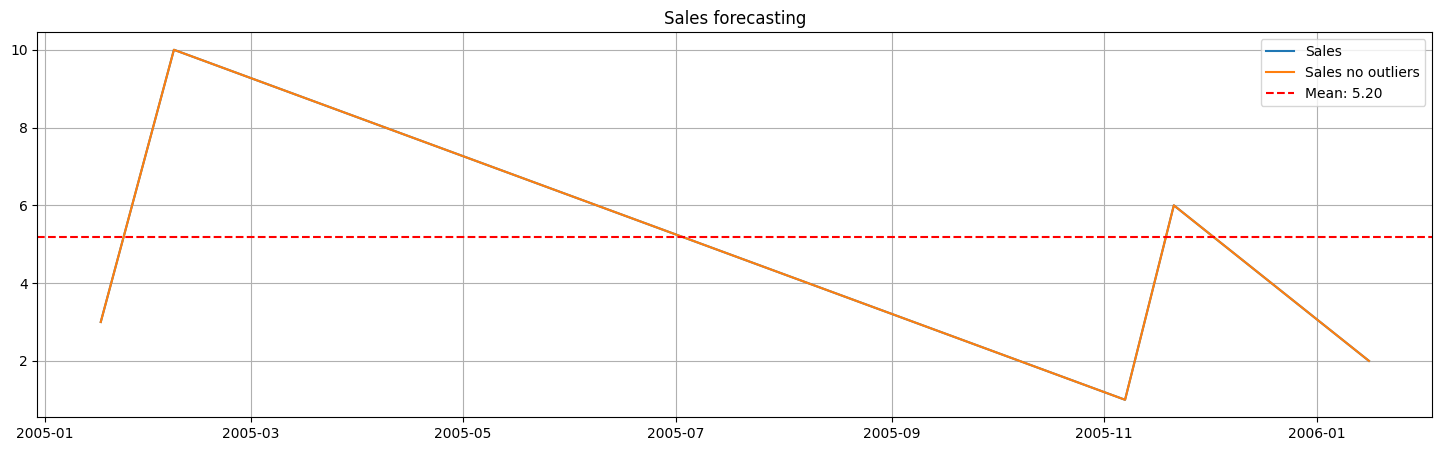

Processing Product ID: 2726
Rows found for Product 2726: 21
Low demand B ...

Percentage outliers:  0.0
Mean : 4.7, Median: 4.833333333333333


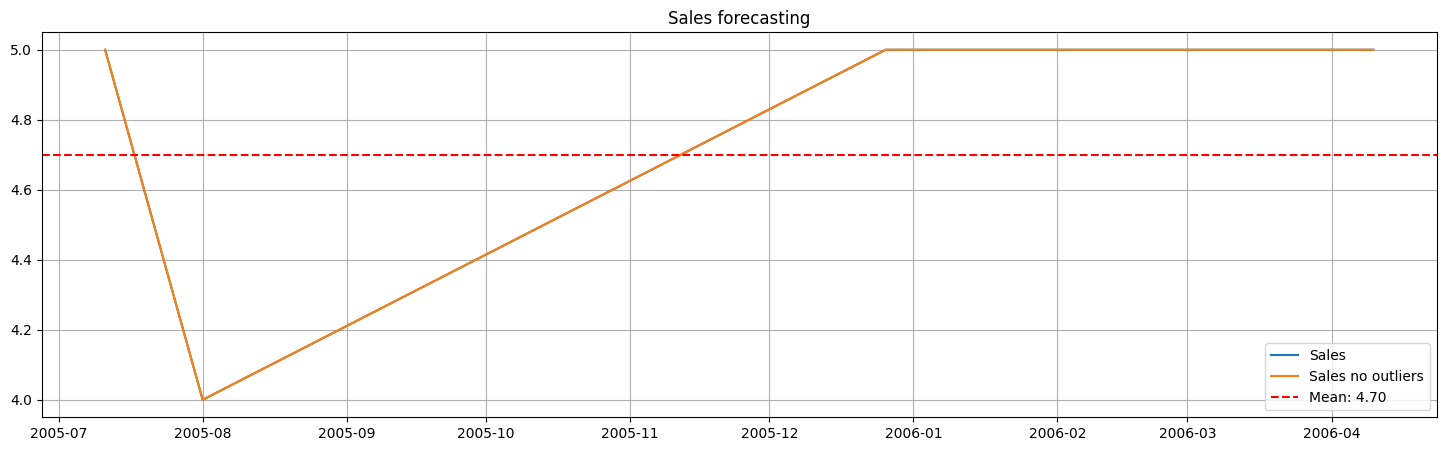

Processing Product ID: 2895
Rows found for Product 2895: 20
Low demand B ...

Percentage outliers:  7.6923076923076925
Mean : 1.6153846153846154, Median: 1.0


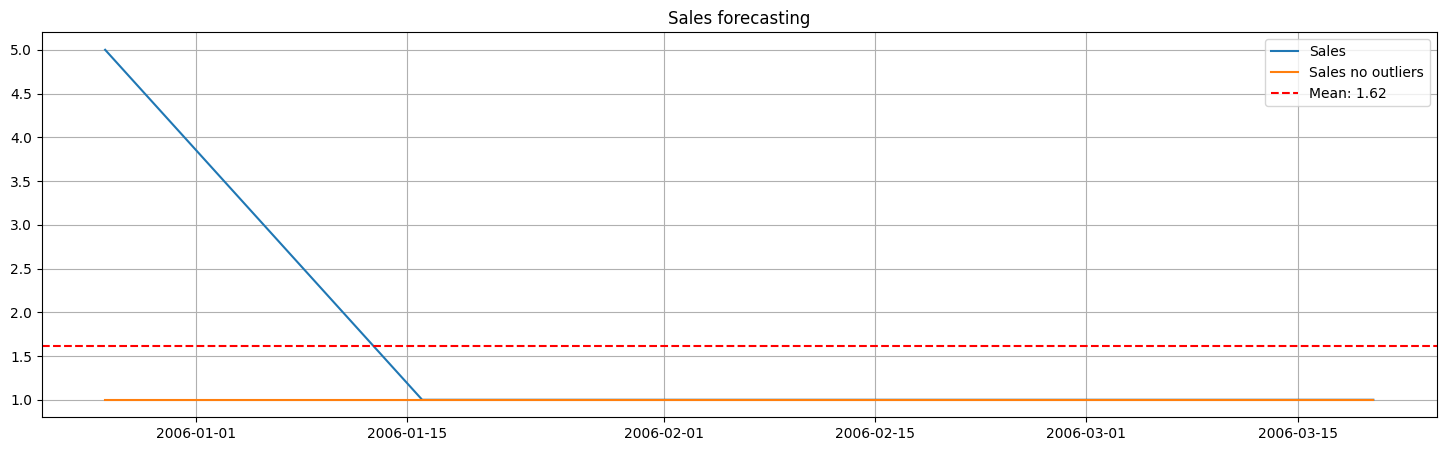

Processing Product ID: 3333
Rows found for Product 3333: 15
Low demand B ...

Percentage outliers:  0.0
Mean : 0.6590909090909091, Median: 1.0


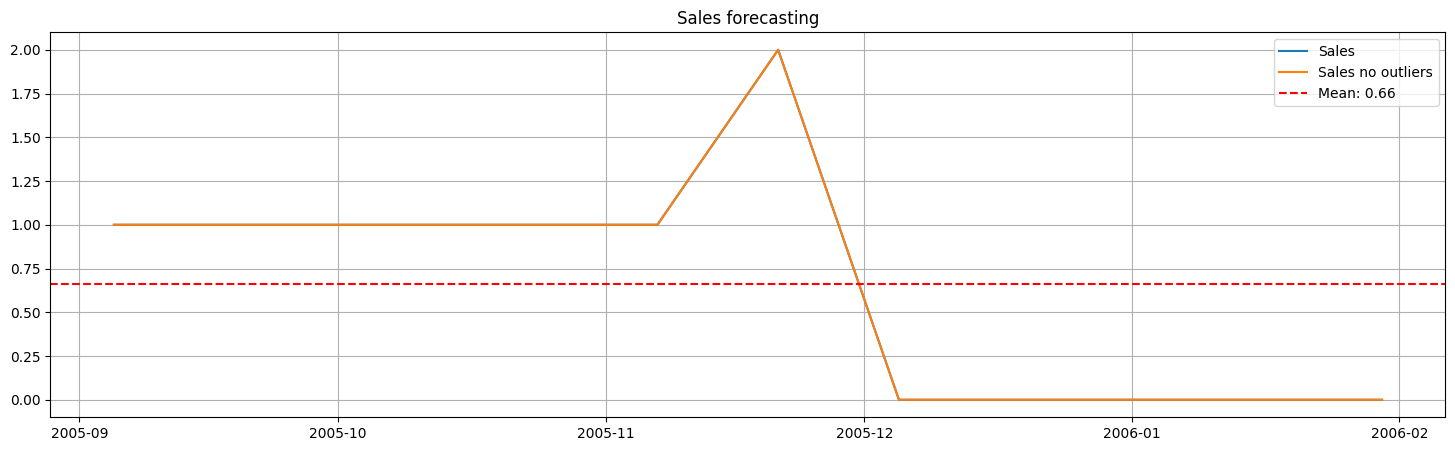

Processing Product ID: 2782
Rows found for Product 2782: 46
Low demand B ...

Percentage outliers:  0.0
Mean : 1.358974358974359, Median: 1.1764705882352942


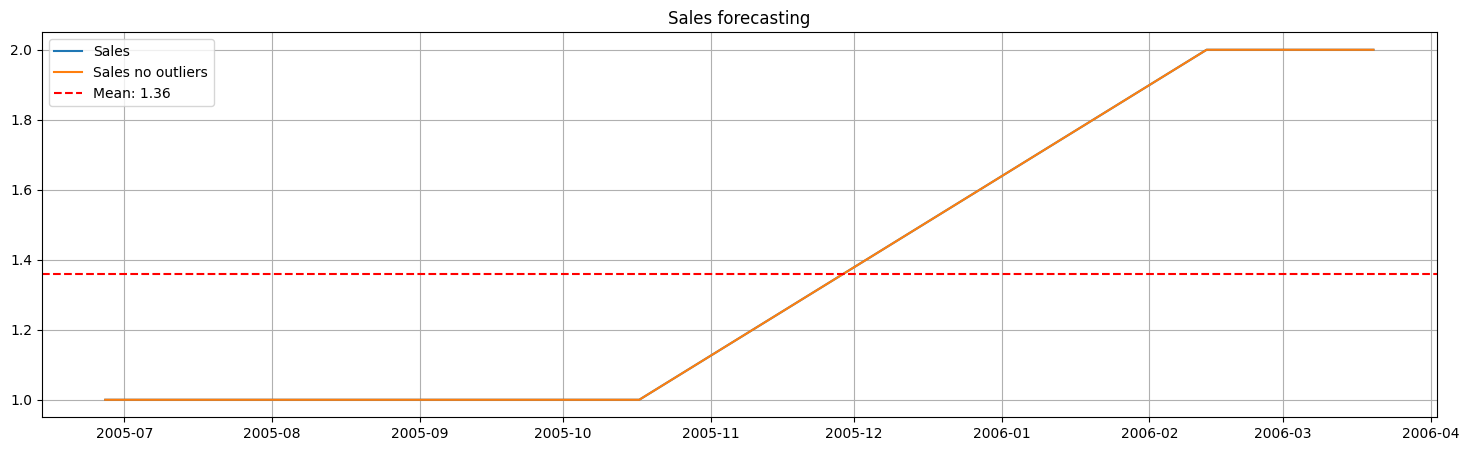

Processing Product ID: 1777
Rows found for Product 1777: 11
Low demand B ...

Percentage outliers:  10.416666666666668
Mean : 1.0769230769230769, Median: 1.0


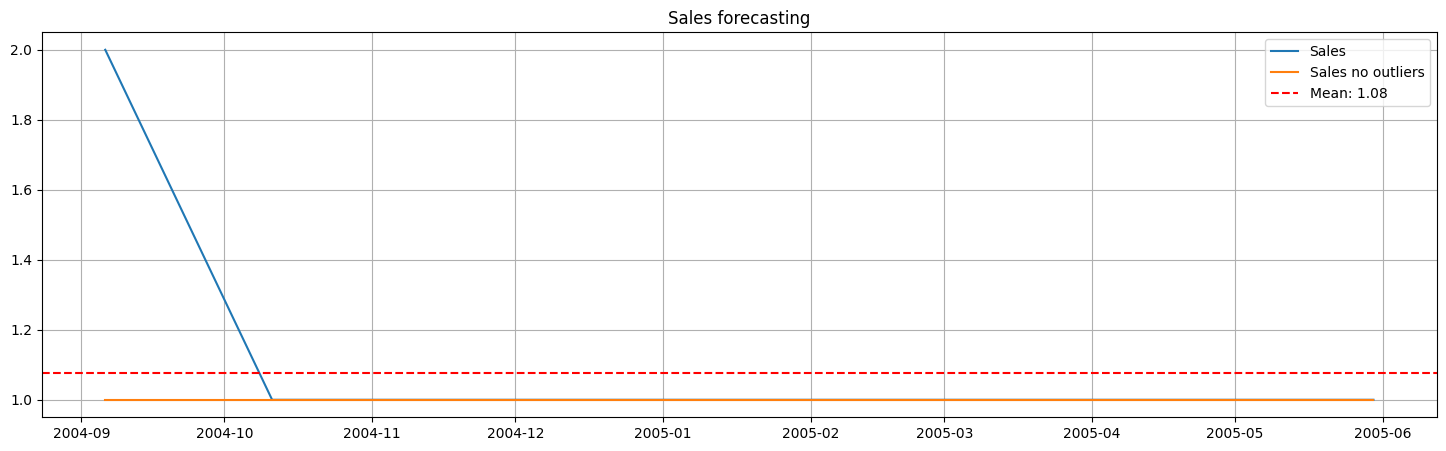

Processing Product ID: 1849
Rows found for Product 1849: 14
Low demand B ...

Percentage outliers:  7.142857142857142
Mean : 2.875, Median: 3.0


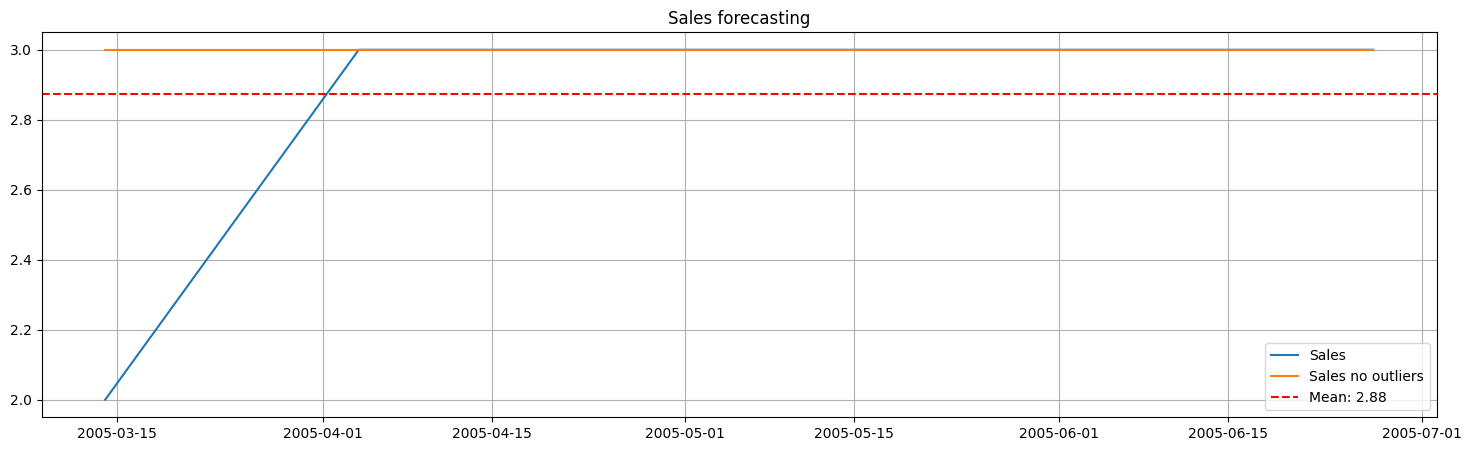

Processing Product ID: 3195
Rows found for Product 3195: 13
Low demand B ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


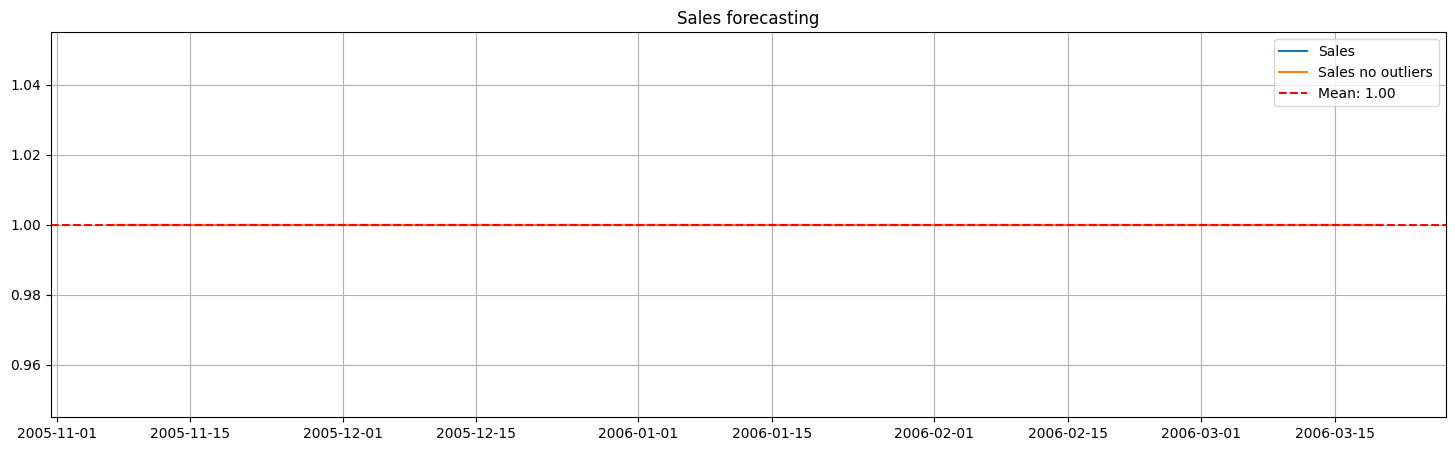

Processing Product ID: 3032
Rows found for Product 3032: 11
Low demand B ...

Processing Product ID: 807
Rows found for Product 807: 27
Low demand B ...

Percentage outliers:  0.0
Mean : 4.85251798561151, Median: 2.875


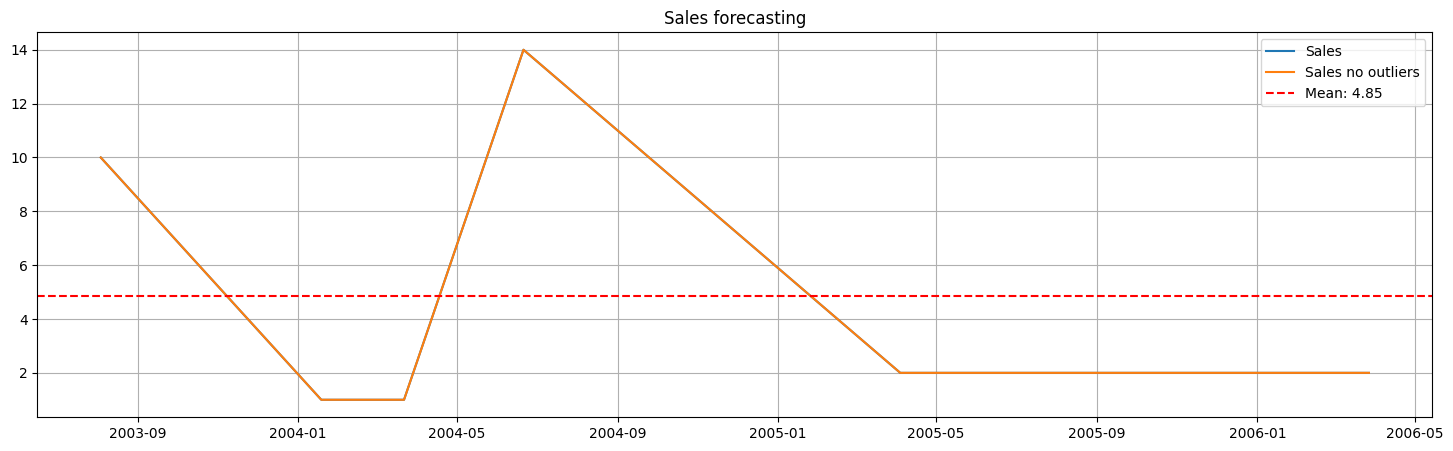

Processing Product ID: 2844
Rows found for Product 2844: 20
Low demand B ...

Percentage outliers:  0.0
Mean : 2.2903225806451615, Median: 1.0


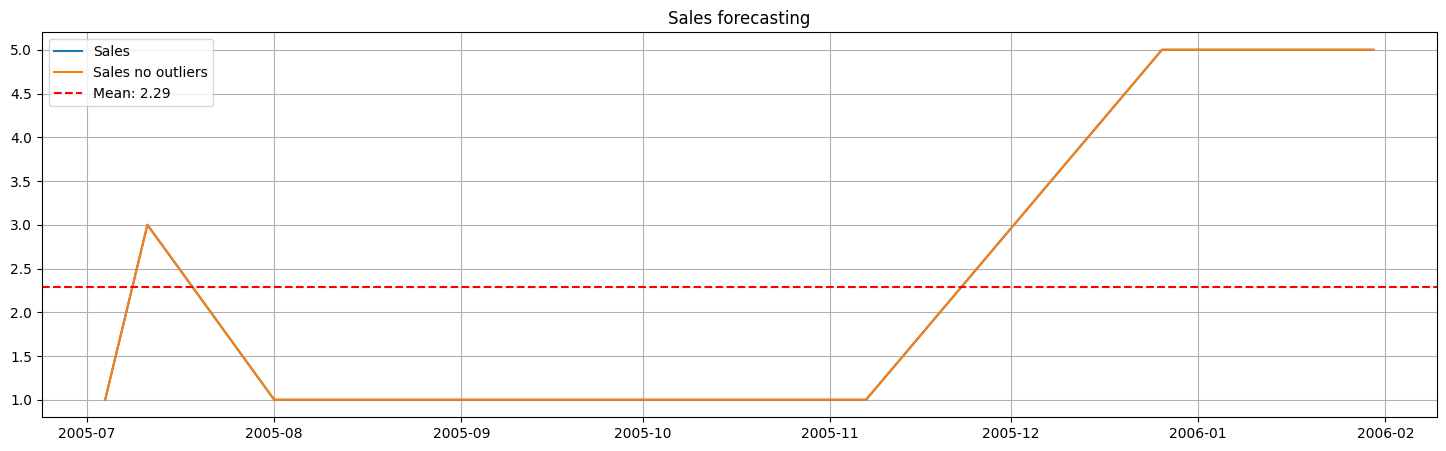

Processing Product ID: 3635
Rows found for Product 3635: 23
Low demand B ...

Percentage outliers:  15.384615384615385
Mean : 1.32, Median: 1.0


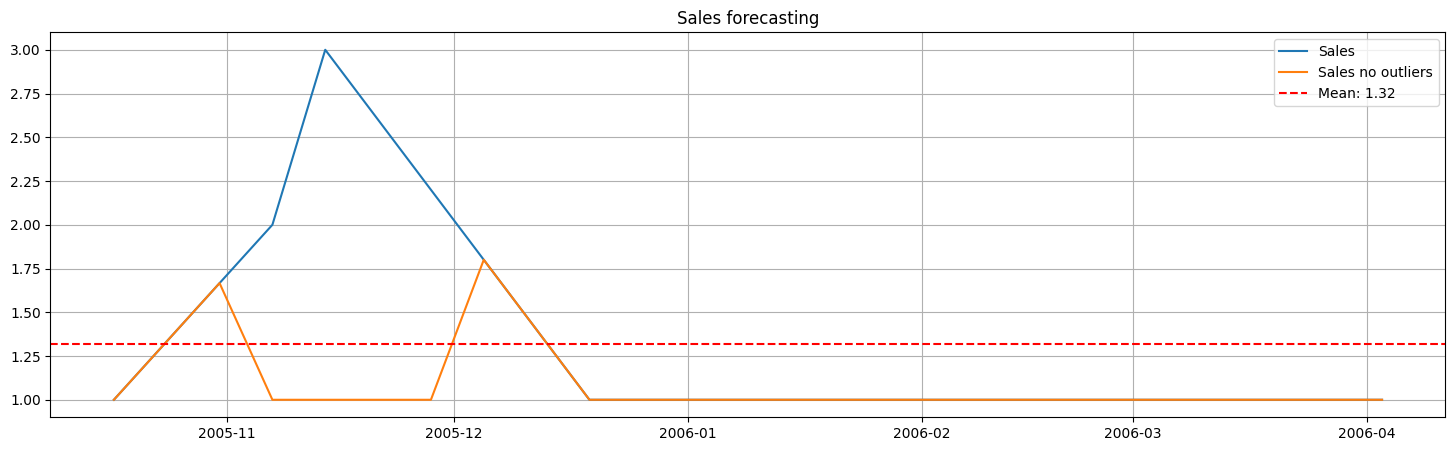

Processing Product ID: 764
Rows found for Product 764: 36
Low demand B ...

Percentage outliers:  3.1746031746031744
Mean : 1.3095238095238095, Median: 1.1616161616161618


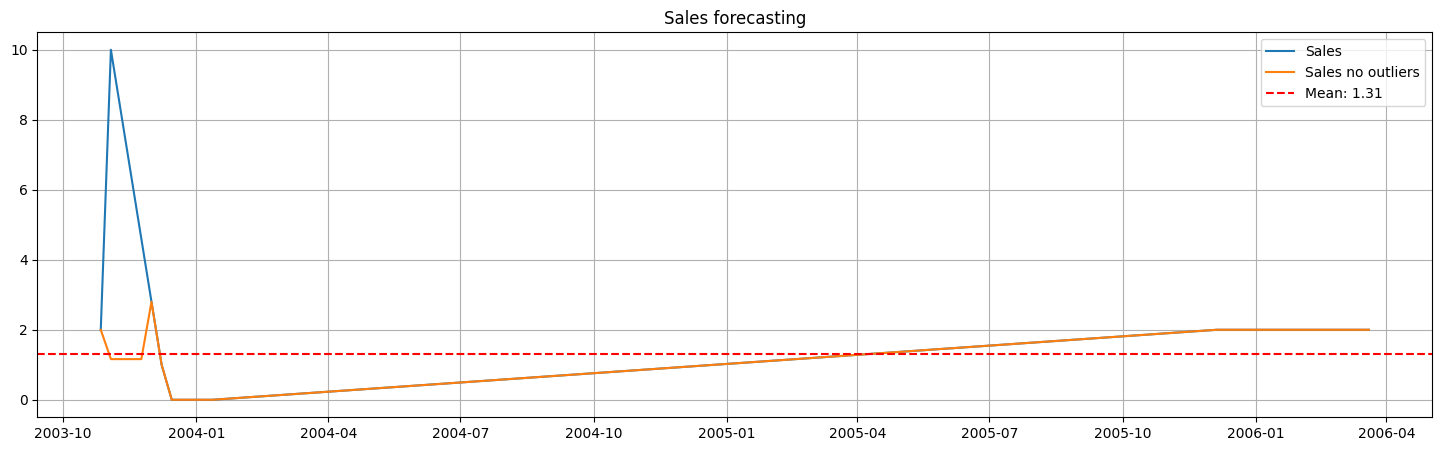

Processing Product ID: 3520
Rows found for Product 3520: 24
Low demand B ...

Percentage outliers:  7.6923076923076925
Mean : 1.2173913043478262, Median: 1.0


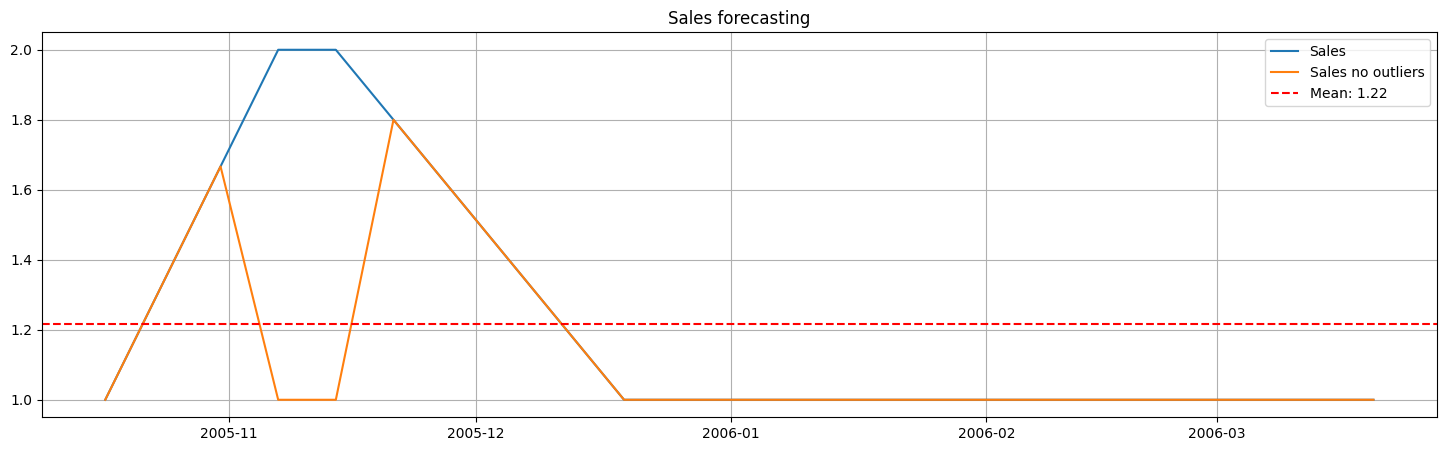

Processing Product ID: 728
Rows found for Product 728: 24
Low demand B ...

Percentage outliers:  0.0
Mean : 4.0, Median: 4.0


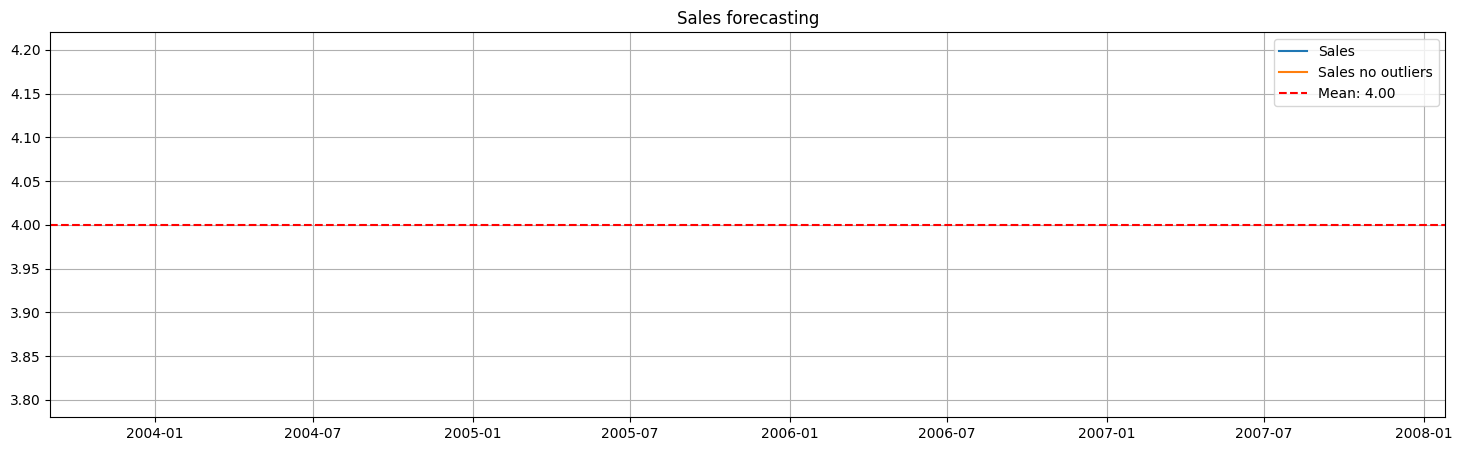

Processing Product ID: 167
Rows found for Product 167: 20
Low demand B ...

Percentage outliers:  0.0
Mean : 2.0, Median: 2.0


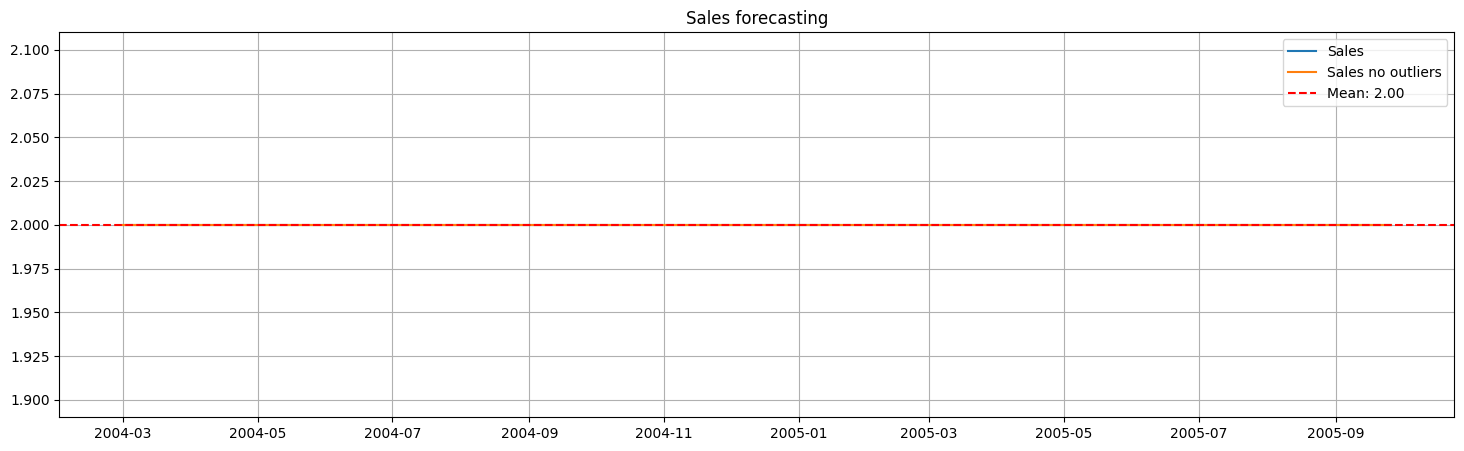

Processing Product ID: 2780
Rows found for Product 2780: 22
Low demand B ...

Percentage outliers:  14.634146341463413
Mean : 1.6451612903225807, Median: 1.0


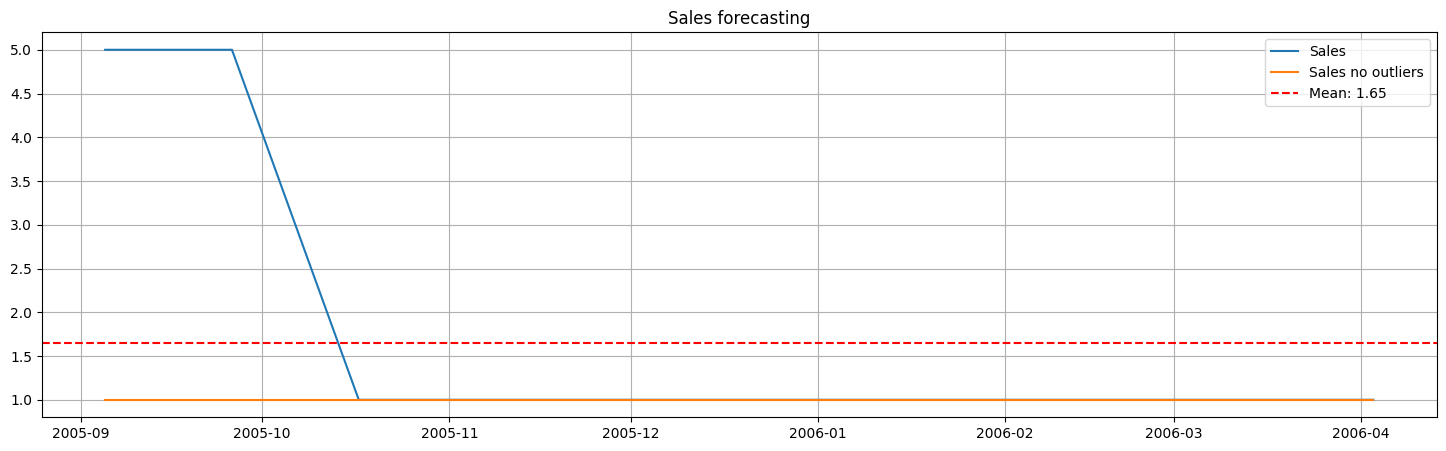

Processing Product ID: 2240
Rows found for Product 2240: 5
⚠️ Warning: No data available for Product 2240. Skipping.
Processing Product ID: 529
Rows found for Product 529: 17
Low demand B ...

Percentage outliers:  23.52941176470588
Mean : 4.713333333333333, Median: 5.0


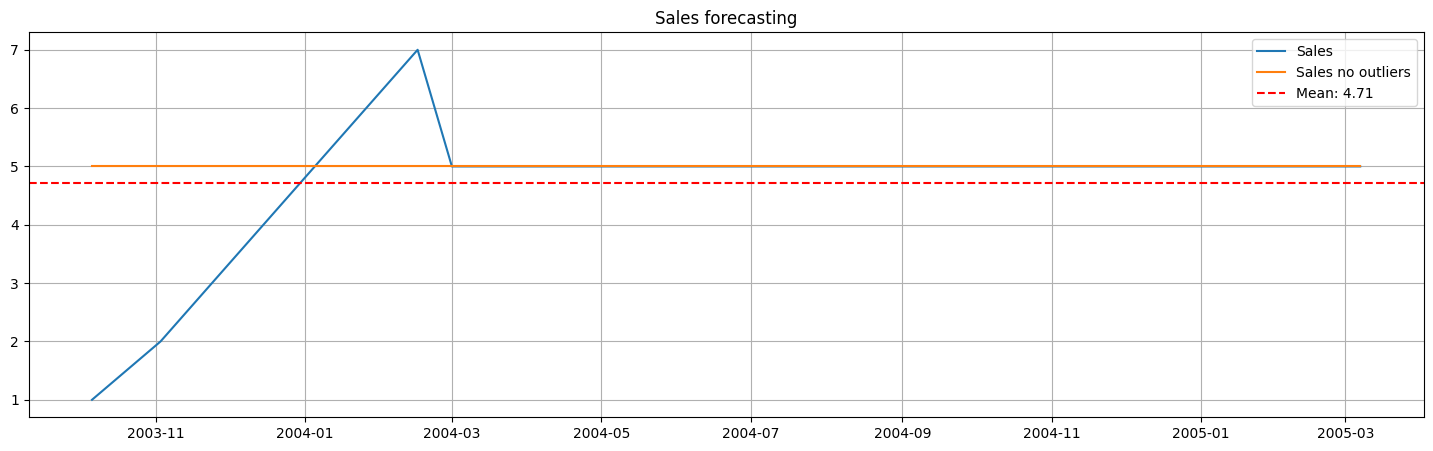

Processing Product ID: 2707
Rows found for Product 2707: 9
⚠️ Warning: No data available for Product 2707. Skipping.
Processing Product ID: 3059
Rows found for Product 3059: 17
Low demand B ...

Processing Product ID: 1246
Rows found for Product 1246: 16
Low demand B ...

Percentage outliers:  0.0
Mean : 4.628571428571429, Median: 3.0


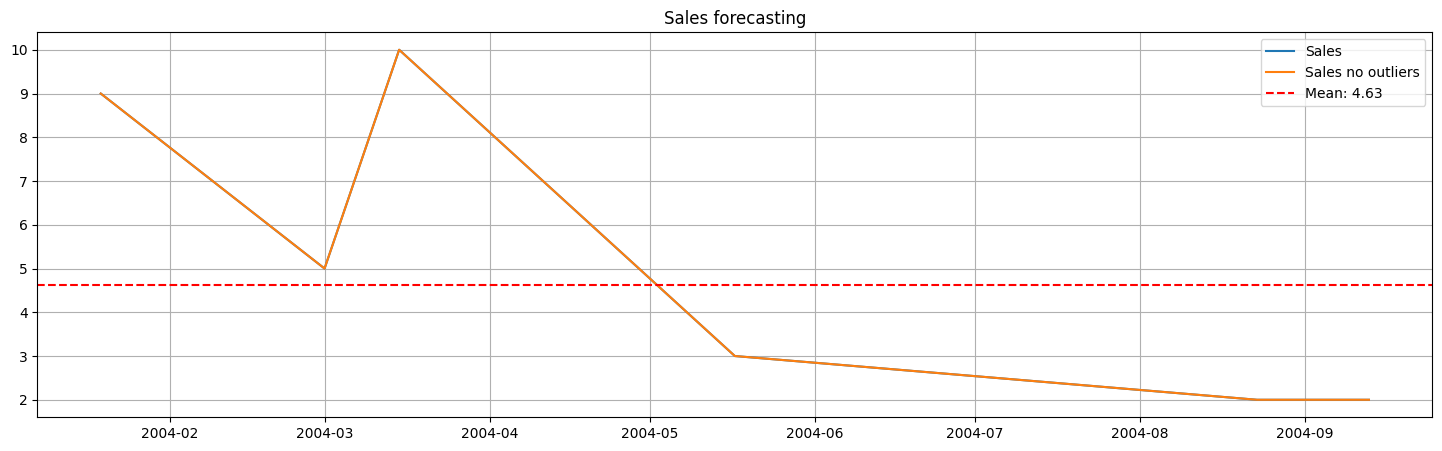

Processing Product ID: 174
Rows found for Product 174: 19
Low demand B ...

Percentage outliers:  8.73015873015873
Mean : 1.587719298245614, Median: 1.0


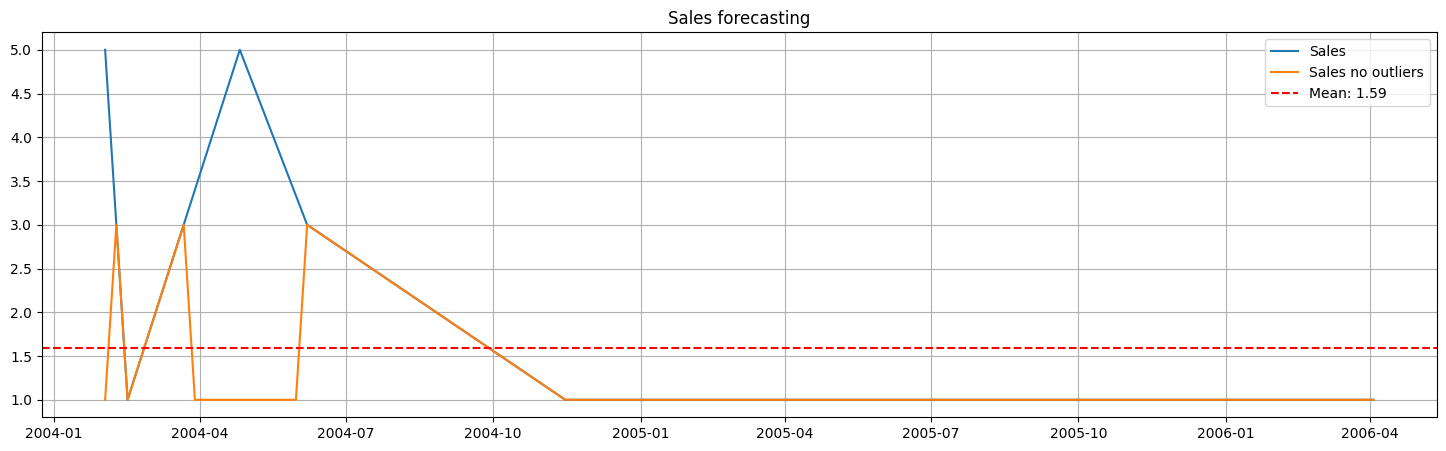

Processing Product ID: 235
Rows found for Product 235: 12
Low demand B ...

Percentage outliers:  4.6875
Mean : 3.6346153846153846, Median: 3.2162162162162162


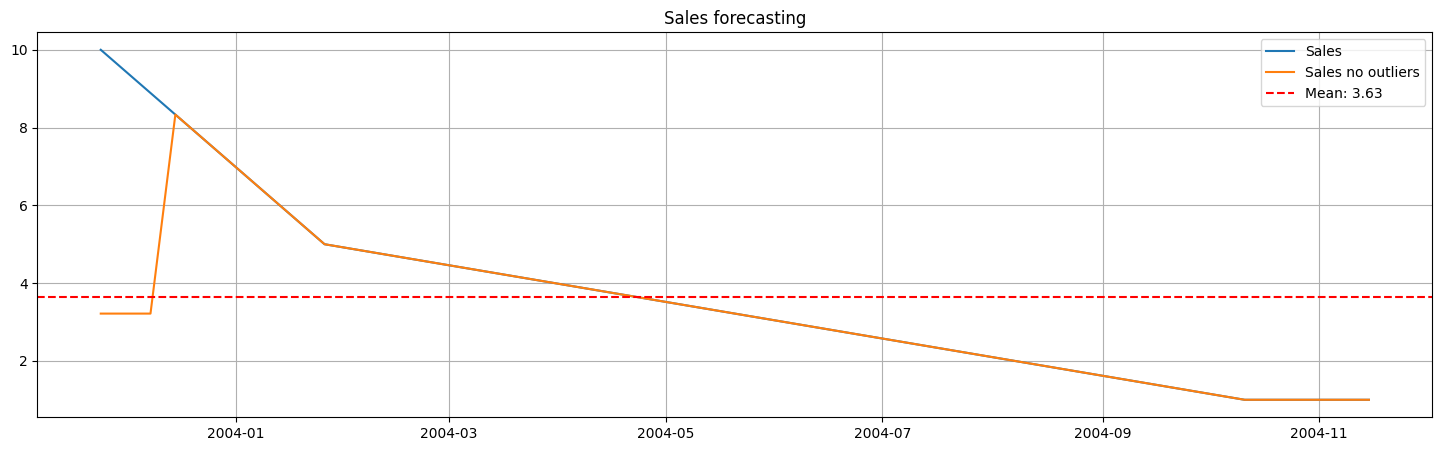

Processing Product ID: 760
Rows found for Product 760: 15
Low demand B ...

Percentage outliers:  0.0
Mean : 5.9423076923076925, Median: 5.723684210526316


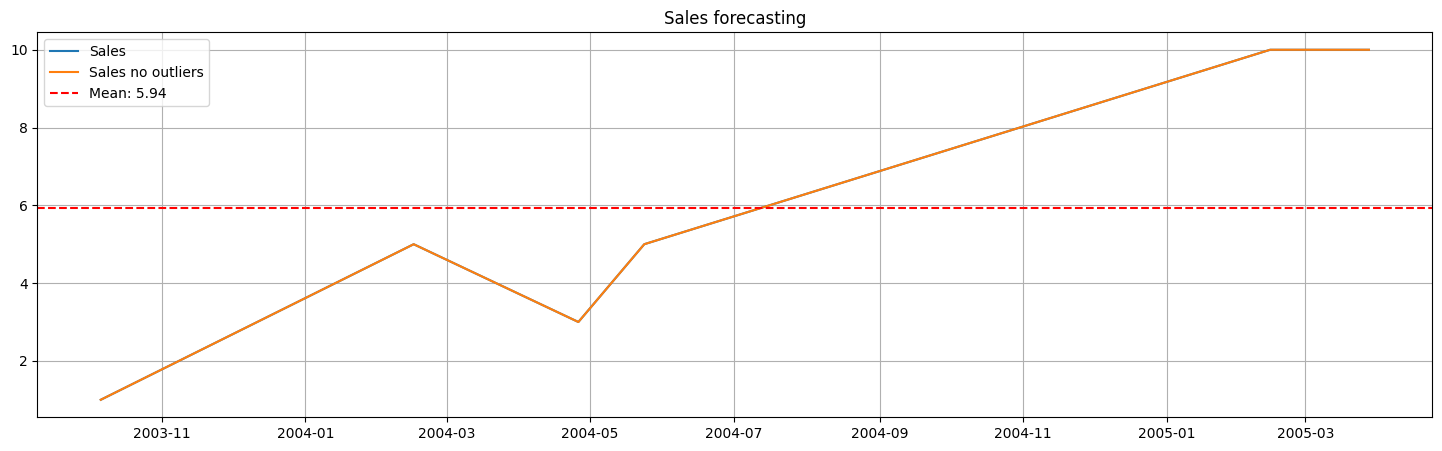

Processing Product ID: 279
Rows found for Product 279: 15
Low demand B ...

Percentage outliers:  0.0
Mean : 10.0, Median: 10.0


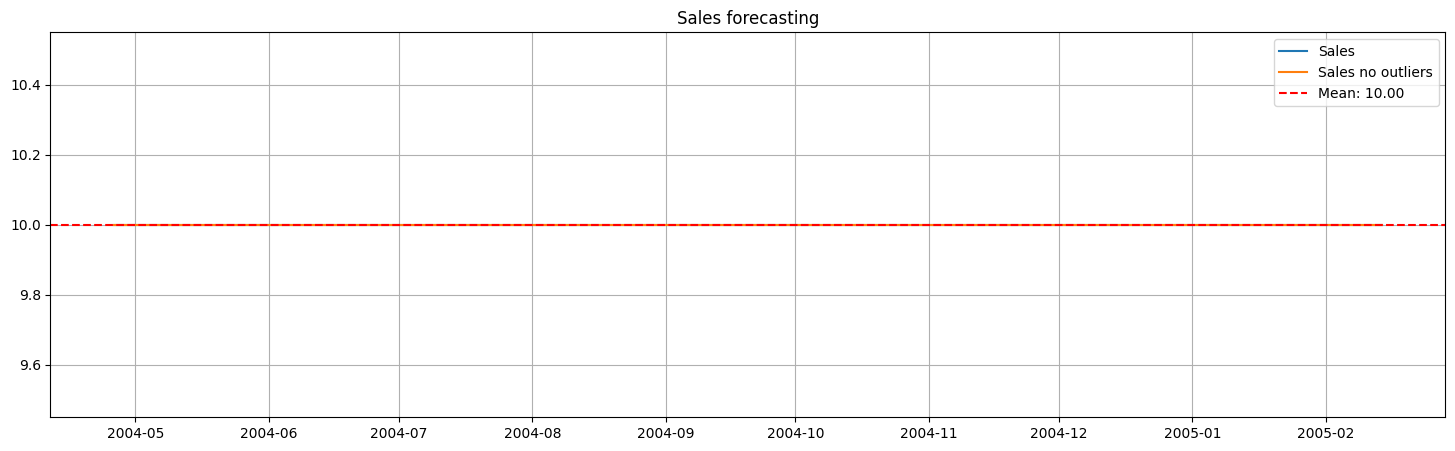

Processing Product ID: 3540
Rows found for Product 3540: 12
Low demand B ...

Processing Product ID: 2687
Rows found for Product 2687: 12
Low demand B ...

Processing Product ID: 10
Rows found for Product 10: 27
Low demand B ...

Percentage outliers:  0.9708737864077669
Mean : 3.875, Median: 3.258241758241758


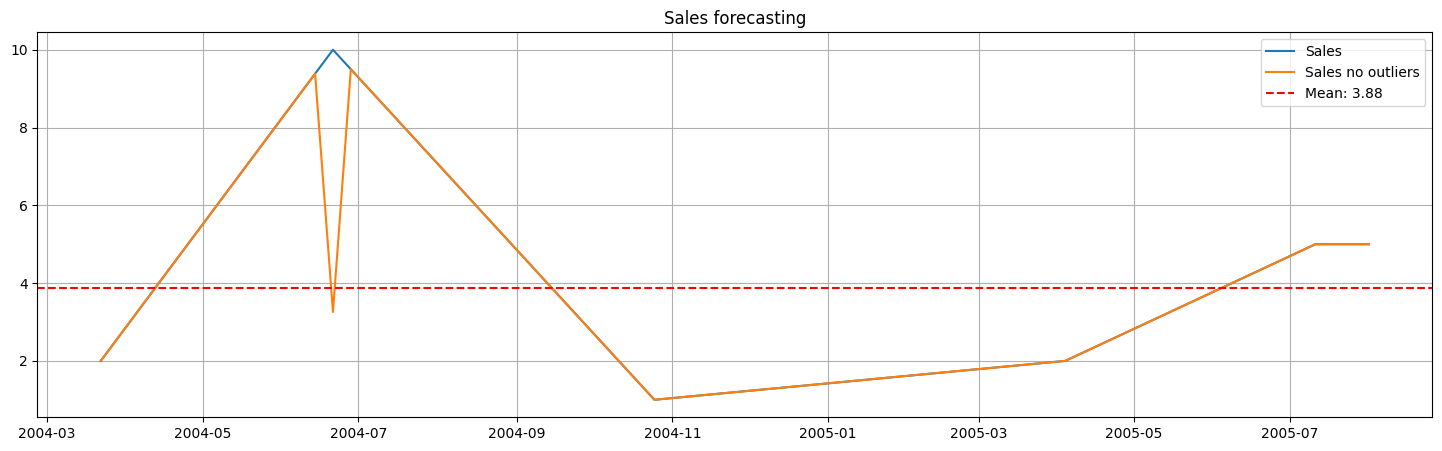

Processing Product ID: 3549
Rows found for Product 3549: 14
Low demand B ...

Percentage outliers:  0.0
Mean : 1.9615384615384615, Median: 1.75


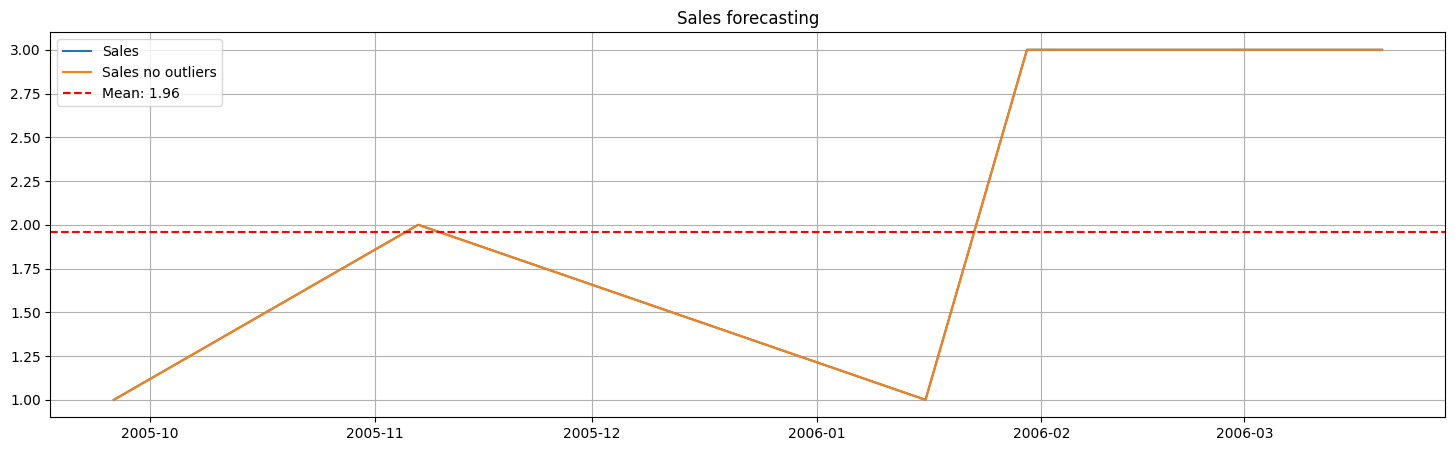

Processing Product ID: 3000
Rows found for Product 3000: 15
Low demand B ...

Percentage outliers:  0.0
Mean : 1.5294117647058822, Median: 1.0625


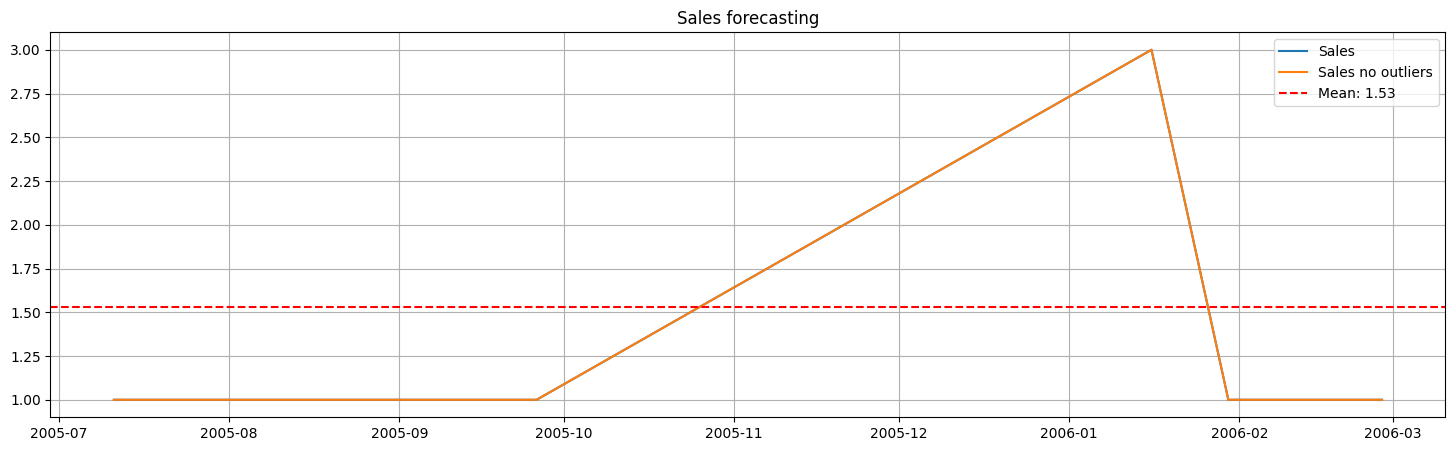

Processing Product ID: 2485
Rows found for Product 2485: 18
Low demand B ...

Percentage outliers:  0.0
Mean : 4.521739130434782, Median: 5.0


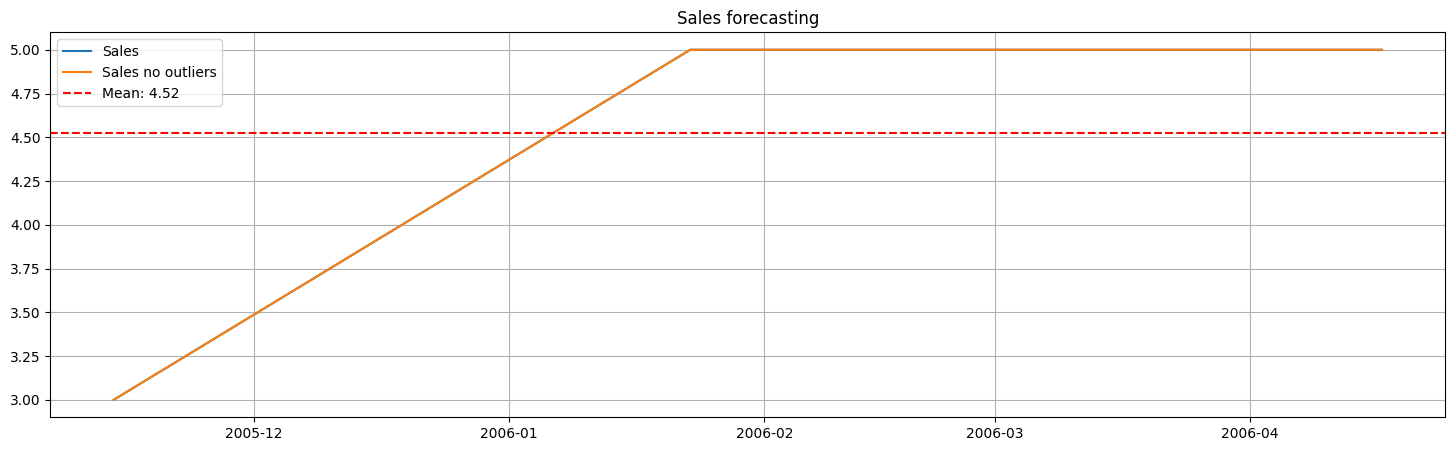

Processing Product ID: 2876
Rows found for Product 2876: 15
Low demand B ...

Percentage outliers:  0.0
Mean : 4.368421052631579, Median: 4.172413793103448


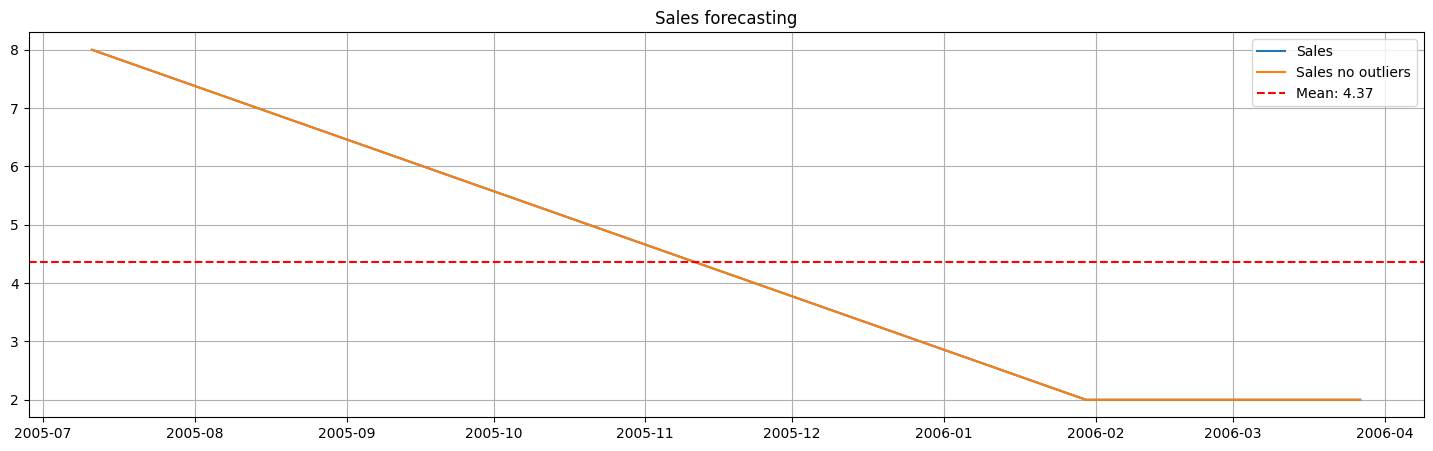

Processing Product ID: 2758
Rows found for Product 2758: 15
Low demand C ...

Percentage outliers:  0.0
Mean : 10.151515151515152, Median: 11.0


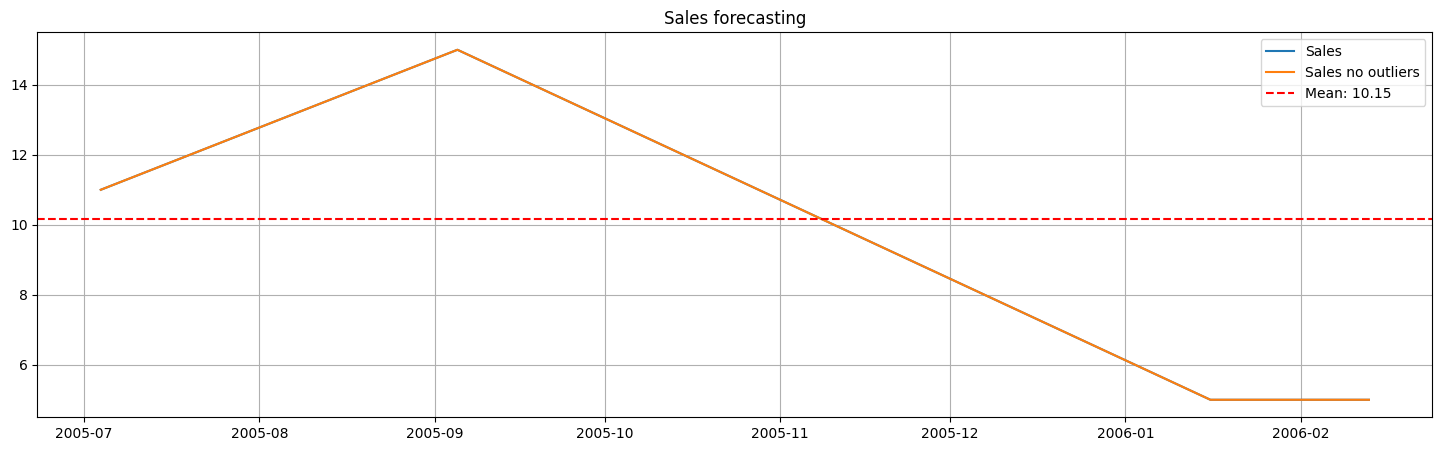

Processing Product ID: 2831
Rows found for Product 2831: 20
Low demand C ...

Percentage outliers:  0.0
Mean : 7.337209302325581, Median: 10.0


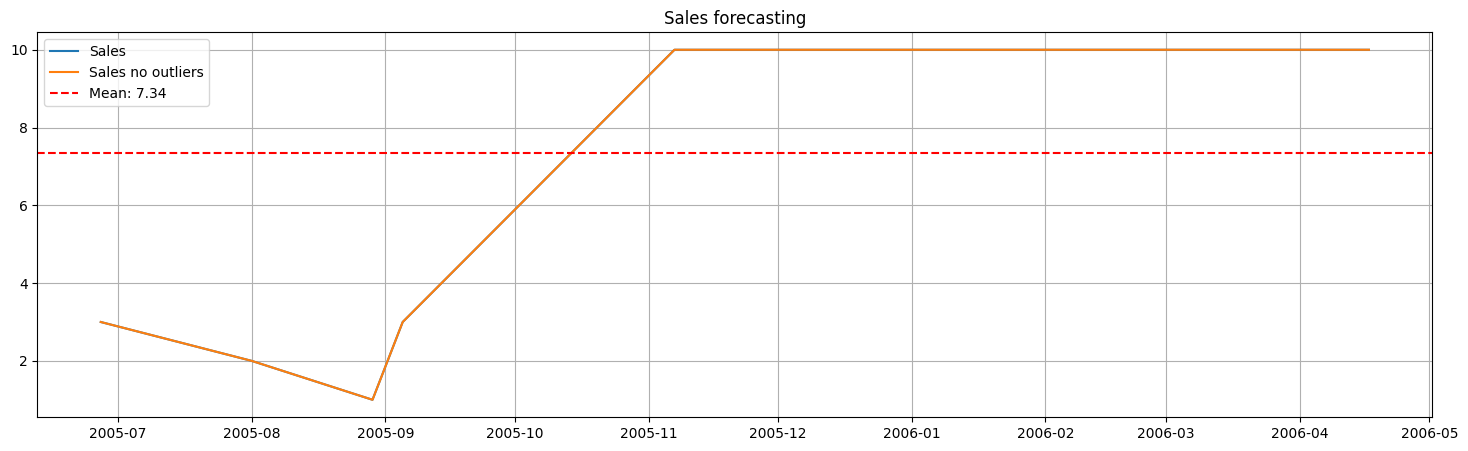

Processing Product ID: 1845
Rows found for Product 1845: 19
Low demand C ...

Percentage outliers:  1.2658227848101267
Mean : 1.7960526315789473, Median: 2.0


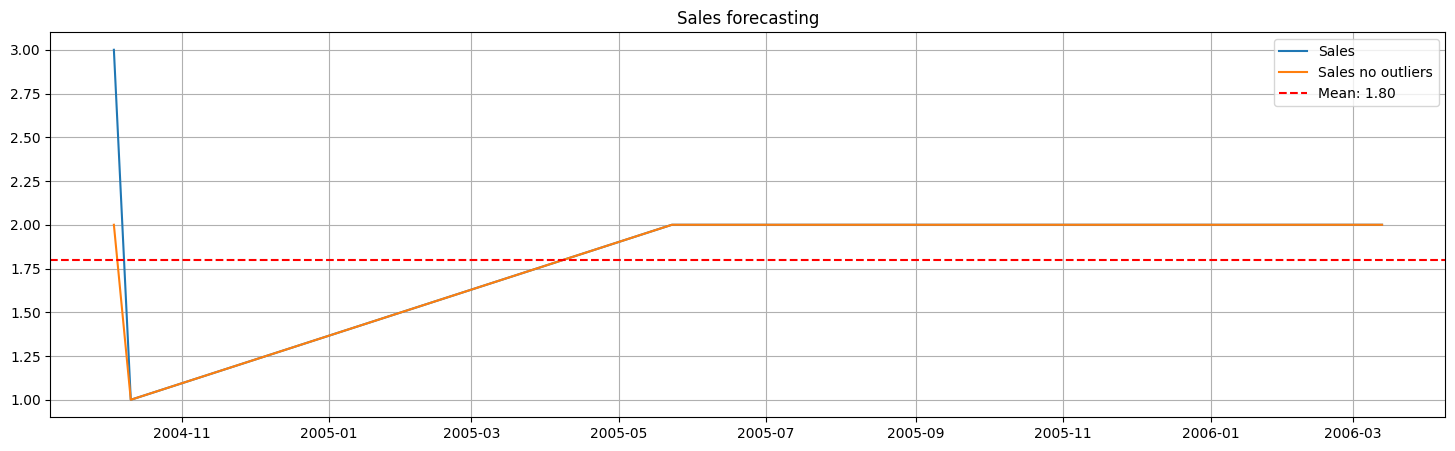

Processing Product ID: 2523
Rows found for Product 2523: 18
Low demand C ...

Processing Product ID: 415
Rows found for Product 415: 12
Low demand C ...

Percentage outliers:  18.39080459770115
Mean : 3.0813953488372094, Median: 3.0


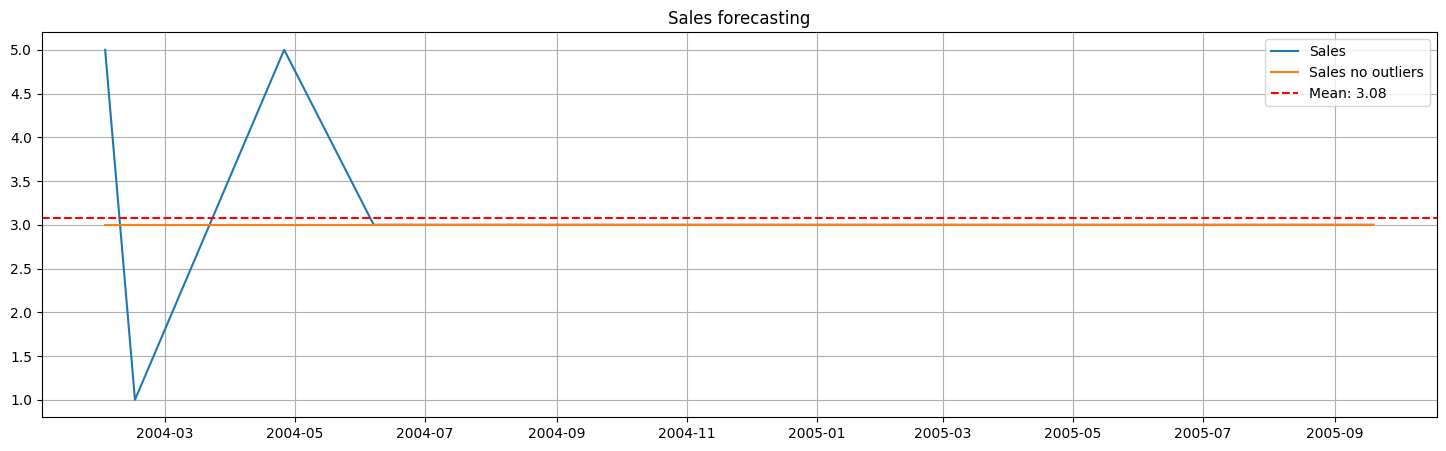

Processing Product ID: 2882
Rows found for Product 2882: 19
Low demand C ...

Percentage outliers:  0.0
Mean : 3.0, Median: 3.0


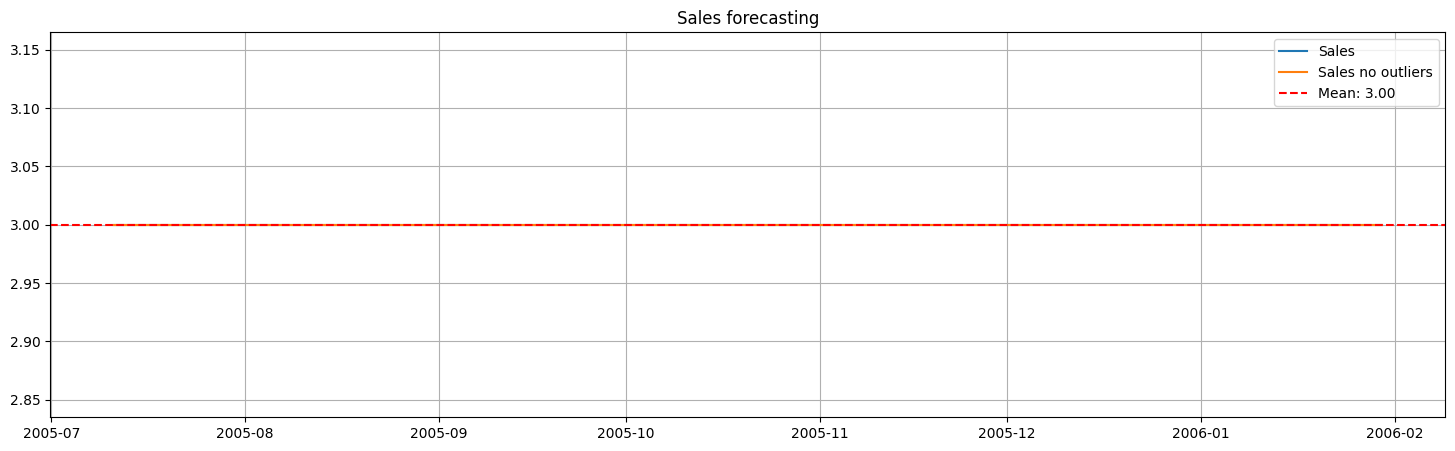

Processing Product ID: 2678
Rows found for Product 2678: 17
Low demand C ...

Percentage outliers:  20.454545454545457
Mean : 1.880952380952381, Median: 2.0


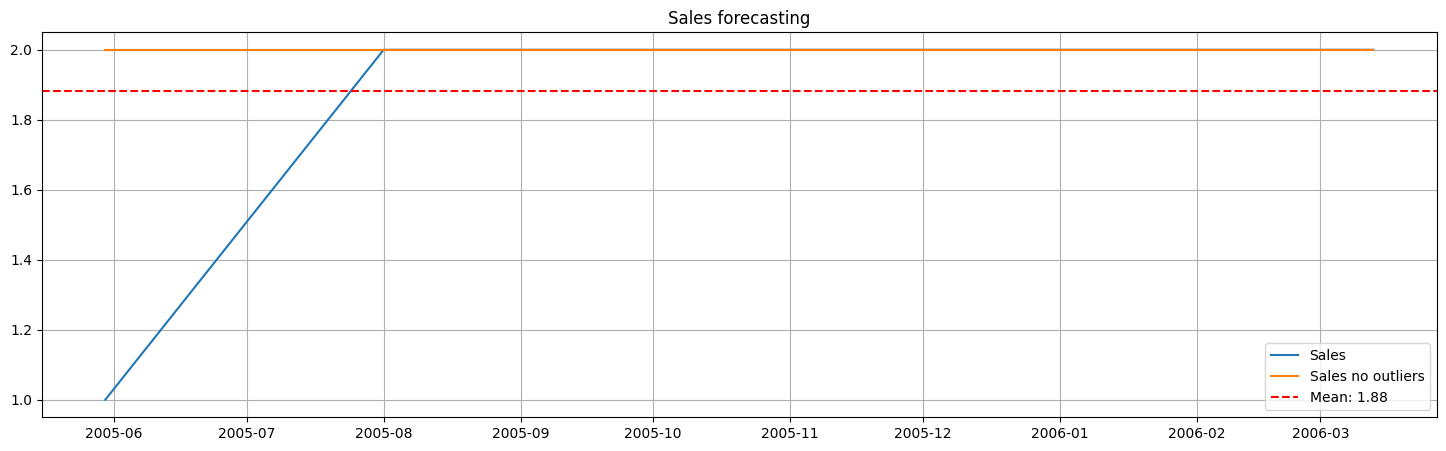

Processing Product ID: 3416
Rows found for Product 3416: 19
Low demand C ...

Percentage outliers:  3.3333333333333335
Mean : 2.6551724137931036, Median: 3.0


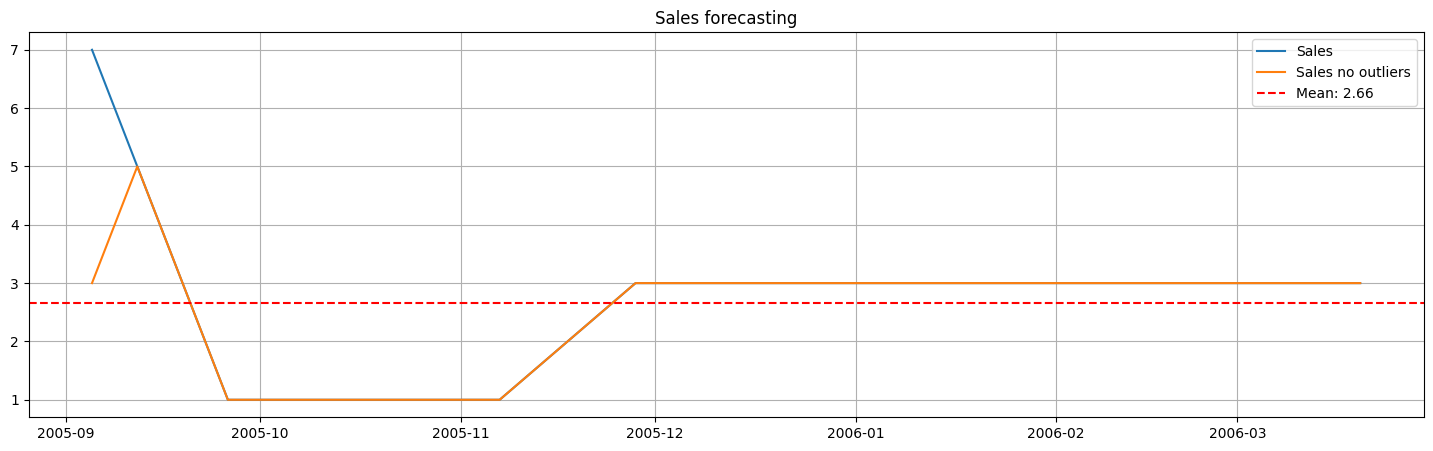

Processing Product ID: 238
Rows found for Product 238: 12
Low demand C ...

Percentage outliers:  0.0
Mean : 5.8478260869565215, Median: 4.833333333333333


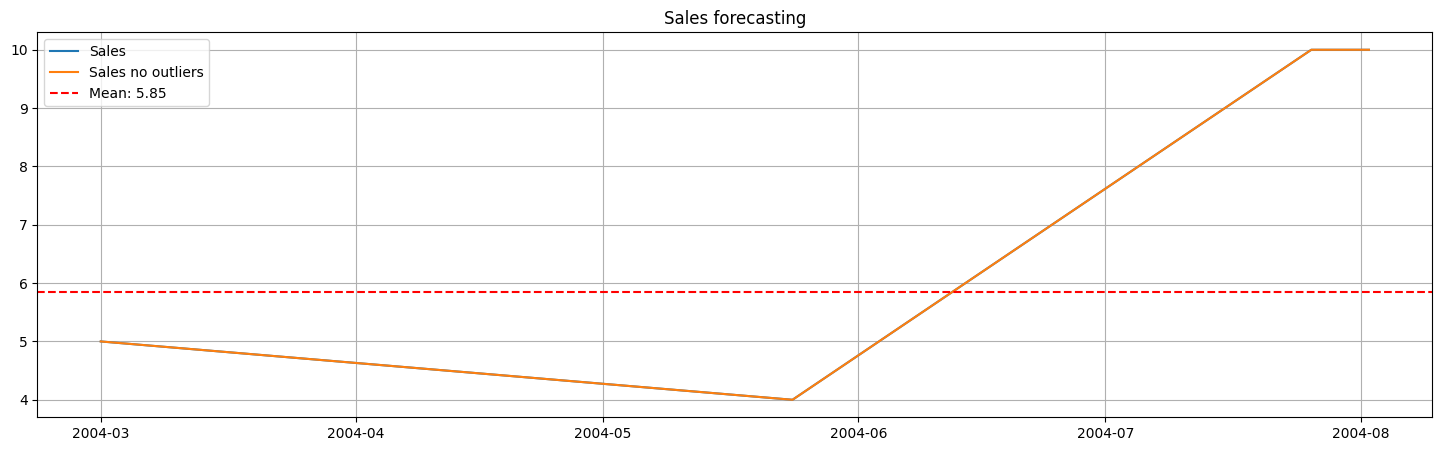

Processing Product ID: 3424
Rows found for Product 3424: 18
Low demand C ...

Percentage outliers:  0.0
Mean : 1.706896551724138, Median: 1.875


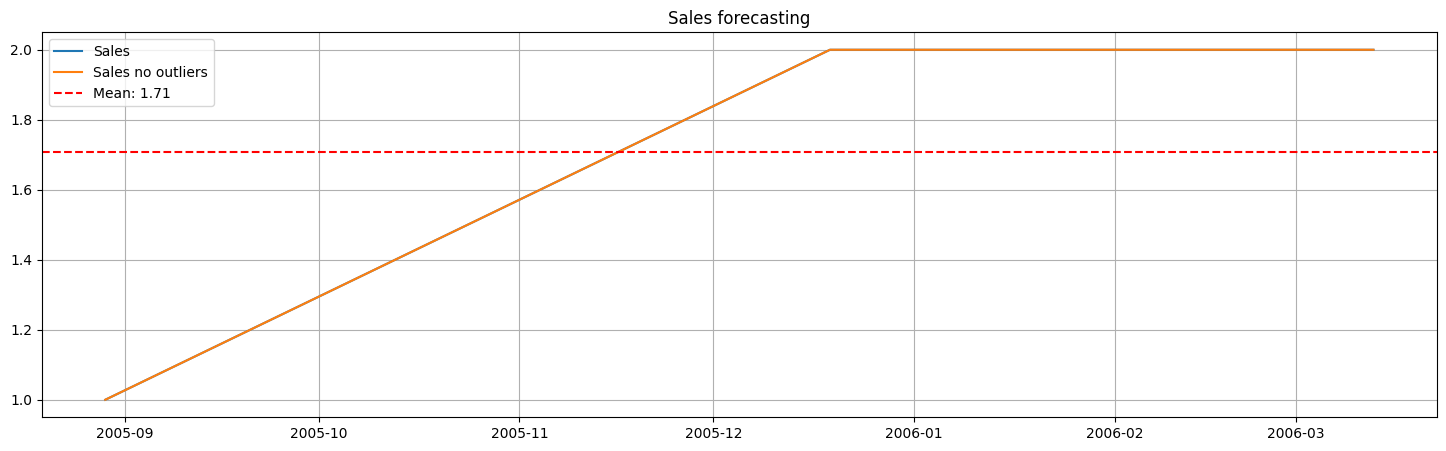

Processing Product ID: 1973
Rows found for Product 1973: 5
⚠️ Warning: No data available for Product 1973. Skipping.
Processing Product ID: 886
Rows found for Product 886: 22
Low demand C ...

Percentage outliers:  1.8181818181818181
Mean : 5.142857142857143, Median: 5.0


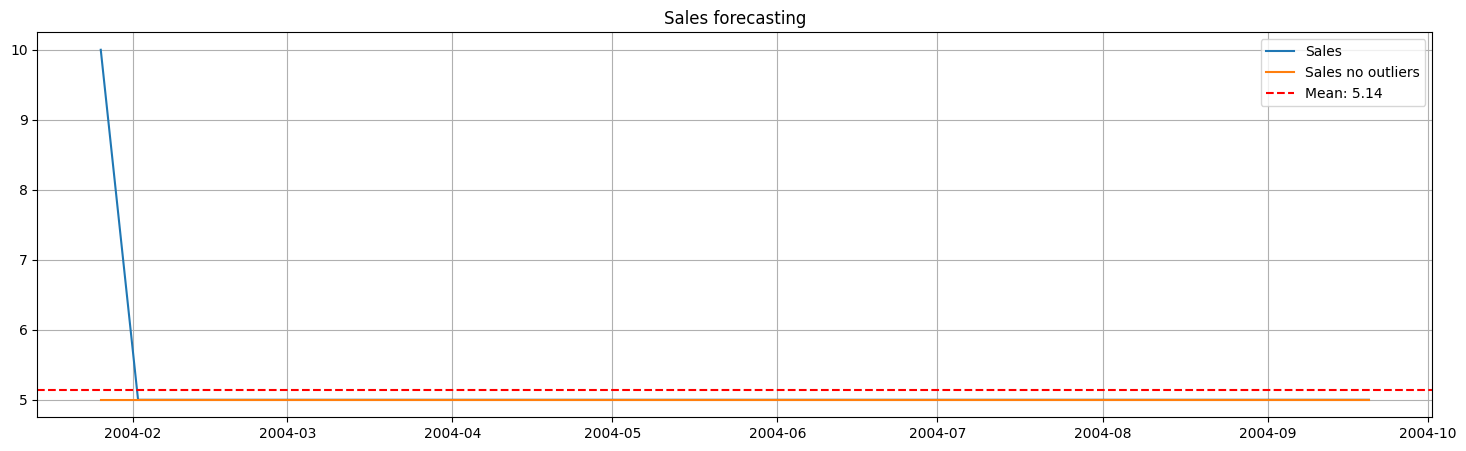

Processing Product ID: 2290
Rows found for Product 2290: 11
Low demand C ...

Percentage outliers:  0.0
Mean : 10.0, Median: 10.0


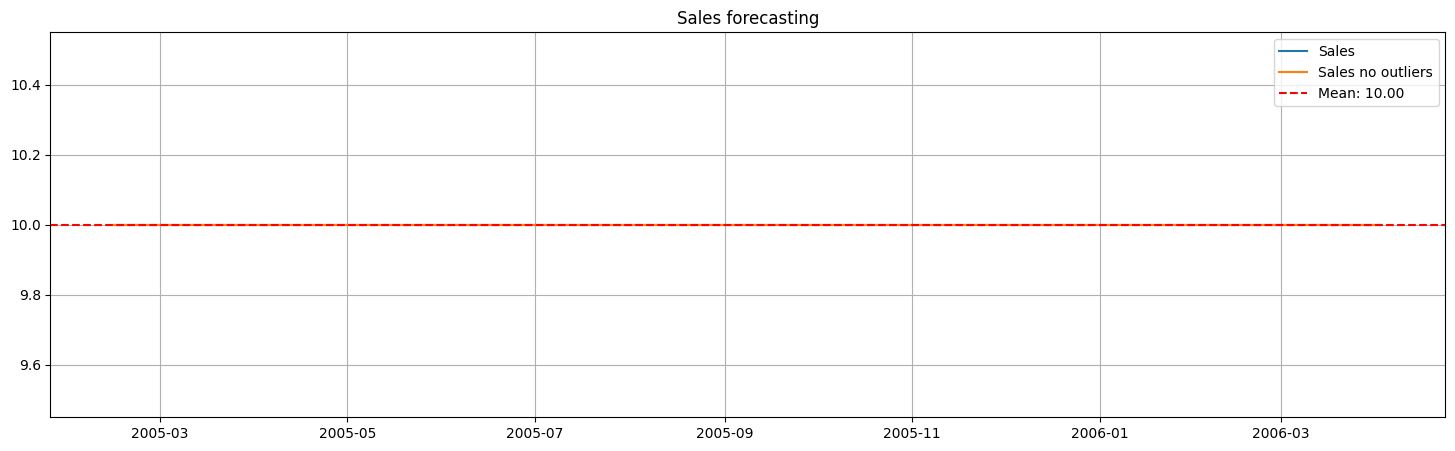

Processing Product ID: 2766
Rows found for Product 2766: 24
Low demand C ...

Percentage outliers:  0.0
Mean : 6.382352941176471, Median: 6.7857142857142865


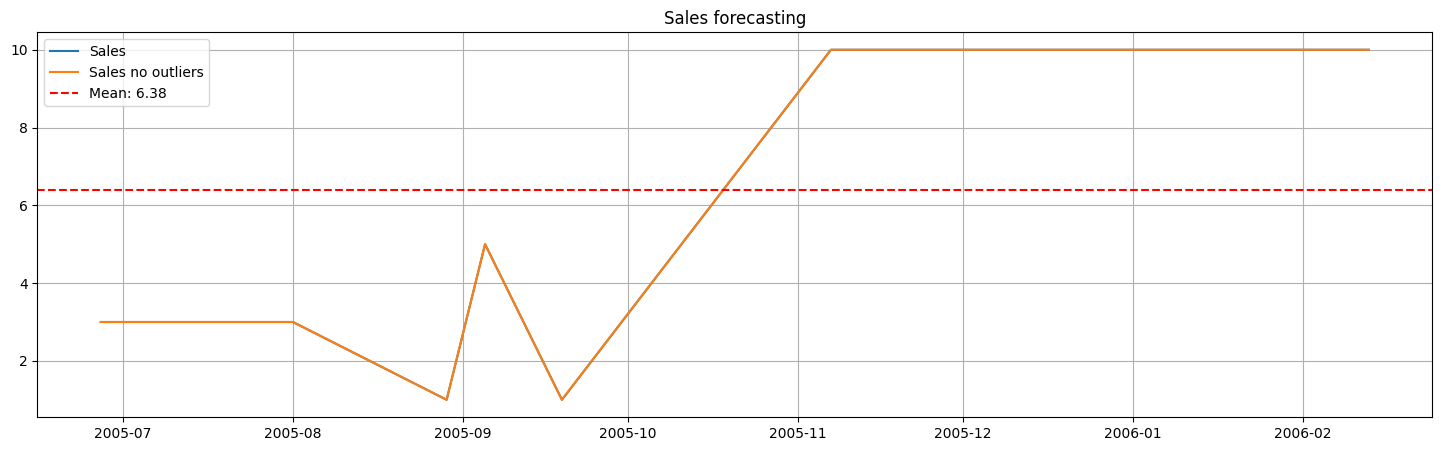

Processing Product ID: 884
Rows found for Product 884: 20
Low demand C ...

Percentage outliers:  0.0
Mean : 2.596774193548387, Median: 2.6363636363636362


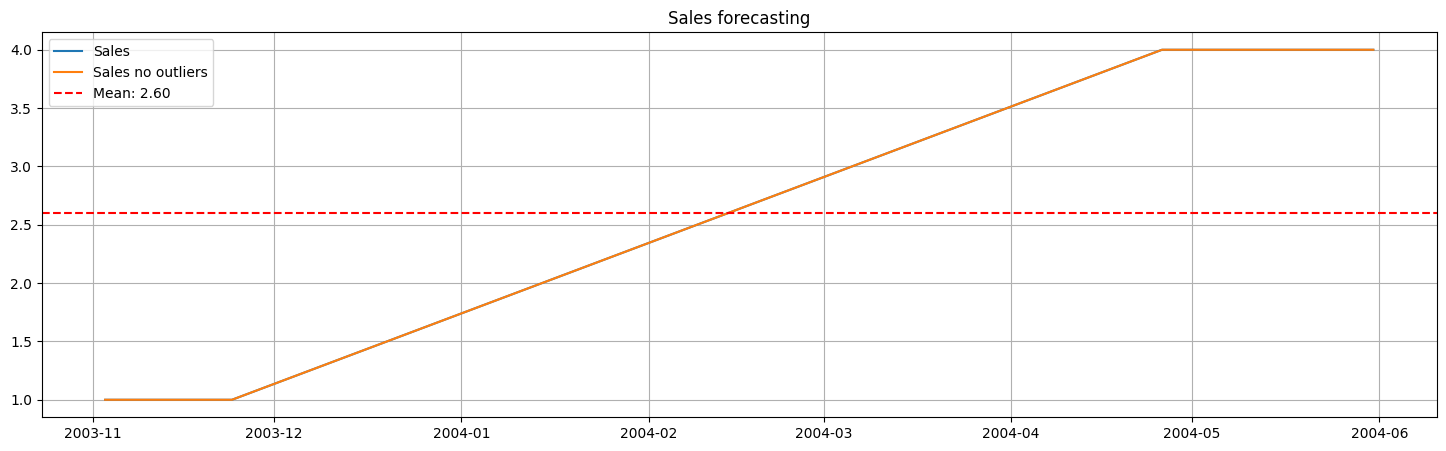

Processing Product ID: 1649
Rows found for Product 1649: 30
Low demand C ...

Percentage outliers:  8.536585365853659
Mean : 5.491935483870968, Median: 5.0


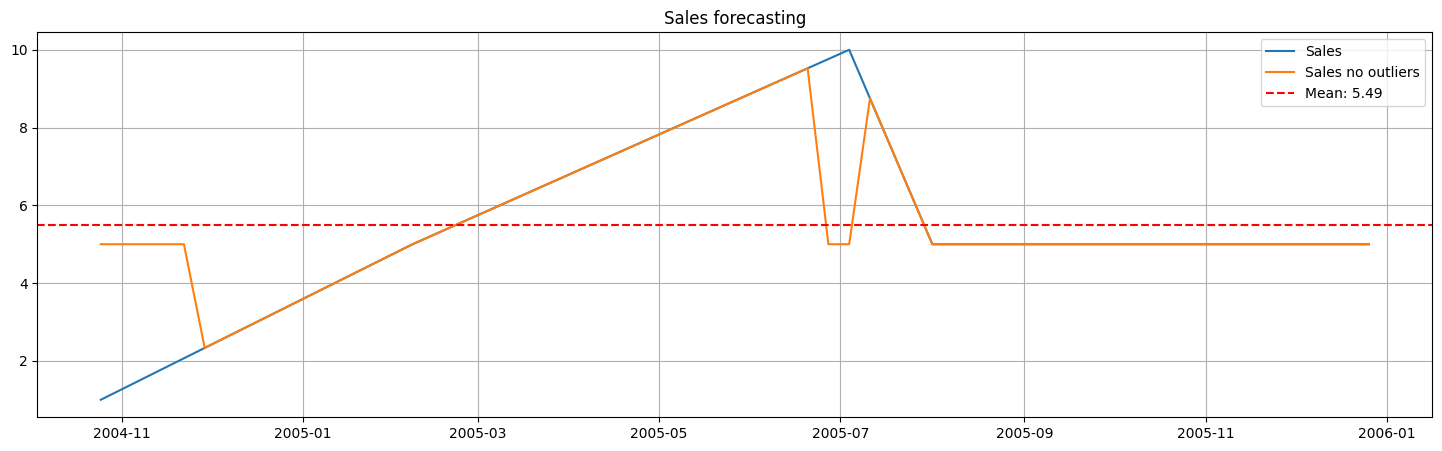

Processing Product ID: 526
Rows found for Product 526: 16
Low demand C ...

Percentage outliers:  0.0
Mean : 2.2341772151898733, Median: 2.171875


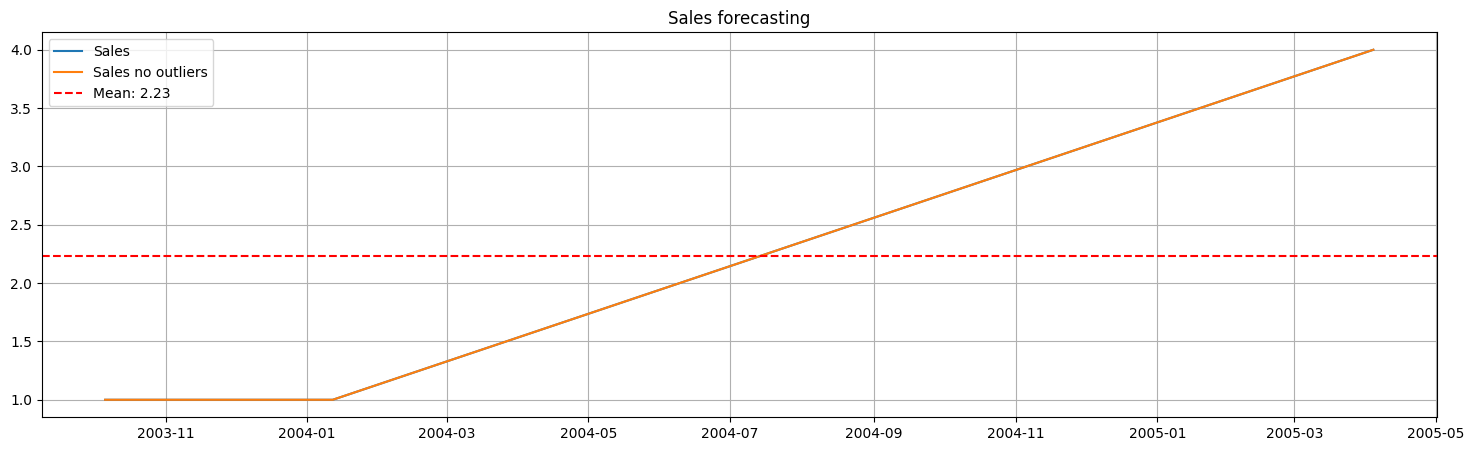

Processing Product ID: 2133
Rows found for Product 2133: 10
Low demand C ...

Percentage outliers:  0.0
Mean : 2.0, Median: 2.0


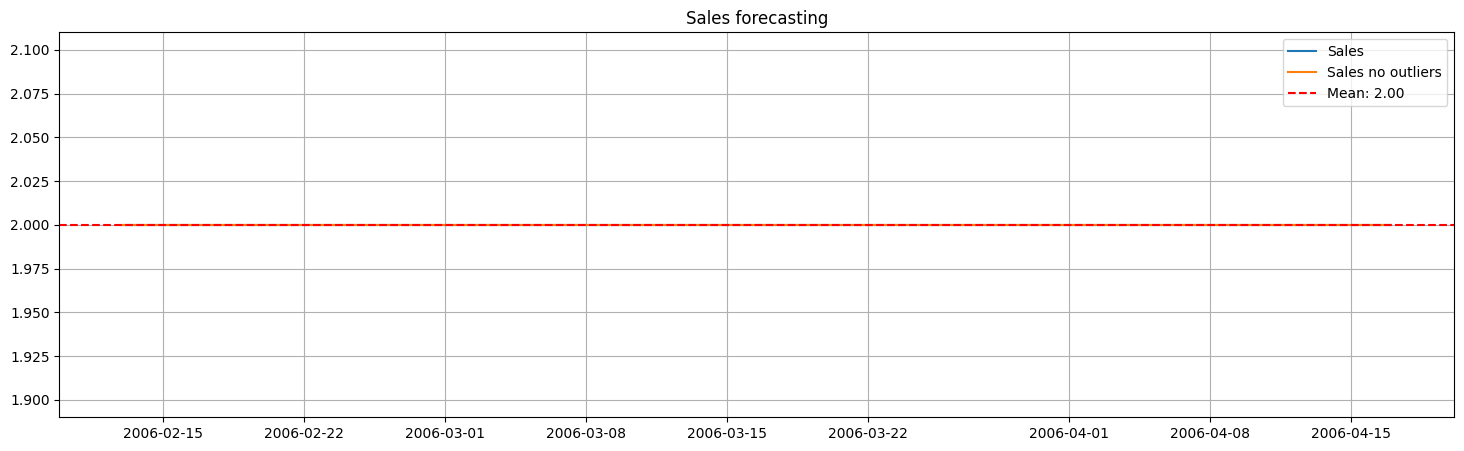

Processing Product ID: 3413
Rows found for Product 3413: 17
Low demand C ...

Percentage outliers:  0.0
Mean : 4.0, Median: 4.0


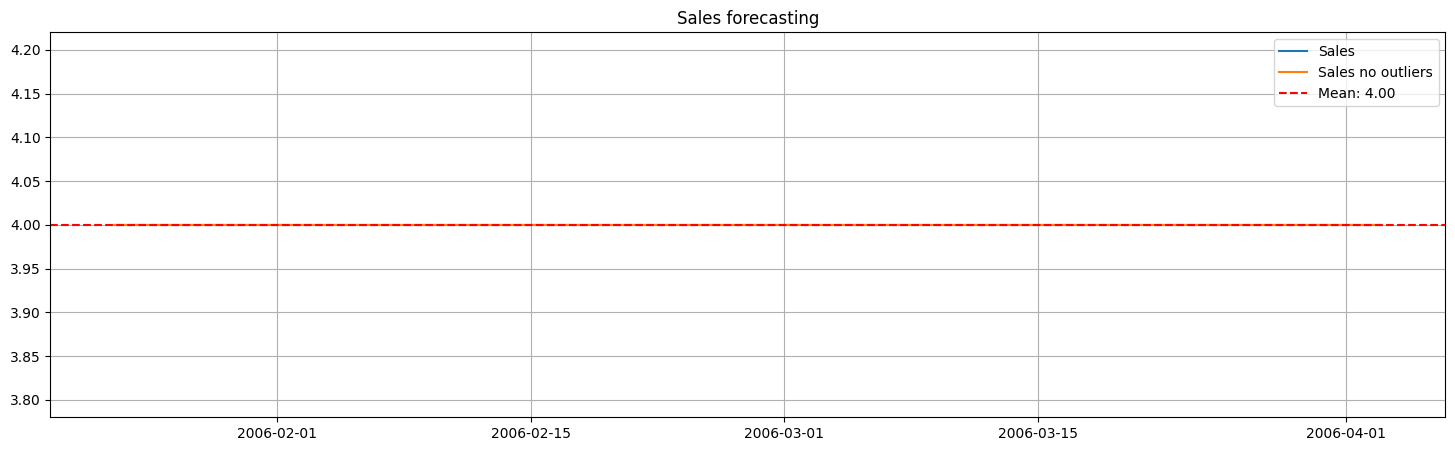

Processing Product ID: 373
Rows found for Product 373: 18
Low demand C ...

Percentage outliers:  9.090909090909092
Mean : 4.755102040816326, Median: 5.0


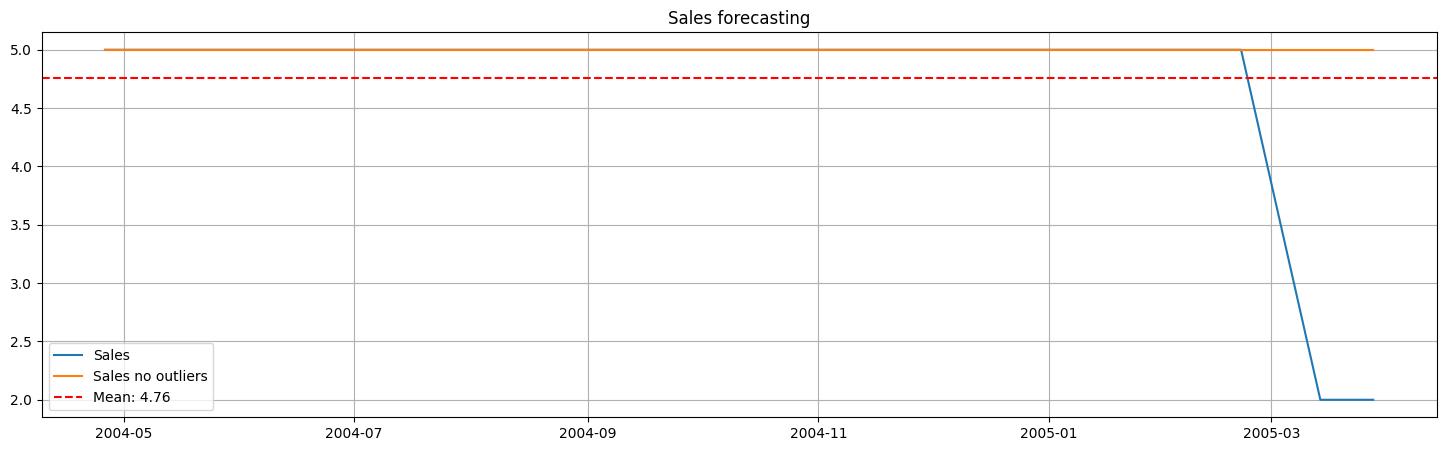

Processing Product ID: 1522
Rows found for Product 1522: 10
Low demand C ...

Percentage outliers:  0.0
Mean : 10.0, Median: 10.0


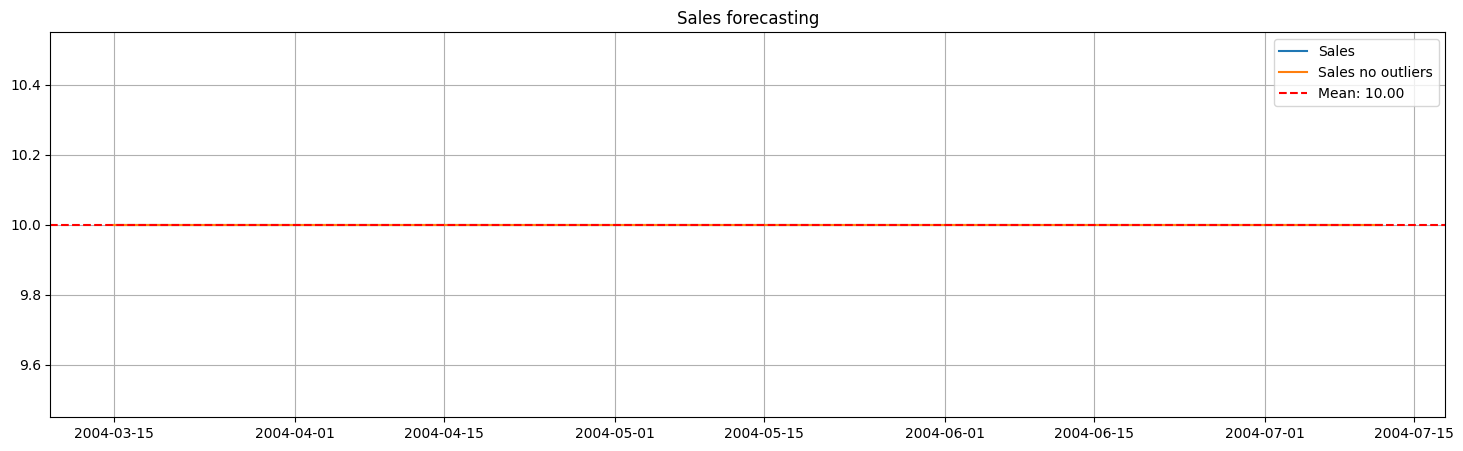

Processing Product ID: 1737
Rows found for Product 1737: 14
Low demand C ...

Percentage outliers:  0.0
Mean : 1.5, Median: 1.5


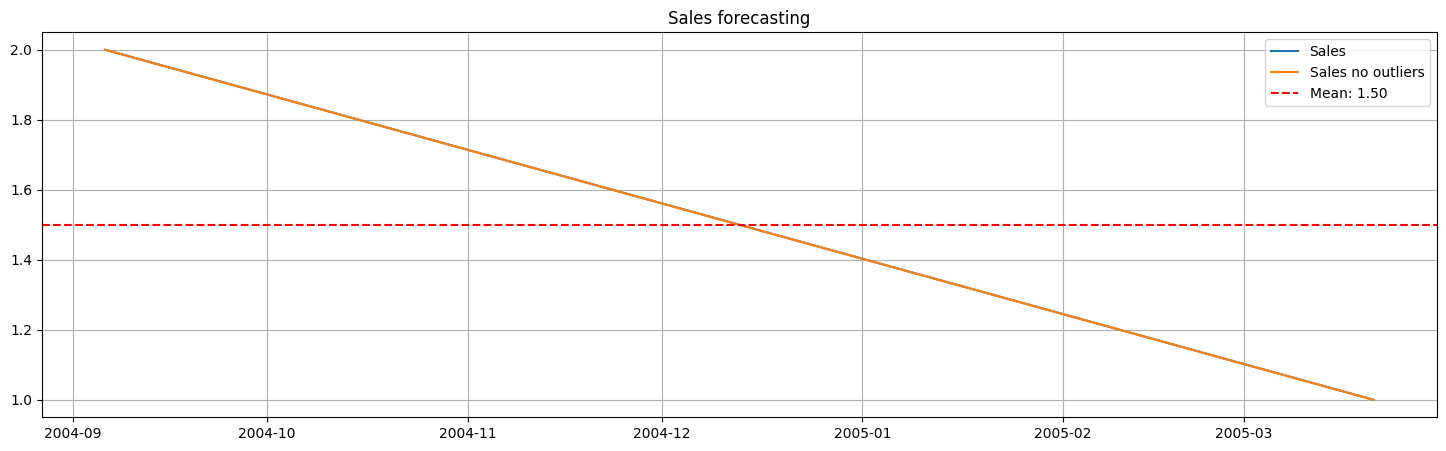

Processing Product ID: 1518
Rows found for Product 1518: 11
Low demand C ...

Percentage outliers:  0.0
Mean : 3.576923076923077, Median: 3.2413793103448274


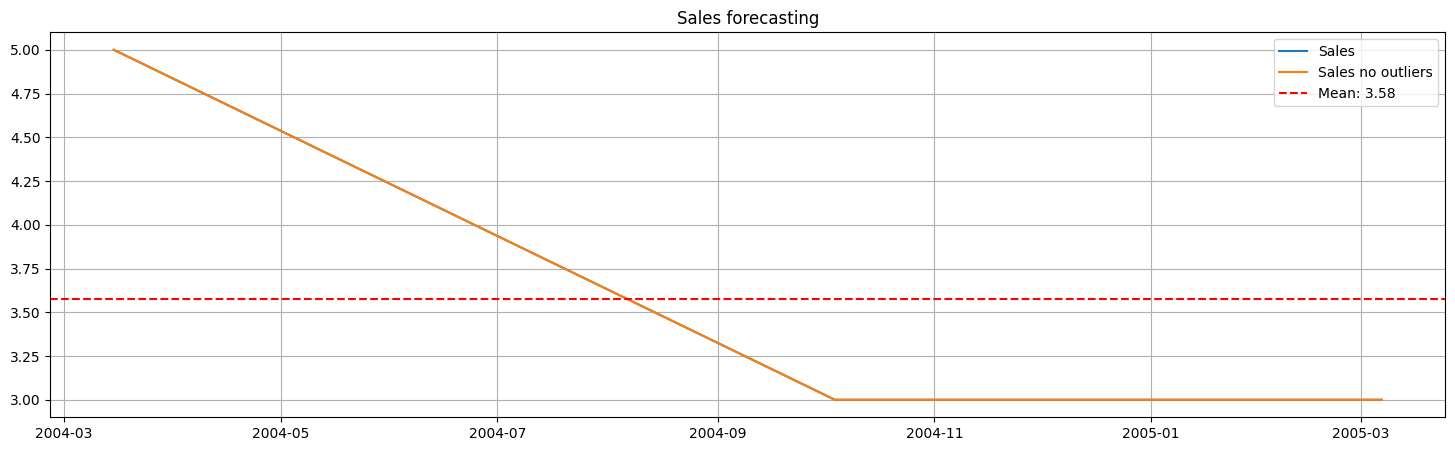

Processing Product ID: 532
Rows found for Product 532: 18
Low demand C ...

Percentage outliers:  0.0
Mean : 3.0, Median: 3.0


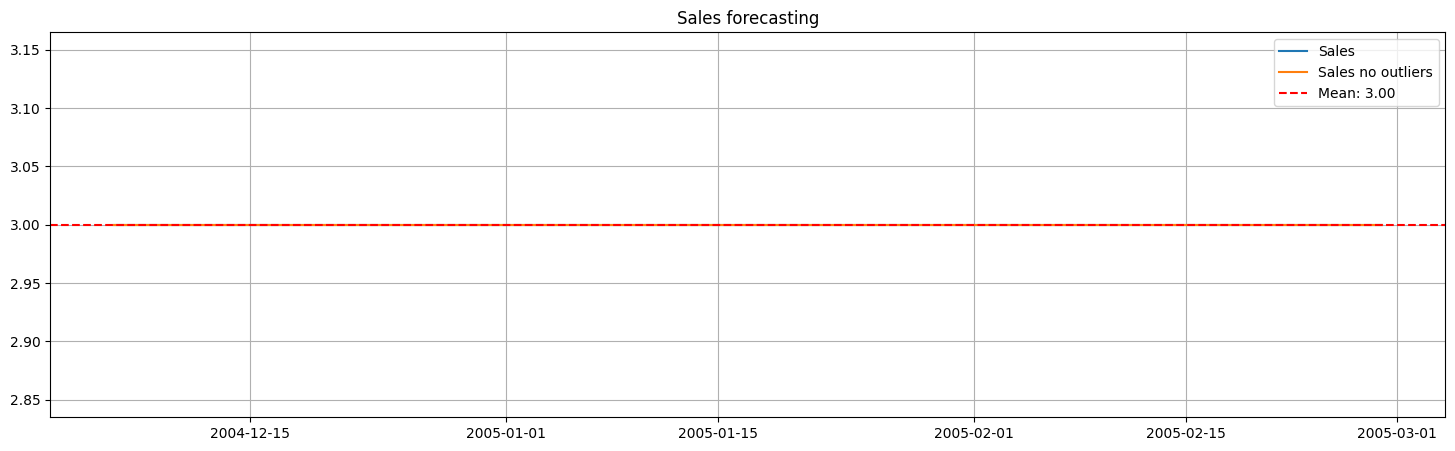

Processing Product ID: 3575
Rows found for Product 3575: 6
⚠️ Warning: No data available for Product 3575. Skipping.
Processing Product ID: 1767
Rows found for Product 1767: 12
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


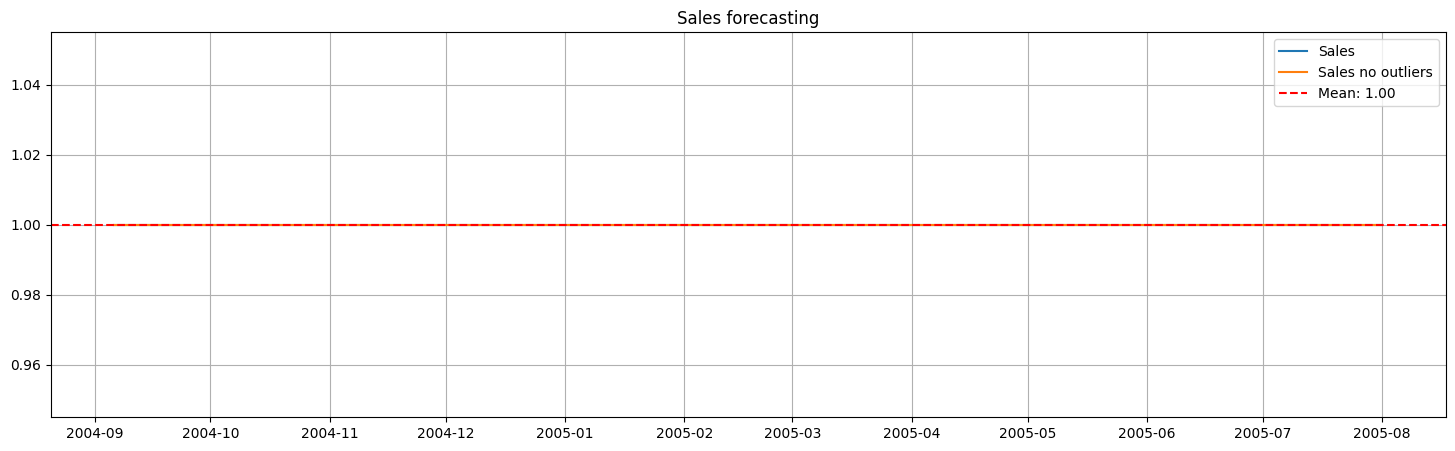

Processing Product ID: 176
Rows found for Product 176: 14
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


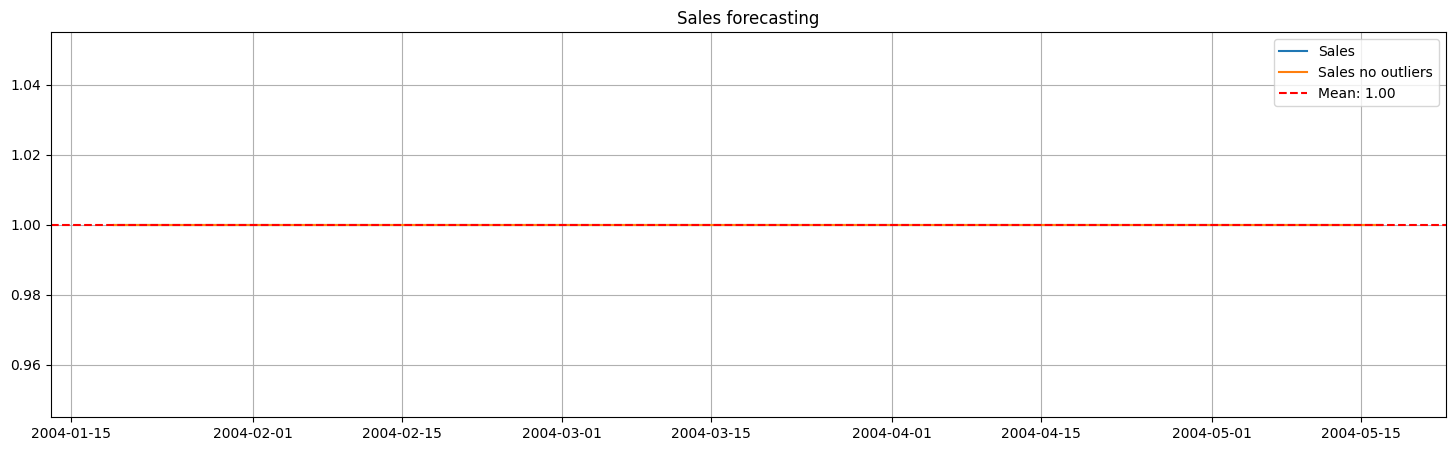

Processing Product ID: 2090
Rows found for Product 2090: 4
⚠️ Warning: No data available for Product 2090. Skipping.
Processing Product ID: 2751
Rows found for Product 2751: 19
Low demand C ...

Percentage outliers:  0.0
Mean : 4.0, Median: 4.0


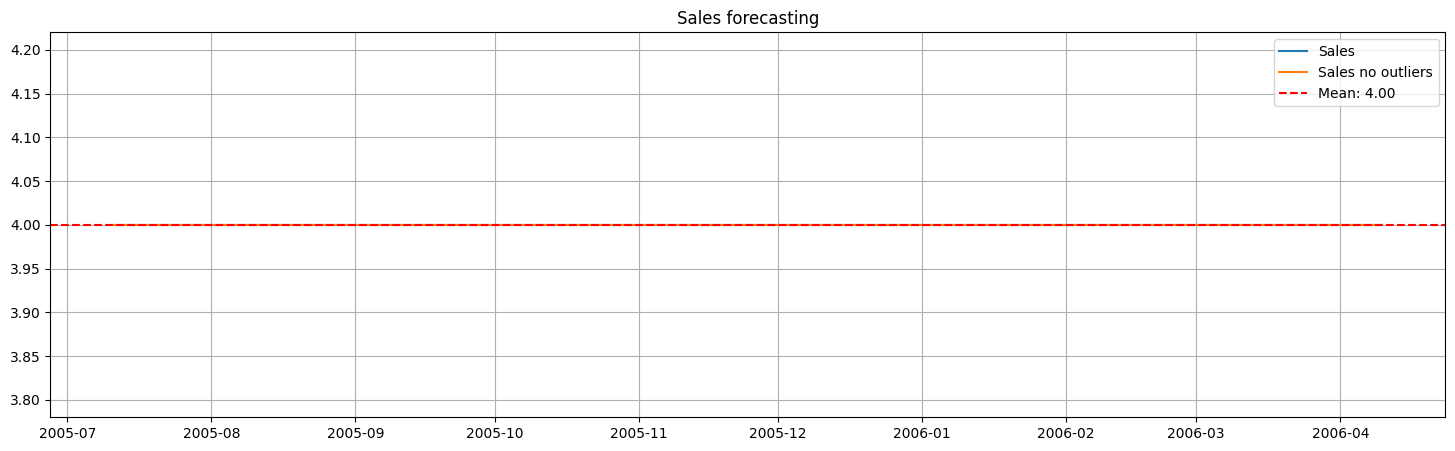

Processing Product ID: 2963
Rows found for Product 2963: 18
Low demand C ...

Percentage outliers:  3.225806451612903
Mean : 1.1333333333333333, Median: 1.0


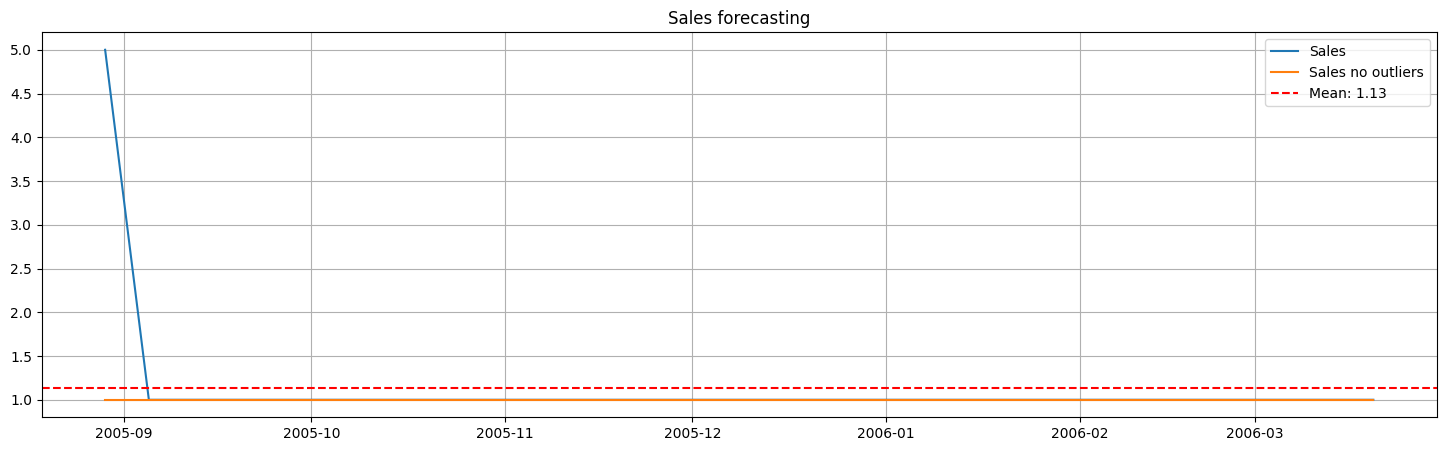

Processing Product ID: 2551
Rows found for Product 2551: 11
Low demand C ...

Percentage outliers:  0.0
Mean : 2.5, Median: 2.5


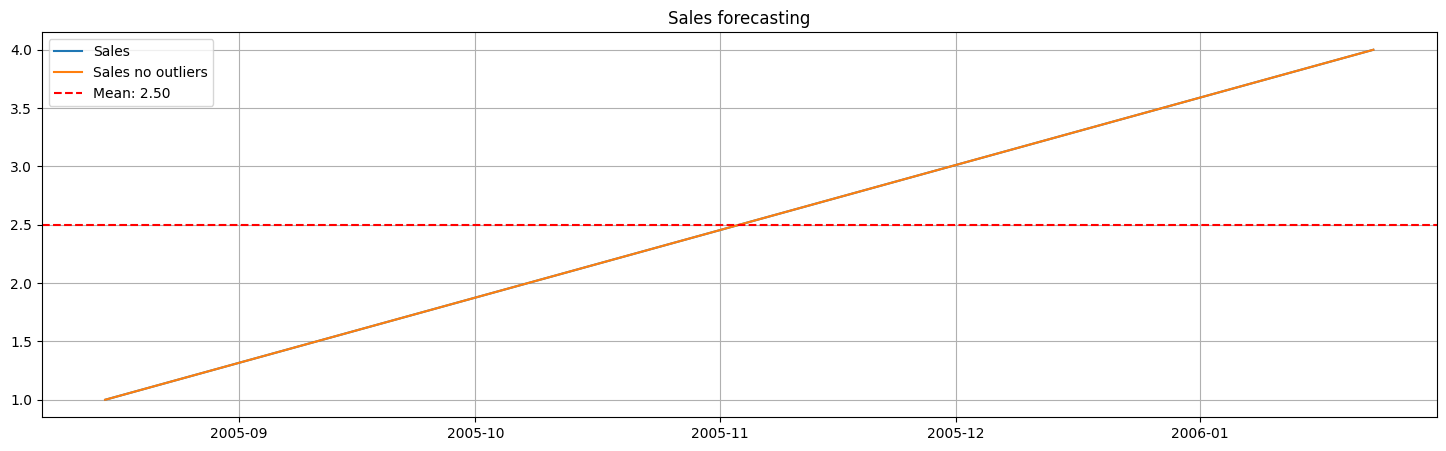

Processing Product ID: 784
Rows found for Product 784: 17
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


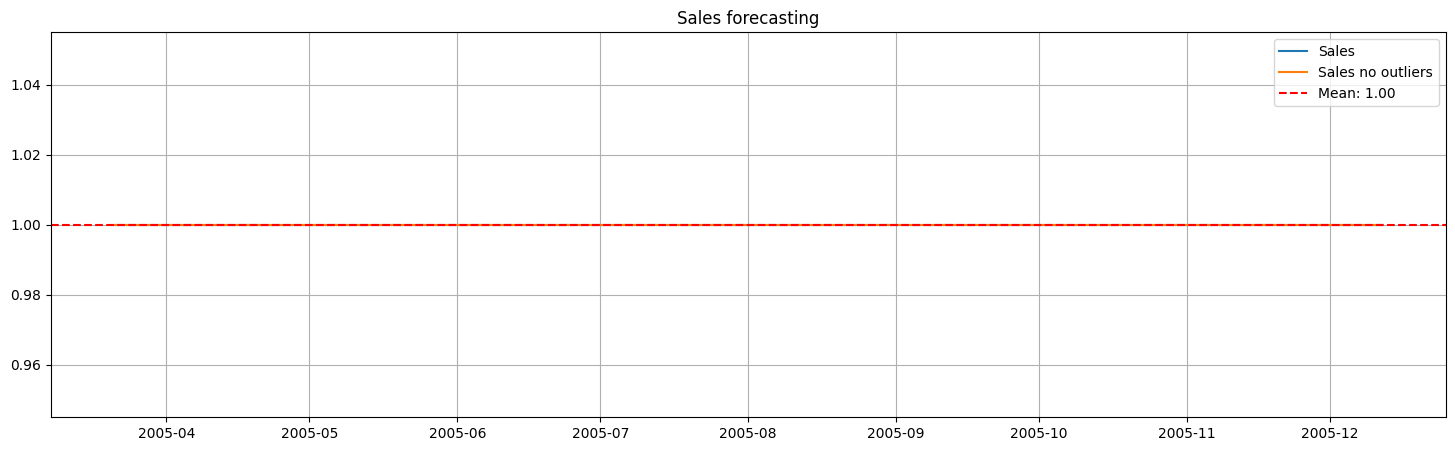

Processing Product ID: 3252
Rows found for Product 3252: 8
⚠️ Warning: No data available for Product 3252. Skipping.
Processing Product ID: 1331
Rows found for Product 1331: 34
Low demand C ...

Percentage outliers:  13.333333333333334
Mean : 4.2, Median: 4.0


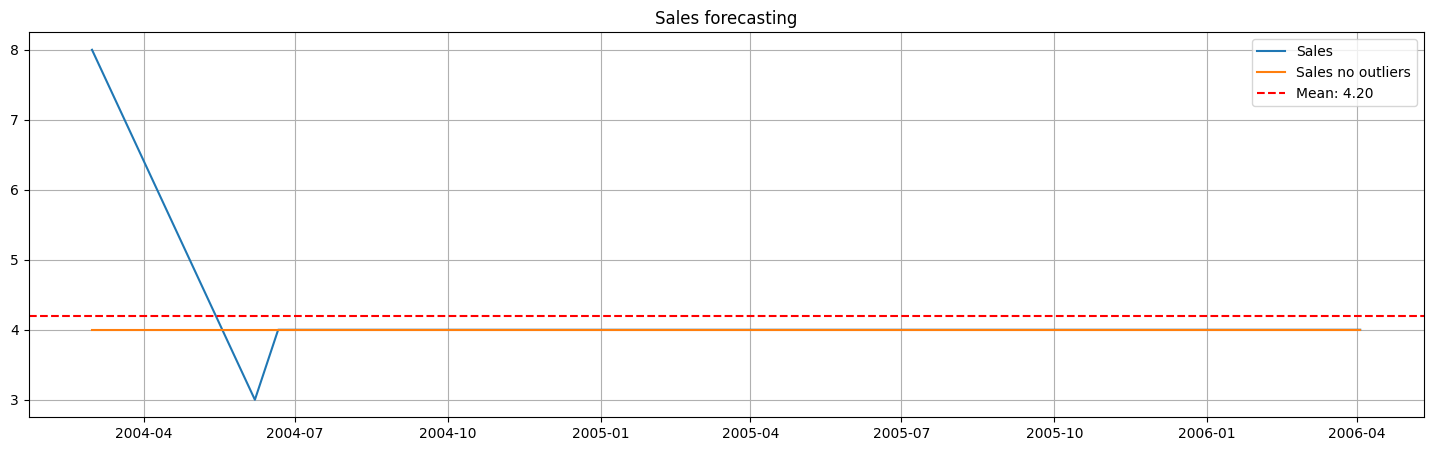

Processing Product ID: 2962
Rows found for Product 2962: 13
Low demand C ...

Percentage outliers:  0.0
Mean : 2.6666666666666665, Median: 2.0


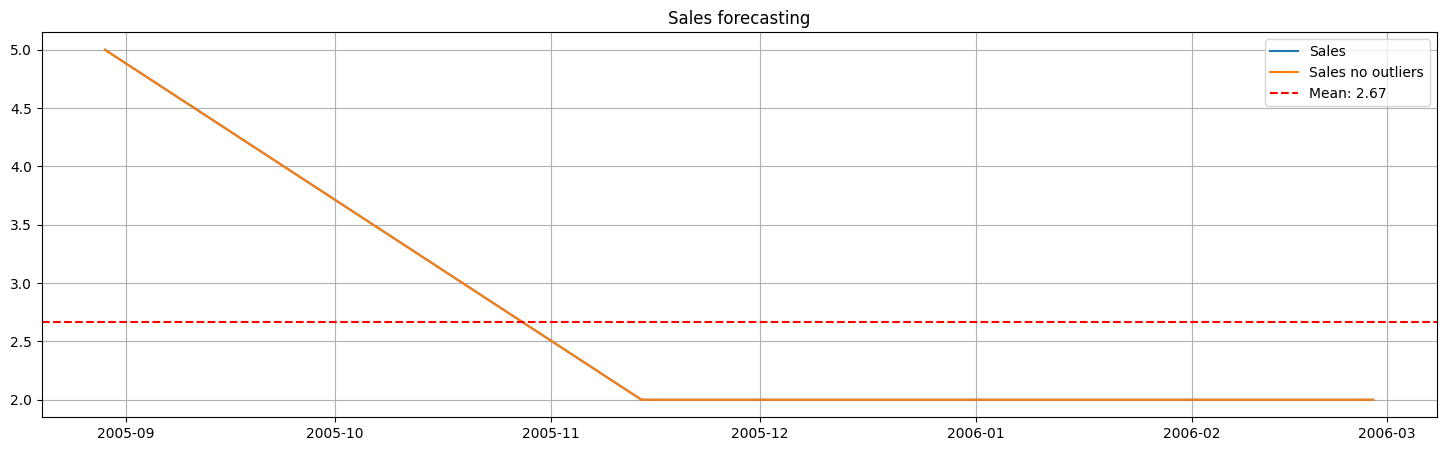

Processing Product ID: 2806
Rows found for Product 2806: 12
Low demand C ...

Percentage outliers:  0.0
Mean : 3.5833333333333335, Median: 3.6681818181818184


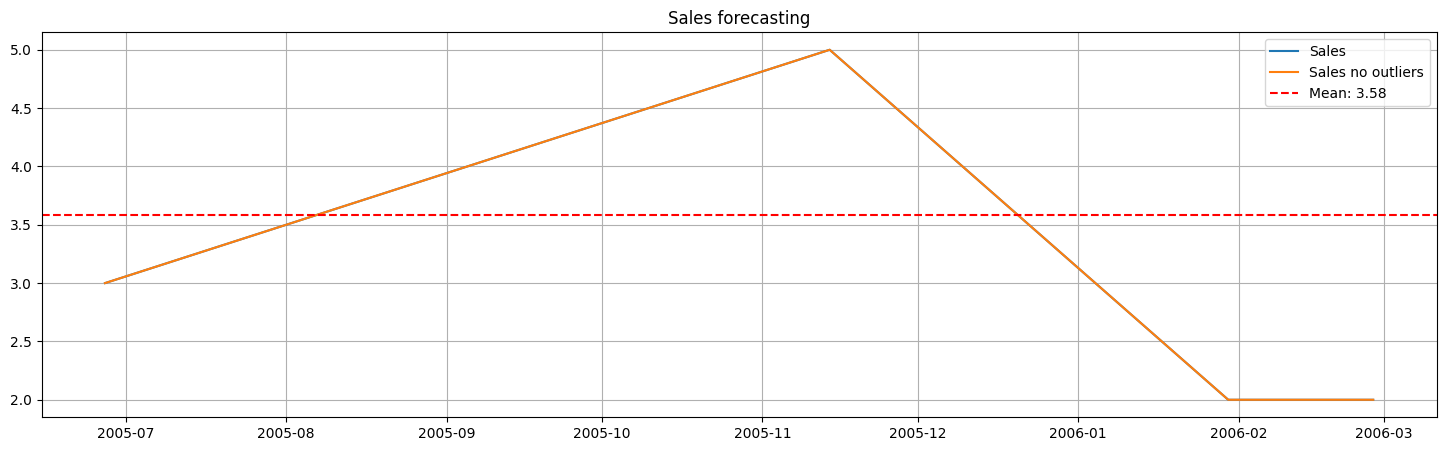

Processing Product ID: 372
Rows found for Product 372: 16
Low demand C ...

Percentage outliers:  0.0
Mean : 3.5925925925925926, Median: 3.290322580645161


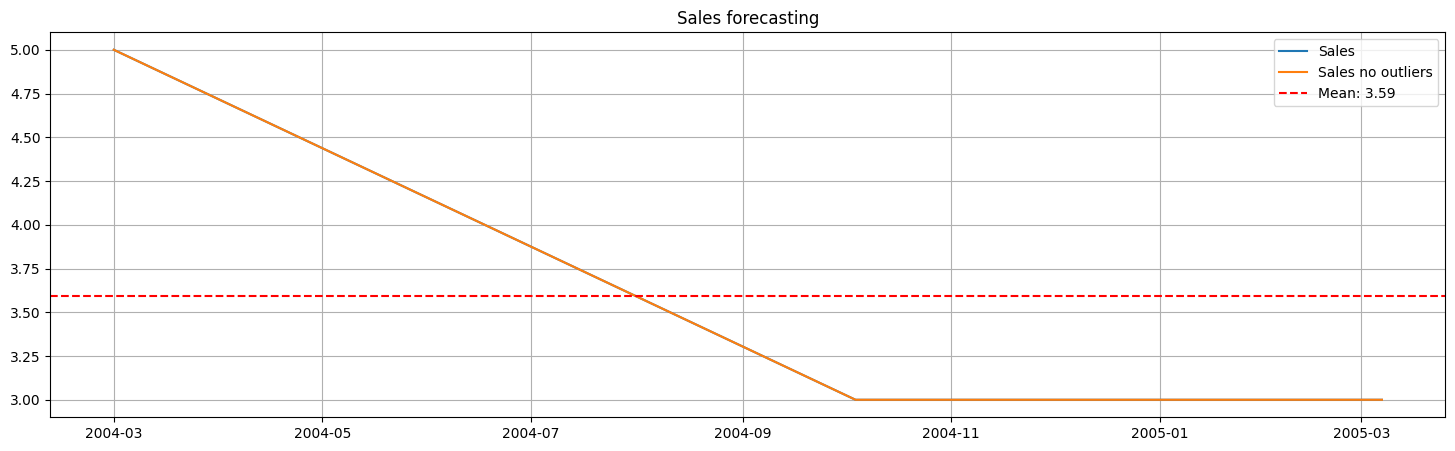

Processing Product ID: 3328
Rows found for Product 3328: 9
⚠️ Warning: No data available for Product 3328. Skipping.
Processing Product ID: 1305
Rows found for Product 1305: 9
⚠️ Warning: No data available for Product 1305. Skipping.
Processing Product ID: 3646
Rows found for Product 3646: 17
Low demand C ...

Percentage outliers:  20.833333333333336
Mean : 1.25, Median: 1.0


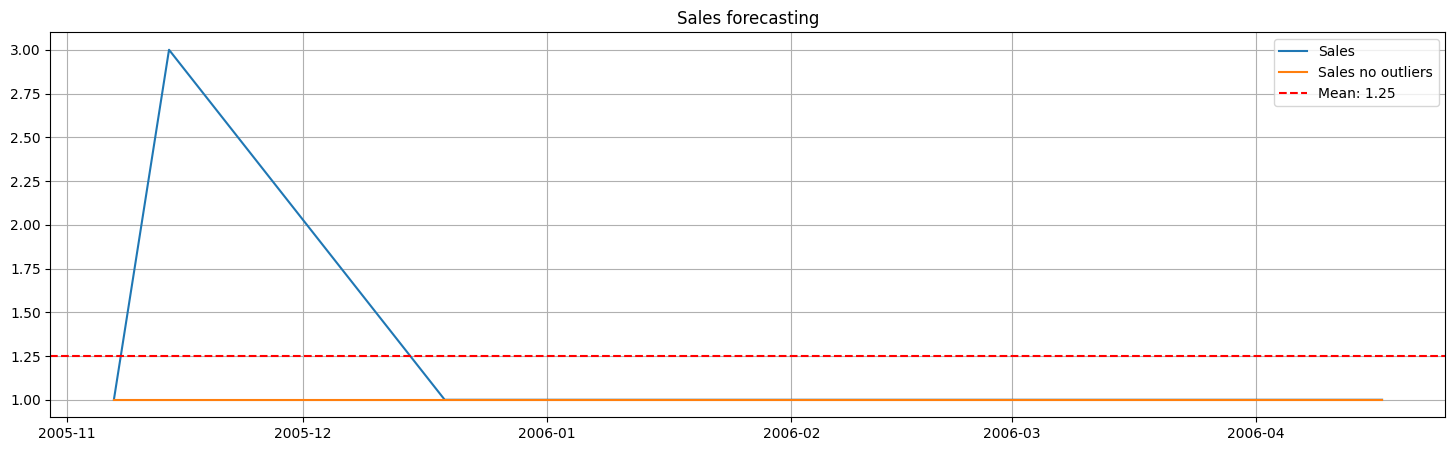

Processing Product ID: 2398
Rows found for Product 2398: 8
⚠️ Warning: No data available for Product 2398. Skipping.
Processing Product ID: 471
Rows found for Product 471: 18
Low demand C ...

Percentage outliers:  0.0
Mean : 2.0, Median: 2.0


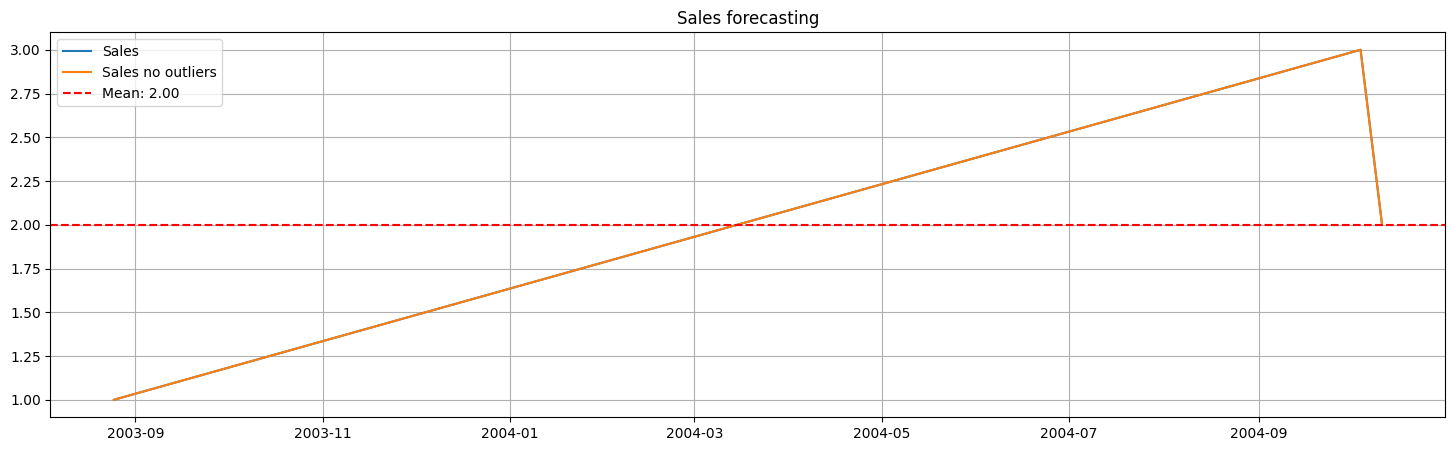

Processing Product ID: 2561
Rows found for Product 2561: 10
Low demand C ...

Processing Product ID: 1650
Rows found for Product 1650: 9
⚠️ Warning: No data available for Product 1650. Skipping.
Processing Product ID: 3383
Rows found for Product 3383: 14
Low demand C ...

Percentage outliers:  0.0
Mean : 8.088235294117647, Median: 7.078947368421052


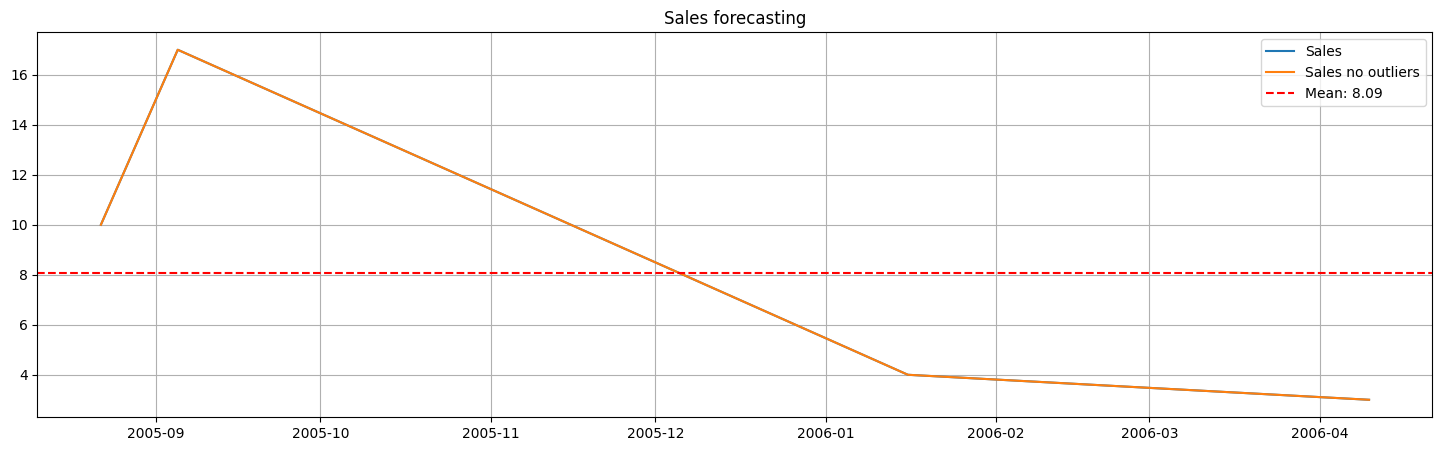

Processing Product ID: 3070
Rows found for Product 3070: 13
Low demand C ...

Percentage outliers:  2.631578947368421
Mean : 4.818181818181818, Median: 5.0


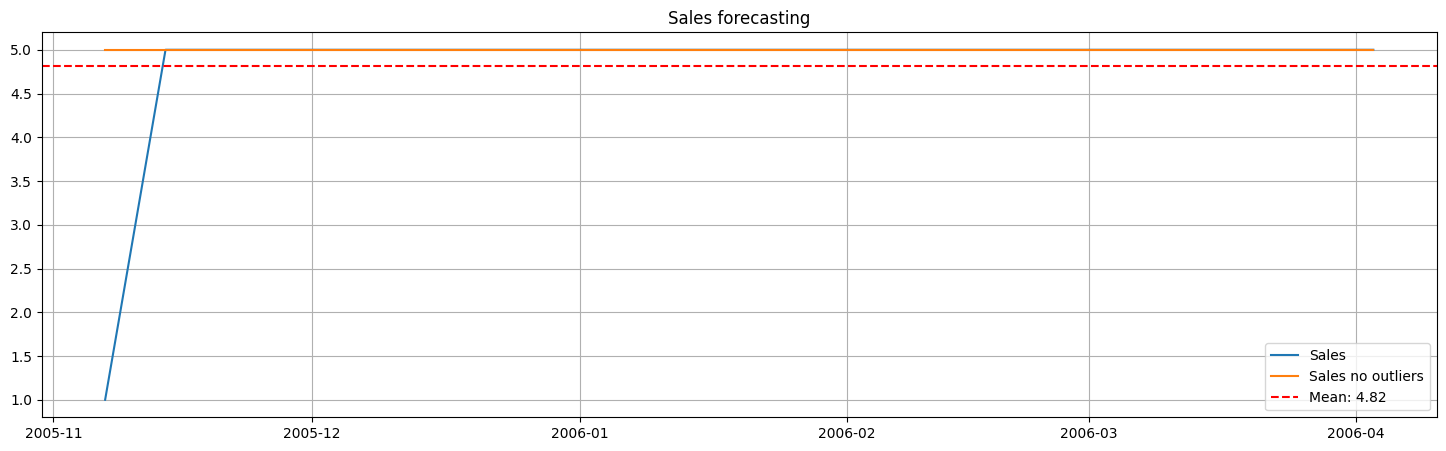

Processing Product ID: 2790
Rows found for Product 2790: 16
Low demand C ...

Percentage outliers:  0.0
Mean : 2.8947368421052633, Median: 2.84


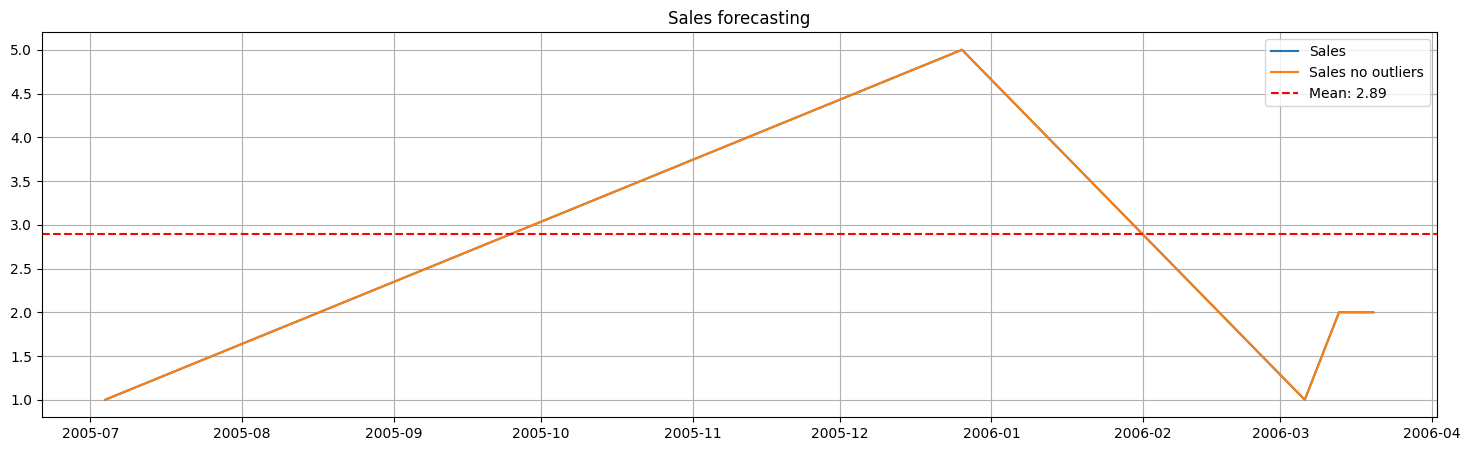

Processing Product ID: 3250
Rows found for Product 3250: 10
Low demand C ...

Percentage outliers:  0.0
Mean : 4.0, Median: 4.0


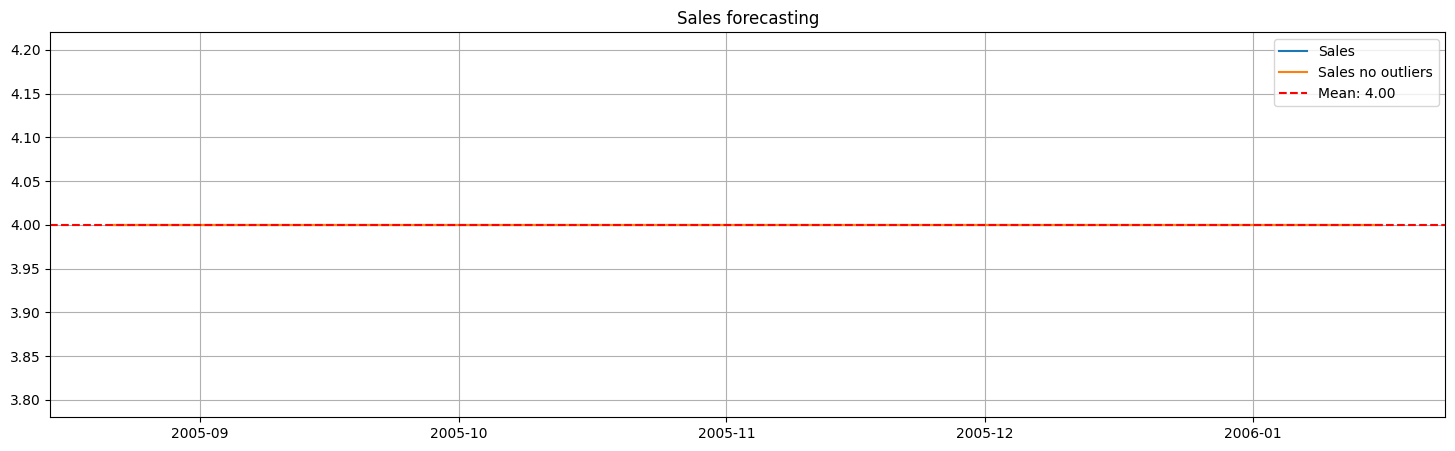

Processing Product ID: 3474
Rows found for Product 3474: 10
Low demand C ...

Percentage outliers:  0.0
Mean : 3.0, Median: 3.0


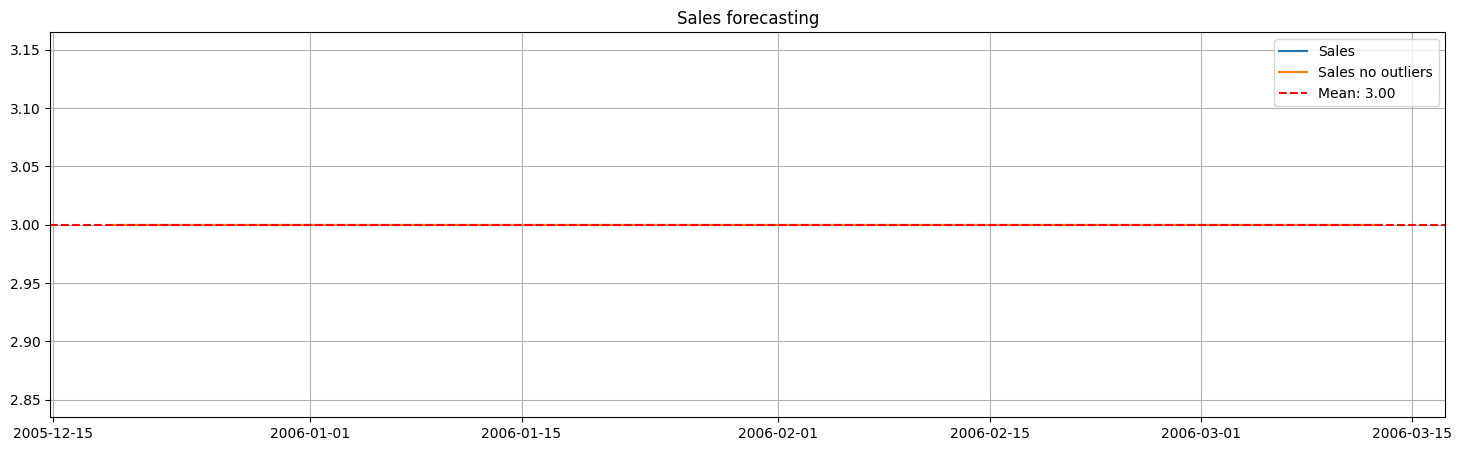

Processing Product ID: 3321
Rows found for Product 3321: 8
⚠️ Warning: No data available for Product 3321. Skipping.
Processing Product ID: 3782
Rows found for Product 3782: 8
⚠️ Warning: No data available for Product 3782. Skipping.
Processing Product ID: 1163
Rows found for Product 1163: 13
Low demand C ...

Percentage outliers:  21.428571428571427
Mean : 5.613207547169812, Median: 5.0


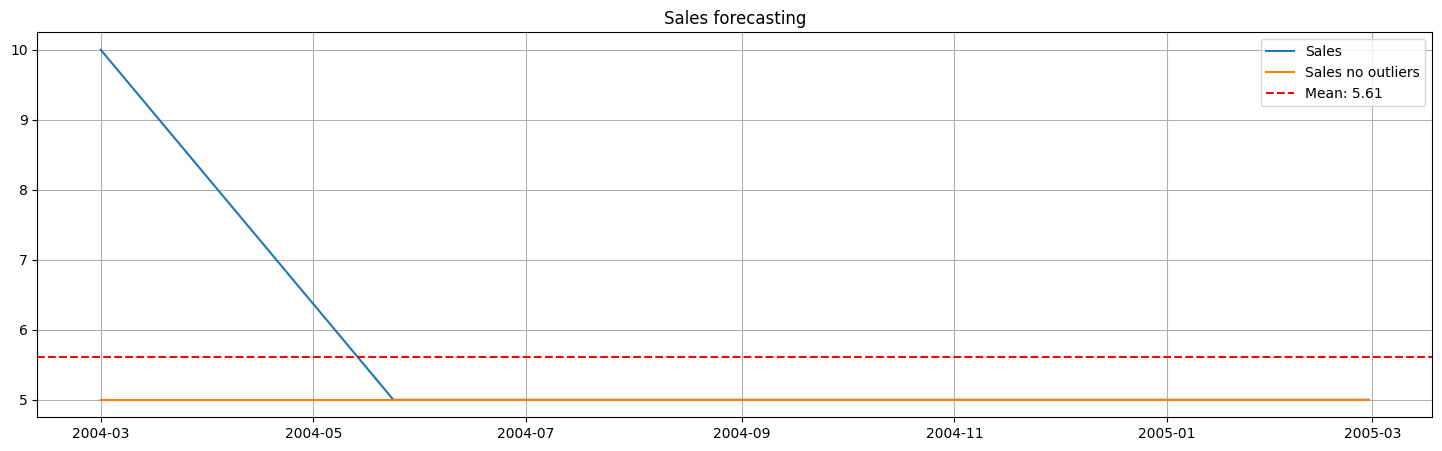

Processing Product ID: 417
Rows found for Product 417: 20
Low demand C ...

Percentage outliers:  0.0
Mean : 4.291666666666667, Median: 5.0


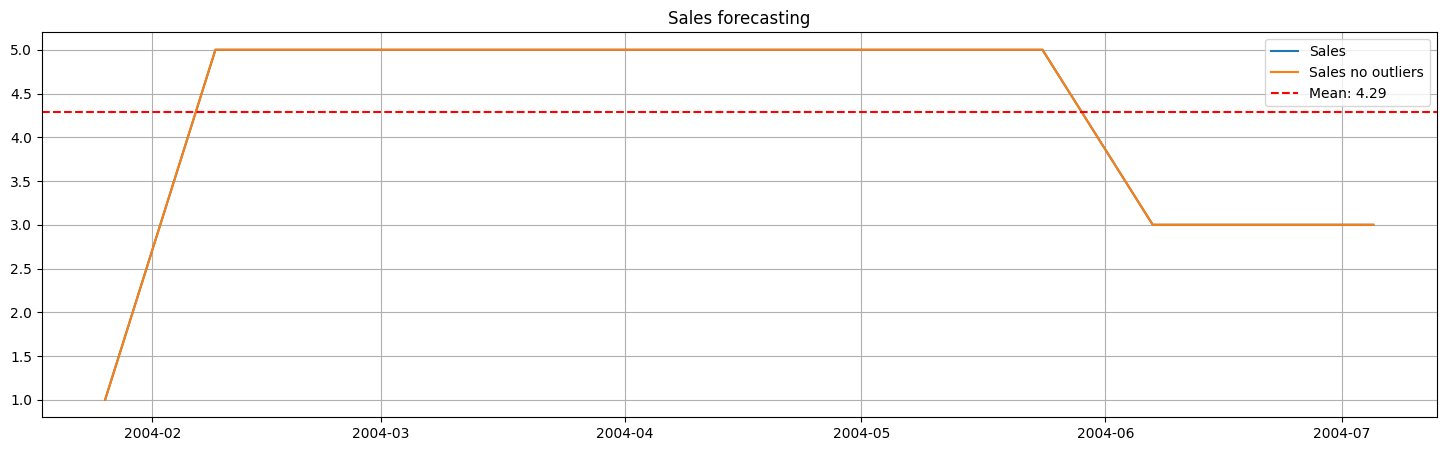

Processing Product ID: 2263
Rows found for Product 2263: 6
⚠️ Warning: No data available for Product 2263. Skipping.
Processing Product ID: 1417
Rows found for Product 1417: 7
⚠️ Warning: No data available for Product 1417. Skipping.
Processing Product ID: 2643
Rows found for Product 2643: 9
⚠️ Warning: No data available for Product 2643. Skipping.
Processing Product ID: 1611
Rows found for Product 1611: 10
Low demand C ...

Processing Product ID: 1619
Rows found for Product 1619: 8
⚠️ Warning: No data available for Product 1619. Skipping.
Processing Product ID: 365
Rows found for Product 365: 16
Low demand C ...

Percentage outliers:  0.0
Mean : 3.15, Median: 3.75


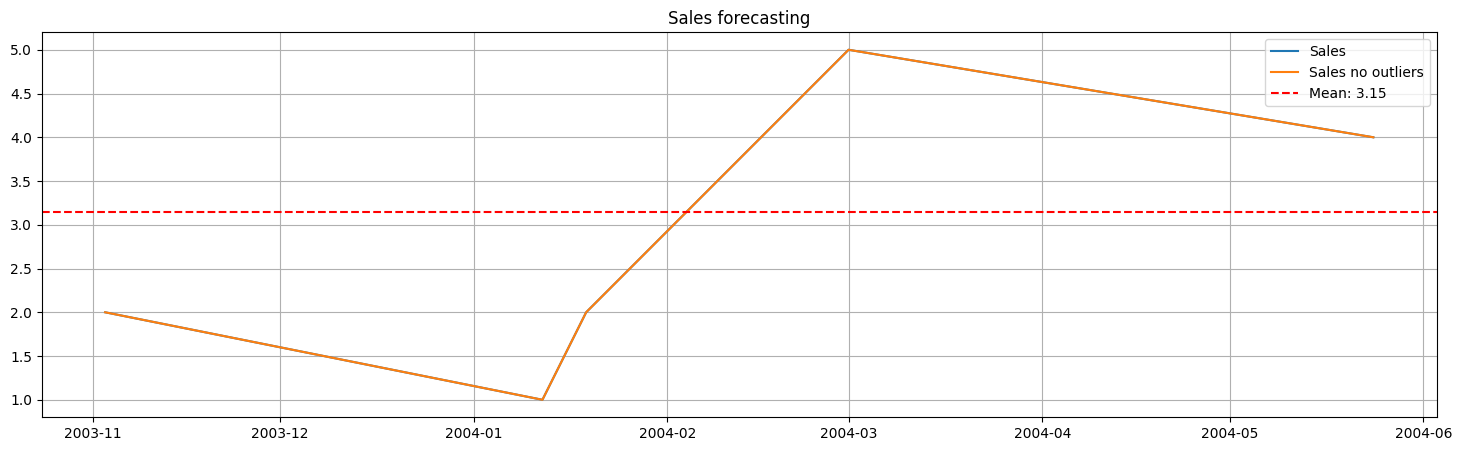

Processing Product ID: 3447
Rows found for Product 3447: 14
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


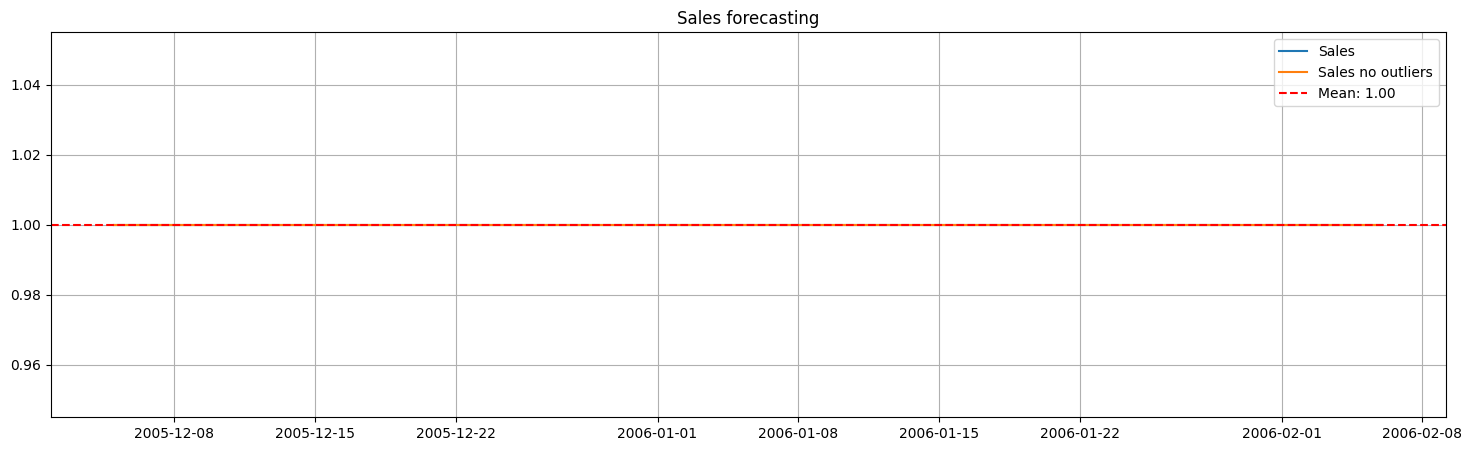

Processing Product ID: 3783
Rows found for Product 3783: 5
⚠️ Warning: No data available for Product 3783. Skipping.
Processing Product ID: 3236
Rows found for Product 3236: 14
Low demand C ...

Processing Product ID: 1073
Rows found for Product 1073: 13
Low demand C ...

Percentage outliers:  0.0
Mean : 10.0, Median: 10.0


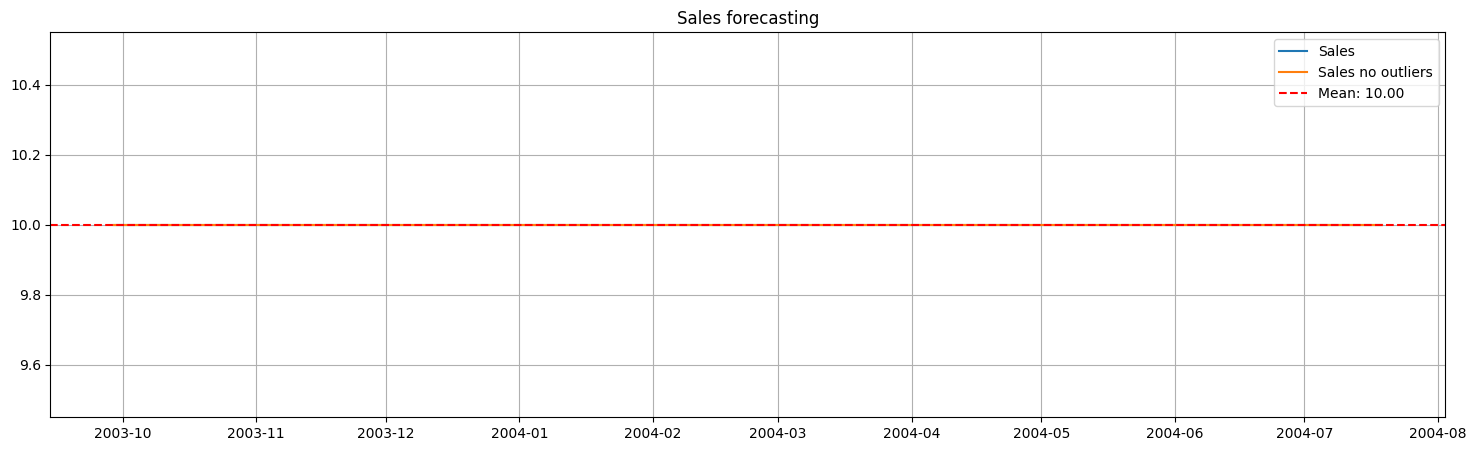

Processing Product ID: 2926
Rows found for Product 2926: 11
Low demand C ...

Percentage outliers:  13.333333333333334
Mean : 4.366666666666666, Median: 4.0


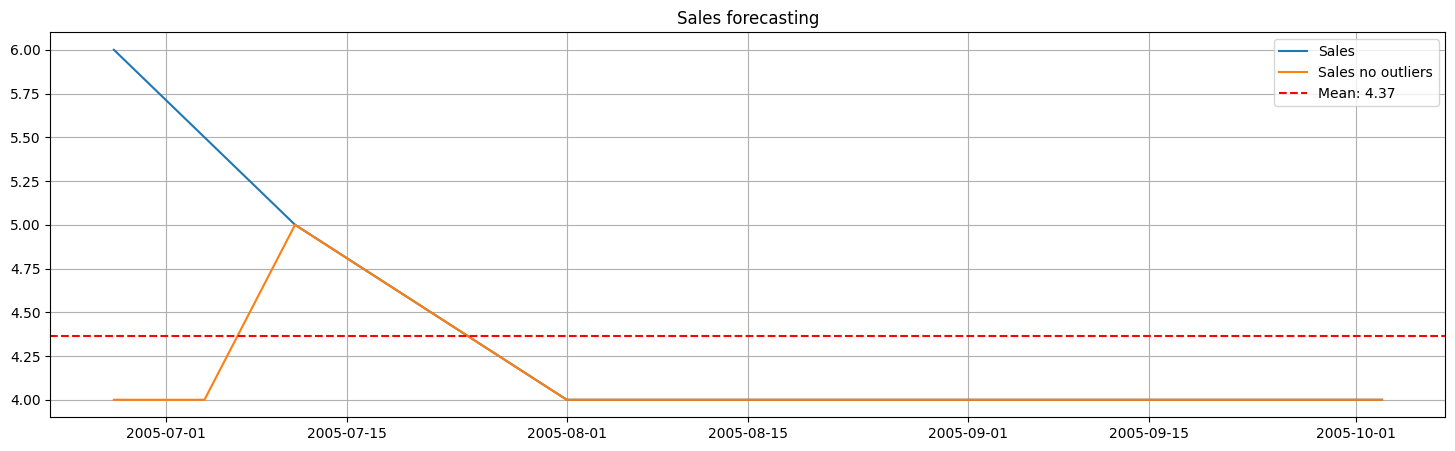

Processing Product ID: 1248
Rows found for Product 1248: 11
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


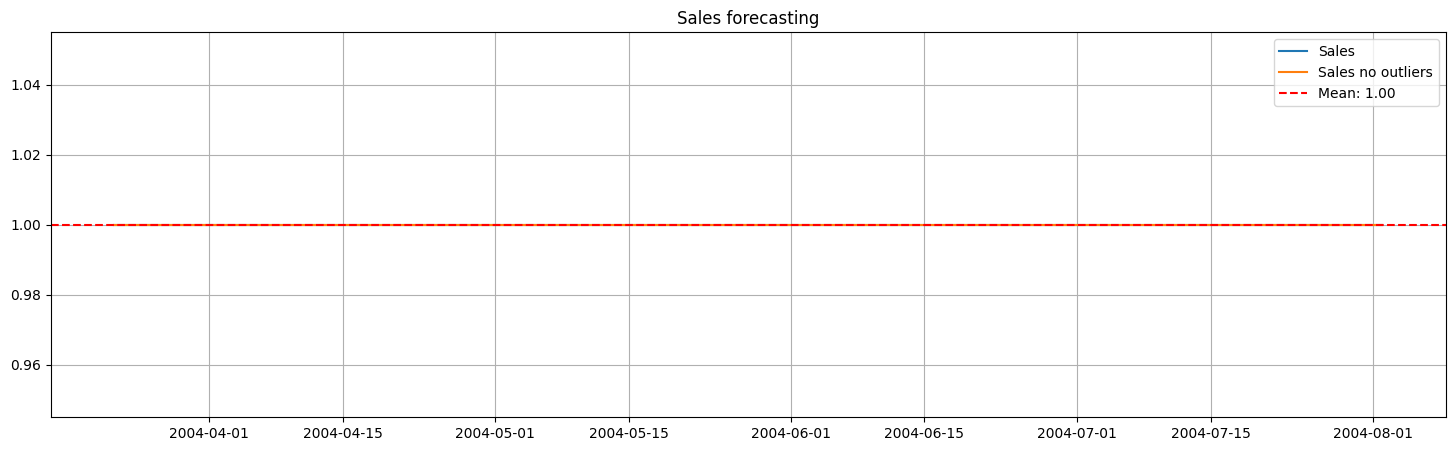

Processing Product ID: 1510
Rows found for Product 1510: 9
⚠️ Warning: No data available for Product 1510. Skipping.
Processing Product ID: 3606
Rows found for Product 3606: 13
Low demand C ...

Percentage outliers:  21.73913043478261
Mean : 1.4565217391304348, Median: 1.0


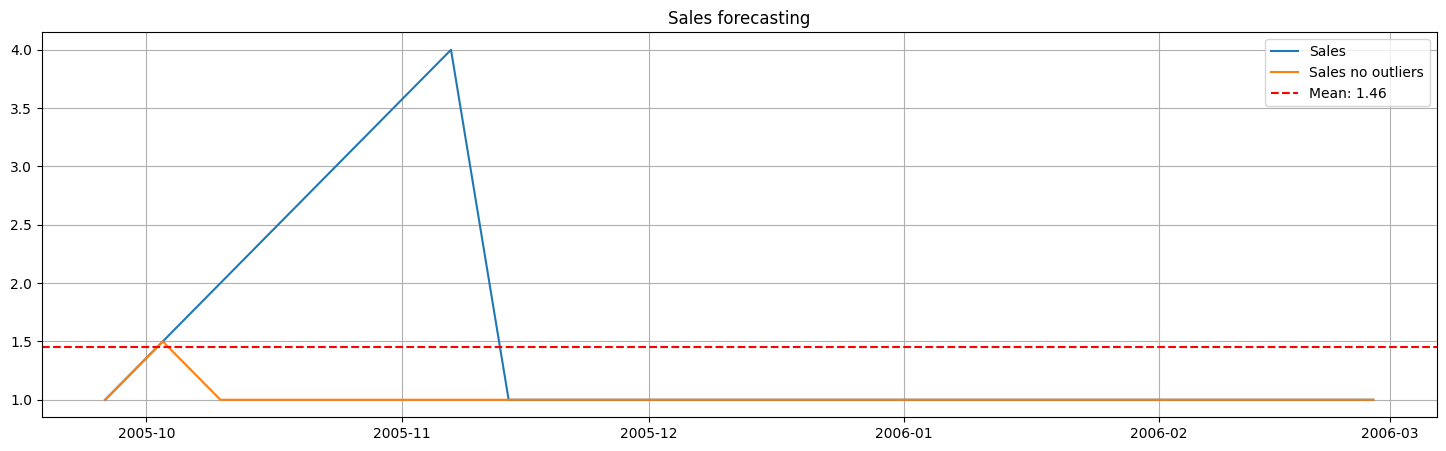

Processing Product ID: 1768
Rows found for Product 1768: 8
⚠️ Warning: No data available for Product 1768. Skipping.
Processing Product ID: 3392
Rows found for Product 3392: 8
⚠️ Warning: No data available for Product 3392. Skipping.
Processing Product ID: 3201
Rows found for Product 3201: 8
⚠️ Warning: No data available for Product 3201. Skipping.
Processing Product ID: 147
Rows found for Product 147: 13
Low demand C ...

Percentage outliers:  6.329113924050633
Mean : 2.335616438356164, Median: 2.0


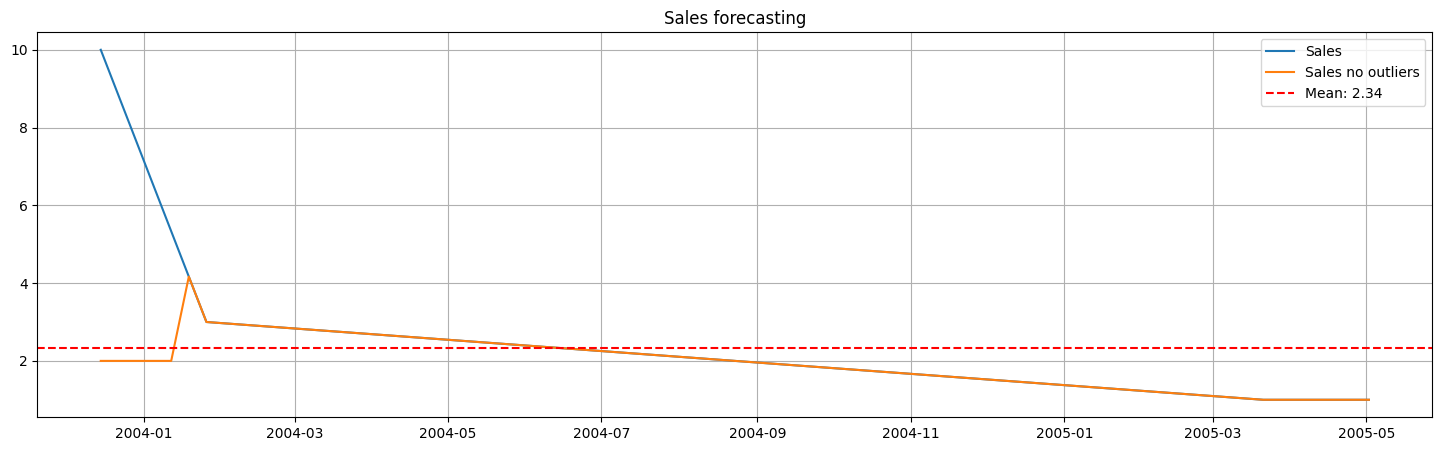

Processing Product ID: 698
Rows found for Product 698: 12
Low demand C ...

Percentage outliers:  3.9603960396039604
Mean : 1.1111111111111112, Median: 1.0


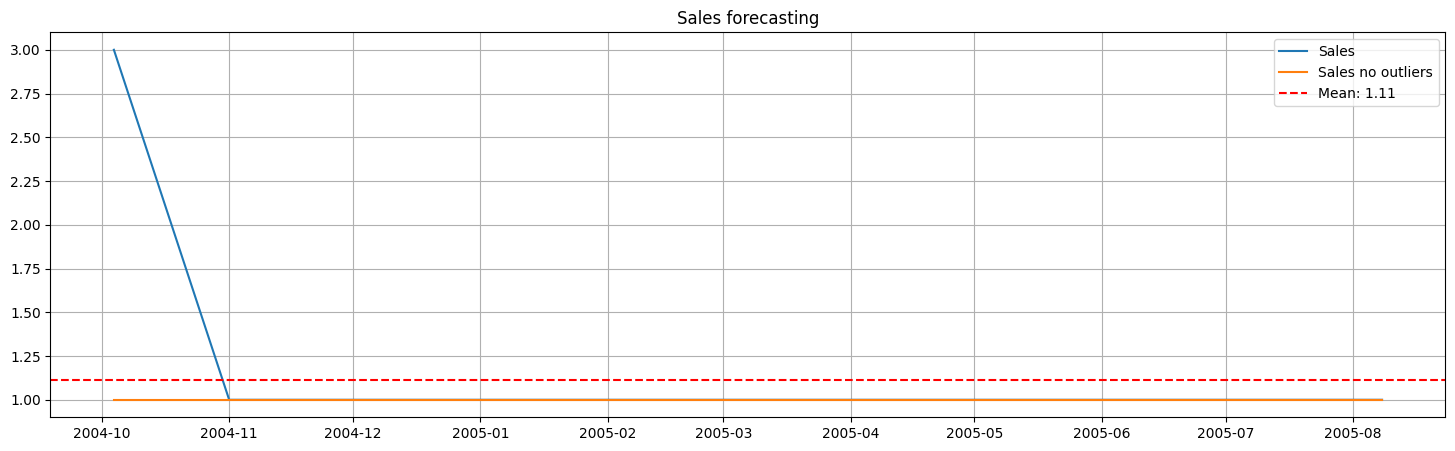

Processing Product ID: 1793
Rows found for Product 1793: 6
⚠️ Warning: No data available for Product 1793. Skipping.
Processing Product ID: 1067
Rows found for Product 1067: 13
Low demand C ...

Percentage outliers:  0.0
Mean : 4.333333333333333, Median: 3.125


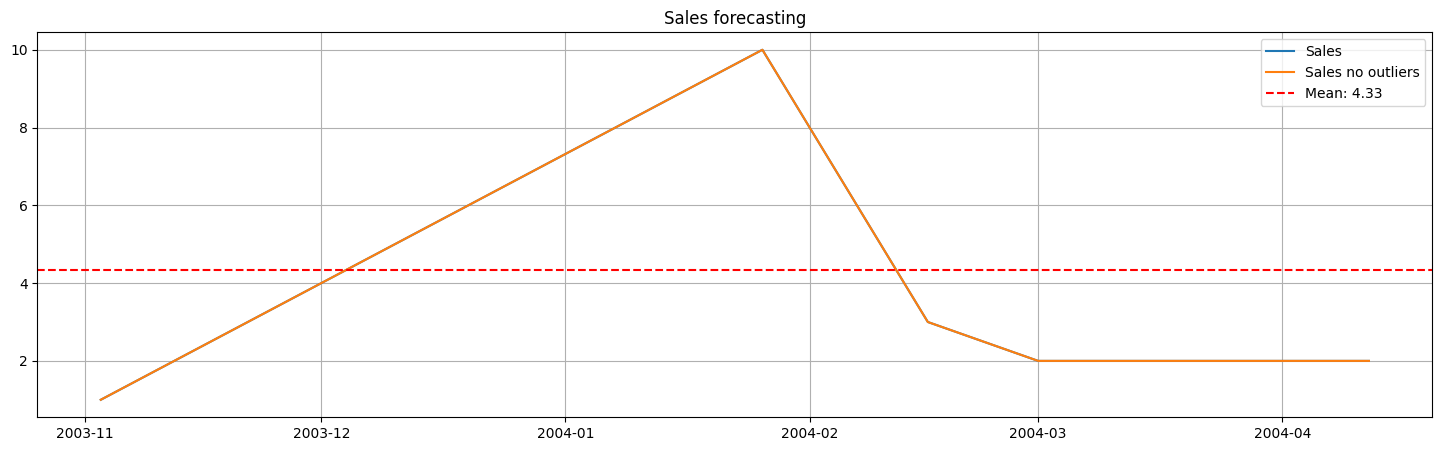

Processing Product ID: 2246
Rows found for Product 2246: 12
Low demand C ...

Percentage outliers:  0.0
Mean : 10.0, Median: 10.0


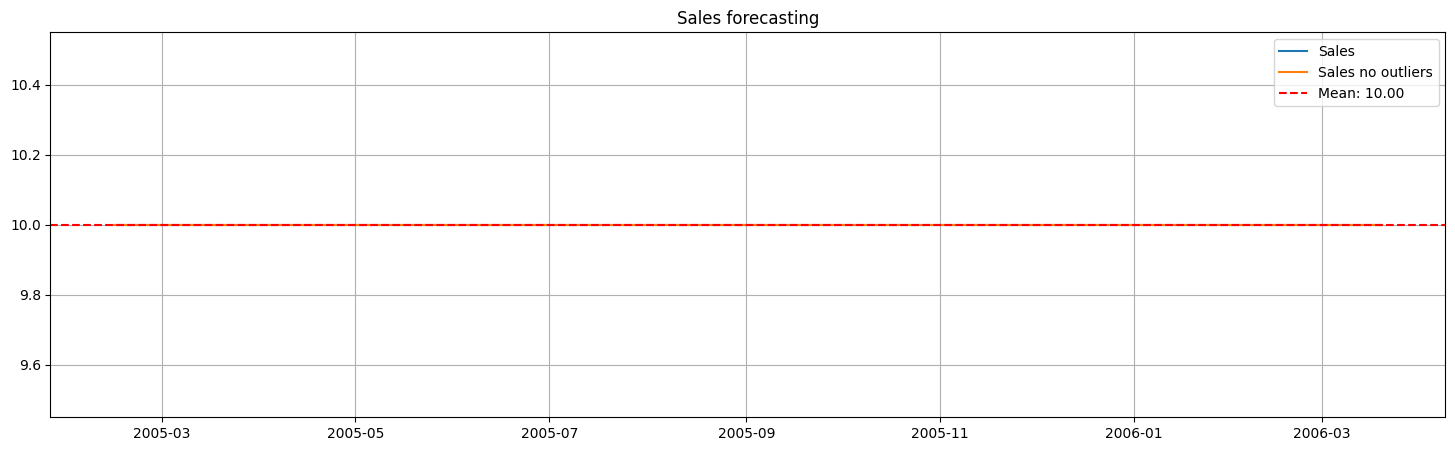

Processing Product ID: 2820
Rows found for Product 2820: 13
Low demand C ...

Processing Product ID: 440
Rows found for Product 440: 10
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


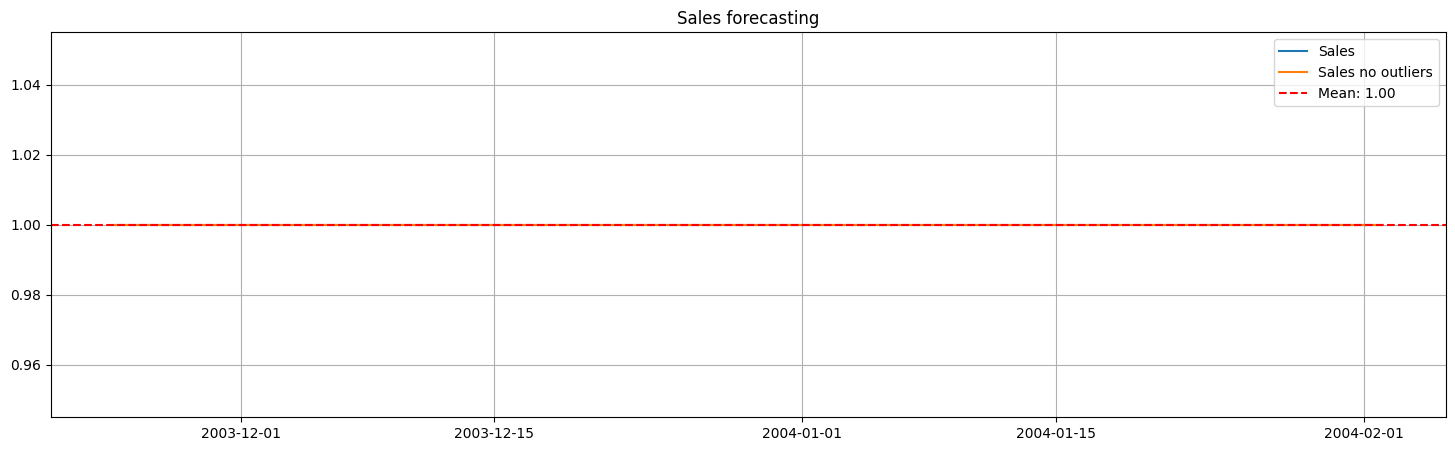

Processing Product ID: 544
Rows found for Product 544: 18
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


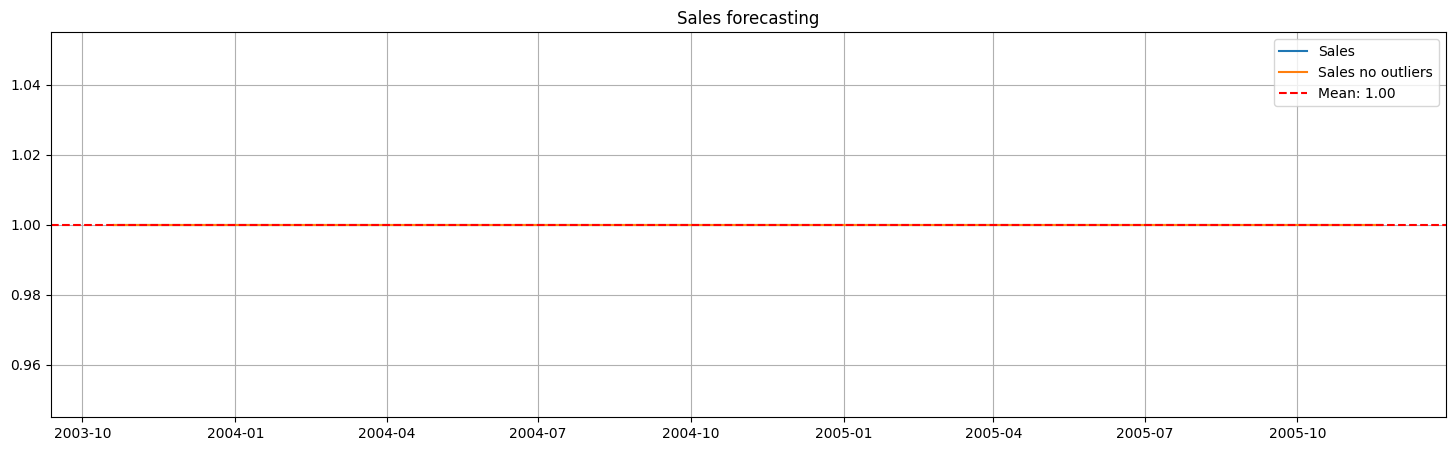

Processing Product ID: 246
Rows found for Product 246: 9
⚠️ Warning: No data available for Product 246. Skipping.
Processing Product ID: 2203
Rows found for Product 2203: 9
⚠️ Warning: No data available for Product 2203. Skipping.
Processing Product ID: 2299
Rows found for Product 2299: 13
Low demand C ...

Percentage outliers:  0.0
Mean : 4.0, Median: 4.0


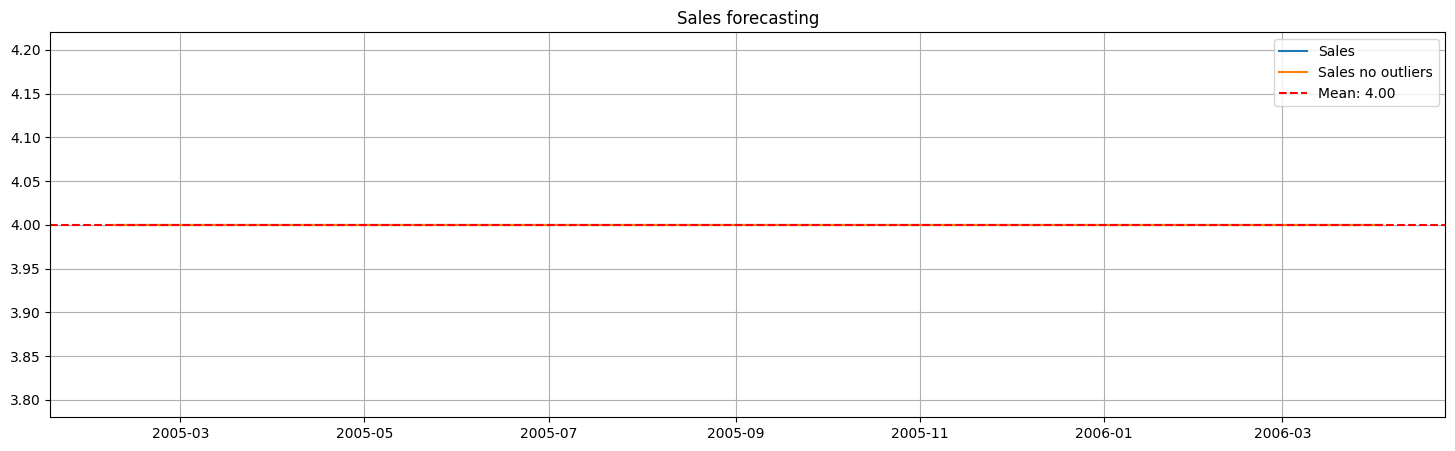

Processing Product ID: 1813
Rows found for Product 1813: 15
Low demand C ...

Percentage outliers:  0.0
Mean : 2.1951219512195124, Median: 1.9864864864864864


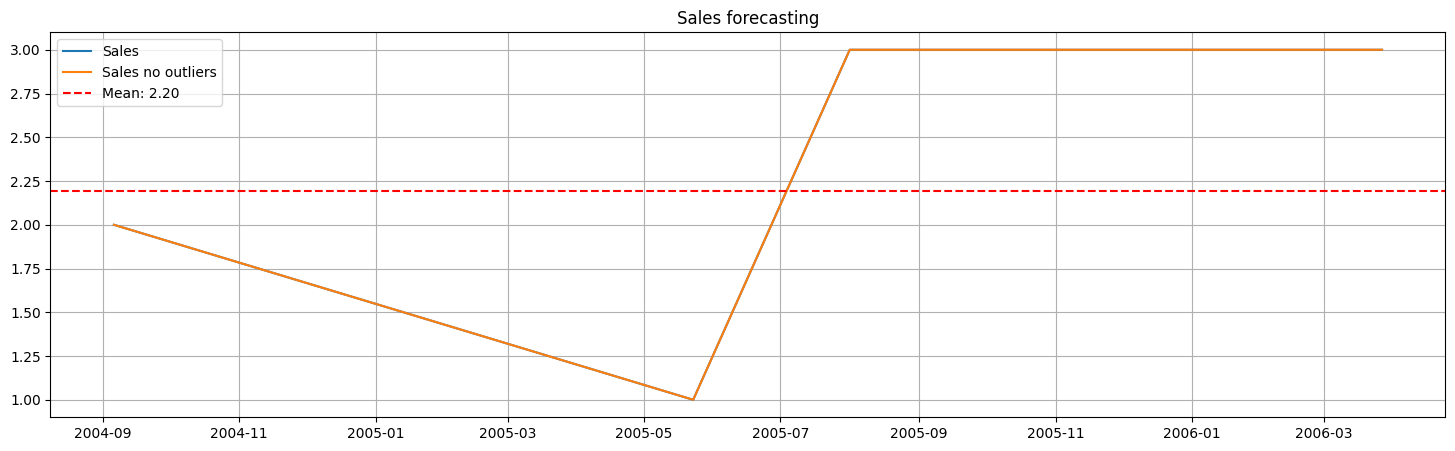

Processing Product ID: 2287
Rows found for Product 2287: 14
Low demand C ...

Percentage outliers:  0.0
Mean : 0.6637931034482759, Median: 0.75


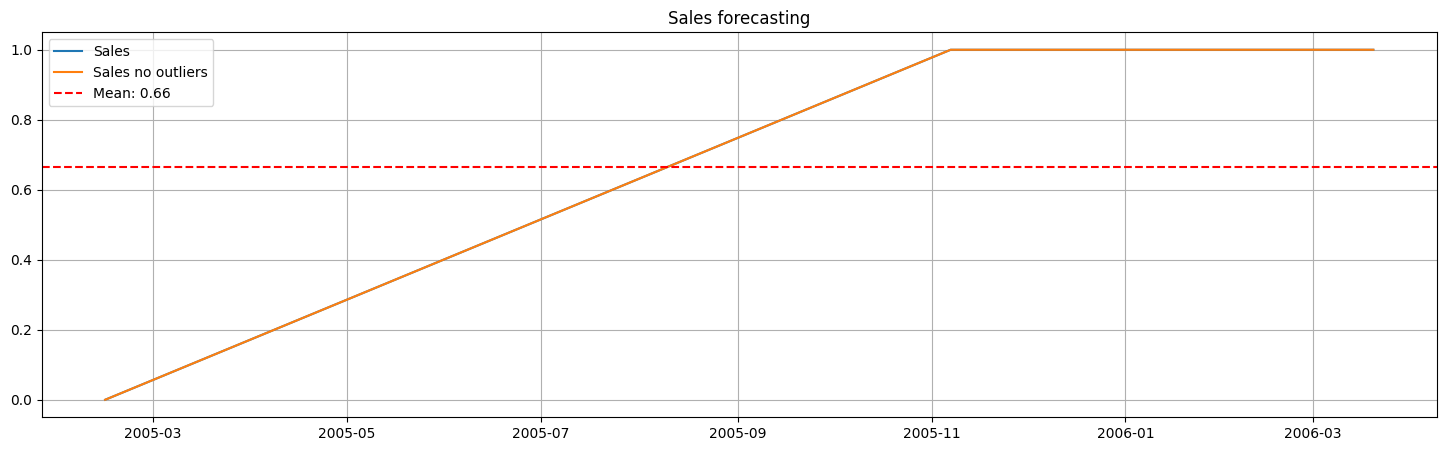

Processing Product ID: 3378
Rows found for Product 3378: 13
Low demand C ...

Percentage outliers:  0.0
Mean : 2.032258064516129, Median: 1.0


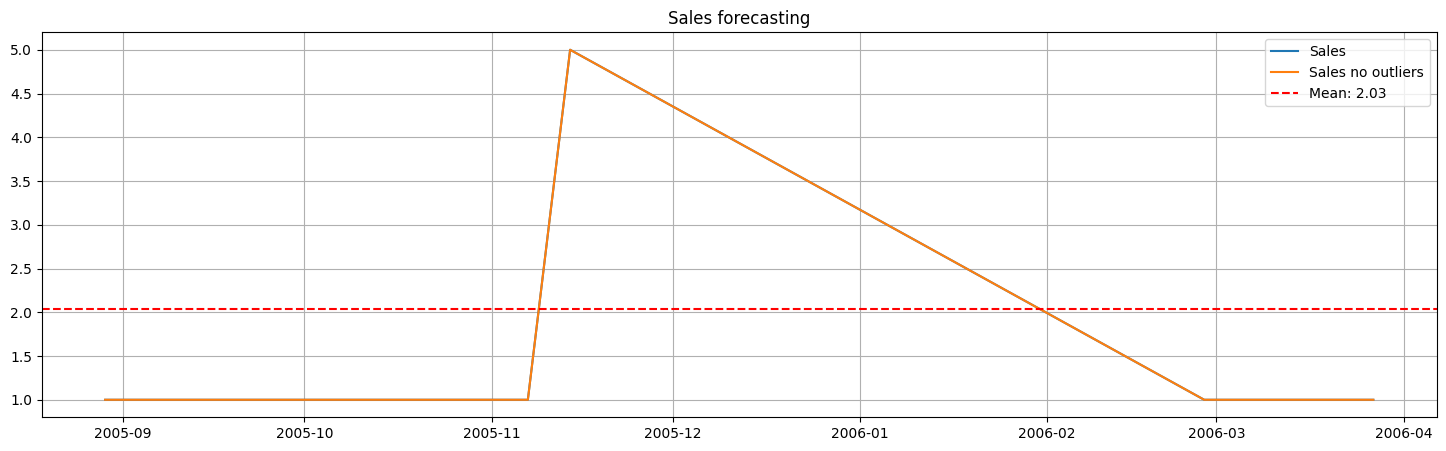

Processing Product ID: 3219
Rows found for Product 3219: 8
⚠️ Warning: No data available for Product 3219. Skipping.
Processing Product ID: 2513
Rows found for Product 2513: 9
⚠️ Warning: No data available for Product 2513. Skipping.
Processing Product ID: 3220
Rows found for Product 3220: 8
⚠️ Warning: No data available for Product 3220. Skipping.
Processing Product ID: 2017
Rows found for Product 2017: 11
Low demand C ...

Percentage outliers:  7.142857142857142
Mean : 2.891891891891892, Median: 3.0


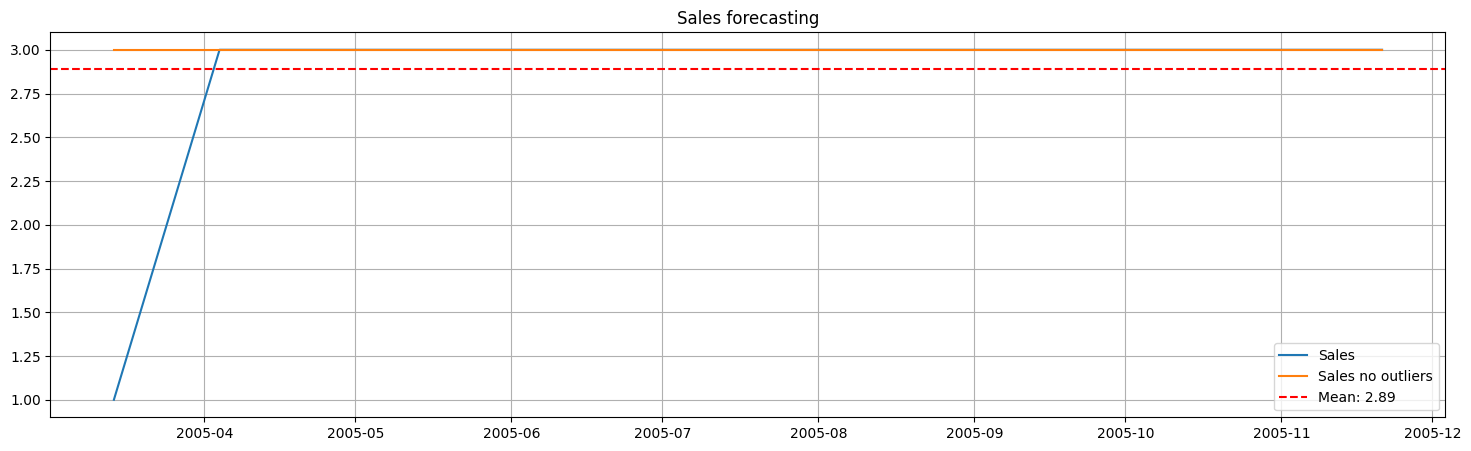

Processing Product ID: 552
Rows found for Product 552: 11
Low demand C ...

Percentage outliers:  8.19672131147541
Mean : 18.858695652173914, Median: 20.0


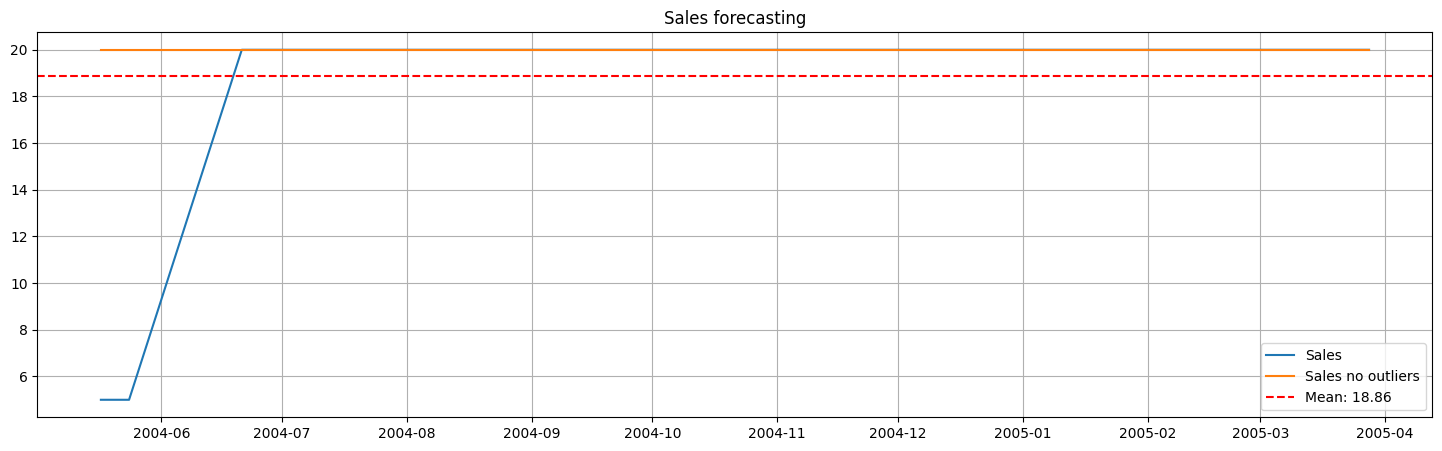

Processing Product ID: 3257
Rows found for Product 3257: 8
⚠️ Warning: No data available for Product 3257. Skipping.
Processing Product ID: 1024
Rows found for Product 1024: 8
⚠️ Warning: No data available for Product 1024. Skipping.
Processing Product ID: 2428
Rows found for Product 2428: 8
⚠️ Warning: No data available for Product 2428. Skipping.
Processing Product ID: 3280
Rows found for Product 3280: 8
⚠️ Warning: No data available for Product 3280. Skipping.
Processing Product ID: 2932
Rows found for Product 2932: 12
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


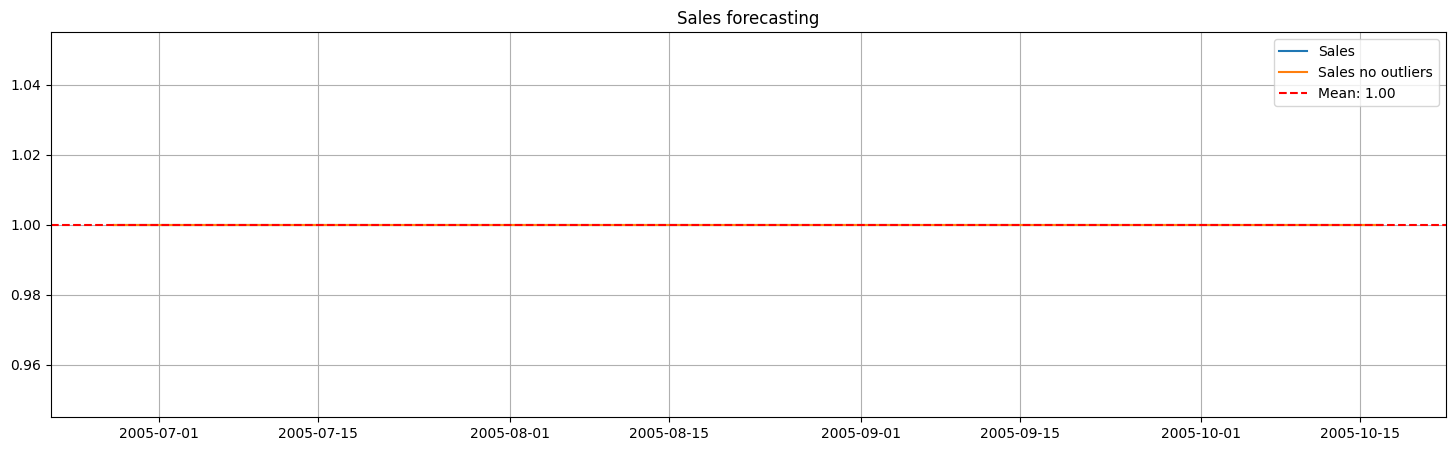

Processing Product ID: 3625
Rows found for Product 3625: 8
⚠️ Warning: No data available for Product 3625. Skipping.
Processing Product ID: 3463
Rows found for Product 3463: 12
Low demand C ...

Percentage outliers:  0.0
Mean : 3.0, Median: 3.0


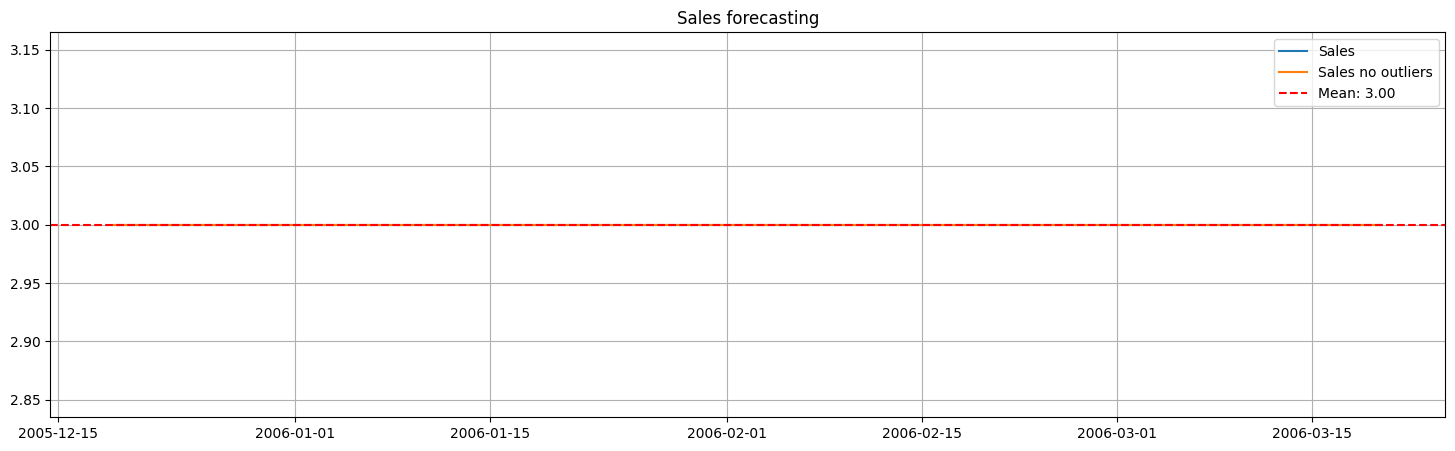

Processing Product ID: 3083
Rows found for Product 3083: 6
⚠️ Warning: No data available for Product 3083. Skipping.
Processing Product ID: 2578
Rows found for Product 2578: 7
⚠️ Warning: No data available for Product 2578. Skipping.
Processing Product ID: 3046
Rows found for Product 3046: 10
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


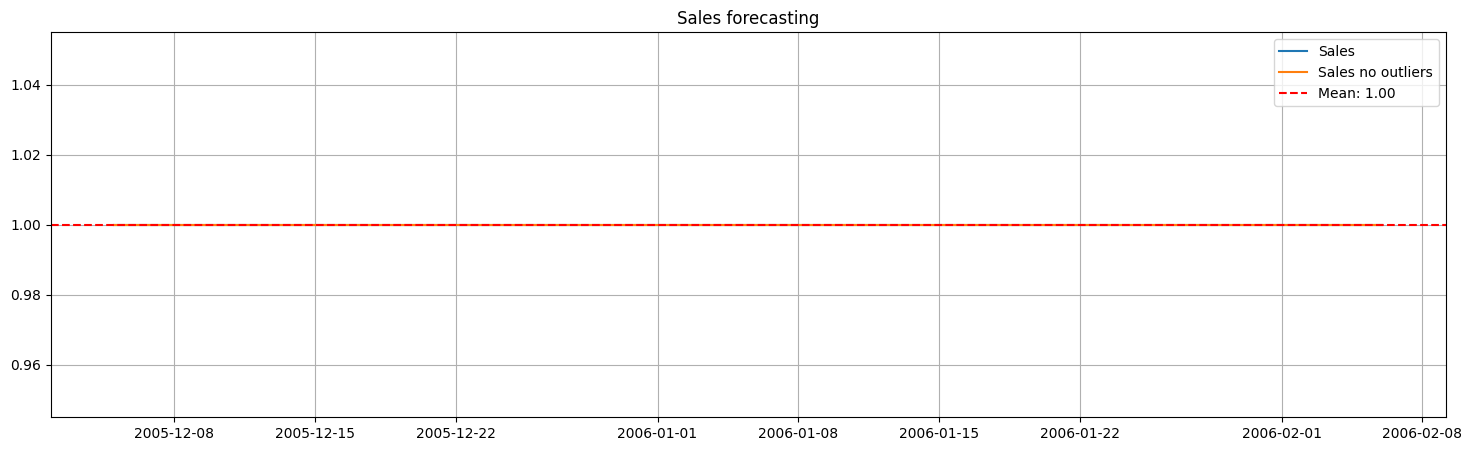

Processing Product ID: 3082
Rows found for Product 3082: 8
⚠️ Warning: No data available for Product 3082. Skipping.
Processing Product ID: 2836
Rows found for Product 2836: 9
⚠️ Warning: No data available for Product 2836. Skipping.
Processing Product ID: 3251
Rows found for Product 3251: 9
⚠️ Warning: No data available for Product 3251. Skipping.
Processing Product ID: 3335
Rows found for Product 3335: 8
⚠️ Warning: No data available for Product 3335. Skipping.
Processing Product ID: 3430
Rows found for Product 3430: 10
Low demand C ...

Processing Product ID: 745
Rows found for Product 745: 8
⚠️ Warning: No data available for Product 745. Skipping.
Processing Product ID: 3125
Rows found for Product 3125: 15
Low demand C ...

Percentage outliers:  11.76470588235294
Mean : 2.073529411764706, Median: 2.0


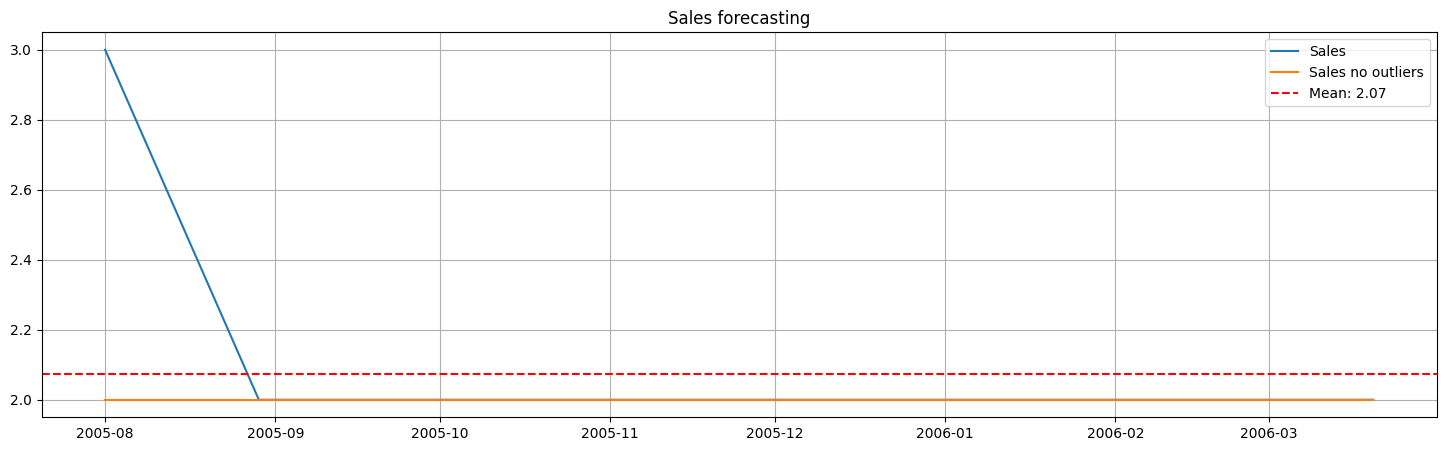

Processing Product ID: 3262
Rows found for Product 3262: 12
Low demand C ...

Percentage outliers:  6.666666666666667
Mean : 1.4655172413793103, Median: 1.0


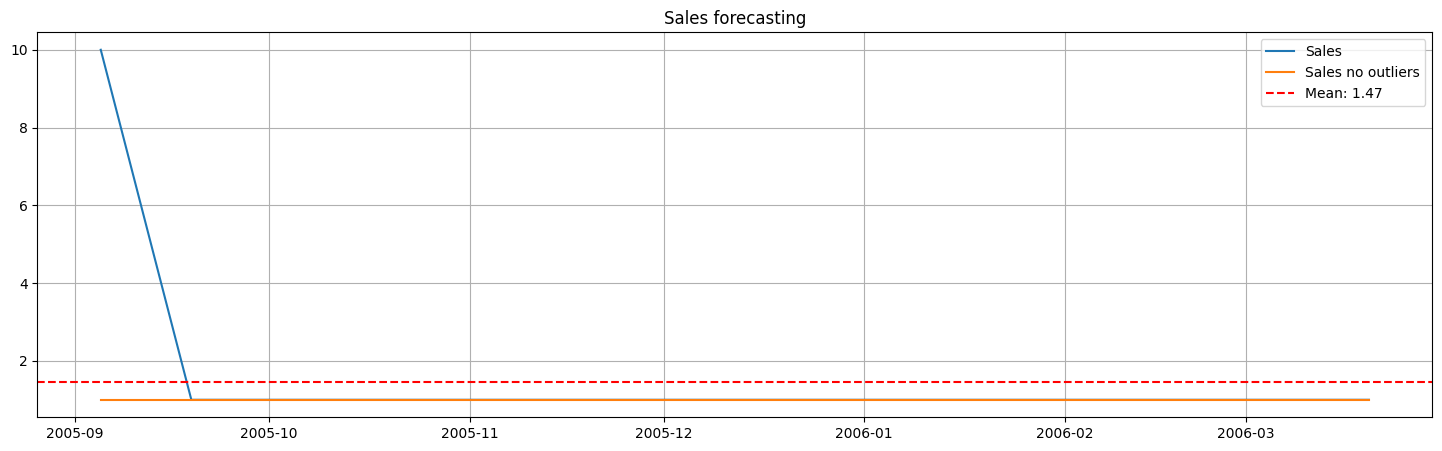

Processing Product ID: 2722
Rows found for Product 2722: 13
Low demand C ...

Processing Product ID: 3217
Rows found for Product 3217: 8
⚠️ Warning: No data available for Product 3217. Skipping.
Processing Product ID: 3638
Rows found for Product 3638: 7
⚠️ Warning: No data available for Product 3638. Skipping.
Processing Product ID: 3394
Rows found for Product 3394: 7
⚠️ Warning: No data available for Product 3394. Skipping.
Processing Product ID: 3097
Rows found for Product 3097: 6
⚠️ Warning: No data available for Product 3097. Skipping.
Processing Product ID: 3482
Rows found for Product 3482: 8
⚠️ Warning: No data available for Product 3482. Skipping.
Processing Product ID: 3420
Rows found for Product 3420: 11
Low demand C ...

Percentage outliers:  13.333333333333334
Mean : 3.816666666666667, Median: 4.0


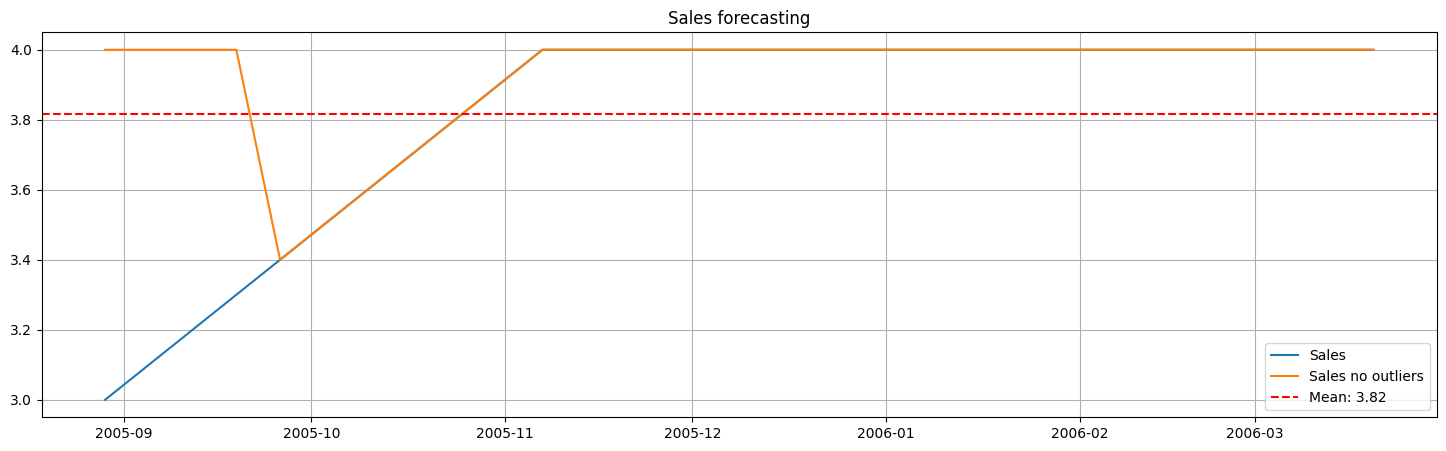

Processing Product ID: 3149
Rows found for Product 3149: 7
⚠️ Warning: No data available for Product 3149. Skipping.
Processing Product ID: 3278
Rows found for Product 3278: 10
Low demand C ...

Percentage outliers:  0.0
Mean : 1.5, Median: 1.5


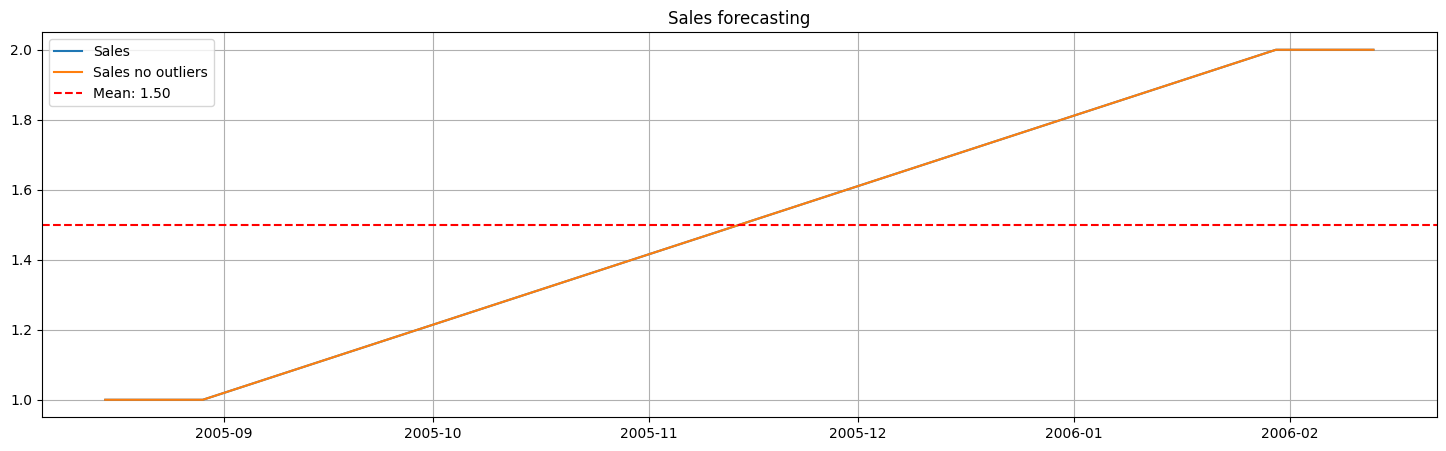

Processing Product ID: 2163
Rows found for Product 2163: 4
⚠️ Warning: No data available for Product 2163. Skipping.
Processing Product ID: 2998
Rows found for Product 2998: 10
Low demand C ...

Percentage outliers:  0.0
Mean : 4.0, Median: 4.0


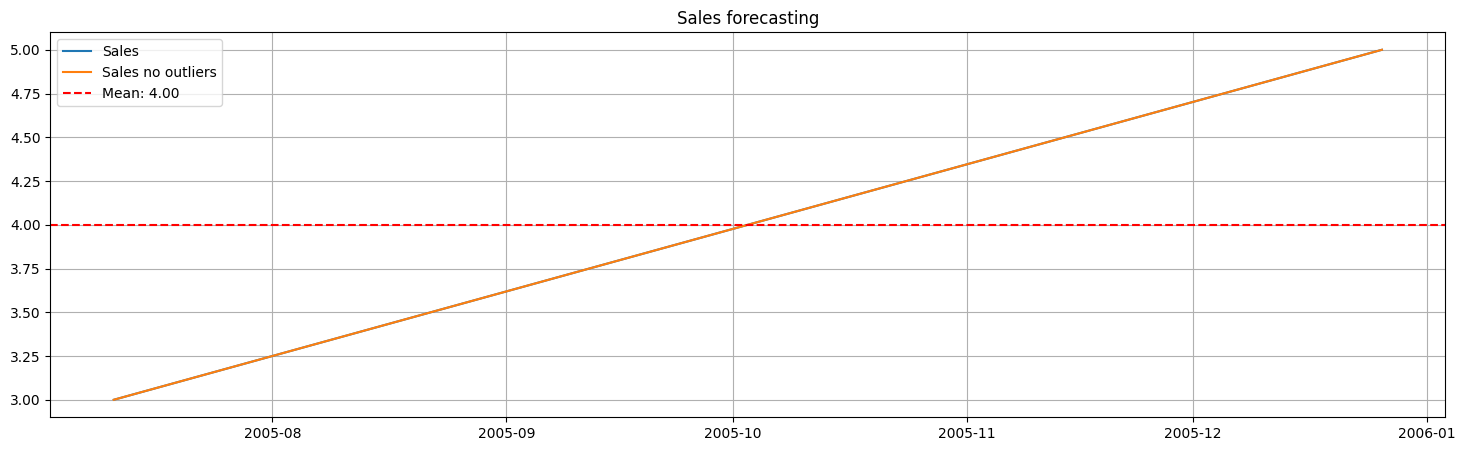

Processing Product ID: 2839
Rows found for Product 2839: 13
Low demand C ...

Percentage outliers:  6.0606060606060606
Mean : 2.65625, Median: 2.809090909090909


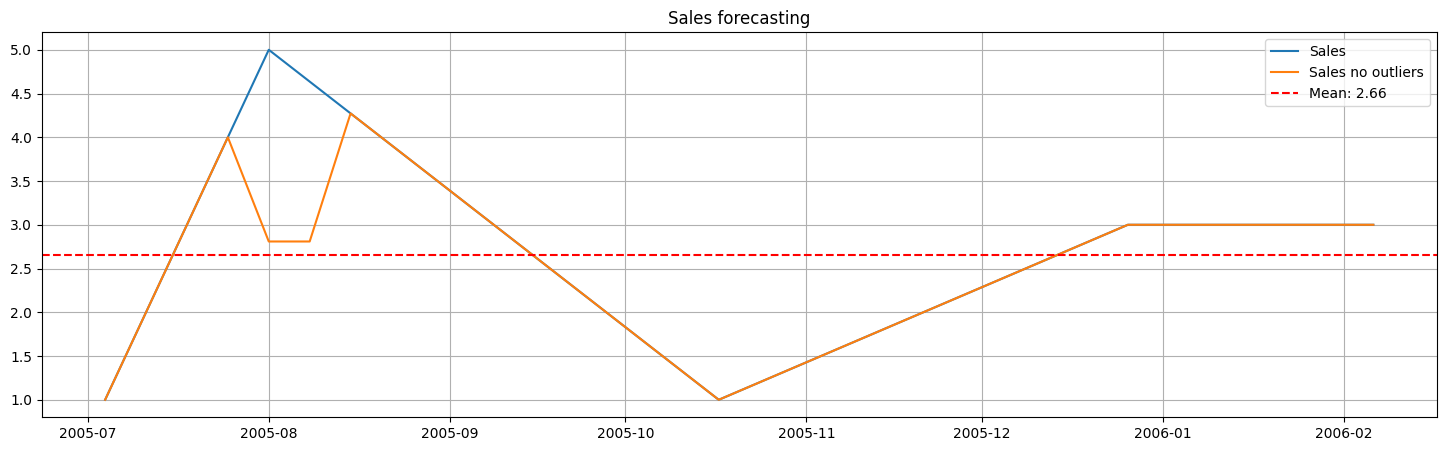

Processing Product ID: 2975
Rows found for Product 2975: 13
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


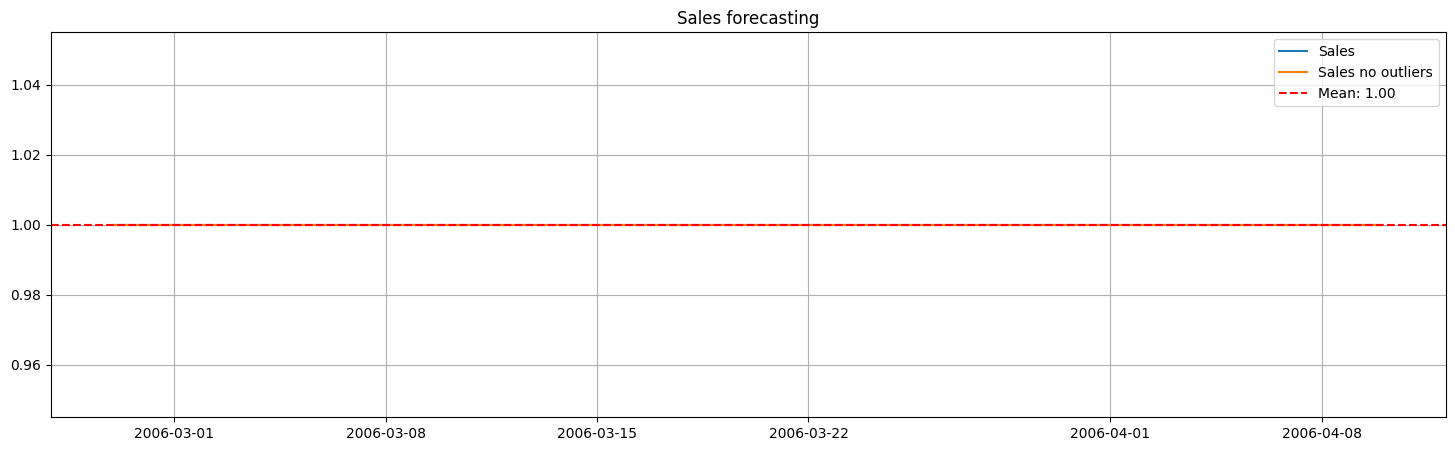

Processing Product ID: 3441
Rows found for Product 3441: 12
Low demand C ...

Processing Product ID: 3355
Rows found for Product 3355: 11
Low demand C ...

Percentage outliers:  6.451612903225806
Mean : 1.4655172413793103, Median: 1.0


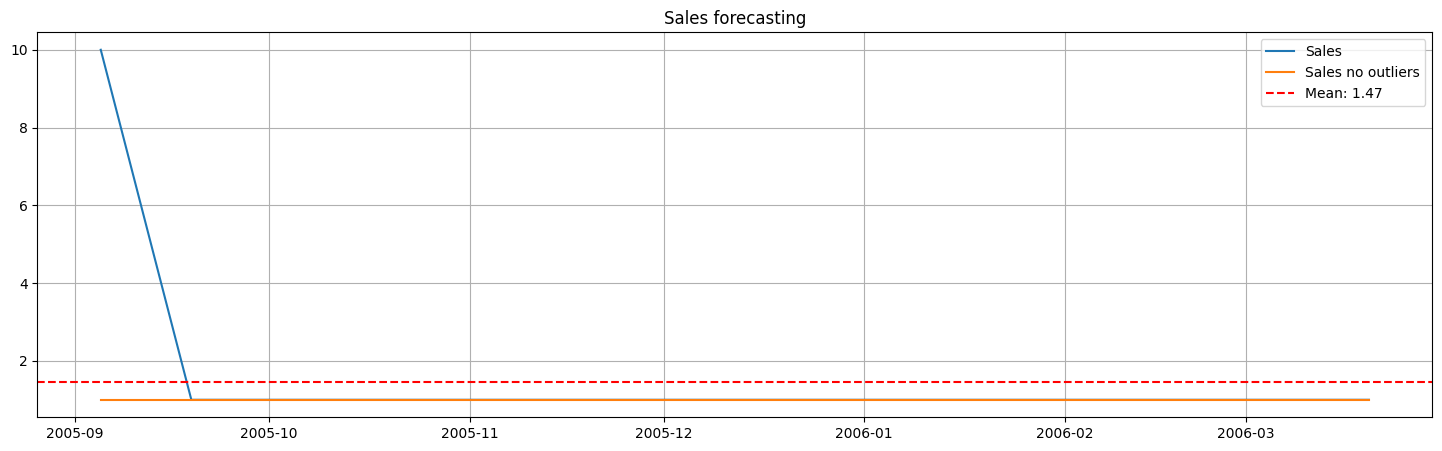

Processing Product ID: 3764
Rows found for Product 3764: 5
⚠️ Warning: No data available for Product 3764. Skipping.
Processing Product ID: 2721
Rows found for Product 2721: 14
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


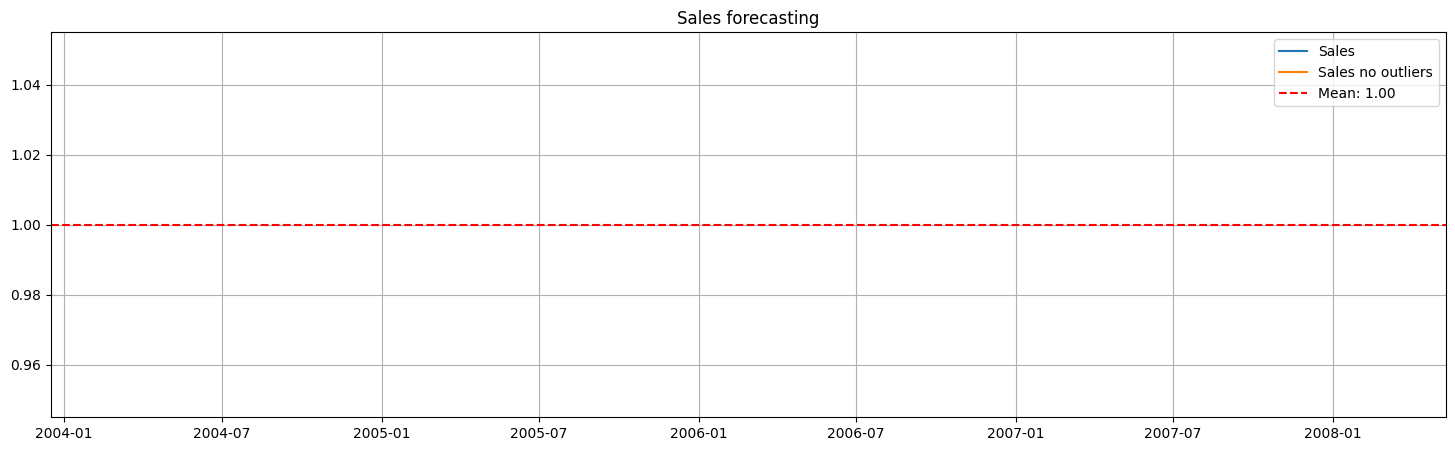

Processing Product ID: 2930
Rows found for Product 2930: 11
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


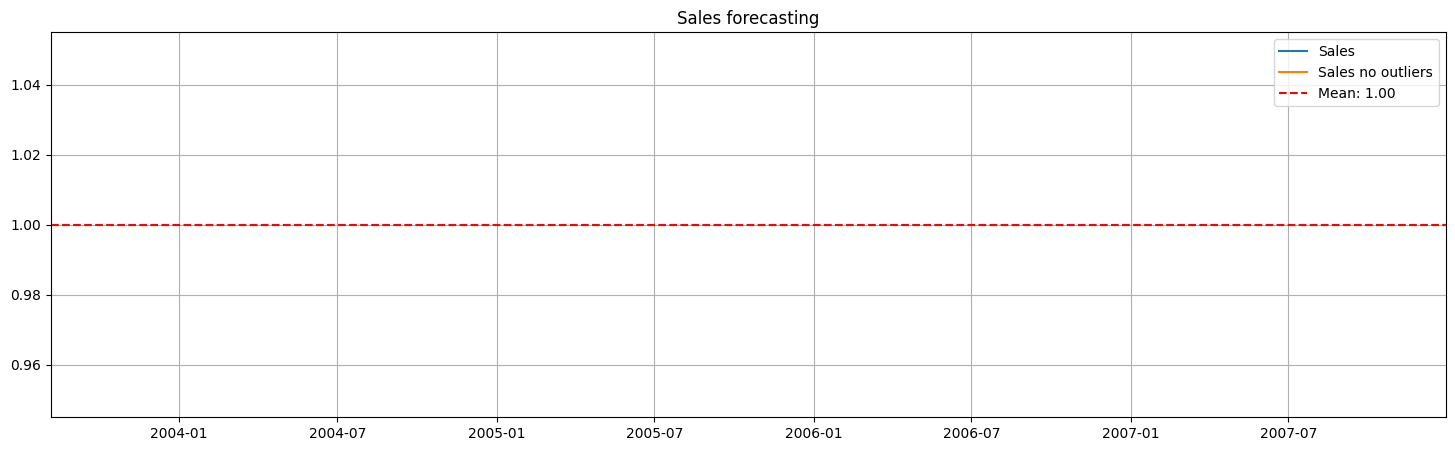

Processing Product ID: 2944
Rows found for Product 2944: 8
⚠️ Warning: No data available for Product 2944. Skipping.
Processing Product ID: 3385
Rows found for Product 3385: 7
⚠️ Warning: No data available for Product 3385. Skipping.
Processing Product ID: 1779
Rows found for Product 1779: 6
⚠️ Warning: No data available for Product 1779. Skipping.
Processing Product ID: 2864
Rows found for Product 2864: 8
⚠️ Warning: No data available for Product 2864. Skipping.
Processing Product ID: 3184
Rows found for Product 3184: 5
⚠️ Warning: No data available for Product 3184. Skipping.
Processing Product ID: 2473
Rows found for Product 2473: 5
⚠️ Warning: No data available for Product 2473. Skipping.
Processing Product ID: 2870
Rows found for Product 2870: 11
Low demand C ...

Processing Product ID: 3452
Rows found for Product 3452: 12
Low demand C ...

Percentage outliers:  0.0
Mean : 1.0, Median: 1.0


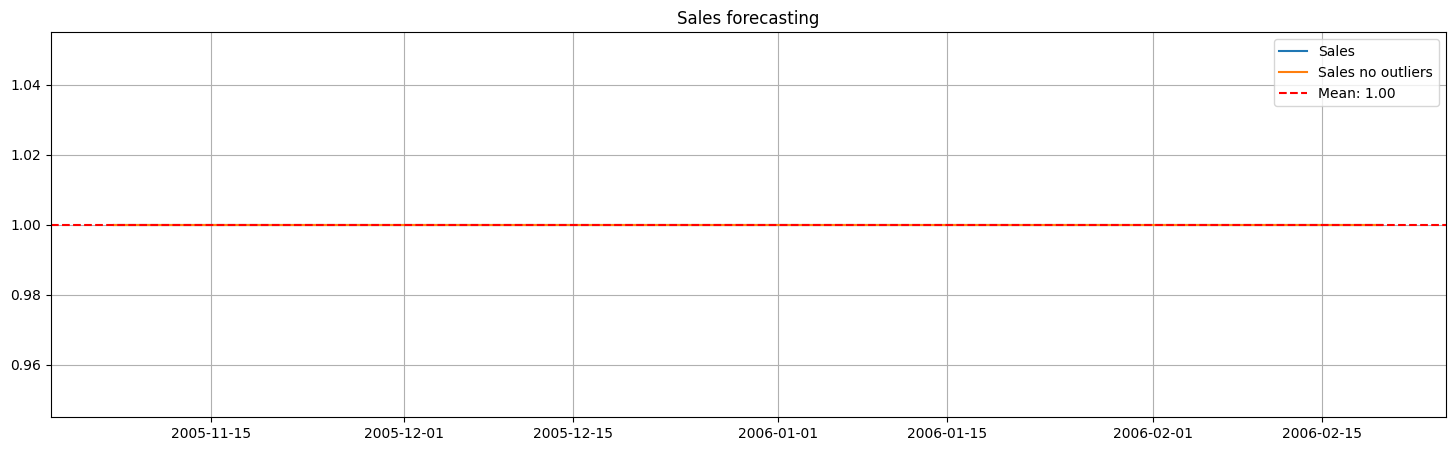

Processing Product ID: 3121
Rows found for Product 3121: 5
⚠️ Warning: No data available for Product 3121. Skipping.
Processing Product ID: 691
Rows found for Product 691: 11
Low demand C ...

Percentage outliers:  7.258064516129033
Mean : 2.1486486486486487, Median: 2.0


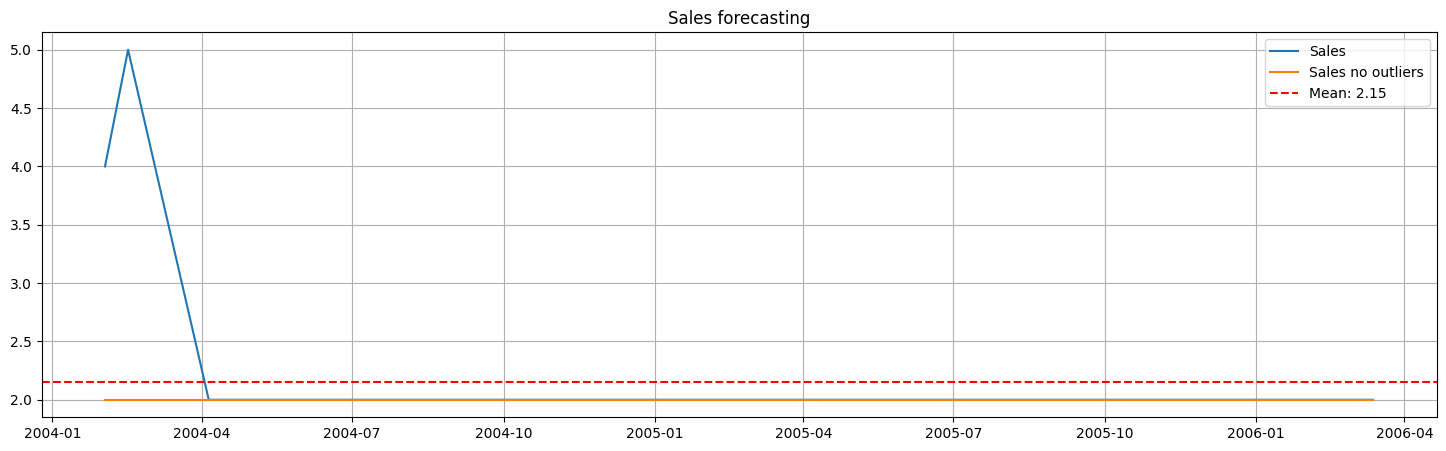

Processing Product ID: 3454
Rows found for Product 3454: 7
⚠️ Warning: No data available for Product 3454. Skipping.
Processing Product ID: 1658
Rows found for Product 1658: 4
⚠️ Warning: No data available for Product 1658. Skipping.
Processing Product ID: 3263
Rows found for Product 3263: 9
⚠️ Warning: No data available for Product 3263. Skipping.
Processing Product ID: 1429
Rows found for Product 1429: 4
⚠️ Warning: No data available for Product 1429. Skipping.
Processing Product ID: 1821
Rows found for Product 1821: 7
⚠️ Warning: No data available for Product 1821. Skipping.
Processing Product ID: 3124
Rows found for Product 3124: 5
⚠️ Warning: No data available for Product 3124. Skipping.
Processing Product ID: 2772
Rows found for Product 2772: 7
⚠️ Warning: No data available for Product 2772. Skipping.
Processing Product ID: 4023
Rows found for Product 4023: 4
⚠️ Warning: No data available for Product 4023. Skipping.
Processing Product ID: 2942
Rows found for Product 2942: 13
Low 

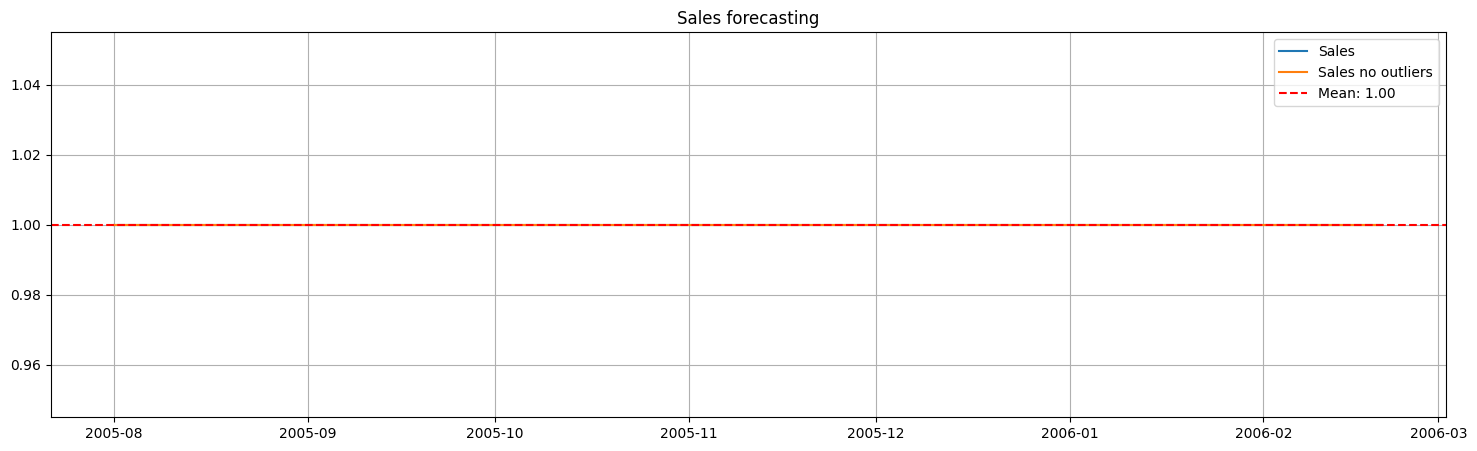

Processing Product ID: 3085
Rows found for Product 3085: 5
⚠️ Warning: No data available for Product 3085. Skipping.
Processing Product ID: 1620
Rows found for Product 1620: 5
⚠️ Warning: No data available for Product 1620. Skipping.
Processing Product ID: 2773
Rows found for Product 2773: 12
Low demand C ...

Percentage outliers:  13.157894736842104
Mean : 7.473684210526316, Median: 8.0


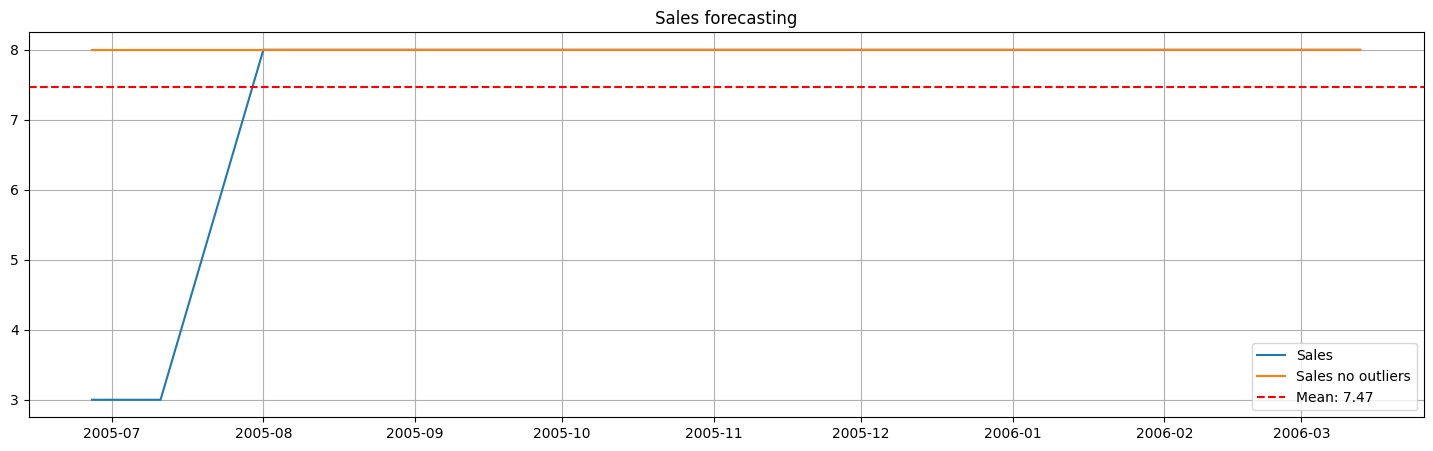

Processing Product ID: 3373
Rows found for Product 3373: 9
⚠️ Warning: No data available for Product 3373. Skipping.
Processing Product ID: 3213
Rows found for Product 3213: 5
⚠️ Warning: No data available for Product 3213. Skipping.
Processing Product ID: 3209
Rows found for Product 3209: 10
Low demand C ...

Percentage outliers:  6.666666666666667
Mean : 1.1, Median: 1.0


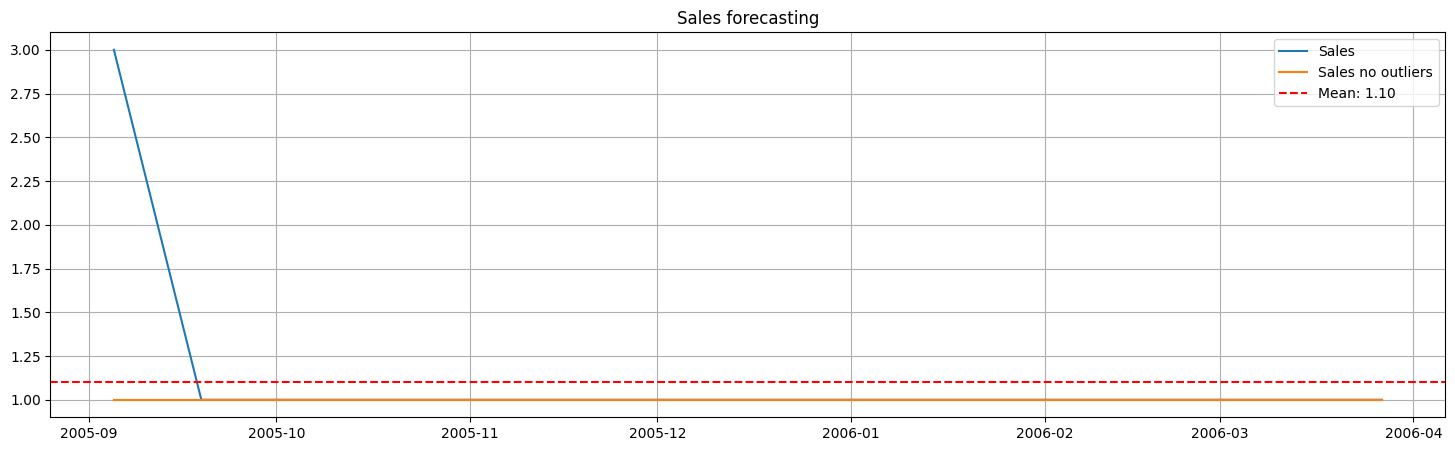

Processing Product ID: 2941
Rows found for Product 2941: 6
⚠️ Warning: No data available for Product 2941. Skipping.
Processing Product ID: 1252
Rows found for Product 1252: 11
Low demand C ...

Percentage outliers:  0.0
Mean : 3.175, Median: 4.0


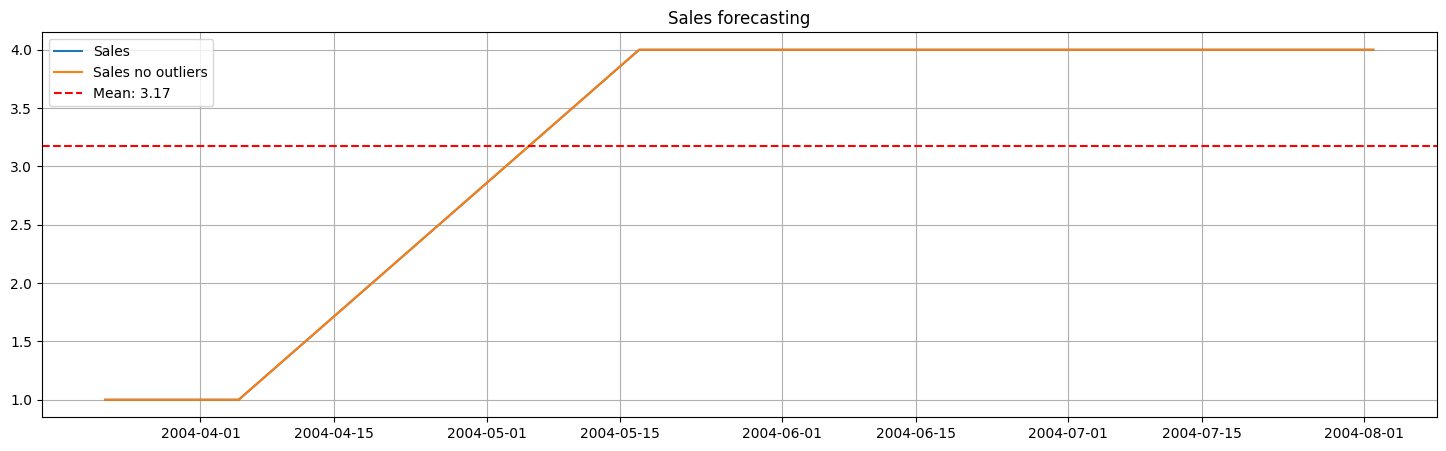

Processing Product ID: 248
Rows found for Product 248: 6
⚠️ Warning: No data available for Product 248. Skipping.
Processing Product ID: 3892
Rows found for Product 3892: 7
⚠️ Warning: No data available for Product 3892. Skipping.
Processing Product ID: 2525
Rows found for Product 2525: 12
Low demand C ...

Percentage outliers:  0.0
Mean : 0.6770833333333334, Median: 0.7833333333333333


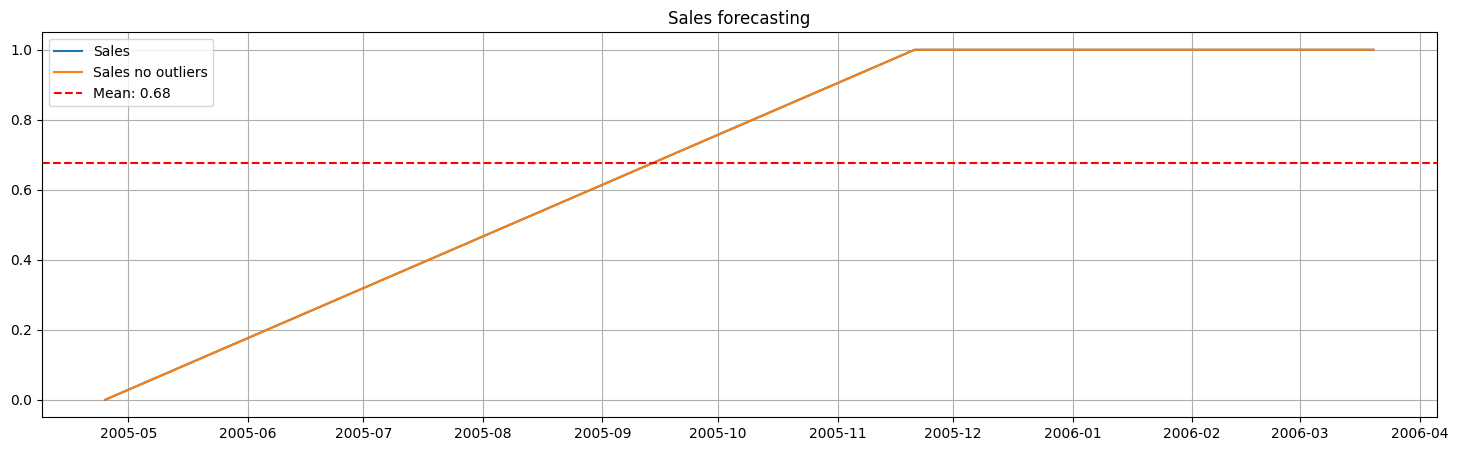

Processing Product ID: 2763
Rows found for Product 2763: 9
⚠️ Warning: No data available for Product 2763. Skipping.
Processing Product ID: 3115
Rows found for Product 3115: 6
⚠️ Warning: No data available for Product 3115. Skipping.
Processing Product ID: 1675
Rows found for Product 1675: 4
⚠️ Warning: No data available for Product 1675. Skipping.
Processing Product ID: 1427
Rows found for Product 1427: 5
⚠️ Warning: No data available for Product 1427. Skipping.
Processing Product ID: 3584
Rows found for Product 3584: 3
⚠️ Warning: No data available for Product 3584. Skipping.
Processing Product ID: 2067
Rows found for Product 2067: 6
⚠️ Warning: No data available for Product 2067. Skipping.
Processing Product ID: 3786
Rows found for Product 3786: 7
⚠️ Warning: No data available for Product 3786. Skipping.
Processing Product ID: 896
Rows found for Product 896: 16
Low demand C ...

Percentage outliers:  0.8928571428571428
Mean : 8.934579439252337, Median: 9.0


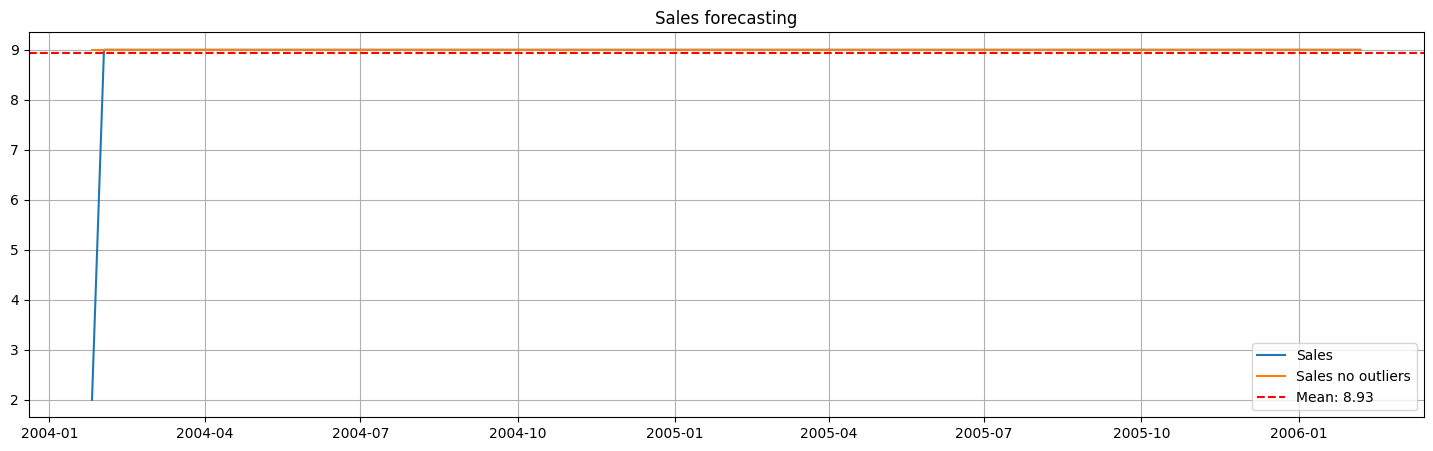

Processing Product ID: 2167
Rows found for Product 2167: 9
⚠️ Warning: No data available for Product 2167. Skipping.
Processing Product ID: 3910
Rows found for Product 3910: 5
⚠️ Warning: No data available for Product 3910. Skipping.
Processing Product ID: 1508
Rows found for Product 1508: 4
⚠️ Warning: No data available for Product 1508. Skipping.
Processing Product ID: 4227
Rows found for Product 4227: 6
⚠️ Warning: No data available for Product 4227. Skipping.
Processing Product ID: 3869
Rows found for Product 3869: 5
⚠️ Warning: No data available for Product 3869. Skipping.
Processing Product ID: 3117
Rows found for Product 3117: 4
⚠️ Warning: No data available for Product 3117. Skipping.
Processing Product ID: 1974
Rows found for Product 1974: 4
⚠️ Warning: No data available for Product 1974. Skipping.
Processing Product ID: 3574
Rows found for Product 3574: 5
⚠️ Warning: No data available for Product 3574. Skipping.
Processing Product ID: 3104
Rows found for Product 3104: 12
Low 

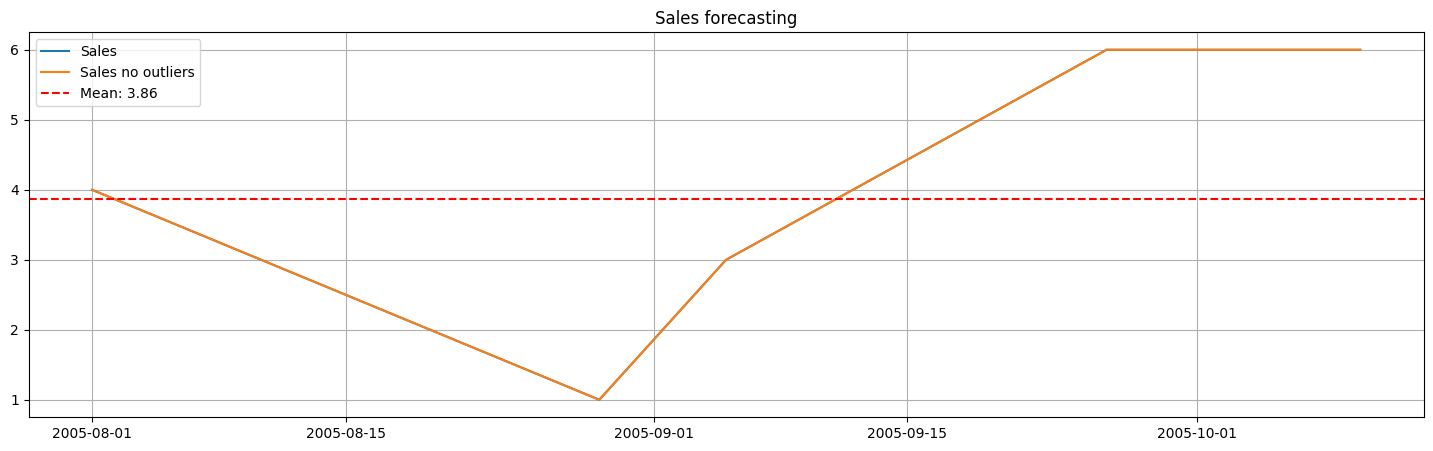

Processing Product ID: 3755
Rows found for Product 3755: 4
⚠️ Warning: No data available for Product 3755. Skipping.
Processing Product ID: 3613
Rows found for Product 3613: 4
⚠️ Warning: No data available for Product 3613. Skipping.
Processing Product ID: 3630
Rows found for Product 3630: 3
⚠️ Warning: No data available for Product 3630. Skipping.
Processing Product ID: 3364
Rows found for Product 3364: 6
⚠️ Warning: No data available for Product 3364. Skipping.
Processing Product ID: 3719
Rows found for Product 3719: 4
⚠️ Warning: No data available for Product 3719. Skipping.
Processing Product ID: 3315
Rows found for Product 3315: 8
⚠️ Warning: No data available for Product 3315. Skipping.
Processing Product ID: 3375
Rows found for Product 3375: 6
⚠️ Warning: No data available for Product 3375. Skipping.
Processing Product ID: 2875
Rows found for Product 2875: 7
⚠️ Warning: No data available for Product 2875. Skipping.
Processing Product ID: 3384
Rows found for Product 3384: 5
⚠️ Wa

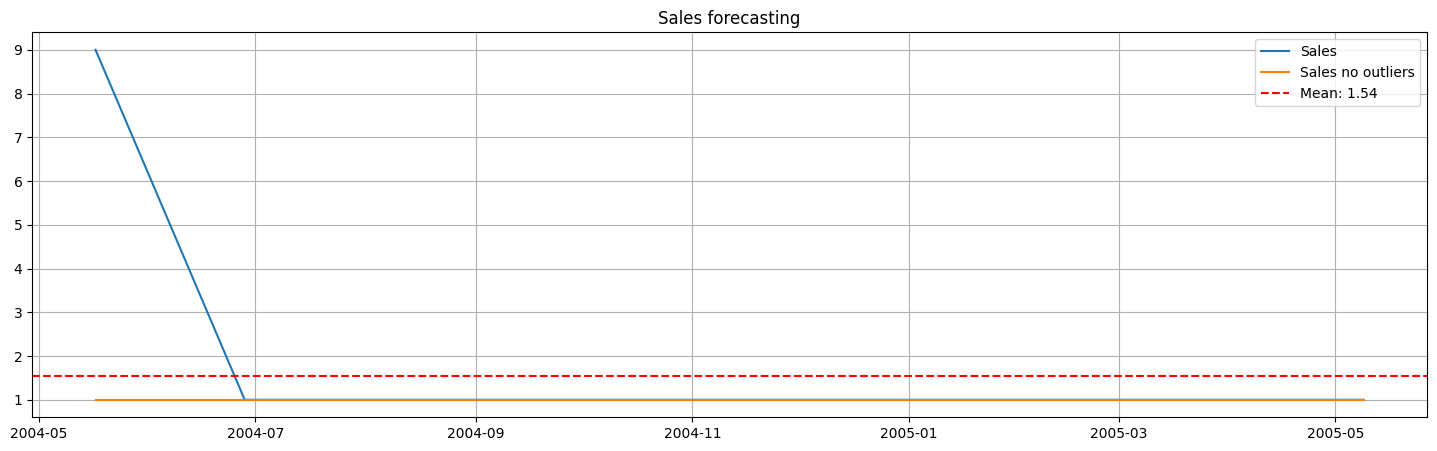

Processing Product ID: 3021
Rows found for Product 3021: 5
⚠️ Warning: No data available for Product 3021. Skipping.
Processing Product ID: 2073
Rows found for Product 2073: 6
⚠️ Warning: No data available for Product 2073. Skipping.
Processing Product ID: 109
Rows found for Product 109: 13
Low demand C ...

Percentage outliers:  18.39080459770115
Mean : 6.588235294117647, Median: 7.0


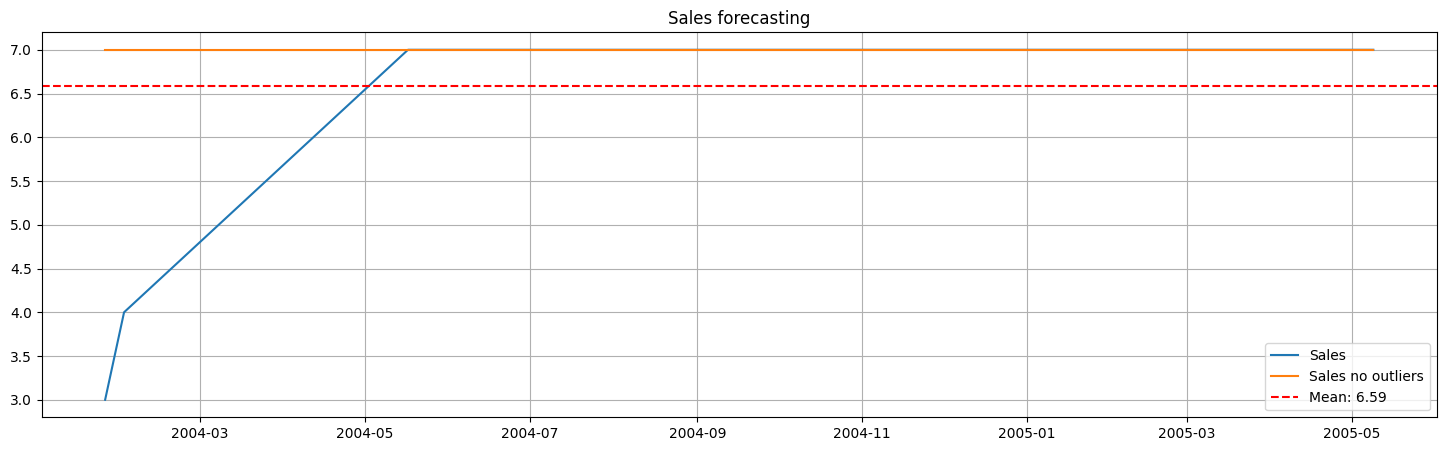

Processing Product ID: 3730
Rows found for Product 3730: 3
⚠️ Warning: No data available for Product 3730. Skipping.
Processing Product ID: 2315
Rows found for Product 2315: 5
⚠️ Warning: No data available for Product 2315. Skipping.
Processing Product ID: 2233
Rows found for Product 2233: 5
⚠️ Warning: No data available for Product 2233. Skipping.
Processing Product ID: 3317
Rows found for Product 3317: 3
⚠️ Warning: No data available for Product 3317. Skipping.
Processing Product ID: 4024
Rows found for Product 4024: 3
⚠️ Warning: No data available for Product 4024. Skipping.
Processing Product ID: 4221
Rows found for Product 4221: 4
⚠️ Warning: No data available for Product 4221. Skipping.
Processing Product ID: 3713
Rows found for Product 3713: 3
⚠️ Warning: No data available for Product 3713. Skipping.
Processing Product ID: 3322
Rows found for Product 3322: 5
⚠️ Warning: No data available for Product 3322. Skipping.
Processing Product ID: 3069
Rows found for Product 3069: 3
⚠️ Wa

In [30]:
# Inicializar contenedores para almacenar resultados
#all_errors_high_demand_A = pd.DataFrame()
#all_predictions_high_demand_A = pd.DataFrame()

#all_errors_high_demand_B = pd.DataFrame()
#all_predictions_high_demand_B = pd.DataFrame()

all_errors_high_demand_C = pd.DataFrame()
all_predictions_high_demand_C = pd.DataFrame()

all_errors_low_demand_A = pd.DataFrame()
all_predictions_low_demand_A = pd.DataFrame()

all_errors_low_demand_B = pd.DataFrame()
all_predictions_low_demand_B = pd.DataFrame()

all_errors_low_demand_C = pd.DataFrame()
all_predictions_low_demand_C = pd.DataFrame()

# Aplicar la función a los productos de alta demanda
#for producto_id in df_selected_high_demand_A['ProductID'].unique():
    # Llamar a la función evaluate_model para cada producto en alta demanda
#    print('High demand A..: \n')
  #  errors, predictions = evaluate_model(df, producto_id, demand_class='High demand')
    
    # Guardar los resultados de errores
#    all_errors_high_demand_A = pd.concat([all_errors_high_demand_A, errors], ignore_index=True)
    
    # Guardar las predicciones
#    all_predictions_high_demand_A = pd.concat([all_predictions_high_demand_A, predictions], ignore_index=True)
    
#for producto_id in df_selected_high_demand_B['ProductID'].unique():
    
#    print("High demand B: ...\n")
    # Llamar a la función evaluate_model para cada producto en alta demanda
 #   errors, predictions = evaluate_model(df, producto_id, demand_class='High demand')
    
    # Guardar los resultados de errores
 #   all_errors_high_demand_B = pd.concat([all_errors_high_demand_B, errors], ignore_index=True)
    
    # Guardar las predicciones
 #   all_predictions_high_demand_B = pd.concat([all_predictions_high_demand_B, predictions], ignore_index=True)

for producto_id in df_selected_high_demand_C['ProductID'].unique():
    
    print(f"Processing Product ID: {producto_id}")
    
    df_p = df[df['ProductID'] == producto_id]  # Filtramos el producto
    print(f"Rows found for Product {producto_id}: {len(df_p)}")
    
    if df_p.empty or df_p['QuantitySold'].dropna().empty or (len(df_p) < 20):
        print(f"⚠️ Warning: No data available for Product {producto_id}. Skipping.")
        continue  # Saltamos al siguiente producto si no hay datos
    
    print("High demand C .... \n")
    # Llamar a la función evaluate_model para cada producto en alta demanda
    errors, predictions = evaluate_model(df, producto_id, demand_class='High demand')
    
    # Guardar los resultados de errores
    all_errors_high_demand_C = pd.concat([all_errors_high_demand_C, errors], ignore_index=True)
    
    # Guardar las predicciones
    all_predictions_high_demand_C = pd.concat([all_predictions_high_demand_C, predictions], ignore_index=True)

# Aplicar la función a los productos de baja demanda
for producto_id in df_selected_low_demand_A['ProductID'].unique():
    
    print(f"Processing Product ID: {producto_id}")
    
    df_p = df[df['ProductID'] == producto_id]  # Filtramos el producto
    print(f"Rows found for Product {producto_id}: {len(df_p)}")
    
    if df_p.empty or df_p['QuantitySold'].dropna().empty or (len(df_p) < 10):
        print(f"⚠️ Warning: No data available for Product {producto_id}. Skipping.")
        continue  # Saltamos al siguiente producto si no hay datos
    
    print("Low demand A .... \n")
    # Llamar a la función evaluate_model para cada producto en baja demanda
    errors, predictions = evaluate_model(df, producto_id, demand_class='Low demand')
    
    # Guardar los resultados de errores
    all_errors_low_demand_A = pd.concat([all_errors_low_demand_A, errors], ignore_index=True)
    
    # Guardar las predicciones
    all_predictions_low_demand_A = pd.concat([all_predictions_low_demand_A, predictions], ignore_index=True)

# Aplicar la función a los productos de baja demanda
for producto_id in df_selected_low_demand_B['ProductID'].unique():
    
    print(f"Processing Product ID: {producto_id}")
    
    df_p = df[df['ProductID'] == producto_id]  # Filtramos el producto
    print(f"Rows found for Product {producto_id}: {len(df_p)}")
    
    if df_p.empty or df_p['QuantitySold'].dropna().empty or (len(df_p) < 10):
        print(f"⚠️ Warning: No data available for Product {producto_id}. Skipping.")
        continue  # Saltamos al siguiente producto si no hay datos
    
    
    print("Low demand B ...\n")
    # Llamar a la función evaluate_model para cada producto en baja demanda
    errors, predictions = evaluate_model(df, producto_id, demand_class='Low demand')
    
    # Guardar los resultados de errores
    all_errors_low_demand_B = pd.concat([all_errors_low_demand_B, errors], ignore_index=True)
    
    # Guardar las predicciones
    all_predictions_low_demand_B = pd.concat([all_predictions_low_demand_B, predictions], ignore_index=True)
    
# Aplicar la función a los productos de baja demanda
for producto_id in df_selected_low_demand_C['ProductID'].unique():
    
    print(f"Processing Product ID: {producto_id}")
    
    df_p = df[df['ProductID'] == producto_id]  # Filtramos el producto
    print(f"Rows found for Product {producto_id}: {len(df_p)}")
    
    if df_p.empty or df_p['QuantitySold'].dropna().empty or (len(df_p) < 10):
        print(f"⚠️ Warning: No data available for Product {producto_id}. Skipping.")
        continue  # Saltamos al siguiente producto si no hay datos
    
    
    
    print("Low demand C ...\n")
    # Llamar a la función evaluate_model para cada producto en baja demanda
    errors, predictions = evaluate_model(df, producto_id, demand_class='Low demand')
    
    # Guardar los resultados de errores
    all_errors_low_demand_C = pd.concat([all_errors_low_demand_C, errors], ignore_index=True)
    
    # Guardar las predicciones
    all_predictions_low_demand_C = pd.concat([all_predictions_low_demand_C, predictions], ignore_index=True)





In [32]:
print("High demand A: \n")

all_predictions_high_demand_A.to_csv("../Datasets/all_predictions_high_demand_A.csv")
all_errors_high_demand_A.to_csv("../Datasets/all_errors_high_demand_A.csv")
print(all_errors_high_demand_A)
print(all_predictions_high_demand_A)

print("High demand B: \n")
all_predictions_high_demand_B.to_csv("../Datasets/all_predictions_high_demand_B.csv")
all_errors_high_demand_B.to_csv("../Datasets/all_errors_high_demand_B.csv")
print(all_errors_high_demand_B)
print(all_predictions_high_demand_B)


print("High demand C: \n")
all_predictions_high_demand_C.to_csv("../Datasets/all_predictions_high_demand_C.csv")
all_errors_high_demand_C.to_csv("../Datasets/all_errors_high_demand_C.csv")
print(all_errors_high_demand_C)
print(all_predictions_high_demand_C)

print("Low demand A: \n")

all_predictions_low_demand_A.to_csv("../Datasets/all_predictions_low_demand_A.csv")
all_errors_low_demand_A.to_csv("../Datasets/all_errors_low_demand_A.csv")

print(all_errors_low_demand_A)
print(all_predictions_low_demand_A)

print("Low demand B: \n")

all_predictions_low_demand_B.to_csv("../Datasets/all_predictions_low_demand_B.csv")
all_errors_low_demand_B.to_csv("../Datasets/all_errors_low_demand_B.csv")

print(all_errors_low_demand_B)
print(all_predictions_low_demand_B)

print("Low demand C: \n")

all_predictions_low_demand_C.to_csv("../Datasets/all_predictions_low_demand_C.csv")
all_errors_low_demand_C.to_csv("../Datasets/all_errors_low_demand_C.csv")

print(all_errors_low_demand_C)
print(all_predictions_low_demand_C)

High demand A: 

     ProductID   Modelo       MAE        MSE      RMSE        MAPE  \
0          427    ARIMA  2.662351   8.636406  2.938776   53.271035   
1          427  SARIMAX  6.650230  66.483076  8.153715  133.397628   
2          427  Prophet  5.488272  49.039291  7.002806  109.943951   
3          861    ARIMA  1.458275   3.122433  1.767041   76.643625   
4          861  SARIMAX  3.763227  18.200776  4.266237  240.866376   
..         ...      ...       ...        ...       ...         ...   
259        737  SARIMAX  0.502812   0.277387  0.526675   16.760412   
260        737  Prophet  0.893685   0.831226  0.911716   29.789510   
261        637    ARIMA  0.345648   0.147578  0.384158   34.564832   
262        637  SARIMAX  1.593621   2.886409  1.698943  159.362136   
263        637  Prophet  1.724849   2.976566  1.725273  172.484874   

                                           Predictions  
0    [4.285670310183115, 4.014562069545422, 3.70004...  
1    [14.211439173890396, 10

In [33]:
all_errors_high_demand_A, all_predictions_high_demand_A

(     ProductID   Modelo       MAE        MSE      RMSE        MAPE  \
 0          427    ARIMA  2.662351   8.636406  2.938776   53.271035   
 1          427  SARIMAX  6.650230  66.483076  8.153715  133.397628   
 2          427  Prophet  5.488272  49.039291  7.002806  109.943951   
 3          861    ARIMA  1.458275   3.122433  1.767041   76.643625   
 4          861  SARIMAX  3.763227  18.200776  4.266237  240.866376   
 ..         ...      ...       ...        ...       ...         ...   
 259        737  SARIMAX  0.502812   0.277387  0.526675   16.760412   
 260        737  Prophet  0.893685   0.831226  0.911716   29.789510   
 261        637    ARIMA  0.345648   0.147578  0.384158   34.564832   
 262        637  SARIMAX  1.593621   2.886409  1.698943  159.362136   
 263        637  Prophet  1.724849   2.976566  1.725273  172.484874   
 
                                            Predictions  
 0    [4.285670310183115, 4.014562069545422, 3.70004...  
 1    [14.211439173890396, 10.